In [1]:
from src.dataset import FinancialDataset, DataHandler
from src.trainer_new import PortfolioTrainer
from src.markowitz import MaxSharpe
from src.models import NN_Sharpe
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
%load_ext autoreload
%autoreload 2

# Propre

## Extracting Mean and Cov

In [3]:
financial_dataset = FinancialDataset(tickers=["XOM", "TLT"], synthetic=True, n_simul=2000, n_synthetic=700)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [4]:
returns = financial_dataset._raw_data['returns'].values

mean_th = returns.mean(axis=0)
cov_th = np.cov(returns, rowvar=False)

In [5]:
mean_th

array([0.00031588, 0.00016635])

In [6]:
cov_th

array([[ 8.39155701e-05, -5.52690641e-05],
       [-5.52690641e-05,  2.79139829e-04]])

## Test avec 2 actifs et matrice de cov plein de 0

In [7]:
cov_th = np.array([[ 0, 0],
       [0,  0]])

In [8]:
financial_dataset = FinancialDataset(tickers=["XOM", "TLT"], synthetic=True, n_simul=20, n_synthetic=1000, mean=mean_th, cov=cov_th)

[*********************100%***********************]  2 of 2 completed


In [9]:
data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=1,
    retrain_years=1,
    rolling_window=100,
    batch_size=5,
    overlap=False,
    shuffle=True,
    on_synthetic=True
)

trainer = PortfolioTrainer(
    model=NN_Sharpe(input_size=data_handler.n_assets,
                    hidden_size=10,
                    num_layers=3,
                    
                    output_size=data_handler.n_assets,
                    temperature=1),
    
    data_handler=data_handler,
    device='cpu',
    epochs=2,
    lr=0.001,
    weight_decay=0,
    permute_assets=False
)

/usr/local/lib/python3.12/site-packages/src/markowitz.py:98: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  risk    = torch.sqrt(weights.T@cov_matrix@weights + 1e-8)


In [10]:
data_handler.dataset.cov

array([[0, 0],
       [0, 0]])

In [11]:
trainer.train(compute_marko_weights=['sharpe_torch' , 'marko_torch'])

Training period from 101 to 353
Investment period from 353 to 605


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


-1371.1195990244548
torch.Size([5040, 100, 2])
2016 8 605 353


  2%|▏         | 36/2016 [00:32<30:00,  1.10it/s]


KeyboardInterrupt: 

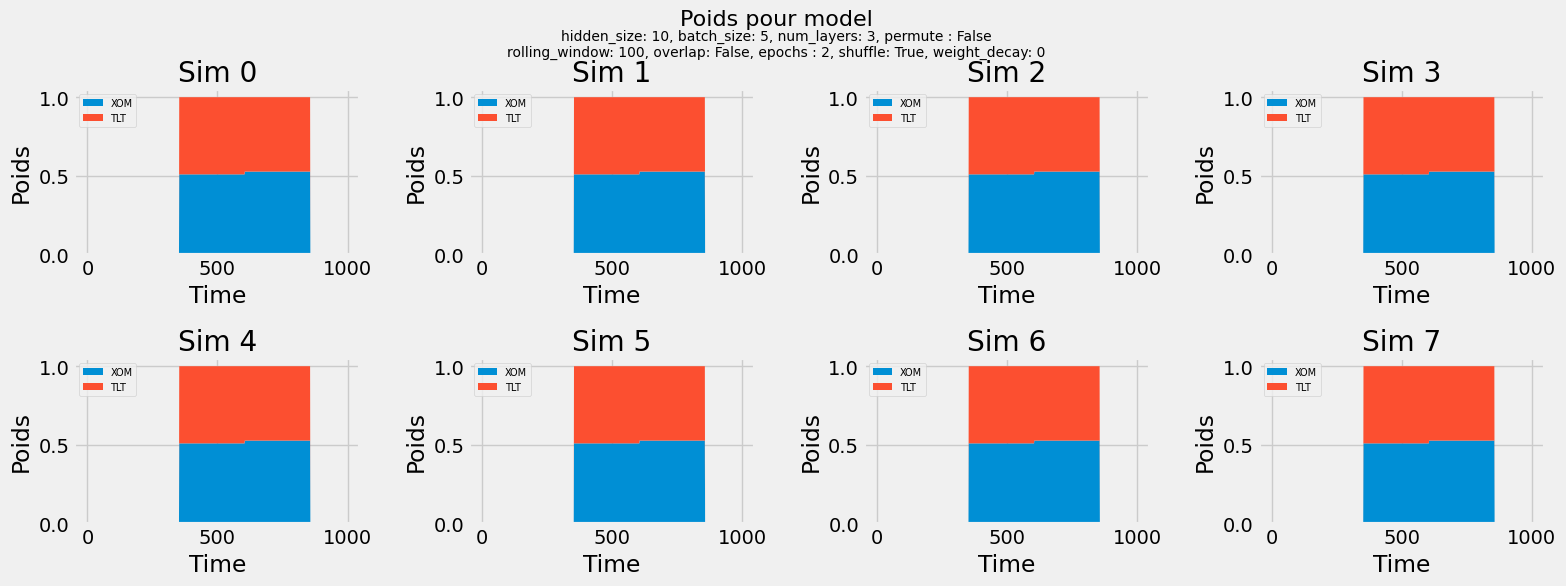

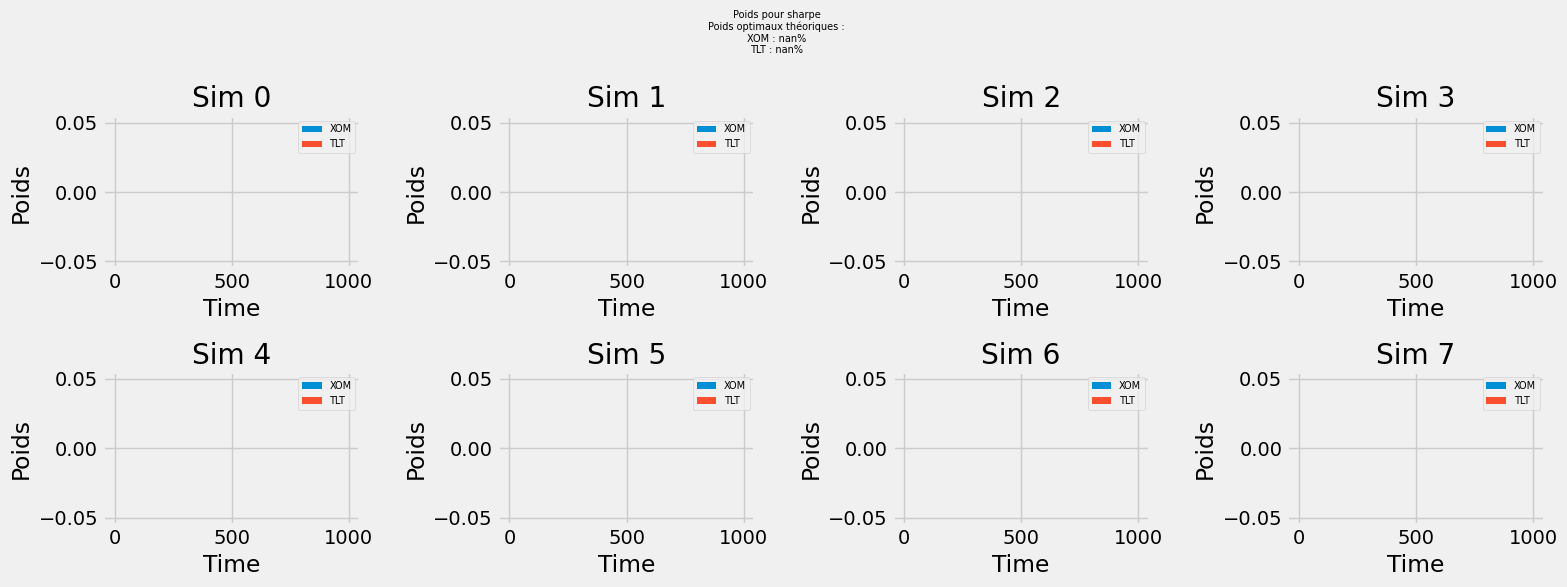

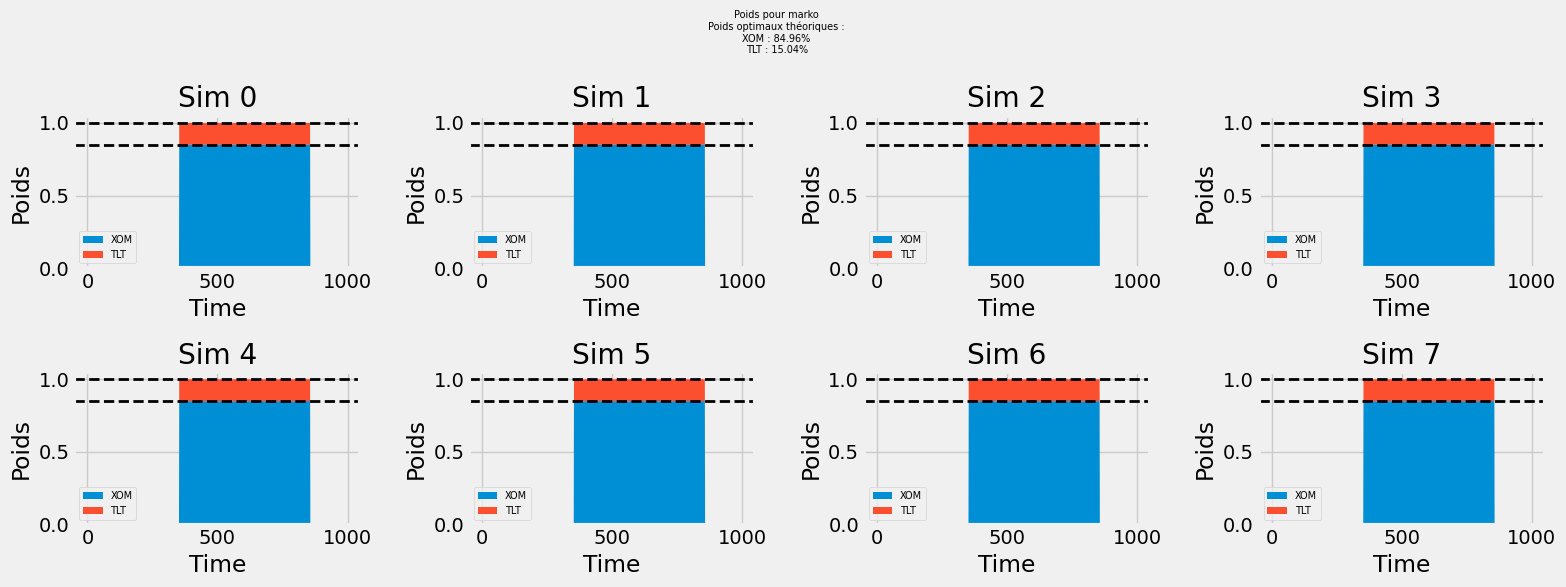

In [ ]:
trainer.plot_weights(type_w='model', th_weights='sharpe')
trainer.plot_weights(type_w='sharpe', th_weights='sharpe')
trainer.plot_weights(type_w='marko', th_weights='marko')

## Test avec 3 actifs et matrice de cov 0,0,0

## Extracting Mean and Cov

In [12]:
financial_dataset = FinancialDataset(tickers=["XOM", "TLT", "GLD"], synthetic=True, n_simul=2000, n_synthetic=700)

[*********************100%***********************]  3 of 3 completed


In [13]:
returns = financial_dataset._raw_data['returns'].values

mean_th = returns.mean(axis=0)
cov_th = np.cov(returns, rowvar=False)

In [14]:
mean_th

array([0.00037681, 0.00031588, 0.00016635])

In [15]:
cov_th

array([[ 1.35957835e-04,  1.49690254e-05,  2.02862081e-05],
       [ 1.49690254e-05,  8.39155701e-05, -5.52690641e-05],
       [ 2.02862081e-05, -5.52690641e-05,  2.79139829e-04]])

In [ ]:
cov_th = np.array([[ 0,  0,  0],
       [ 0,  0, 0],
       [ 0, 0,  0]])

In [ ]:
financial_dataset = FinancialDataset(tickers=["XOM", "TLT", "GLD"], synthetic=True, n_simul=20, n_synthetic=1000, mean=mean_th, cov=cov_th)

[*********************100%***********************]  2 of 2 completed


In [ ]:
data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=1,
    retrain_years=1,
    rolling_window=100,
    batch_size=5,
    overlap=False,
    shuffle=True,
    on_synthetic=True
)

trainer = PortfolioTrainer(
    model=NN_Sharpe(input_size=data_handler.n_assets,
                    hidden_size=10,
                    num_layers=3,
                    
                    output_size=data_handler.n_assets,
                    temperature=1),
    
    data_handler=data_handler,
    device='cpu',
    epochs=2,
    lr=0.001,
    weight_decay=0,
    permute_assets=False
)

version 6


/usr/local/lib/python3.12/site-packages/src/markowitz.py:98: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  risk    = torch.sqrt(weights.T@cov_matrix@weights + 1e-8)


version 6


In [ ]:
trainer.train(compute_marko_weights=['sharpe_torch' , 'marko_torch'])

Training period from 101 to 353
Investment period from 353 to 605


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


-1690.4682267506917
torch.Size([5040, 100, 2])
2016 8 605 353


  0%|          | 0/2016 [00:00<?, ?it/s]

version 5
version 5


  0%|          | 1/2016 [00:01<37:32,  1.12s/it]

version 5
version 5


  0%|          | 2/2016 [00:02<37:36,  1.12s/it]

version 5
version 5


  0%|          | 3/2016 [00:03<37:47,  1.13s/it]

version 5
version 5


  0%|          | 4/2016 [00:04<37:00,  1.10s/it]

version 5
version 5


  0%|          | 5/2016 [00:05<36:58,  1.10s/it]

version 5
version 5


  0%|          | 6/2016 [00:06<36:24,  1.09s/it]

version 5
version 5


  0%|          | 7/2016 [00:07<36:11,  1.08s/it]

version 5
version 5


  0%|          | 8/2016 [00:08<35:57,  1.07s/it]

version 5
version 5


  0%|          | 9/2016 [00:09<35:41,  1.07s/it]

version 5
version 5


  0%|          | 10/2016 [00:10<35:28,  1.06s/it]

version 5
version 5


  1%|          | 11/2016 [00:11<35:35,  1.06s/it]

version 5
version 5


  1%|          | 12/2016 [00:12<35:31,  1.06s/it]

version 5
version 5


  1%|          | 13/2016 [00:14<35:29,  1.06s/it]

version 5
version 5


  1%|          | 14/2016 [00:15<35:35,  1.07s/it]

version 5
version 5


  1%|          | 15/2016 [00:16<35:46,  1.07s/it]

version 5
version 5


  1%|          | 16/2016 [00:17<35:45,  1.07s/it]

version 5
version 5


  1%|          | 17/2016 [00:18<35:41,  1.07s/it]

version 5
version 5


  1%|          | 18/2016 [00:19<35:33,  1.07s/it]

version 5
version 5


  1%|          | 19/2016 [00:20<35:29,  1.07s/it]

version 5
version 5


  1%|          | 20/2016 [00:21<35:26,  1.07s/it]

version 5
version 5


  1%|          | 21/2016 [00:22<33:09,  1.00it/s]

version 5
version 5


  1%|          | 22/2016 [00:23<31:40,  1.05it/s]

version 5
version 5


  1%|          | 23/2016 [00:24<30:30,  1.09it/s]

version 5
version 5


  1%|          | 24/2016 [00:24<29:38,  1.12it/s]

version 5
version 5


  1%|          | 25/2016 [00:25<30:39,  1.08it/s]

version 5
version 5


  1%|▏         | 26/2016 [00:26<31:42,  1.05it/s]

version 5
version 5


  1%|▏         | 27/2016 [00:27<32:31,  1.02it/s]

version 5
version 5


  1%|▏         | 28/2016 [00:28<33:16,  1.00s/it]

version 5
version 5


  1%|▏         | 29/2016 [00:30<33:50,  1.02s/it]

version 5
version 5


  1%|▏         | 30/2016 [00:31<34:16,  1.04s/it]

version 5
version 5


  2%|▏         | 31/2016 [00:32<34:26,  1.04s/it]

version 5
version 5


  2%|▏         | 32/2016 [00:33<34:26,  1.04s/it]

version 5
version 5


  2%|▏         | 33/2016 [00:34<34:19,  1.04s/it]

version 5
version 5


  2%|▏         | 34/2016 [00:35<34:27,  1.04s/it]

version 5
version 5


  2%|▏         | 35/2016 [00:36<34:25,  1.04s/it]

version 5
version 5


  2%|▏         | 36/2016 [00:37<33:45,  1.02s/it]

version 5
version 5


  2%|▏         | 37/2016 [00:38<31:59,  1.03it/s]

version 5
version 5


  2%|▏         | 38/2016 [00:39<30:43,  1.07it/s]

version 5
version 5


  2%|▏         | 39/2016 [00:39<29:53,  1.10it/s]

version 5
version 5


  2%|▏         | 40/2016 [00:40<29:18,  1.12it/s]

version 5
version 5


  2%|▏         | 41/2016 [00:41<28:47,  1.14it/s]

version 5
version 5


  2%|▏         | 42/2016 [00:42<28:21,  1.16it/s]

version 5
version 5


  2%|▏         | 43/2016 [00:43<28:08,  1.17it/s]

version 5
version 5


  2%|▏         | 44/2016 [00:44<27:50,  1.18it/s]

version 5
version 5


  2%|▏         | 45/2016 [00:44<27:34,  1.19it/s]

version 5
version 5


  2%|▏         | 46/2016 [00:45<27:26,  1.20it/s]

version 5
version 5


  2%|▏         | 47/2016 [00:46<27:20,  1.20it/s]

version 5
version 5


  2%|▏         | 48/2016 [00:47<27:15,  1.20it/s]

version 5
version 5


  2%|▏         | 49/2016 [00:48<27:19,  1.20it/s]

version 5
version 5


  2%|▏         | 50/2016 [00:49<27:17,  1.20it/s]

version 5
version 5


  3%|▎         | 51/2016 [00:49<27:20,  1.20it/s]

version 5
version 5


  3%|▎         | 52/2016 [00:50<27:25,  1.19it/s]

version 5
version 5


  3%|▎         | 53/2016 [00:51<27:22,  1.19it/s]

version 5
version 5


  3%|▎         | 54/2016 [00:52<27:16,  1.20it/s]

version 5
version 5


  3%|▎         | 55/2016 [00:53<27:12,  1.20it/s]

version 5
version 5


  3%|▎         | 56/2016 [00:54<27:11,  1.20it/s]

version 5
version 5


  3%|▎         | 57/2016 [00:54<27:06,  1.20it/s]

version 5
version 5


  3%|▎         | 58/2016 [00:55<27:01,  1.21it/s]

version 5
version 5


  3%|▎         | 59/2016 [00:56<26:56,  1.21it/s]

version 5
version 5


  3%|▎         | 60/2016 [00:57<26:53,  1.21it/s]

version 5
version 5


  3%|▎         | 61/2016 [00:58<29:16,  1.11it/s]

version 5
version 5


  3%|▎         | 62/2016 [00:59<31:01,  1.05it/s]

version 5
version 5


  3%|▎         | 63/2016 [01:00<31:57,  1.02it/s]

version 5
version 5


  3%|▎         | 64/2016 [01:01<31:17,  1.04it/s]

version 5
version 5


  3%|▎         | 65/2016 [01:02<30:13,  1.08it/s]

version 5
version 5


  3%|▎         | 66/2016 [01:03<29:58,  1.08it/s]

version 5
version 5


  3%|▎         | 67/2016 [01:04<29:16,  1.11it/s]

version 5
version 5


  3%|▎         | 68/2016 [01:04<28:39,  1.13it/s]

version 5
version 5


  3%|▎         | 69/2016 [01:05<28:15,  1.15it/s]

version 5
version 5


  3%|▎         | 70/2016 [01:06<28:11,  1.15it/s]

version 5
version 5


  4%|▎         | 71/2016 [01:07<28:12,  1.15it/s]

version 5
version 5


  4%|▎         | 72/2016 [01:08<27:54,  1.16it/s]

version 5
version 5


  4%|▎         | 73/2016 [01:09<27:44,  1.17it/s]

version 5
version 5


  4%|▎         | 74/2016 [01:10<29:58,  1.08it/s]

version 5
version 5


  4%|▎         | 75/2016 [01:11<31:13,  1.04it/s]

version 5
version 5


  4%|▍         | 76/2016 [01:12<31:57,  1.01it/s]

version 5
version 5


  4%|▍         | 77/2016 [01:13<32:31,  1.01s/it]

version 5
version 5


  4%|▍         | 78/2016 [01:14<32:59,  1.02s/it]

version 5
version 5


  4%|▍         | 79/2016 [01:15<32:25,  1.00s/it]

version 5
version 5


  4%|▍         | 80/2016 [01:16<30:47,  1.05it/s]

version 5
version 5


  4%|▍         | 81/2016 [01:17<29:37,  1.09it/s]

version 5
version 5


  4%|▍         | 82/2016 [01:17<28:51,  1.12it/s]

version 5
version 5


  4%|▍         | 83/2016 [01:18<28:25,  1.13it/s]

version 5
version 5


  4%|▍         | 84/2016 [01:19<28:09,  1.14it/s]

version 5
version 5


  4%|▍         | 85/2016 [01:20<27:56,  1.15it/s]

version 5
version 5


  4%|▍         | 86/2016 [01:21<27:40,  1.16it/s]

version 5
version 5


  4%|▍         | 87/2016 [01:22<27:23,  1.17it/s]

version 5
version 5


  4%|▍         | 88/2016 [01:23<27:16,  1.18it/s]

version 5
version 5


  4%|▍         | 89/2016 [01:23<27:22,  1.17it/s]

version 5
version 5


  4%|▍         | 90/2016 [01:24<27:27,  1.17it/s]

version 5
version 5


  5%|▍         | 91/2016 [01:25<27:31,  1.17it/s]

version 5
version 5


  5%|▍         | 92/2016 [01:26<27:25,  1.17it/s]

version 5
version 5


  5%|▍         | 93/2016 [01:27<27:15,  1.18it/s]

version 5
version 5


  5%|▍         | 94/2016 [01:28<27:03,  1.18it/s]

version 5
version 5


  5%|▍         | 95/2016 [01:28<26:58,  1.19it/s]

version 5
version 5


  5%|▍         | 96/2016 [01:29<28:42,  1.11it/s]

version 5
version 5


  5%|▍         | 97/2016 [01:31<30:20,  1.05it/s]

version 5
version 5


  5%|▍         | 98/2016 [01:32<31:13,  1.02it/s]

version 5
version 5


  5%|▍         | 99/2016 [01:33<32:01,  1.00s/it]

version 5
version 5


  5%|▍         | 100/2016 [01:34<32:35,  1.02s/it]

version 5
version 5


  5%|▌         | 101/2016 [01:35<32:52,  1.03s/it]

version 5
version 5


  5%|▌         | 102/2016 [01:36<32:55,  1.03s/it]

version 5
version 5


  5%|▌         | 103/2016 [01:37<33:14,  1.04s/it]

version 5
version 5


  5%|▌         | 104/2016 [01:38<33:15,  1.04s/it]

version 5
version 5


  5%|▌         | 105/2016 [01:39<33:23,  1.05s/it]

version 5
version 5


  5%|▌         | 106/2016 [01:40<33:31,  1.05s/it]

version 5
version 5


  5%|▌         | 107/2016 [01:41<33:31,  1.05s/it]

version 5
version 5


  5%|▌         | 108/2016 [01:42<33:13,  1.04s/it]

version 5
version 5


  5%|▌         | 109/2016 [01:43<33:04,  1.04s/it]

version 5
version 5


  5%|▌         | 110/2016 [01:44<33:01,  1.04s/it]

version 5
version 5


  6%|▌         | 111/2016 [01:45<32:57,  1.04s/it]

version 5
version 5


  6%|▌         | 112/2016 [01:46<32:51,  1.04s/it]

version 5
version 5


  6%|▌         | 113/2016 [01:47<32:45,  1.03s/it]

version 5
version 5


  6%|▌         | 114/2016 [01:48<32:55,  1.04s/it]

version 5
version 5


  6%|▌         | 115/2016 [01:49<32:24,  1.02s/it]

version 5
version 5


  6%|▌         | 116/2016 [01:50<30:37,  1.03it/s]

version 5
version 5


  6%|▌         | 117/2016 [01:51<29:20,  1.08it/s]

version 5
version 5


  6%|▌         | 118/2016 [01:52<28:19,  1.12it/s]

version 5
version 5


  6%|▌         | 119/2016 [01:53<29:59,  1.05it/s]

version 5
version 5


  6%|▌         | 120/2016 [01:54<30:52,  1.02it/s]

version 5
version 5


  6%|▌         | 121/2016 [01:55<31:29,  1.00it/s]

version 5
version 5


  6%|▌         | 122/2016 [01:56<31:54,  1.01s/it]

version 5
version 5


  6%|▌         | 123/2016 [01:57<32:16,  1.02s/it]

version 5
version 5


  6%|▌         | 124/2016 [01:58<32:39,  1.04s/it]

version 5
version 5


  6%|▌         | 125/2016 [01:59<32:49,  1.04s/it]

version 5
version 5


  6%|▋         | 126/2016 [02:00<32:54,  1.04s/it]

version 5
version 5


  6%|▋         | 127/2016 [02:01<32:52,  1.04s/it]

version 5
version 5


  6%|▋         | 128/2016 [02:02<32:47,  1.04s/it]

version 5
version 5


  6%|▋         | 129/2016 [02:03<30:43,  1.02it/s]

version 5
version 5


  6%|▋         | 130/2016 [02:04<30:00,  1.05it/s]

version 5
version 5


  6%|▋         | 131/2016 [02:05<30:53,  1.02it/s]

version 5
version 5


  7%|▋         | 132/2016 [02:06<31:34,  1.01s/it]

version 5
version 5


  7%|▋         | 133/2016 [02:07<32:14,  1.03s/it]

version 5
version 5


  7%|▋         | 134/2016 [02:08<32:37,  1.04s/it]

version 5
version 5


  7%|▋         | 135/2016 [02:09<32:12,  1.03s/it]

version 5
version 5


  7%|▋         | 136/2016 [02:10<30:26,  1.03it/s]

version 5
version 5


  7%|▋         | 137/2016 [02:11<29:18,  1.07it/s]

version 5
version 5


  7%|▋         | 138/2016 [02:12<28:21,  1.10it/s]

version 5
version 5


  7%|▋         | 139/2016 [02:13<27:41,  1.13it/s]

version 5
version 5


  7%|▋         | 140/2016 [02:13<27:10,  1.15it/s]

version 5
version 5


  7%|▋         | 141/2016 [02:14<26:49,  1.17it/s]

version 5
version 5


  7%|▋         | 142/2016 [02:15<26:46,  1.17it/s]

version 5
version 5


  7%|▋         | 143/2016 [02:16<26:43,  1.17it/s]

version 5
version 5


  7%|▋         | 144/2016 [02:17<28:03,  1.11it/s]

version 5
version 5


  7%|▋         | 145/2016 [02:18<29:30,  1.06it/s]

version 5
version 5


  7%|▋         | 146/2016 [02:19<30:30,  1.02it/s]

version 5
version 5


  7%|▋         | 147/2016 [02:20<31:18,  1.00s/it]

version 5
version 5


  7%|▋         | 148/2016 [02:21<30:50,  1.01it/s]

version 5
version 5


  7%|▋         | 149/2016 [02:22<29:24,  1.06it/s]

version 5
version 5


  7%|▋         | 150/2016 [02:23<28:25,  1.09it/s]

version 5
version 5


  7%|▋         | 151/2016 [02:24<27:56,  1.11it/s]

version 5
version 5


  8%|▊         | 152/2016 [02:25<27:22,  1.13it/s]

version 5
version 5


  8%|▊         | 153/2016 [02:26<29:03,  1.07it/s]

version 5
version 5


  8%|▊         | 154/2016 [02:26<28:24,  1.09it/s]

version 5
version 5


  8%|▊         | 155/2016 [02:27<27:48,  1.12it/s]

version 5
version 5


  8%|▊         | 156/2016 [02:28<29:22,  1.06it/s]

version 5
version 5


  8%|▊         | 157/2016 [02:29<30:16,  1.02it/s]

version 5
version 5


  8%|▊         | 158/2016 [02:30<30:55,  1.00it/s]

version 5
version 5


  8%|▊         | 159/2016 [02:31<29:31,  1.05it/s]

version 5
version 5


  8%|▊         | 160/2016 [02:32<30:13,  1.02it/s]

version 5
version 5


  8%|▊         | 161/2016 [02:33<31:03,  1.00s/it]

version 5
version 5


  8%|▊         | 162/2016 [02:35<31:40,  1.02s/it]

version 5
version 5


  8%|▊         | 163/2016 [02:36<31:53,  1.03s/it]

version 5
version 5


  8%|▊         | 164/2016 [02:37<32:10,  1.04s/it]

version 5
version 5


  8%|▊         | 165/2016 [02:38<32:29,  1.05s/it]

version 5
version 5


  8%|▊         | 166/2016 [02:39<32:40,  1.06s/it]

version 5
version 5


  8%|▊         | 167/2016 [02:40<32:47,  1.06s/it]

version 5
version 5


  8%|▊         | 168/2016 [02:41<32:45,  1.06s/it]

version 5
version 5


  8%|▊         | 169/2016 [02:42<31:50,  1.03s/it]

version 5
version 5


  8%|▊         | 170/2016 [02:43<31:36,  1.03s/it]

version 5
version 5


  8%|▊         | 171/2016 [02:44<31:51,  1.04s/it]

version 5
version 5


  9%|▊         | 172/2016 [02:45<32:04,  1.04s/it]

version 5
version 5


  9%|▊         | 173/2016 [02:46<32:12,  1.05s/it]

version 5
version 5


  9%|▊         | 174/2016 [02:47<31:49,  1.04s/it]

version 5
version 5


  9%|▊         | 175/2016 [02:48<30:05,  1.02it/s]

version 5
version 5


  9%|▊         | 176/2016 [02:49<28:59,  1.06it/s]

version 5
version 5


  9%|▉         | 177/2016 [02:50<28:15,  1.08it/s]

version 5
version 5


  9%|▉         | 178/2016 [02:51<27:40,  1.11it/s]

version 5
version 5


  9%|▉         | 179/2016 [02:51<27:21,  1.12it/s]

version 5
version 5


  9%|▉         | 180/2016 [02:52<26:55,  1.14it/s]

version 5
version 5


  9%|▉         | 181/2016 [02:53<26:35,  1.15it/s]

version 5
version 5


  9%|▉         | 182/2016 [02:54<26:22,  1.16it/s]

version 5
version 5


  9%|▉         | 183/2016 [02:55<26:09,  1.17it/s]

version 5
version 5


  9%|▉         | 184/2016 [02:56<27:50,  1.10it/s]

version 5
version 5


  9%|▉         | 185/2016 [02:57<29:08,  1.05it/s]

version 5
version 5


  9%|▉         | 186/2016 [02:58<30:00,  1.02it/s]

version 5
version 5


  9%|▉         | 187/2016 [02:59<29:29,  1.03it/s]

version 5
version 5


  9%|▉         | 188/2016 [03:00<28:36,  1.06it/s]

version 5
version 5


  9%|▉         | 189/2016 [03:01<27:47,  1.10it/s]

version 5
version 5


  9%|▉         | 190/2016 [03:02<28:58,  1.05it/s]

version 5
version 5


  9%|▉         | 191/2016 [03:03<29:59,  1.01it/s]

version 5
version 5


 10%|▉         | 192/2016 [03:04<30:34,  1.01s/it]

version 5
version 5


 10%|▉         | 193/2016 [03:05<31:00,  1.02s/it]

version 5
version 5


 10%|▉         | 194/2016 [03:06<31:29,  1.04s/it]

version 5
version 5


 10%|▉         | 195/2016 [03:07<31:41,  1.04s/it]

version 5
version 5


 10%|▉         | 196/2016 [03:08<31:46,  1.05s/it]

version 5
version 5


 10%|▉         | 197/2016 [03:09<32:06,  1.06s/it]

version 5
version 5


 10%|▉         | 198/2016 [03:10<32:11,  1.06s/it]

version 5
version 5


 10%|▉         | 199/2016 [03:11<32:05,  1.06s/it]

version 5
version 5


 10%|▉         | 200/2016 [03:12<32:07,  1.06s/it]

version 5
version 5


 10%|▉         | 201/2016 [03:13<31:31,  1.04s/it]

version 5
version 5


 10%|█         | 202/2016 [03:14<30:50,  1.02s/it]

version 5
version 5


 10%|█         | 203/2016 [03:15<29:34,  1.02it/s]

version 5
version 5


 10%|█         | 204/2016 [03:16<28:28,  1.06it/s]

version 5
version 5


 10%|█         | 205/2016 [03:17<27:37,  1.09it/s]

version 5
version 5


 10%|█         | 206/2016 [03:18<26:57,  1.12it/s]

version 5
version 5


 10%|█         | 207/2016 [03:19<26:33,  1.14it/s]

version 5
version 5


 10%|█         | 208/2016 [03:19<26:23,  1.14it/s]

version 5
version 5


 10%|█         | 209/2016 [03:20<26:08,  1.15it/s]

version 5
version 5


 10%|█         | 210/2016 [03:21<26:07,  1.15it/s]

version 5
version 5


 10%|█         | 211/2016 [03:22<25:56,  1.16it/s]

version 5
version 5


 11%|█         | 212/2016 [03:23<25:47,  1.17it/s]

version 5
version 5


 11%|█         | 213/2016 [03:24<25:40,  1.17it/s]

version 5
version 5


 11%|█         | 214/2016 [03:25<25:40,  1.17it/s]

version 5
version 5


 11%|█         | 215/2016 [03:25<25:32,  1.17it/s]

version 5
version 5


 11%|█         | 216/2016 [03:26<25:27,  1.18it/s]

version 5
version 5


 11%|█         | 217/2016 [03:27<26:59,  1.11it/s]

version 5
version 5


 11%|█         | 218/2016 [03:28<27:58,  1.07it/s]

version 5
version 5


 11%|█         | 219/2016 [03:29<27:25,  1.09it/s]

version 5
version 5


 11%|█         | 220/2016 [03:30<27:11,  1.10it/s]

version 5
version 5


 11%|█         | 221/2016 [03:31<26:50,  1.11it/s]

version 5
version 5


 11%|█         | 222/2016 [03:32<26:27,  1.13it/s]

version 5
version 5


 11%|█         | 223/2016 [03:33<26:05,  1.15it/s]

version 5
version 5


 11%|█         | 224/2016 [03:33<25:53,  1.15it/s]

version 5
version 5


 11%|█         | 225/2016 [03:34<25:54,  1.15it/s]

version 5
version 5


 11%|█         | 226/2016 [03:35<25:53,  1.15it/s]

version 5
version 5


 11%|█▏        | 227/2016 [03:36<26:25,  1.13it/s]

version 5
version 5


 11%|█▏        | 228/2016 [03:37<27:56,  1.07it/s]

version 5
version 5


 11%|█▏        | 229/2016 [03:38<29:10,  1.02it/s]

version 5
version 5


 11%|█▏        | 230/2016 [03:39<29:54,  1.00s/it]

version 5
version 5


 11%|█▏        | 231/2016 [03:40<30:28,  1.02s/it]

version 5
version 5


 12%|█▏        | 232/2016 [03:41<30:45,  1.03s/it]

version 5
version 5


 12%|█▏        | 233/2016 [03:42<30:31,  1.03s/it]

version 5
version 5


 12%|█▏        | 234/2016 [03:43<28:56,  1.03it/s]

version 5
version 5


 12%|█▏        | 235/2016 [03:44<28:21,  1.05it/s]

version 5
version 5


 12%|█▏        | 236/2016 [03:45<27:39,  1.07it/s]

version 5
version 5


 12%|█▏        | 237/2016 [03:46<27:05,  1.09it/s]

version 5
version 5


 12%|█▏        | 238/2016 [03:47<28:11,  1.05it/s]

version 5
version 5


 12%|█▏        | 239/2016 [03:48<29:00,  1.02it/s]

version 5
version 5


 12%|█▏        | 240/2016 [03:49<29:46,  1.01s/it]

version 5
version 5


 12%|█▏        | 241/2016 [03:50<30:07,  1.02s/it]

version 5
version 5


 12%|█▏        | 242/2016 [03:51<30:29,  1.03s/it]

version 5
version 5


 12%|█▏        | 243/2016 [03:52<30:43,  1.04s/it]

version 5
version 5


 12%|█▏        | 244/2016 [03:53<30:45,  1.04s/it]

version 5
version 5


 12%|█▏        | 245/2016 [03:54<30:41,  1.04s/it]

version 5
version 5


 12%|█▏        | 246/2016 [03:55<30:36,  1.04s/it]

version 5
version 5


 12%|█▏        | 247/2016 [03:56<30:30,  1.03s/it]

version 5
version 5


 12%|█▏        | 248/2016 [03:57<30:24,  1.03s/it]

version 5
version 5


 12%|█▏        | 249/2016 [03:58<30:42,  1.04s/it]

version 5
version 5


 12%|█▏        | 250/2016 [03:59<29:20,  1.00it/s]

version 5
version 5


 12%|█▏        | 251/2016 [04:00<27:54,  1.05it/s]

version 5
version 5


 12%|█▎        | 252/2016 [04:01<26:50,  1.10it/s]

version 5
version 5


 13%|█▎        | 253/2016 [04:02<26:09,  1.12it/s]

version 5
version 5


 13%|█▎        | 254/2016 [04:03<25:28,  1.15it/s]

version 5
version 5


 13%|█▎        | 255/2016 [04:04<25:04,  1.17it/s]

version 5
version 5


 13%|█▎        | 256/2016 [04:05<26:30,  1.11it/s]

version 5
version 5


 13%|█▎        | 257/2016 [04:06<27:43,  1.06it/s]

version 5
version 5


 13%|█▎        | 258/2016 [04:07<28:40,  1.02it/s]

version 5
version 5


 13%|█▎        | 259/2016 [04:08<29:12,  1.00it/s]

version 5
version 5


 13%|█▎        | 260/2016 [04:09<30:01,  1.03s/it]

version 5
version 5


 13%|█▎        | 261/2016 [04:10<31:24,  1.07s/it]

version 5
version 5


 13%|█▎        | 262/2016 [04:11<33:03,  1.13s/it]

version 5
version 5


 13%|█▎        | 263/2016 [04:12<34:05,  1.17s/it]

version 5
version 5


 13%|█▎        | 264/2016 [04:14<33:37,  1.15s/it]

version 5
version 5


 13%|█▎        | 265/2016 [04:15<32:40,  1.12s/it]

version 5
version 5


 13%|█▎        | 266/2016 [04:16<32:36,  1.12s/it]

version 5
version 5


 13%|█▎        | 267/2016 [04:17<31:51,  1.09s/it]

version 5
version 5


 13%|█▎        | 268/2016 [04:18<31:20,  1.08s/it]

version 5
version 5


 13%|█▎        | 269/2016 [04:19<31:02,  1.07s/it]

version 5
version 5


 13%|█▎        | 270/2016 [04:20<31:16,  1.07s/it]

version 5
version 5


 13%|█▎        | 271/2016 [04:21<31:02,  1.07s/it]

version 5
version 5


 13%|█▎        | 272/2016 [04:22<30:51,  1.06s/it]

version 5
version 5


 14%|█▎        | 273/2016 [04:23<30:45,  1.06s/it]

version 5
version 5


 14%|█▎        | 274/2016 [04:24<30:41,  1.06s/it]

version 5
version 5


 14%|█▎        | 275/2016 [04:25<30:33,  1.05s/it]

version 5
version 5


 14%|█▎        | 276/2016 [04:26<30:22,  1.05s/it]

version 5
version 5


 14%|█▎        | 277/2016 [04:27<29:10,  1.01s/it]

version 5
version 5


 14%|█▍        | 278/2016 [04:28<28:45,  1.01it/s]

version 5
version 5


 14%|█▍        | 279/2016 [04:29<29:16,  1.01s/it]

version 5
version 5


 14%|█▍        | 280/2016 [04:30<29:34,  1.02s/it]

version 5
version 5


 14%|█▍        | 281/2016 [04:31<28:39,  1.01it/s]

version 5
version 5


 14%|█▍        | 282/2016 [04:32<27:25,  1.05it/s]

version 5
version 5


 14%|█▍        | 283/2016 [04:33<26:27,  1.09it/s]

version 5
version 5


 14%|█▍        | 284/2016 [04:34<25:49,  1.12it/s]

version 5
version 5


 14%|█▍        | 285/2016 [04:35<25:30,  1.13it/s]

version 5
version 5


 14%|█▍        | 286/2016 [04:35<25:07,  1.15it/s]

version 5
version 5


 14%|█▍        | 287/2016 [04:36<24:59,  1.15it/s]

version 5
version 5


 14%|█▍        | 288/2016 [04:37<24:54,  1.16it/s]

version 5
version 5


 14%|█▍        | 289/2016 [04:38<24:40,  1.17it/s]

version 5
version 5


 14%|█▍        | 290/2016 [04:39<25:21,  1.13it/s]

version 5
version 5


 14%|█▍        | 291/2016 [04:40<27:00,  1.06it/s]

version 5
version 5


 14%|█▍        | 292/2016 [04:41<28:00,  1.03it/s]

version 5
version 5


 15%|█▍        | 293/2016 [04:42<28:35,  1.00it/s]

version 5
version 5


 15%|█▍        | 294/2016 [04:43<29:09,  1.02s/it]

version 5
version 5


 15%|█▍        | 295/2016 [04:44<29:29,  1.03s/it]

version 5
version 5


 15%|█▍        | 296/2016 [04:45<31:00,  1.08s/it]

version 5
version 5


 15%|█▍        | 297/2016 [04:47<32:29,  1.13s/it]

version 5
version 5


 15%|█▍        | 298/2016 [04:48<33:32,  1.17s/it]

version 5
version 5


 15%|█▍        | 299/2016 [04:49<34:18,  1.20s/it]

version 5
version 5


 15%|█▍        | 300/2016 [04:50<33:01,  1.15s/it]

version 5
version 5


 15%|█▍        | 301/2016 [04:51<32:08,  1.12s/it]

version 5
version 5


 15%|█▍        | 302/2016 [04:52<31:23,  1.10s/it]

version 5
version 5


 15%|█▌        | 303/2016 [04:53<30:50,  1.08s/it]

version 5
version 5


 15%|█▌        | 304/2016 [04:54<30:32,  1.07s/it]

version 5
version 5


 15%|█▌        | 305/2016 [04:55<30:15,  1.06s/it]

version 5
version 5


 15%|█▌        | 306/2016 [04:56<29:43,  1.04s/it]

version 5
version 5


 15%|█▌        | 307/2016 [04:57<27:57,  1.02it/s]

version 5
version 5


 15%|█▌        | 308/2016 [04:58<26:54,  1.06it/s]

version 5
version 5


 15%|█▌        | 309/2016 [04:59<27:45,  1.02it/s]

version 5
version 5


 15%|█▌        | 310/2016 [05:00<28:29,  1.00s/it]

version 5
version 5


 15%|█▌        | 311/2016 [05:01<28:50,  1.02s/it]

version 5
version 5


 15%|█▌        | 312/2016 [05:02<29:02,  1.02s/it]

version 5
version 5


 16%|█▌        | 313/2016 [05:03<29:13,  1.03s/it]

version 5
version 5


 16%|█▌        | 314/2016 [05:04<29:45,  1.05s/it]

version 5
version 5


 16%|█▌        | 315/2016 [05:05<29:42,  1.05s/it]

version 5
version 5


 16%|█▌        | 316/2016 [05:07<29:41,  1.05s/it]

version 5
version 5


 16%|█▌        | 317/2016 [05:08<29:43,  1.05s/it]

version 5
version 5


 16%|█▌        | 318/2016 [05:09<29:42,  1.05s/it]

version 5
version 5


 16%|█▌        | 319/2016 [05:10<29:47,  1.05s/it]

version 5
version 5


 16%|█▌        | 320/2016 [05:11<29:44,  1.05s/it]

version 5
version 5


 16%|█▌        | 321/2016 [05:12<29:51,  1.06s/it]

version 5
version 5


 16%|█▌        | 322/2016 [05:13<29:56,  1.06s/it]

version 5
version 5


 16%|█▌        | 323/2016 [05:14<29:53,  1.06s/it]

version 5
version 5


 16%|█▌        | 324/2016 [05:15<29:51,  1.06s/it]

version 5
version 5


 16%|█▌        | 325/2016 [05:16<30:02,  1.07s/it]

version 5
version 5


 16%|█▌        | 326/2016 [05:17<29:49,  1.06s/it]

version 5
version 5


 16%|█▌        | 327/2016 [05:18<29:50,  1.06s/it]

version 5
version 5


 16%|█▋        | 328/2016 [05:19<29:50,  1.06s/it]

version 5
version 5


 16%|█▋        | 329/2016 [05:20<30:01,  1.07s/it]

version 5
version 5


 16%|█▋        | 330/2016 [05:21<29:53,  1.06s/it]

version 5
version 5


 16%|█▋        | 331/2016 [05:22<29:43,  1.06s/it]

version 5
version 5


 16%|█▋        | 332/2016 [05:23<29:47,  1.06s/it]

version 5
version 5


 17%|█▋        | 333/2016 [05:25<29:39,  1.06s/it]

version 5
version 5


 17%|█▋        | 334/2016 [05:26<29:24,  1.05s/it]

version 5
version 5


 17%|█▋        | 335/2016 [05:27<29:21,  1.05s/it]

version 5
version 5


 17%|█▋        | 336/2016 [05:28<29:15,  1.04s/it]

version 5
version 5


 17%|█▋        | 337/2016 [05:29<29:29,  1.05s/it]

version 5
version 5


 17%|█▋        | 338/2016 [05:30<28:41,  1.03s/it]

version 5
version 5


 17%|█▋        | 339/2016 [05:31<29:27,  1.05s/it]

version 5
version 5


 17%|█▋        | 340/2016 [05:32<31:04,  1.11s/it]

version 5
version 5


 17%|█▋        | 341/2016 [05:33<32:01,  1.15s/it]

version 5
version 5


 17%|█▋        | 342/2016 [05:35<32:48,  1.18s/it]

version 5
version 5


 17%|█▋        | 343/2016 [05:36<32:39,  1.17s/it]

version 5
version 5


 17%|█▋        | 344/2016 [05:37<29:46,  1.07s/it]

version 5
version 5


 17%|█▋        | 345/2016 [05:37<27:43,  1.00it/s]

version 5
version 5


 17%|█▋        | 346/2016 [05:38<26:52,  1.04it/s]

version 5
version 5


 17%|█▋        | 347/2016 [05:39<27:29,  1.01it/s]

version 5
version 5


 17%|█▋        | 348/2016 [05:40<28:02,  1.01s/it]

version 5
version 5


 17%|█▋        | 349/2016 [05:41<28:39,  1.03s/it]

version 5
version 5


 17%|█▋        | 350/2016 [05:42<28:43,  1.03s/it]

version 5
version 5


 17%|█▋        | 351/2016 [05:44<28:46,  1.04s/it]

version 5
version 5


 17%|█▋        | 352/2016 [05:45<28:51,  1.04s/it]

version 5
version 5


 18%|█▊        | 353/2016 [05:46<28:47,  1.04s/it]

version 5
version 5


 18%|█▊        | 354/2016 [05:47<28:48,  1.04s/it]

version 5
version 5


 18%|█▊        | 355/2016 [05:48<28:48,  1.04s/it]

version 5
version 5


 18%|█▊        | 356/2016 [05:49<28:48,  1.04s/it]

version 5
version 5


 18%|█▊        | 357/2016 [05:50<28:53,  1.04s/it]

version 5
version 5


 18%|█▊        | 358/2016 [05:51<29:02,  1.05s/it]

version 5
version 5


 18%|█▊        | 359/2016 [05:52<28:55,  1.05s/it]

version 5
version 5


 18%|█▊        | 360/2016 [05:53<28:48,  1.04s/it]

version 5
version 5


 18%|█▊        | 361/2016 [05:54<28:48,  1.04s/it]

version 5
version 5


 18%|█▊        | 362/2016 [05:55<28:46,  1.04s/it]

version 5
version 5


 18%|█▊        | 363/2016 [05:56<28:42,  1.04s/it]

version 5
version 5


 18%|█▊        | 364/2016 [05:57<28:39,  1.04s/it]

version 5
version 5


 18%|█▊        | 365/2016 [05:58<28:47,  1.05s/it]

version 5
version 5


 18%|█▊        | 366/2016 [05:59<29:09,  1.06s/it]

version 5
version 5


 18%|█▊        | 367/2016 [06:00<29:05,  1.06s/it]

version 5
version 5


 18%|█▊        | 368/2016 [06:01<29:03,  1.06s/it]

version 5
version 5


 18%|█▊        | 369/2016 [06:02<28:54,  1.05s/it]

version 5
version 5


 18%|█▊        | 370/2016 [06:03<28:40,  1.05s/it]

version 5
version 5


 18%|█▊        | 371/2016 [06:05<29:12,  1.07s/it]

version 5
version 5


 18%|█▊        | 372/2016 [06:06<29:00,  1.06s/it]

version 5
version 5


 19%|█▊        | 373/2016 [06:07<28:47,  1.05s/it]

version 5
version 5


 19%|█▊        | 374/2016 [06:08<28:41,  1.05s/it]

version 5
version 5


 19%|█▊        | 375/2016 [06:09<28:44,  1.05s/it]

version 5
version 5


 19%|█▊        | 376/2016 [06:10<29:00,  1.06s/it]

version 5
version 5


 19%|█▊        | 377/2016 [06:11<28:47,  1.05s/it]

version 5
version 5


 19%|█▉        | 378/2016 [06:12<28:36,  1.05s/it]

version 5
version 5


 19%|█▉        | 379/2016 [06:13<28:35,  1.05s/it]

version 5
version 5


 19%|█▉        | 380/2016 [06:14<28:34,  1.05s/it]

version 5
version 5


 19%|█▉        | 381/2016 [06:15<28:34,  1.05s/it]

version 5
version 5


 19%|█▉        | 382/2016 [06:16<28:22,  1.04s/it]

version 5
version 5


 19%|█▉        | 383/2016 [06:17<28:13,  1.04s/it]

version 5
version 5


 19%|█▉        | 384/2016 [06:18<28:14,  1.04s/it]

version 5
version 5


 19%|█▉        | 385/2016 [06:19<28:14,  1.04s/it]

version 5
version 5


 19%|█▉        | 386/2016 [06:20<26:52,  1.01it/s]

version 5
version 5


 19%|█▉        | 387/2016 [06:21<25:32,  1.06it/s]

version 5
version 5


 19%|█▉        | 388/2016 [06:22<24:39,  1.10it/s]

version 5
version 5


 19%|█▉        | 389/2016 [06:23<24:04,  1.13it/s]

version 5
version 5


 19%|█▉        | 390/2016 [06:23<23:34,  1.15it/s]

version 5
version 5


 19%|█▉        | 391/2016 [06:24<23:10,  1.17it/s]

version 5
version 5


 19%|█▉        | 392/2016 [06:25<22:56,  1.18it/s]

version 5
version 5


 19%|█▉        | 393/2016 [06:26<22:35,  1.20it/s]

version 5
version 5


 20%|█▉        | 394/2016 [06:27<22:27,  1.20it/s]

version 5
version 5


 20%|█▉        | 395/2016 [06:27<22:22,  1.21it/s]

version 5
version 5


 20%|█▉        | 396/2016 [06:28<22:58,  1.18it/s]

version 5
version 5


 20%|█▉        | 397/2016 [06:29<24:37,  1.10it/s]

version 5
version 5


 20%|█▉        | 398/2016 [06:30<25:43,  1.05it/s]

version 5
version 5


 20%|█▉        | 399/2016 [06:31<26:25,  1.02it/s]

version 5
version 5


 20%|█▉        | 400/2016 [06:33<26:51,  1.00it/s]

version 5
version 5


 20%|█▉        | 401/2016 [06:34<27:10,  1.01s/it]

version 5
version 5


 20%|█▉        | 402/2016 [06:35<27:20,  1.02s/it]

version 5
version 5


 20%|█▉        | 403/2016 [06:36<27:31,  1.02s/it]

version 5
version 5


 20%|██        | 404/2016 [06:37<27:38,  1.03s/it]

version 5
version 5


 20%|██        | 405/2016 [06:38<27:40,  1.03s/it]

version 5
version 5


 20%|██        | 406/2016 [06:39<26:54,  1.00s/it]

version 5
version 5


 20%|██        | 407/2016 [06:40<26:08,  1.03it/s]

version 5
version 5


 20%|██        | 408/2016 [06:41<26:51,  1.00s/it]

version 5
version 5


 20%|██        | 409/2016 [06:42<27:11,  1.02s/it]

version 5
version 5


 20%|██        | 410/2016 [06:43<27:16,  1.02s/it]

version 5
version 5


 20%|██        | 411/2016 [06:44<27:35,  1.03s/it]

version 5
version 5


 20%|██        | 412/2016 [06:45<27:40,  1.04s/it]

version 5
version 5


 20%|██        | 413/2016 [06:46<27:43,  1.04s/it]

version 5
version 5


 21%|██        | 414/2016 [06:47<27:36,  1.03s/it]

version 5
version 5


 21%|██        | 415/2016 [06:48<27:49,  1.04s/it]

version 5
version 5


 21%|██        | 416/2016 [06:49<27:42,  1.04s/it]

version 5
version 5


 21%|██        | 417/2016 [06:50<27:42,  1.04s/it]

version 5
version 5


 21%|██        | 418/2016 [06:51<27:52,  1.05s/it]

version 5
version 5


 21%|██        | 419/2016 [06:52<27:55,  1.05s/it]

version 5
version 5


 21%|██        | 420/2016 [06:53<29:33,  1.11s/it]

version 5
version 5


 21%|██        | 421/2016 [06:55<30:39,  1.15s/it]

version 5
version 5


 21%|██        | 422/2016 [06:56<30:20,  1.14s/it]

version 5
version 5


 21%|██        | 423/2016 [06:57<29:33,  1.11s/it]

version 5
version 5


 21%|██        | 424/2016 [06:58<29:02,  1.09s/it]

version 5
version 5


 21%|██        | 425/2016 [06:59<30:09,  1.14s/it]

version 5
version 5


 21%|██        | 426/2016 [07:00<31:22,  1.18s/it]

version 5
version 5


 21%|██        | 427/2016 [07:02<31:58,  1.21s/it]

version 5
version 5


 21%|██        | 428/2016 [07:03<31:05,  1.17s/it]

version 5
version 5


 21%|██▏       | 429/2016 [07:04<30:09,  1.14s/it]

version 5
version 5


 21%|██▏       | 430/2016 [07:05<29:27,  1.11s/it]

version 5
version 5


 21%|██▏       | 431/2016 [07:06<29:01,  1.10s/it]

version 5
version 5


 21%|██▏       | 432/2016 [07:07<28:50,  1.09s/it]

version 5
version 5


 21%|██▏       | 433/2016 [07:08<28:36,  1.08s/it]

version 5
version 5


 22%|██▏       | 434/2016 [07:09<28:36,  1.08s/it]

version 5
version 5


 22%|██▏       | 435/2016 [07:10<28:23,  1.08s/it]

version 5
version 5


 22%|██▏       | 436/2016 [07:11<28:16,  1.07s/it]

version 5
version 5


 22%|██▏       | 437/2016 [07:12<28:11,  1.07s/it]

version 5
version 5


 22%|██▏       | 438/2016 [07:13<27:56,  1.06s/it]

version 5
version 5


 22%|██▏       | 439/2016 [07:14<28:11,  1.07s/it]

version 5
version 5


 22%|██▏       | 440/2016 [07:16<28:18,  1.08s/it]

version 5
version 5


 22%|██▏       | 441/2016 [07:17<28:05,  1.07s/it]

version 5
version 5


 22%|██▏       | 442/2016 [07:18<27:56,  1.06s/it]

version 5
version 5


 22%|██▏       | 443/2016 [07:19<27:52,  1.06s/it]

version 5
version 5


 22%|██▏       | 444/2016 [07:20<27:49,  1.06s/it]

version 5
version 5


 22%|██▏       | 445/2016 [07:21<27:41,  1.06s/it]

version 5
version 5


 22%|██▏       | 446/2016 [07:22<27:35,  1.05s/it]

version 5
version 5


 22%|██▏       | 447/2016 [07:23<27:28,  1.05s/it]

version 5
version 5


 22%|██▏       | 448/2016 [07:24<26:15,  1.01s/it]

version 5
version 5


 22%|██▏       | 449/2016 [07:25<26:45,  1.02s/it]

version 5
version 5


 22%|██▏       | 450/2016 [07:26<27:27,  1.05s/it]

version 5
version 5


 22%|██▏       | 451/2016 [07:27<28:39,  1.10s/it]

version 5
version 5


 22%|██▏       | 452/2016 [07:28<29:55,  1.15s/it]

version 5
version 5


 22%|██▏       | 453/2016 [07:30<30:34,  1.17s/it]

version 5
version 5


 23%|██▎       | 454/2016 [07:31<31:05,  1.19s/it]

version 5
version 5


 23%|██▎       | 455/2016 [07:32<30:56,  1.19s/it]

version 5
version 5


 23%|██▎       | 456/2016 [07:33<29:45,  1.14s/it]

version 5
version 5


 23%|██▎       | 457/2016 [07:34<28:49,  1.11s/it]

version 5
version 5


 23%|██▎       | 458/2016 [07:35<28:11,  1.09s/it]

version 5
version 5


 23%|██▎       | 459/2016 [07:36<27:47,  1.07s/it]

version 5
version 5


 23%|██▎       | 460/2016 [07:37<27:37,  1.07s/it]

version 5
version 5


 23%|██▎       | 461/2016 [07:38<27:21,  1.06s/it]

version 5
version 5


 23%|██▎       | 462/2016 [07:39<27:18,  1.05s/it]

version 5
version 5


 23%|██▎       | 463/2016 [07:40<27:10,  1.05s/it]

version 5
version 5


 23%|██▎       | 464/2016 [07:41<26:56,  1.04s/it]

version 5
version 5


 23%|██▎       | 465/2016 [07:42<26:45,  1.04s/it]

version 5
version 5


 23%|██▎       | 466/2016 [07:44<26:39,  1.03s/it]

version 5
version 5


 23%|██▎       | 467/2016 [07:45<26:27,  1.02s/it]

version 5
version 5


 23%|██▎       | 468/2016 [07:45<24:50,  1.04it/s]

version 5
version 5


 23%|██▎       | 469/2016 [07:46<23:43,  1.09it/s]

version 5
version 5


 23%|██▎       | 470/2016 [07:47<22:56,  1.12it/s]

version 5
version 5


 23%|██▎       | 471/2016 [07:48<23:34,  1.09it/s]

version 5
version 5


 23%|██▎       | 472/2016 [07:49<24:38,  1.04it/s]

version 5
version 5


 23%|██▎       | 473/2016 [07:50<25:19,  1.02it/s]

version 5
version 5


 24%|██▎       | 474/2016 [07:51<25:54,  1.01s/it]

version 5
version 5


 24%|██▎       | 475/2016 [07:52<26:11,  1.02s/it]

version 5
version 5


 24%|██▎       | 476/2016 [07:53<26:23,  1.03s/it]

version 5
version 5


 24%|██▎       | 477/2016 [07:54<26:26,  1.03s/it]

version 5
version 5


 24%|██▎       | 478/2016 [07:55<25:05,  1.02it/s]

version 5
version 5


 24%|██▍       | 479/2016 [07:56<24:03,  1.06it/s]

version 5
version 5


 24%|██▍       | 480/2016 [07:57<23:18,  1.10it/s]

version 5
version 5


 24%|██▍       | 481/2016 [07:58<22:48,  1.12it/s]

version 5
version 5


 24%|██▍       | 482/2016 [07:59<22:47,  1.12it/s]

version 5
version 5


 24%|██▍       | 483/2016 [08:00<24:35,  1.04it/s]

version 5
version 5


 24%|██▍       | 484/2016 [08:01<25:36,  1.00s/it]

version 5
version 5


 24%|██▍       | 485/2016 [08:02<26:05,  1.02s/it]

version 5
version 5


 24%|██▍       | 486/2016 [08:03<26:11,  1.03s/it]

version 5
version 5


 24%|██▍       | 487/2016 [08:04<26:11,  1.03s/it]

version 5
version 5


 24%|██▍       | 488/2016 [08:05<26:20,  1.03s/it]

version 5
version 5


 24%|██▍       | 489/2016 [08:06<26:29,  1.04s/it]

version 5
version 5


 24%|██▍       | 490/2016 [08:07<26:34,  1.04s/it]

version 5
version 5


 24%|██▍       | 491/2016 [08:08<26:39,  1.05s/it]

version 5
version 5


 24%|██▍       | 492/2016 [08:09<26:32,  1.04s/it]

version 5
version 5


 24%|██▍       | 493/2016 [08:10<26:31,  1.04s/it]

version 5
version 5


 25%|██▍       | 494/2016 [08:11<26:34,  1.05s/it]

version 5
version 5


 25%|██▍       | 495/2016 [08:12<26:34,  1.05s/it]

version 5
version 5


 25%|██▍       | 496/2016 [08:13<26:31,  1.05s/it]

version 5
version 5


 25%|██▍       | 497/2016 [08:14<26:24,  1.04s/it]

version 5
version 5


 25%|██▍       | 498/2016 [08:15<26:24,  1.04s/it]

version 5
version 5


 25%|██▍       | 499/2016 [08:16<26:25,  1.05s/it]

version 5
version 5


 25%|██▍       | 500/2016 [08:17<26:15,  1.04s/it]

version 5
version 5


 25%|██▍       | 501/2016 [08:19<26:14,  1.04s/it]

version 5
version 5


 25%|██▍       | 502/2016 [08:20<26:10,  1.04s/it]

version 5
version 5


 25%|██▍       | 503/2016 [08:21<26:10,  1.04s/it]

version 5
version 5


 25%|██▌       | 504/2016 [08:22<26:09,  1.04s/it]

version 5
version 5


 25%|██▌       | 505/2016 [08:23<26:09,  1.04s/it]

version 5
version 5


 25%|██▌       | 506/2016 [08:24<26:01,  1.03s/it]

version 5
version 5


 25%|██▌       | 507/2016 [08:25<25:54,  1.03s/it]

version 5
version 5


 25%|██▌       | 508/2016 [08:26<25:08,  1.00s/it]

version 5
version 5


 25%|██▌       | 509/2016 [08:27<24:07,  1.04it/s]

version 5
version 5


 25%|██▌       | 510/2016 [08:28<26:17,  1.05s/it]

version 5
version 5


 25%|██▌       | 511/2016 [08:29<24:43,  1.01it/s]

version 5
version 5


 25%|██▌       | 512/2016 [08:29<23:31,  1.07it/s]

version 5
version 5


 25%|██▌       | 513/2016 [08:30<22:39,  1.11it/s]

version 5
version 5


 25%|██▌       | 514/2016 [08:31<23:37,  1.06it/s]

version 5
version 5


 26%|██▌       | 515/2016 [08:32<24:26,  1.02it/s]

version 5
version 5


 26%|██▌       | 516/2016 [08:34<26:19,  1.05s/it]

version 5
version 5


 26%|██▌       | 517/2016 [08:35<27:53,  1.12s/it]

version 5
version 5


 26%|██▌       | 518/2016 [08:36<27:11,  1.09s/it]

version 5
version 5


 26%|██▌       | 519/2016 [08:37<25:16,  1.01s/it]

version 5
version 5


 26%|██▌       | 520/2016 [08:38<23:54,  1.04it/s]

version 5
version 5


 26%|██▌       | 521/2016 [08:39<24:09,  1.03it/s]

version 5
version 5


 26%|██▌       | 522/2016 [08:40<24:40,  1.01it/s]

version 5
version 5


 26%|██▌       | 523/2016 [08:41<25:06,  1.01s/it]

version 5
version 5


 26%|██▌       | 524/2016 [08:42<25:24,  1.02s/it]

version 5
version 5


 26%|██▌       | 525/2016 [08:43<25:32,  1.03s/it]

version 5
version 5


 26%|██▌       | 526/2016 [08:44<24:53,  1.00s/it]

version 5
version 5


 26%|██▌       | 527/2016 [08:45<24:16,  1.02it/s]

version 5
version 5


 26%|██▌       | 528/2016 [08:46<24:41,  1.00it/s]

version 5
version 5


 26%|██▌       | 529/2016 [08:47<24:58,  1.01s/it]

version 5
version 5


 26%|██▋       | 530/2016 [08:48<25:07,  1.01s/it]

version 5
version 5


 26%|██▋       | 531/2016 [08:49<25:20,  1.02s/it]

version 5
version 5


 26%|██▋       | 532/2016 [08:50<25:36,  1.04s/it]

version 5
version 5


 26%|██▋       | 533/2016 [08:51<25:44,  1.04s/it]

version 5
version 5


 26%|██▋       | 534/2016 [08:52<25:46,  1.04s/it]

version 5
version 5


 27%|██▋       | 535/2016 [08:53<25:58,  1.05s/it]

version 5
version 5


 27%|██▋       | 536/2016 [08:54<25:52,  1.05s/it]

version 5
version 5


 27%|██▋       | 537/2016 [08:55<26:42,  1.08s/it]

version 5
version 5


 27%|██▋       | 538/2016 [08:56<27:46,  1.13s/it]

version 5
version 5


 27%|██▋       | 539/2016 [08:58<28:07,  1.14s/it]

version 5
version 5


 27%|██▋       | 540/2016 [08:59<27:45,  1.13s/it]

version 5
version 5


 27%|██▋       | 541/2016 [09:00<27:20,  1.11s/it]

version 5
version 5


 27%|██▋       | 542/2016 [09:01<27:02,  1.10s/it]

version 5
version 5


 27%|██▋       | 543/2016 [09:02<26:44,  1.09s/it]

version 5
version 5


 27%|██▋       | 544/2016 [09:03<26:26,  1.08s/it]

version 5
version 5


 27%|██▋       | 545/2016 [09:04<26:11,  1.07s/it]

version 5
version 5


 27%|██▋       | 546/2016 [09:05<25:54,  1.06s/it]

version 5
version 5


 27%|██▋       | 547/2016 [09:06<25:50,  1.06s/it]

version 5
version 5


 27%|██▋       | 548/2016 [09:07<25:59,  1.06s/it]

version 5
version 5


 27%|██▋       | 549/2016 [09:08<25:48,  1.06s/it]

version 5
version 5


 27%|██▋       | 550/2016 [09:09<25:48,  1.06s/it]

version 5
version 5


 27%|██▋       | 551/2016 [09:10<25:49,  1.06s/it]

version 5
version 5


 27%|██▋       | 552/2016 [09:11<25:47,  1.06s/it]

version 5
version 5


 27%|██▋       | 553/2016 [09:12<25:51,  1.06s/it]

version 5
version 5


 27%|██▋       | 554/2016 [09:14<25:48,  1.06s/it]

version 5
version 5


 28%|██▊       | 555/2016 [09:15<25:42,  1.06s/it]

version 5
version 5


 28%|██▊       | 556/2016 [09:16<25:38,  1.05s/it]

version 5
version 5


 28%|██▊       | 557/2016 [09:17<25:27,  1.05s/it]

version 5
version 5


 28%|██▊       | 558/2016 [09:18<25:16,  1.04s/it]

version 5
version 5


 28%|██▊       | 559/2016 [09:19<25:12,  1.04s/it]

version 5
version 5


 28%|██▊       | 560/2016 [09:20<25:16,  1.04s/it]

version 5
version 5


 28%|██▊       | 561/2016 [09:21<25:30,  1.05s/it]

version 5
version 5


 28%|██▊       | 562/2016 [09:22<25:53,  1.07s/it]

version 5
version 5


 28%|██▊       | 563/2016 [09:23<26:05,  1.08s/it]

version 5
version 5


 28%|██▊       | 564/2016 [09:24<25:42,  1.06s/it]

version 5
version 5


 28%|██▊       | 565/2016 [09:25<25:37,  1.06s/it]

version 5
version 5


 28%|██▊       | 566/2016 [09:26<25:37,  1.06s/it]

version 5
version 5


 28%|██▊       | 567/2016 [09:27<25:24,  1.05s/it]

version 5
version 5


 28%|██▊       | 568/2016 [09:28<25:12,  1.04s/it]

version 5
version 5


 28%|██▊       | 569/2016 [09:29<25:12,  1.05s/it]

version 5
version 5


 28%|██▊       | 570/2016 [09:30<25:04,  1.04s/it]

version 5
version 5


 28%|██▊       | 571/2016 [09:31<24:57,  1.04s/it]

version 5
version 5


 28%|██▊       | 572/2016 [09:32<24:52,  1.03s/it]

version 5
version 5


 28%|██▊       | 573/2016 [09:33<25:05,  1.04s/it]

version 5
version 5


 28%|██▊       | 574/2016 [09:34<25:12,  1.05s/it]

version 5
version 5


 29%|██▊       | 575/2016 [09:36<25:10,  1.05s/it]

version 5
version 5


 29%|██▊       | 576/2016 [09:37<25:05,  1.05s/it]

version 5
version 5


 29%|██▊       | 577/2016 [09:38<24:55,  1.04s/it]

version 5
version 5


 29%|██▊       | 578/2016 [09:39<24:52,  1.04s/it]

version 5
version 5


 29%|██▊       | 579/2016 [09:40<24:53,  1.04s/it]

version 5
version 5


 29%|██▉       | 580/2016 [09:41<24:53,  1.04s/it]

version 5
version 5


 29%|██▉       | 581/2016 [09:42<24:51,  1.04s/it]

version 5
version 5


 29%|██▉       | 582/2016 [09:43<25:01,  1.05s/it]

version 5
version 5


 29%|██▉       | 583/2016 [09:44<25:01,  1.05s/it]

version 5
version 5


 29%|██▉       | 584/2016 [09:45<25:05,  1.05s/it]

version 5
version 5


 29%|██▉       | 585/2016 [09:46<25:00,  1.05s/it]

version 5
version 5


 29%|██▉       | 586/2016 [09:47<25:06,  1.05s/it]

version 5
version 5


 29%|██▉       | 587/2016 [09:48<25:15,  1.06s/it]

version 5
version 5


 29%|██▉       | 588/2016 [09:49<25:13,  1.06s/it]

version 5
version 5


 29%|██▉       | 589/2016 [09:50<25:06,  1.06s/it]

version 5
version 5


 29%|██▉       | 590/2016 [09:51<23:43,  1.00it/s]

version 5
version 5


 29%|██▉       | 591/2016 [09:52<24:04,  1.01s/it]

version 5
version 5


 29%|██▉       | 592/2016 [09:53<24:11,  1.02s/it]

version 5
version 5


 29%|██▉       | 593/2016 [09:54<24:15,  1.02s/it]

version 5
version 5


 29%|██▉       | 594/2016 [09:55<24:11,  1.02s/it]

version 5
version 5


 30%|██▉       | 595/2016 [09:56<24:09,  1.02s/it]

version 5
version 5


 30%|██▉       | 596/2016 [09:57<24:17,  1.03s/it]

version 5
version 5


 30%|██▉       | 597/2016 [09:58<24:45,  1.05s/it]

version 5
version 5


 30%|██▉       | 598/2016 [09:59<24:46,  1.05s/it]

version 5
version 5


 30%|██▉       | 599/2016 [10:00<24:48,  1.05s/it]

version 5
version 5


 30%|██▉       | 600/2016 [10:02<24:47,  1.05s/it]

version 5
version 5


 30%|██▉       | 601/2016 [10:03<24:37,  1.04s/it]

version 5
version 5


 30%|██▉       | 602/2016 [10:04<24:30,  1.04s/it]

version 5
version 5


 30%|██▉       | 603/2016 [10:05<24:28,  1.04s/it]

version 5
version 5


 30%|██▉       | 604/2016 [10:06<24:22,  1.04s/it]

version 5
version 5


 30%|███       | 605/2016 [10:07<24:21,  1.04s/it]

version 5
version 5


 30%|███       | 606/2016 [10:08<24:17,  1.03s/it]

version 5
version 5


 30%|███       | 607/2016 [10:09<25:14,  1.07s/it]

version 5
version 5


 30%|███       | 608/2016 [10:10<26:29,  1.13s/it]

version 5
version 5


 30%|███       | 609/2016 [10:11<26:57,  1.15s/it]

version 5
version 5


 30%|███       | 610/2016 [10:12<26:03,  1.11s/it]

version 5
version 5


 30%|███       | 611/2016 [10:13<25:21,  1.08s/it]

version 5
version 5


 30%|███       | 612/2016 [10:14<23:58,  1.02s/it]

version 5
version 5


 30%|███       | 613/2016 [10:15<24:10,  1.03s/it]

version 5
version 5


 30%|███       | 614/2016 [10:16<24:10,  1.03s/it]

version 5
version 5


 31%|███       | 615/2016 [10:17<24:06,  1.03s/it]

version 5
version 5


 31%|███       | 616/2016 [10:18<24:04,  1.03s/it]

version 5
version 5


 31%|███       | 617/2016 [10:19<24:06,  1.03s/it]

version 5
version 5


 31%|███       | 618/2016 [10:20<24:03,  1.03s/it]

version 5
version 5


 31%|███       | 619/2016 [10:21<23:58,  1.03s/it]

version 5
version 5


 31%|███       | 620/2016 [10:23<24:01,  1.03s/it]

version 5
version 5


 31%|███       | 621/2016 [10:24<23:34,  1.01s/it]

version 5
version 5


 31%|███       | 622/2016 [10:24<22:12,  1.05it/s]

version 5
version 5


 31%|███       | 623/2016 [10:25<21:12,  1.09it/s]

version 5
version 5


 31%|███       | 624/2016 [10:26<20:32,  1.13it/s]

version 5
version 5


 31%|███       | 625/2016 [10:27<20:04,  1.15it/s]

version 5
version 5


 31%|███       | 626/2016 [10:28<19:47,  1.17it/s]

version 5
version 5


 31%|███       | 627/2016 [10:28<19:42,  1.17it/s]

version 5
version 5


 31%|███       | 628/2016 [10:29<19:41,  1.18it/s]

version 5
version 5


 31%|███       | 629/2016 [10:30<19:33,  1.18it/s]

version 5
version 5


 31%|███▏      | 630/2016 [10:31<20:55,  1.10it/s]

version 5
version 5


 31%|███▏      | 631/2016 [10:32<21:50,  1.06it/s]

version 5
version 5


 31%|███▏      | 632/2016 [10:33<22:27,  1.03it/s]

version 5
version 5


 31%|███▏      | 633/2016 [10:34<22:44,  1.01it/s]

version 5
version 5


 31%|███▏      | 634/2016 [10:35<21:38,  1.06it/s]

version 5
version 5


 31%|███▏      | 635/2016 [10:36<20:51,  1.10it/s]

version 5
version 5


 32%|███▏      | 636/2016 [10:37<20:21,  1.13it/s]

version 5
version 5


 32%|███▏      | 637/2016 [10:38<19:57,  1.15it/s]

version 5
version 5


 32%|███▏      | 638/2016 [10:38<19:48,  1.16it/s]

version 5
version 5


 32%|███▏      | 639/2016 [10:39<19:37,  1.17it/s]

version 5
version 5


 32%|███▏      | 640/2016 [10:40<19:25,  1.18it/s]

version 5
version 5


 32%|███▏      | 641/2016 [10:41<19:26,  1.18it/s]

version 5
version 5


 32%|███▏      | 642/2016 [10:42<19:20,  1.18it/s]

version 5
version 5


 32%|███▏      | 643/2016 [10:43<19:09,  1.19it/s]

version 5
version 5


 32%|███▏      | 644/2016 [10:43<19:00,  1.20it/s]

version 5
version 5


 32%|███▏      | 645/2016 [10:44<19:00,  1.20it/s]

version 5
version 5


 32%|███▏      | 646/2016 [10:45<19:00,  1.20it/s]

version 5
version 5


 32%|███▏      | 647/2016 [10:46<18:57,  1.20it/s]

version 5
version 5


 32%|███▏      | 648/2016 [10:47<19:44,  1.16it/s]

version 5
version 5


 32%|███▏      | 649/2016 [10:48<20:52,  1.09it/s]

version 5
version 5


 32%|███▏      | 650/2016 [10:49<21:02,  1.08it/s]

version 5
version 5


 32%|███▏      | 651/2016 [10:50<20:24,  1.12it/s]

version 5
version 5


 32%|███▏      | 652/2016 [10:51<19:55,  1.14it/s]

version 5
version 5


 32%|███▏      | 653/2016 [10:51<19:33,  1.16it/s]

version 5
version 5


 32%|███▏      | 654/2016 [10:52<19:22,  1.17it/s]

version 5
version 5


 32%|███▏      | 655/2016 [10:53<19:08,  1.19it/s]

version 5
version 5


 33%|███▎      | 656/2016 [10:54<18:55,  1.20it/s]

version 5
version 5


 33%|███▎      | 657/2016 [10:55<18:45,  1.21it/s]

version 5
version 5


 33%|███▎      | 658/2016 [10:55<18:40,  1.21it/s]

version 5
version 5


 33%|███▎      | 659/2016 [10:56<18:38,  1.21it/s]

version 5
version 5


 33%|███▎      | 660/2016 [10:57<18:37,  1.21it/s]

version 5
version 5


 33%|███▎      | 661/2016 [10:58<18:43,  1.21it/s]

version 5
version 5


 33%|███▎      | 662/2016 [10:59<20:16,  1.11it/s]

version 5
version 5


 33%|███▎      | 663/2016 [11:00<21:21,  1.06it/s]

version 5
version 5


 33%|███▎      | 664/2016 [11:01<22:03,  1.02it/s]

version 5
version 5


 33%|███▎      | 665/2016 [11:02<23:27,  1.04s/it]

version 5
version 5


 33%|███▎      | 666/2016 [11:04<24:43,  1.10s/it]

version 5
version 5


 33%|███▎      | 667/2016 [11:05<25:41,  1.14s/it]

version 5
version 5


 33%|███▎      | 668/2016 [11:06<25:34,  1.14s/it]

version 5
version 5


 33%|███▎      | 669/2016 [11:07<23:26,  1.04s/it]

version 5
version 5


 33%|███▎      | 670/2016 [11:08<21:53,  1.02it/s]

version 5
version 5


 33%|███▎      | 671/2016 [11:08<20:55,  1.07it/s]

version 5
version 5


 33%|███▎      | 672/2016 [11:09<20:13,  1.11it/s]

version 5
version 5


 33%|███▎      | 673/2016 [11:10<19:47,  1.13it/s]

version 5
version 5


 33%|███▎      | 674/2016 [11:11<19:25,  1.15it/s]

version 5
version 5


 33%|███▎      | 675/2016 [11:12<19:07,  1.17it/s]

version 5
version 5


 34%|███▎      | 676/2016 [11:13<18:51,  1.18it/s]

version 5
version 5


 34%|███▎      | 677/2016 [11:13<18:44,  1.19it/s]

version 5
version 5


 34%|███▎      | 678/2016 [11:14<18:44,  1.19it/s]

version 5
version 5


 34%|███▎      | 679/2016 [11:15<18:44,  1.19it/s]

version 5
version 5


 34%|███▎      | 680/2016 [11:16<18:38,  1.19it/s]

version 5
version 5


 34%|███▍      | 681/2016 [11:17<18:53,  1.18it/s]

version 5
version 5


 34%|███▍      | 682/2016 [11:18<18:59,  1.17it/s]

version 5
version 5


 34%|███▍      | 683/2016 [11:18<18:54,  1.17it/s]

version 5
version 5


 34%|███▍      | 684/2016 [11:19<18:48,  1.18it/s]

version 5
version 5


 34%|███▍      | 685/2016 [11:20<18:43,  1.18it/s]

version 5
version 5


 34%|███▍      | 686/2016 [11:21<19:12,  1.15it/s]

version 5
version 5


 34%|███▍      | 687/2016 [11:22<20:24,  1.09it/s]

version 5
version 5


 34%|███▍      | 688/2016 [11:23<21:05,  1.05it/s]

version 5
version 5


 34%|███▍      | 689/2016 [11:24<21:32,  1.03it/s]

version 5
version 5


 34%|███▍      | 690/2016 [11:25<21:41,  1.02it/s]

version 5
version 5


 34%|███▍      | 691/2016 [11:26<20:38,  1.07it/s]

version 5
version 5


 34%|███▍      | 692/2016 [11:27<20:05,  1.10it/s]

version 5
version 5


 34%|███▍      | 693/2016 [11:28<19:23,  1.14it/s]

version 5
version 5


 34%|███▍      | 694/2016 [11:29<20:32,  1.07it/s]

version 5
version 5


 34%|███▍      | 695/2016 [11:30<21:24,  1.03it/s]

version 5
version 5


 35%|███▍      | 696/2016 [11:31<21:58,  1.00it/s]

version 5
version 5


 35%|███▍      | 697/2016 [11:32<22:14,  1.01s/it]

version 5
version 5


 35%|███▍      | 698/2016 [11:33<22:22,  1.02s/it]

version 5
version 5


 35%|███▍      | 699/2016 [11:34<22:28,  1.02s/it]

version 5
version 5


 35%|███▍      | 700/2016 [11:35<22:32,  1.03s/it]

version 5
version 5


 35%|███▍      | 701/2016 [11:36<22:39,  1.03s/it]

version 5
version 5


 35%|███▍      | 702/2016 [11:37<22:54,  1.05s/it]

version 5
version 5


 35%|███▍      | 703/2016 [11:38<22:59,  1.05s/it]

version 5
version 5


 35%|███▍      | 704/2016 [11:39<23:05,  1.06s/it]

version 5
version 5


 35%|███▍      | 705/2016 [11:40<22:59,  1.05s/it]

version 5
version 5


 35%|███▌      | 706/2016 [11:41<22:58,  1.05s/it]

version 5
version 5


 35%|███▌      | 707/2016 [11:42<22:52,  1.05s/it]

version 5
version 5


 35%|███▌      | 708/2016 [11:43<22:49,  1.05s/it]

version 5
version 5


 35%|███▌      | 709/2016 [11:44<22:22,  1.03s/it]

version 5
version 5


 35%|███▌      | 710/2016 [11:45<21:10,  1.03it/s]

version 5
version 5


 35%|███▌      | 711/2016 [11:46<20:16,  1.07it/s]

version 5
version 5


 35%|███▌      | 712/2016 [11:47<19:42,  1.10it/s]

version 5
version 5


 35%|███▌      | 713/2016 [11:48<19:17,  1.13it/s]

version 5
version 5


 35%|███▌      | 714/2016 [11:49<19:09,  1.13it/s]

version 5
version 5


 35%|███▌      | 715/2016 [11:49<18:53,  1.15it/s]

version 5
version 5


 36%|███▌      | 716/2016 [11:50<18:44,  1.16it/s]

version 5
version 5


 36%|███▌      | 717/2016 [11:51<18:39,  1.16it/s]

version 5
version 5


 36%|███▌      | 718/2016 [11:52<18:30,  1.17it/s]

version 5
version 5


 36%|███▌      | 719/2016 [11:53<18:20,  1.18it/s]

version 5
version 5


 36%|███▌      | 720/2016 [11:54<18:21,  1.18it/s]

version 5
version 5


 36%|███▌      | 721/2016 [11:55<18:14,  1.18it/s]

version 5
version 5


 36%|███▌      | 722/2016 [11:55<18:08,  1.19it/s]

version 5
version 5


 36%|███▌      | 723/2016 [11:56<18:03,  1.19it/s]

version 5
version 5


 36%|███▌      | 724/2016 [11:57<18:01,  1.19it/s]

version 5
version 5


 36%|███▌      | 725/2016 [11:58<17:57,  1.20it/s]

version 5
version 5


 36%|███▌      | 726/2016 [11:59<18:10,  1.18it/s]

version 5
version 5


 36%|███▌      | 727/2016 [12:00<18:14,  1.18it/s]

version 5
version 5


 36%|███▌      | 728/2016 [12:00<18:13,  1.18it/s]

version 5
version 5


 36%|███▌      | 729/2016 [12:01<18:09,  1.18it/s]

version 5
version 5


 36%|███▌      | 730/2016 [12:02<18:41,  1.15it/s]

version 5
version 5


 36%|███▋      | 731/2016 [12:03<20:01,  1.07it/s]

version 5
version 5


 36%|███▋      | 732/2016 [12:04<21:31,  1.01s/it]

version 5
version 5


 36%|███▋      | 733/2016 [12:05<21:40,  1.01s/it]

version 5
version 5


 36%|███▋      | 734/2016 [12:07<21:47,  1.02s/it]

version 5
version 5


 36%|███▋      | 735/2016 [12:08<21:54,  1.03s/it]

version 5
version 5


 37%|███▋      | 736/2016 [12:09<21:35,  1.01s/it]

version 5
version 5


 37%|███▋      | 737/2016 [12:09<20:59,  1.02it/s]

version 5
version 5


 37%|███▋      | 738/2016 [12:11<21:18,  1.00s/it]

version 5
version 5


 37%|███▋      | 739/2016 [12:12<21:34,  1.01s/it]

version 5
version 5


 37%|███▋      | 740/2016 [12:13<22:26,  1.06s/it]

version 5
version 5


 37%|███▋      | 741/2016 [12:14<23:42,  1.12s/it]

version 5
version 5


 37%|███▋      | 742/2016 [12:15<24:02,  1.13s/it]

version 5
version 5


 37%|███▋      | 743/2016 [12:16<22:03,  1.04s/it]

version 5
version 5


 37%|███▋      | 744/2016 [12:17<20:37,  1.03it/s]

version 5
version 5


 37%|███▋      | 745/2016 [12:18<19:41,  1.08it/s]

version 5
version 5


 37%|███▋      | 746/2016 [12:18<19:23,  1.09it/s]

version 5
version 5


 37%|███▋      | 747/2016 [12:19<18:55,  1.12it/s]

version 5
version 5


 37%|███▋      | 748/2016 [12:20<18:36,  1.14it/s]

version 5
version 5


 37%|███▋      | 749/2016 [12:21<18:23,  1.15it/s]

version 5
version 5


 37%|███▋      | 750/2016 [12:22<18:12,  1.16it/s]

version 5
version 5


 37%|███▋      | 751/2016 [12:23<19:05,  1.10it/s]

version 5
version 5


 37%|███▋      | 752/2016 [12:24<19:49,  1.06it/s]

version 5
version 5


 37%|███▋      | 753/2016 [12:25<20:30,  1.03it/s]

version 5
version 5


 37%|███▋      | 754/2016 [12:26<20:55,  1.00it/s]

version 5
version 5


 37%|███▋      | 755/2016 [12:27<21:12,  1.01s/it]

version 5
version 5


 38%|███▊      | 756/2016 [12:28<22:26,  1.07s/it]

version 5
version 5


 38%|███▊      | 757/2016 [12:30<23:43,  1.13s/it]

version 5
version 5


 38%|███▊      | 758/2016 [12:31<24:36,  1.17s/it]

version 5
version 5


 38%|███▊      | 759/2016 [12:32<25:11,  1.20s/it]

version 5
version 5


 38%|███▊      | 760/2016 [12:33<25:33,  1.22s/it]

version 5
version 5


 38%|███▊      | 761/2016 [12:35<25:41,  1.23s/it]

version 5
version 5


 38%|███▊      | 762/2016 [12:35<23:27,  1.12s/it]

version 5
version 5


 38%|███▊      | 763/2016 [12:36<21:38,  1.04s/it]

version 5
version 5


 38%|███▊      | 764/2016 [12:37<20:16,  1.03it/s]

version 5
version 5


 38%|███▊      | 765/2016 [12:38<19:20,  1.08it/s]

version 5
version 5


 38%|███▊      | 766/2016 [12:39<18:42,  1.11it/s]

version 5
version 5


 38%|███▊      | 767/2016 [12:40<18:16,  1.14it/s]

version 5
version 5


 38%|███▊      | 768/2016 [12:40<17:54,  1.16it/s]

version 5
version 5


 38%|███▊      | 769/2016 [12:41<17:40,  1.18it/s]

version 5
version 5


 38%|███▊      | 770/2016 [12:42<19:13,  1.08it/s]

version 5
version 5


 38%|███▊      | 771/2016 [12:44<21:19,  1.03s/it]

version 5
version 5


 38%|███▊      | 772/2016 [12:45<22:48,  1.10s/it]

version 5
version 5


 38%|███▊      | 773/2016 [12:46<23:41,  1.14s/it]

version 5
version 5


 38%|███▊      | 774/2016 [12:47<24:21,  1.18s/it]

version 5
version 5


 38%|███▊      | 775/2016 [12:49<24:48,  1.20s/it]

version 5
version 5


 38%|███▊      | 776/2016 [12:50<25:09,  1.22s/it]

version 5
version 5


 39%|███▊      | 777/2016 [12:51<25:16,  1.22s/it]

version 5
version 5


 39%|███▊      | 778/2016 [12:52<24:47,  1.20s/it]

version 5
version 5


 39%|███▊      | 779/2016 [12:53<23:49,  1.16s/it]

version 5
version 5


 39%|███▊      | 780/2016 [12:54<23:05,  1.12s/it]

version 5
version 5


 39%|███▊      | 781/2016 [12:55<22:32,  1.10s/it]

version 5
version 5


 39%|███▉      | 782/2016 [12:56<20:56,  1.02s/it]

version 5
version 5


 39%|███▉      | 783/2016 [12:57<19:48,  1.04it/s]

version 5
version 5


 39%|███▉      | 784/2016 [12:58<19:05,  1.08it/s]

version 5
version 5


 39%|███▉      | 785/2016 [12:59<18:42,  1.10it/s]

version 5
version 5


 39%|███▉      | 786/2016 [13:00<18:17,  1.12it/s]

version 5
version 5


 39%|███▉      | 787/2016 [13:01<18:36,  1.10it/s]

version 5
version 5


 39%|███▉      | 788/2016 [13:01<18:15,  1.12it/s]

version 5
version 5


 39%|███▉      | 789/2016 [13:02<17:59,  1.14it/s]

version 5
version 5


 39%|███▉      | 790/2016 [13:03<17:41,  1.16it/s]

version 5
version 5


 39%|███▉      | 791/2016 [13:04<17:30,  1.17it/s]

version 5
version 5


 39%|███▉      | 792/2016 [13:05<17:20,  1.18it/s]

version 5
version 5


 39%|███▉      | 793/2016 [13:06<17:16,  1.18it/s]

version 5
version 5


 39%|███▉      | 794/2016 [13:06<17:13,  1.18it/s]

version 5
version 5


 39%|███▉      | 795/2016 [13:07<17:08,  1.19it/s]

version 5
version 5


 39%|███▉      | 796/2016 [13:08<17:17,  1.18it/s]

version 5
version 5


 40%|███▉      | 797/2016 [13:09<17:14,  1.18it/s]

version 5
version 5


 40%|███▉      | 798/2016 [13:10<17:15,  1.18it/s]

version 5
version 5


 40%|███▉      | 799/2016 [13:11<17:10,  1.18it/s]

version 5
version 5


 40%|███▉      | 800/2016 [13:12<17:05,  1.19it/s]

version 5
version 5


 40%|███▉      | 801/2016 [13:12<17:32,  1.15it/s]

version 5
version 5


 40%|███▉      | 802/2016 [13:14<19:40,  1.03it/s]

version 5
version 5


 40%|███▉      | 803/2016 [13:15<20:55,  1.04s/it]

version 5
version 5


 40%|███▉      | 804/2016 [13:16<21:42,  1.07s/it]

version 5
version 5


 40%|███▉      | 805/2016 [13:17<22:18,  1.11s/it]

version 5
version 5


 40%|███▉      | 806/2016 [13:18<21:48,  1.08s/it]

version 5
version 5


 40%|████      | 807/2016 [13:19<20:19,  1.01s/it]

version 5
version 5


 40%|████      | 808/2016 [13:20<19:17,  1.04it/s]

version 5
version 5


 40%|████      | 809/2016 [13:21<18:34,  1.08it/s]

version 5
version 5


 40%|████      | 810/2016 [13:22<17:59,  1.12it/s]

version 5
version 5


 40%|████      | 811/2016 [13:22<17:29,  1.15it/s]

version 5
version 5


 40%|████      | 812/2016 [13:23<17:09,  1.17it/s]

version 5
version 5


 40%|████      | 813/2016 [13:24<17:01,  1.18it/s]

version 5
version 5


 40%|████      | 814/2016 [13:25<16:48,  1.19it/s]

version 5
version 5


 40%|████      | 815/2016 [13:26<16:38,  1.20it/s]

version 5
version 5


 40%|████      | 816/2016 [13:27<16:35,  1.21it/s]

version 5
version 5


 41%|████      | 817/2016 [13:27<16:31,  1.21it/s]

version 5
version 5


 41%|████      | 818/2016 [13:28<16:27,  1.21it/s]

version 5
version 5


 41%|████      | 819/2016 [13:29<17:08,  1.16it/s]

version 5
version 5


 41%|████      | 820/2016 [13:30<18:19,  1.09it/s]

version 5
version 5


 41%|████      | 821/2016 [13:31<19:09,  1.04it/s]

version 5
version 5


 41%|████      | 822/2016 [13:32<19:10,  1.04it/s]

version 5
version 5


 41%|████      | 823/2016 [13:33<18:27,  1.08it/s]

version 5
version 5


 41%|████      | 824/2016 [13:34<17:51,  1.11it/s]

version 5
version 5


 41%|████      | 825/2016 [13:35<17:23,  1.14it/s]

version 5
version 5


 41%|████      | 826/2016 [13:36<17:07,  1.16it/s]

version 5
version 5


 41%|████      | 827/2016 [13:36<16:54,  1.17it/s]

version 5
version 5


 41%|████      | 828/2016 [13:37<16:45,  1.18it/s]

version 5
version 5


 41%|████      | 829/2016 [13:38<16:40,  1.19it/s]

version 5
version 5


 41%|████      | 830/2016 [13:39<17:39,  1.12it/s]

version 5
version 5


 41%|████      | 831/2016 [13:40<19:51,  1.01s/it]

version 5
version 5


 41%|████▏     | 832/2016 [13:41<20:15,  1.03s/it]

version 5
version 5


 41%|████▏     | 833/2016 [13:42<19:04,  1.03it/s]

version 5
version 5


 41%|████▏     | 834/2016 [13:43<18:16,  1.08it/s]

version 5
version 5


 41%|████▏     | 835/2016 [13:44<17:42,  1.11it/s]

version 5
version 5


 41%|████▏     | 836/2016 [13:45<17:16,  1.14it/s]

version 5
version 5


 42%|████▏     | 837/2016 [13:46<18:18,  1.07it/s]

version 5
version 5


 42%|████▏     | 838/2016 [13:47<18:56,  1.04it/s]

version 5
version 5


 42%|████▏     | 839/2016 [13:48<19:22,  1.01it/s]

version 5
version 5


 42%|████▏     | 840/2016 [13:49<19:39,  1.00s/it]

version 5
version 5


 42%|████▏     | 841/2016 [13:50<19:49,  1.01s/it]

version 5
version 5


 42%|████▏     | 842/2016 [13:51<19:53,  1.02s/it]

version 5
version 5


 42%|████▏     | 843/2016 [13:52<19:52,  1.02s/it]

version 5
version 5


 42%|████▏     | 844/2016 [13:53<19:51,  1.02s/it]

version 5
version 5


 42%|████▏     | 845/2016 [13:54<19:50,  1.02s/it]

version 5
version 5


 42%|████▏     | 846/2016 [13:55<19:49,  1.02s/it]

version 5
version 5


 42%|████▏     | 847/2016 [13:56<19:49,  1.02s/it]

version 5
version 5


 42%|████▏     | 848/2016 [13:57<19:29,  1.00s/it]

version 5
version 5


 42%|████▏     | 849/2016 [13:58<18:23,  1.06it/s]

version 5
version 5


 42%|████▏     | 850/2016 [13:59<17:51,  1.09it/s]

version 5
version 5


 42%|████▏     | 851/2016 [13:59<17:19,  1.12it/s]

version 5
version 5


 42%|████▏     | 852/2016 [14:00<17:18,  1.12it/s]

version 5
version 5


 42%|████▏     | 853/2016 [14:01<18:40,  1.04it/s]

version 5
version 5


 42%|████▏     | 854/2016 [14:03<19:08,  1.01it/s]

version 5
version 5


 42%|████▏     | 855/2016 [14:04<19:23,  1.00s/it]

version 5
version 5


 42%|████▏     | 856/2016 [14:05<19:35,  1.01s/it]

version 5
version 5


 43%|████▎     | 857/2016 [14:06<19:41,  1.02s/it]

version 5
version 5


 43%|████▎     | 858/2016 [14:07<19:45,  1.02s/it]

version 5
version 5


 43%|████▎     | 859/2016 [14:08<18:46,  1.03it/s]

version 5
version 5


 43%|████▎     | 860/2016 [14:08<18:07,  1.06it/s]

version 5
version 5


 43%|████▎     | 861/2016 [14:09<18:38,  1.03it/s]

version 5
version 5


 43%|████▎     | 862/2016 [14:10<18:58,  1.01it/s]

version 5
version 5


 43%|████▎     | 863/2016 [14:12<19:30,  1.02s/it]

version 5
version 5


 43%|████▎     | 864/2016 [14:12<18:45,  1.02it/s]

version 5
version 5


 43%|████▎     | 865/2016 [14:13<17:48,  1.08it/s]

version 5
version 5


 43%|████▎     | 866/2016 [14:14<17:09,  1.12it/s]

version 5
version 5


 43%|████▎     | 867/2016 [14:15<16:44,  1.14it/s]

version 5
version 5


 43%|████▎     | 868/2016 [14:16<17:50,  1.07it/s]

version 5
version 5


 43%|████▎     | 869/2016 [14:17<18:31,  1.03it/s]

version 5
version 5


 43%|████▎     | 870/2016 [14:18<18:59,  1.01it/s]

version 5
version 5


 43%|████▎     | 871/2016 [14:19<19:14,  1.01s/it]

version 5
version 5


 43%|████▎     | 872/2016 [14:20<19:20,  1.01s/it]

version 5
version 5


 43%|████▎     | 873/2016 [14:21<19:26,  1.02s/it]

version 5
version 5


 43%|████▎     | 874/2016 [14:22<19:43,  1.04s/it]

version 5
version 5


 43%|████▎     | 875/2016 [14:23<19:42,  1.04s/it]

version 5
version 5


 43%|████▎     | 876/2016 [14:24<19:34,  1.03s/it]

version 5
version 5


 44%|████▎     | 877/2016 [14:25<19:27,  1.03s/it]

version 5
version 5


 44%|████▎     | 878/2016 [14:26<19:27,  1.03s/it]

version 5
version 5


 44%|████▎     | 879/2016 [14:27<19:34,  1.03s/it]

version 5
version 5


 44%|████▎     | 880/2016 [14:28<19:32,  1.03s/it]

version 5
version 5


 44%|████▎     | 881/2016 [14:29<18:40,  1.01it/s]

version 5
version 5


 44%|████▍     | 882/2016 [14:30<17:41,  1.07it/s]

version 5
version 5


 44%|████▍     | 883/2016 [14:31<17:06,  1.10it/s]

version 5
version 5


 44%|████▍     | 884/2016 [14:32<16:36,  1.14it/s]

version 5
version 5


 44%|████▍     | 885/2016 [14:33<16:15,  1.16it/s]

version 5
version 5


 44%|████▍     | 886/2016 [14:33<15:58,  1.18it/s]

version 5
version 5


 44%|████▍     | 887/2016 [14:34<15:46,  1.19it/s]

version 5
version 5


 44%|████▍     | 888/2016 [14:35<15:36,  1.20it/s]

version 5
version 5


 44%|████▍     | 889/2016 [14:36<15:28,  1.21it/s]

version 5
version 5


 44%|████▍     | 890/2016 [14:37<15:25,  1.22it/s]

version 5
version 5


 44%|████▍     | 891/2016 [14:37<15:21,  1.22it/s]

version 5
version 5


 44%|████▍     | 892/2016 [14:38<15:23,  1.22it/s]

version 5
version 5


 44%|████▍     | 893/2016 [14:39<15:23,  1.22it/s]

version 5
version 5


 44%|████▍     | 894/2016 [14:40<15:27,  1.21it/s]

version 5
version 5


 44%|████▍     | 895/2016 [14:41<15:26,  1.21it/s]

version 5
version 5


 44%|████▍     | 896/2016 [14:42<15:22,  1.21it/s]

version 5
version 5


 44%|████▍     | 897/2016 [14:42<15:22,  1.21it/s]

version 5
version 5


 45%|████▍     | 898/2016 [14:43<15:22,  1.21it/s]

version 5
version 5


 45%|████▍     | 899/2016 [14:44<16:09,  1.15it/s]

version 5
version 5


 45%|████▍     | 900/2016 [14:45<16:13,  1.15it/s]

version 5
version 5


 45%|████▍     | 901/2016 [14:46<15:55,  1.17it/s]

version 5
version 5


 45%|████▍     | 902/2016 [14:47<15:49,  1.17it/s]

version 5
version 5


 45%|████▍     | 903/2016 [14:48<15:47,  1.17it/s]

version 5
version 5


 45%|████▍     | 904/2016 [14:48<15:39,  1.18it/s]

version 5
version 5


 45%|████▍     | 905/2016 [14:49<15:32,  1.19it/s]

version 5
version 5


 45%|████▍     | 906/2016 [14:50<15:25,  1.20it/s]

version 5
version 5


 45%|████▍     | 907/2016 [14:51<15:24,  1.20it/s]

version 5
version 5


 45%|████▌     | 908/2016 [14:52<15:23,  1.20it/s]

version 5
version 5


 45%|████▌     | 909/2016 [14:53<15:17,  1.21it/s]

version 5
version 5


 45%|████▌     | 910/2016 [14:53<15:20,  1.20it/s]

version 5
version 5


 45%|████▌     | 911/2016 [14:54<15:12,  1.21it/s]

version 5
version 5


 45%|████▌     | 912/2016 [14:55<15:05,  1.22it/s]

version 5
version 5


 45%|████▌     | 913/2016 [14:56<15:05,  1.22it/s]

version 5
version 5


 45%|████▌     | 914/2016 [14:57<15:01,  1.22it/s]

version 5
version 5


 45%|████▌     | 915/2016 [14:57<14:58,  1.23it/s]

version 5
version 5


 45%|████▌     | 916/2016 [14:58<15:36,  1.17it/s]

version 5
version 5


 45%|████▌     | 917/2016 [14:59<16:35,  1.10it/s]

version 5
version 5


 46%|████▌     | 918/2016 [15:00<17:16,  1.06it/s]

version 5
version 5


 46%|████▌     | 919/2016 [15:02<17:49,  1.03it/s]

version 5
version 5


 46%|████▌     | 920/2016 [15:03<18:07,  1.01it/s]

version 5
version 5


 46%|████▌     | 921/2016 [15:04<18:18,  1.00s/it]

version 5
version 5


 46%|████▌     | 922/2016 [15:04<17:28,  1.04it/s]

version 5
version 5


 46%|████▌     | 923/2016 [15:05<16:45,  1.09it/s]

version 5
version 5


 46%|████▌     | 924/2016 [15:06<16:12,  1.12it/s]

version 5
version 5


 46%|████▌     | 925/2016 [15:07<15:48,  1.15it/s]

version 5
version 5


 46%|████▌     | 926/2016 [15:08<16:53,  1.08it/s]

version 5
version 5


 46%|████▌     | 927/2016 [15:09<17:39,  1.03it/s]

version 5
version 5


 46%|████▌     | 928/2016 [15:10<18:00,  1.01it/s]

version 5
version 5


 46%|████▌     | 929/2016 [15:11<18:16,  1.01s/it]

version 5
version 5


 46%|████▌     | 930/2016 [15:12<18:21,  1.01s/it]

version 5
version 5


 46%|████▌     | 931/2016 [15:13<17:51,  1.01it/s]

version 5
version 5


 46%|████▌     | 932/2016 [15:14<16:58,  1.06it/s]

version 5
version 5


 46%|████▋     | 933/2016 [15:15<16:20,  1.10it/s]

version 5
version 5


 46%|████▋     | 934/2016 [15:16<16:04,  1.12it/s]

version 5
version 5


 46%|████▋     | 935/2016 [15:16<15:42,  1.15it/s]

version 5
version 5


 46%|████▋     | 936/2016 [15:17<15:27,  1.16it/s]

version 5
version 5


 46%|████▋     | 937/2016 [15:18<15:16,  1.18it/s]

version 5
version 5


 47%|████▋     | 938/2016 [15:19<15:14,  1.18it/s]

version 5
version 5


 47%|████▋     | 939/2016 [15:20<15:09,  1.18it/s]

version 5
version 5


 47%|████▋     | 940/2016 [15:21<15:02,  1.19it/s]

version 5
version 5


 47%|████▋     | 941/2016 [15:21<14:59,  1.19it/s]

version 5
version 5


 47%|████▋     | 942/2016 [15:22<14:57,  1.20it/s]

version 5
version 5


 47%|████▋     | 943/2016 [15:23<14:52,  1.20it/s]

version 5
version 5


 47%|████▋     | 944/2016 [15:24<14:49,  1.21it/s]

version 5
version 5


 47%|████▋     | 945/2016 [15:25<14:46,  1.21it/s]

version 5
version 5


 47%|████▋     | 946/2016 [15:26<14:49,  1.20it/s]

version 5
version 5


 47%|████▋     | 947/2016 [15:26<14:51,  1.20it/s]

version 5
version 5


 47%|████▋     | 948/2016 [15:27<14:50,  1.20it/s]

version 5
version 5


 47%|████▋     | 949/2016 [15:28<14:48,  1.20it/s]

version 5
version 5


 47%|████▋     | 950/2016 [15:29<14:51,  1.20it/s]

version 5
version 5


 47%|████▋     | 951/2016 [15:30<14:49,  1.20it/s]

version 5
version 5


 47%|████▋     | 952/2016 [15:31<14:48,  1.20it/s]

version 5
version 5


 47%|████▋     | 953/2016 [15:32<15:38,  1.13it/s]

version 5
version 5


 47%|████▋     | 954/2016 [15:33<16:19,  1.08it/s]

version 5
version 5


 47%|████▋     | 955/2016 [15:34<16:55,  1.05it/s]

version 5
version 5


 47%|████▋     | 956/2016 [15:35<17:10,  1.03it/s]

version 5
version 5


 47%|████▋     | 957/2016 [15:35<16:16,  1.08it/s]

version 5
version 5


 48%|████▊     | 958/2016 [15:36<15:47,  1.12it/s]

version 5
version 5


 48%|████▊     | 959/2016 [15:37<15:24,  1.14it/s]

version 5
version 5


 48%|████▊     | 960/2016 [15:38<15:12,  1.16it/s]

version 5
version 5


 48%|████▊     | 961/2016 [15:39<15:07,  1.16it/s]

version 5
version 5


 48%|████▊     | 962/2016 [15:40<14:53,  1.18it/s]

version 5
version 5


 48%|████▊     | 963/2016 [15:40<14:42,  1.19it/s]

version 5
version 5


 48%|████▊     | 964/2016 [15:41<14:41,  1.19it/s]

version 5
version 5


 48%|████▊     | 965/2016 [15:42<14:35,  1.20it/s]

version 5
version 5


 48%|████▊     | 966/2016 [15:43<15:42,  1.11it/s]

version 5
version 5


 48%|████▊     | 967/2016 [15:44<16:25,  1.06it/s]

version 5
version 5


 48%|████▊     | 968/2016 [15:45<16:53,  1.03it/s]

version 5
version 5


 48%|████▊     | 969/2016 [15:46<16:44,  1.04it/s]

version 5
version 5


 48%|████▊     | 970/2016 [15:47<16:03,  1.09it/s]

version 5
version 5


 48%|████▊     | 971/2016 [15:48<15:35,  1.12it/s]

version 5
version 5


 48%|████▊     | 972/2016 [15:49<15:16,  1.14it/s]

version 5
version 5


 48%|████▊     | 973/2016 [15:50<15:02,  1.16it/s]

version 5
version 5


 48%|████▊     | 974/2016 [15:51<15:45,  1.10it/s]

version 5
version 5


 48%|████▊     | 975/2016 [15:52<16:24,  1.06it/s]

version 5
version 5


 48%|████▊     | 976/2016 [15:53<16:51,  1.03it/s]

version 5
version 5


 48%|████▊     | 977/2016 [15:54<16:44,  1.03it/s]

version 5
version 5


 49%|████▊     | 978/2016 [15:54<15:59,  1.08it/s]

version 5
version 5


 49%|████▊     | 979/2016 [15:55<15:27,  1.12it/s]

version 5
version 5


 49%|████▊     | 980/2016 [15:56<15:05,  1.14it/s]

version 5
version 5


 49%|████▊     | 981/2016 [15:57<14:51,  1.16it/s]

version 5
version 5


 49%|████▊     | 982/2016 [15:58<14:38,  1.18it/s]

version 5
version 5


 49%|████▉     | 983/2016 [15:59<15:50,  1.09it/s]

version 5
version 5


 49%|████▉     | 984/2016 [16:00<16:30,  1.04it/s]

version 5
version 5


 49%|████▉     | 985/2016 [16:01<16:54,  1.02it/s]

version 5
version 5


 49%|████▉     | 986/2016 [16:02<17:17,  1.01s/it]

version 5
version 5


 49%|████▉     | 987/2016 [16:03<17:28,  1.02s/it]

version 5
version 5


 49%|████▉     | 988/2016 [16:04<17:38,  1.03s/it]

version 5
version 5


 49%|████▉     | 989/2016 [16:05<17:11,  1.00s/it]

version 5
version 5


 49%|████▉     | 990/2016 [16:06<16:19,  1.05it/s]

version 5
version 5


 49%|████▉     | 991/2016 [16:07<15:44,  1.08it/s]

version 5
version 5


 49%|████▉     | 992/2016 [16:07<15:17,  1.12it/s]

version 5
version 5


 49%|████▉     | 993/2016 [16:08<15:00,  1.14it/s]

version 5
version 5


 49%|████▉     | 994/2016 [16:09<14:52,  1.15it/s]

version 5
version 5


 49%|████▉     | 995/2016 [16:10<14:42,  1.16it/s]

version 5
version 5


 49%|████▉     | 996/2016 [16:11<14:36,  1.16it/s]

version 5
version 5


 49%|████▉     | 997/2016 [16:12<14:33,  1.17it/s]

version 5
version 5


 50%|████▉     | 998/2016 [16:13<14:26,  1.17it/s]

version 5
version 5


 50%|████▉     | 999/2016 [16:13<14:20,  1.18it/s]

version 5
version 5


 50%|████▉     | 1000/2016 [16:14<14:21,  1.18it/s]

version 5
version 5


 50%|████▉     | 1001/2016 [16:15<15:09,  1.12it/s]

version 5
version 5


 50%|████▉     | 1002/2016 [16:16<15:52,  1.07it/s]

version 5
version 5


 50%|████▉     | 1003/2016 [16:17<16:40,  1.01it/s]

version 5
version 5


 50%|████▉     | 1004/2016 [16:18<17:01,  1.01s/it]

version 5
version 5


 50%|████▉     | 1005/2016 [16:19<17:10,  1.02s/it]

version 5
version 5


 50%|████▉     | 1006/2016 [16:21<17:23,  1.03s/it]

version 5
version 5


 50%|████▉     | 1007/2016 [16:22<17:23,  1.03s/it]

version 5
version 5


 50%|█████     | 1008/2016 [16:23<17:31,  1.04s/it]

version 5
version 5


 50%|█████     | 1009/2016 [16:24<17:27,  1.04s/it]

version 5
version 5


 50%|█████     | 1010/2016 [16:25<17:27,  1.04s/it]

version 5
version 5


 50%|█████     | 1011/2016 [16:26<17:29,  1.04s/it]

version 5
version 5


 50%|█████     | 1012/2016 [16:27<16:32,  1.01it/s]

version 5
version 5


 50%|█████     | 1013/2016 [16:27<15:47,  1.06it/s]

version 5
version 5


 50%|█████     | 1014/2016 [16:28<15:16,  1.09it/s]

version 5
version 5


 50%|█████     | 1015/2016 [16:29<14:56,  1.12it/s]

version 5
version 5


 50%|█████     | 1016/2016 [16:30<14:40,  1.14it/s]

version 5
version 5


 50%|█████     | 1017/2016 [16:31<14:24,  1.15it/s]

version 5
version 5


 50%|█████     | 1018/2016 [16:32<14:13,  1.17it/s]

version 5
version 5


 51%|█████     | 1019/2016 [16:33<14:17,  1.16it/s]

version 5
version 5


 51%|█████     | 1020/2016 [16:34<14:56,  1.11it/s]

version 5
version 5


 51%|█████     | 1021/2016 [16:35<15:35,  1.06it/s]

version 5
version 5


 51%|█████     | 1022/2016 [16:35<15:13,  1.09it/s]

version 5
version 5


 51%|█████     | 1023/2016 [16:36<14:45,  1.12it/s]

version 5
version 5


 51%|█████     | 1024/2016 [16:37<14:27,  1.14it/s]

version 5
version 5


 51%|█████     | 1025/2016 [16:38<14:17,  1.16it/s]

version 5
version 5


 51%|█████     | 1026/2016 [16:39<15:05,  1.09it/s]

version 5
version 5


 51%|█████     | 1027/2016 [16:40<15:42,  1.05it/s]

version 5
version 5


 51%|█████     | 1028/2016 [16:41<16:03,  1.03it/s]

version 5
version 5


 51%|█████     | 1029/2016 [16:42<16:18,  1.01it/s]

version 5
version 5


 51%|█████     | 1030/2016 [16:43<16:37,  1.01s/it]

version 5
version 5


 51%|█████     | 1031/2016 [16:44<16:41,  1.02s/it]

version 5
version 5


 51%|█████     | 1032/2016 [16:45<16:45,  1.02s/it]

version 5
version 5


 51%|█████     | 1033/2016 [16:46<16:45,  1.02s/it]

version 5
version 5


 51%|█████▏    | 1034/2016 [16:47<16:44,  1.02s/it]

version 5
version 5


 51%|█████▏    | 1035/2016 [16:48<16:51,  1.03s/it]

version 5
version 5


 51%|█████▏    | 1036/2016 [16:49<16:53,  1.03s/it]

version 5
version 5


 51%|█████▏    | 1037/2016 [16:50<16:54,  1.04s/it]

version 5
version 5


 51%|█████▏    | 1038/2016 [16:51<16:55,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1039/2016 [16:52<16:57,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1040/2016 [16:54<17:02,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1041/2016 [16:55<16:58,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1042/2016 [16:56<16:58,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1043/2016 [16:57<16:54,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1044/2016 [16:58<16:55,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1045/2016 [16:59<17:01,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1046/2016 [17:00<17:02,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1047/2016 [17:01<16:57,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1048/2016 [17:02<16:54,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1049/2016 [17:03<16:49,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1050/2016 [17:04<16:44,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1051/2016 [17:05<16:41,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1052/2016 [17:06<16:40,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1053/2016 [17:07<16:29,  1.03s/it]

version 5
version 5


 52%|█████▏    | 1054/2016 [17:08<15:30,  1.03it/s]

version 5
version 5


 52%|█████▏    | 1055/2016 [17:09<14:57,  1.07it/s]

version 5
version 5


 52%|█████▏    | 1056/2016 [17:10<15:29,  1.03it/s]

version 5
version 5


 52%|█████▏    | 1057/2016 [17:11<15:55,  1.00it/s]

version 5
version 5


 52%|█████▏    | 1058/2016 [17:12<16:03,  1.01s/it]

version 5
version 5


 53%|█████▎    | 1059/2016 [17:13<16:07,  1.01s/it]

version 5
version 5


 53%|█████▎    | 1060/2016 [17:14<16:12,  1.02s/it]

version 5
version 5


 53%|█████▎    | 1061/2016 [17:15<16:16,  1.02s/it]

version 5
version 5


 53%|█████▎    | 1062/2016 [17:16<16:17,  1.02s/it]

version 5
version 5


 53%|█████▎    | 1063/2016 [17:17<16:18,  1.03s/it]

version 5
version 5


 53%|█████▎    | 1064/2016 [17:18<15:38,  1.01it/s]

version 5
version 5


 53%|█████▎    | 1065/2016 [17:19<14:52,  1.07it/s]

version 5
version 5


 53%|█████▎    | 1066/2016 [17:20<14:22,  1.10it/s]

version 5
version 5


 53%|█████▎    | 1067/2016 [17:20<14:07,  1.12it/s]

version 5
version 5


 53%|█████▎    | 1068/2016 [17:21<13:50,  1.14it/s]

version 5
version 5


 53%|█████▎    | 1069/2016 [17:22<13:49,  1.14it/s]

version 5
version 5


 53%|█████▎    | 1070/2016 [17:23<13:34,  1.16it/s]

version 5
version 5


 53%|█████▎    | 1071/2016 [17:24<13:56,  1.13it/s]

version 5
version 5


 53%|█████▎    | 1072/2016 [17:25<14:36,  1.08it/s]

version 5
version 5


 53%|█████▎    | 1073/2016 [17:26<15:03,  1.04it/s]

version 5
version 5


 53%|█████▎    | 1074/2016 [17:27<15:19,  1.02it/s]

version 5
version 5


 53%|█████▎    | 1075/2016 [17:28<14:44,  1.06it/s]

version 5
version 5


 53%|█████▎    | 1076/2016 [17:29<14:12,  1.10it/s]

version 5
version 5


 53%|█████▎    | 1077/2016 [17:30<13:51,  1.13it/s]

version 5
version 5


 53%|█████▎    | 1078/2016 [17:31<14:37,  1.07it/s]

version 5
version 5


 54%|█████▎    | 1079/2016 [17:32<15:06,  1.03it/s]

version 5
version 5


 54%|█████▎    | 1080/2016 [17:33<15:21,  1.02it/s]

version 5
version 5


 54%|█████▎    | 1081/2016 [17:34<15:35,  1.00s/it]

version 5
version 5


 54%|█████▎    | 1082/2016 [17:35<15:44,  1.01s/it]

version 5
version 5


 54%|█████▎    | 1083/2016 [17:36<15:50,  1.02s/it]

version 5
version 5


 54%|█████▍    | 1084/2016 [17:37<15:53,  1.02s/it]

version 5
version 5


 54%|█████▍    | 1085/2016 [17:38<15:59,  1.03s/it]

version 5
version 5


 54%|█████▍    | 1086/2016 [17:39<16:07,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1087/2016 [17:40<17:09,  1.11s/it]

version 5
version 5


 54%|█████▍    | 1088/2016 [17:41<17:52,  1.16s/it]

version 5
version 5


 54%|█████▍    | 1089/2016 [17:43<18:19,  1.19s/it]

version 5
version 5


 54%|█████▍    | 1090/2016 [17:44<18:35,  1.21s/it]

version 5
version 5


 54%|█████▍    | 1091/2016 [17:45<18:56,  1.23s/it]

version 5
version 5


 54%|█████▍    | 1092/2016 [17:46<19:03,  1.24s/it]

version 5
version 5


 54%|█████▍    | 1093/2016 [17:48<18:06,  1.18s/it]

version 5
version 5


 54%|█████▍    | 1094/2016 [17:49<17:28,  1.14s/it]

version 5
version 5


 54%|█████▍    | 1095/2016 [17:50<17:11,  1.12s/it]

version 5
version 5


 54%|█████▍    | 1096/2016 [17:51<16:56,  1.11s/it]

version 5
version 5


 54%|█████▍    | 1097/2016 [17:52<16:39,  1.09s/it]

version 5
version 5


 54%|█████▍    | 1098/2016 [17:53<16:31,  1.08s/it]

version 5
version 5


 55%|█████▍    | 1099/2016 [17:54<16:17,  1.07s/it]

version 5
version 5


 55%|█████▍    | 1100/2016 [17:55<16:09,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1101/2016 [17:56<16:00,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1102/2016 [17:57<15:52,  1.04s/it]

version 5
version 5


 55%|█████▍    | 1103/2016 [17:58<15:54,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1104/2016 [17:59<16:02,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1105/2016 [18:00<16:04,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1106/2016 [18:01<16:02,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1107/2016 [18:02<16:00,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1108/2016 [18:03<15:55,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1109/2016 [18:04<15:53,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1110/2016 [18:05<15:50,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1111/2016 [18:06<15:50,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1112/2016 [18:07<15:50,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1113/2016 [18:09<15:47,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1114/2016 [18:10<15:47,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1115/2016 [18:11<15:45,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1116/2016 [18:12<15:51,  1.06s/it]

version 5
version 5


 55%|█████▌    | 1117/2016 [18:13<15:44,  1.05s/it]

version 5
version 5


 55%|█████▌    | 1118/2016 [18:14<15:37,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1119/2016 [18:15<15:35,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1120/2016 [18:16<15:35,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1121/2016 [18:17<15:31,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1122/2016 [18:18<15:32,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1123/2016 [18:19<15:31,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1124/2016 [18:20<15:35,  1.05s/it]

version 5
version 5


 56%|█████▌    | 1125/2016 [18:21<15:32,  1.05s/it]

version 5
version 5


 56%|█████▌    | 1126/2016 [18:22<15:30,  1.05s/it]

version 5
version 5


 56%|█████▌    | 1127/2016 [18:23<15:26,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1128/2016 [18:24<15:26,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1129/2016 [18:25<15:22,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1130/2016 [18:26<15:25,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1131/2016 [18:27<15:22,  1.04s/it]

version 5
version 5


 56%|█████▌    | 1132/2016 [18:28<15:23,  1.05s/it]

version 5
version 5


 56%|█████▌    | 1133/2016 [18:29<15:31,  1.05s/it]

version 5
version 5


 56%|█████▋    | 1134/2016 [18:30<15:14,  1.04s/it]

version 5
version 5


 56%|█████▋    | 1135/2016 [18:31<14:22,  1.02it/s]

version 5
version 5


 56%|█████▋    | 1136/2016 [18:32<13:48,  1.06it/s]

version 5
version 5


 56%|█████▋    | 1137/2016 [18:33<13:18,  1.10it/s]

version 5
version 5


 56%|█████▋    | 1138/2016 [18:34<13:00,  1.12it/s]

version 5
version 5


 56%|█████▋    | 1139/2016 [18:35<12:47,  1.14it/s]

version 5
version 5


 57%|█████▋    | 1140/2016 [18:36<12:36,  1.16it/s]

version 5
version 5


 57%|█████▋    | 1141/2016 [18:36<12:30,  1.17it/s]

version 5
version 5


 57%|█████▋    | 1142/2016 [18:37<12:23,  1.18it/s]

version 5
version 5


 57%|█████▋    | 1143/2016 [18:38<12:21,  1.18it/s]

version 5
version 5


 57%|█████▋    | 1144/2016 [18:39<12:20,  1.18it/s]

version 5
version 5


 57%|█████▋    | 1145/2016 [18:40<12:24,  1.17it/s]

version 5
version 5


 57%|█████▋    | 1146/2016 [18:41<12:21,  1.17it/s]

version 5
version 5


 57%|█████▋    | 1147/2016 [18:41<12:20,  1.17it/s]

version 5
version 5


 57%|█████▋    | 1148/2016 [18:43<13:10,  1.10it/s]

version 5
version 5


 57%|█████▋    | 1149/2016 [18:44<13:46,  1.05it/s]

version 5
version 5


 57%|█████▋    | 1150/2016 [18:45<14:12,  1.02it/s]

version 5
version 5


 57%|█████▋    | 1151/2016 [18:46<14:32,  1.01s/it]

version 5
version 5


 57%|█████▋    | 1152/2016 [18:47<14:43,  1.02s/it]

version 5
version 5


 57%|█████▋    | 1153/2016 [18:48<14:53,  1.04s/it]

version 5
version 5


 57%|█████▋    | 1154/2016 [18:49<14:57,  1.04s/it]

version 5
version 5


 57%|█████▋    | 1155/2016 [18:50<14:58,  1.04s/it]

version 5
version 5


 57%|█████▋    | 1156/2016 [18:51<15:00,  1.05s/it]

version 5
version 5


 57%|█████▋    | 1157/2016 [18:52<14:57,  1.05s/it]

version 5
version 5


 57%|█████▋    | 1158/2016 [18:53<14:54,  1.04s/it]

version 5
version 5


 57%|█████▋    | 1159/2016 [18:54<14:51,  1.04s/it]

version 5
version 5


 58%|█████▊    | 1160/2016 [18:55<14:51,  1.04s/it]

version 5
version 5


 58%|█████▊    | 1161/2016 [18:56<14:51,  1.04s/it]

version 5
version 5


 58%|█████▊    | 1162/2016 [18:57<14:54,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1163/2016 [18:58<15:04,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1164/2016 [18:59<15:06,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1165/2016 [19:00<15:07,  1.07s/it]

version 5
version 5


 58%|█████▊    | 1166/2016 [19:02<15:04,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1167/2016 [19:03<14:55,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1168/2016 [19:04<14:53,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1169/2016 [19:05<14:58,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1170/2016 [19:06<14:53,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1171/2016 [19:07<14:50,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1172/2016 [19:08<14:48,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1173/2016 [19:09<14:45,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1174/2016 [19:10<14:42,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1175/2016 [19:11<14:43,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1176/2016 [19:12<14:42,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1177/2016 [19:13<14:37,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1178/2016 [19:14<14:45,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1179/2016 [19:15<14:53,  1.07s/it]

version 5
version 5


 59%|█████▊    | 1180/2016 [19:16<14:55,  1.07s/it]

version 5
version 5


 59%|█████▊    | 1181/2016 [19:17<14:47,  1.06s/it]

version 5
version 5


 59%|█████▊    | 1182/2016 [19:18<14:42,  1.06s/it]

version 5
version 5


 59%|█████▊    | 1183/2016 [19:19<14:42,  1.06s/it]

version 5
version 5


 59%|█████▊    | 1184/2016 [19:20<14:36,  1.05s/it]

version 5
version 5


 59%|█████▉    | 1185/2016 [19:22<14:30,  1.05s/it]

version 5
version 5


 59%|█████▉    | 1186/2016 [19:23<14:22,  1.04s/it]

version 5
version 5


 59%|█████▉    | 1187/2016 [19:24<14:23,  1.04s/it]

version 5
version 5


 59%|█████▉    | 1188/2016 [19:25<14:22,  1.04s/it]

version 5
version 5


 59%|█████▉    | 1189/2016 [19:26<14:25,  1.05s/it]

version 5
version 5


 59%|█████▉    | 1190/2016 [19:27<14:28,  1.05s/it]

version 5
version 5


 59%|█████▉    | 1191/2016 [19:28<14:29,  1.05s/it]

version 5
version 5


 59%|█████▉    | 1192/2016 [19:29<14:33,  1.06s/it]

version 5
version 5


 59%|█████▉    | 1193/2016 [19:30<14:35,  1.06s/it]

version 5
version 5


 59%|█████▉    | 1194/2016 [19:31<14:37,  1.07s/it]

version 5
version 5


 59%|█████▉    | 1195/2016 [19:32<14:35,  1.07s/it]

version 5
version 5


 59%|█████▉    | 1196/2016 [19:33<14:30,  1.06s/it]

version 5
version 5


 59%|█████▉    | 1197/2016 [19:34<14:32,  1.07s/it]

version 5
version 5


 59%|█████▉    | 1198/2016 [19:35<14:28,  1.06s/it]

version 5
version 5


 59%|█████▉    | 1199/2016 [19:36<14:20,  1.05s/it]

version 5
version 5


 60%|█████▉    | 1200/2016 [19:37<14:19,  1.05s/it]

version 5
version 5


 60%|█████▉    | 1201/2016 [19:38<14:32,  1.07s/it]

version 5
version 5


 60%|█████▉    | 1202/2016 [19:40<14:33,  1.07s/it]

version 5
version 5


 60%|█████▉    | 1203/2016 [19:41<14:27,  1.07s/it]

version 5
version 5


 60%|█████▉    | 1204/2016 [19:42<14:20,  1.06s/it]

version 5
version 5


 60%|█████▉    | 1205/2016 [19:43<14:13,  1.05s/it]

version 5
version 5


 60%|█████▉    | 1206/2016 [19:44<14:14,  1.06s/it]

version 5
version 5


 60%|█████▉    | 1207/2016 [19:45<14:18,  1.06s/it]

version 5
version 5


 60%|█████▉    | 1208/2016 [19:46<14:14,  1.06s/it]

version 5
version 5


 60%|█████▉    | 1209/2016 [19:47<14:14,  1.06s/it]

version 5
version 5


 60%|██████    | 1210/2016 [19:48<14:35,  1.09s/it]

version 5
version 5


 60%|██████    | 1211/2016 [19:49<15:16,  1.14s/it]

version 5
version 5


 60%|██████    | 1212/2016 [19:50<15:02,  1.12s/it]

version 5
version 5


 60%|██████    | 1213/2016 [19:52<14:47,  1.11s/it]

version 5
version 5


 60%|██████    | 1214/2016 [19:53<15:06,  1.13s/it]

version 5
version 5


 60%|██████    | 1215/2016 [19:54<15:34,  1.17s/it]

version 5
version 5


 60%|██████    | 1216/2016 [19:55<16:07,  1.21s/it]

version 5
version 5


 60%|██████    | 1217/2016 [19:57<16:19,  1.23s/it]

version 5
version 5


 60%|██████    | 1218/2016 [19:58<16:33,  1.25s/it]

version 5
version 5


 60%|██████    | 1219/2016 [19:59<16:58,  1.28s/it]

version 5
version 5


 61%|██████    | 1220/2016 [20:00<16:11,  1.22s/it]

version 5
version 5


 61%|██████    | 1221/2016 [20:01<14:44,  1.11s/it]

version 5
version 5


 61%|██████    | 1222/2016 [20:02<13:42,  1.04s/it]

version 5
version 5


 61%|██████    | 1223/2016 [20:03<12:56,  1.02it/s]

version 5
version 5


 61%|██████    | 1224/2016 [20:04<12:20,  1.07it/s]

version 5
version 5


 61%|██████    | 1225/2016 [20:04<11:56,  1.10it/s]

version 5
version 5


 61%|██████    | 1226/2016 [20:05<11:41,  1.13it/s]

version 5
version 5


 61%|██████    | 1227/2016 [20:06<11:28,  1.15it/s]

version 5
version 5


 61%|██████    | 1228/2016 [20:07<11:20,  1.16it/s]

version 5
version 5


 61%|██████    | 1229/2016 [20:08<11:13,  1.17it/s]

version 5
version 5


 61%|██████    | 1230/2016 [20:09<11:08,  1.18it/s]

version 5
version 5


 61%|██████    | 1231/2016 [20:10<11:06,  1.18it/s]

version 5
version 5


 61%|██████    | 1232/2016 [20:10<11:05,  1.18it/s]

version 5
version 5


 61%|██████    | 1233/2016 [20:11<11:08,  1.17it/s]

version 5
version 5


 61%|██████    | 1234/2016 [20:12<11:08,  1.17it/s]

version 5
version 5


 61%|██████▏   | 1235/2016 [20:13<11:04,  1.18it/s]

version 5
version 5


 61%|██████▏   | 1236/2016 [20:14<11:02,  1.18it/s]

version 5
version 5


 61%|██████▏   | 1237/2016 [20:15<10:58,  1.18it/s]

version 5
version 5


 61%|██████▏   | 1238/2016 [20:15<10:58,  1.18it/s]

version 5
version 5


 61%|██████▏   | 1239/2016 [20:16<10:55,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1240/2016 [20:17<10:53,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1241/2016 [20:18<10:52,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1242/2016 [20:19<10:52,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1243/2016 [20:20<10:50,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1244/2016 [20:21<10:48,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1245/2016 [20:21<10:48,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1246/2016 [20:22<10:46,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1247/2016 [20:23<10:45,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1248/2016 [20:24<10:44,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1249/2016 [20:25<10:41,  1.20it/s]

version 5
version 5


 62%|██████▏   | 1250/2016 [20:26<10:39,  1.20it/s]

version 5
version 5


 62%|██████▏   | 1251/2016 [20:26<10:37,  1.20it/s]

version 5
version 5


 62%|██████▏   | 1252/2016 [20:27<10:37,  1.20it/s]

version 5
version 5


 62%|██████▏   | 1253/2016 [20:28<10:38,  1.19it/s]

version 5
version 5


 62%|██████▏   | 1254/2016 [20:29<10:44,  1.18it/s]

version 5
version 5


 62%|██████▏   | 1255/2016 [20:30<10:43,  1.18it/s]

version 5
version 5


 62%|██████▏   | 1256/2016 [20:31<10:42,  1.18it/s]

version 5
version 5


 62%|██████▏   | 1257/2016 [20:31<10:44,  1.18it/s]

version 5
version 5


 62%|██████▏   | 1258/2016 [20:32<10:41,  1.18it/s]

version 5
version 5


 62%|██████▏   | 1259/2016 [20:33<10:40,  1.18it/s]

version 5
version 5


 62%|██████▎   | 1260/2016 [20:34<10:39,  1.18it/s]

version 5
version 5


 63%|██████▎   | 1261/2016 [20:35<10:37,  1.18it/s]

version 5
version 5


 63%|██████▎   | 1262/2016 [20:36<10:33,  1.19it/s]

version 5
version 5


 63%|██████▎   | 1263/2016 [20:37<10:33,  1.19it/s]

version 5
version 5


 63%|██████▎   | 1264/2016 [20:38<11:52,  1.06it/s]

version 5
version 5


 63%|██████▎   | 1265/2016 [20:39<12:28,  1.00it/s]

version 5
version 5


 63%|██████▎   | 1266/2016 [20:40<12:34,  1.01s/it]

version 5
version 5


 63%|██████▎   | 1267/2016 [20:41<11:58,  1.04it/s]

version 5
version 5


 63%|██████▎   | 1268/2016 [20:42<11:31,  1.08it/s]

version 5
version 5


 63%|██████▎   | 1269/2016 [20:42<11:10,  1.11it/s]

version 5
version 5


 63%|██████▎   | 1270/2016 [20:43<10:51,  1.15it/s]

version 5
version 5


 63%|██████▎   | 1271/2016 [20:44<10:37,  1.17it/s]

version 5
version 5


 63%|██████▎   | 1272/2016 [20:45<10:29,  1.18it/s]

version 5
version 5


 63%|██████▎   | 1273/2016 [20:46<10:22,  1.19it/s]

version 5
version 5


 63%|██████▎   | 1274/2016 [20:46<10:17,  1.20it/s]

version 5
version 5


 63%|██████▎   | 1275/2016 [20:47<10:14,  1.21it/s]

version 5
version 5


 63%|██████▎   | 1276/2016 [20:48<10:12,  1.21it/s]

version 5
version 5


 63%|██████▎   | 1277/2016 [20:49<10:12,  1.21it/s]

version 5
version 5


 63%|██████▎   | 1278/2016 [20:50<10:12,  1.20it/s]

version 5
version 5


 63%|██████▎   | 1279/2016 [20:51<10:10,  1.21it/s]

version 5
version 5


 63%|██████▎   | 1280/2016 [20:51<10:08,  1.21it/s]

version 5
version 5


 64%|██████▎   | 1281/2016 [20:52<10:07,  1.21it/s]

version 5
version 5


 64%|██████▎   | 1282/2016 [20:53<10:03,  1.22it/s]

version 5
version 5


 64%|██████▎   | 1283/2016 [20:54<10:03,  1.22it/s]

version 5
version 5


 64%|██████▎   | 1284/2016 [20:55<10:01,  1.22it/s]

version 5
version 5


 64%|██████▎   | 1285/2016 [20:56<09:59,  1.22it/s]

version 5
version 5


 64%|██████▍   | 1286/2016 [20:56<09:57,  1.22it/s]

version 5
version 5


 64%|██████▍   | 1287/2016 [20:57<09:56,  1.22it/s]

version 5
version 5


 64%|██████▍   | 1288/2016 [20:58<09:57,  1.22it/s]

version 5
version 5


 64%|██████▍   | 1289/2016 [20:59<10:17,  1.18it/s]

version 5
version 5


 64%|██████▍   | 1290/2016 [21:00<11:06,  1.09it/s]

version 5
version 5


 64%|██████▍   | 1291/2016 [21:01<11:44,  1.03it/s]

version 5
version 5


 64%|██████▍   | 1292/2016 [21:02<12:04,  1.00s/it]

version 5
version 5


 64%|██████▍   | 1293/2016 [21:03<12:15,  1.02s/it]

version 5
version 5


 64%|██████▍   | 1294/2016 [21:04<12:22,  1.03s/it]

version 5
version 5


 64%|██████▍   | 1295/2016 [21:05<12:29,  1.04s/it]

version 5
version 5


 64%|██████▍   | 1296/2016 [21:06<12:36,  1.05s/it]

version 5
version 5


 64%|██████▍   | 1297/2016 [21:08<13:44,  1.15s/it]

version 5
version 5


 64%|██████▍   | 1298/2016 [21:09<14:10,  1.18s/it]

version 5
version 5


 64%|██████▍   | 1299/2016 [21:10<13:58,  1.17s/it]

version 5
version 5


 64%|██████▍   | 1300/2016 [21:11<13:29,  1.13s/it]

version 5
version 5


 65%|██████▍   | 1301/2016 [21:12<13:06,  1.10s/it]

version 5
version 5


 65%|██████▍   | 1302/2016 [21:13<12:51,  1.08s/it]

version 5
version 5


 65%|██████▍   | 1303/2016 [21:14<12:39,  1.07s/it]

version 5
version 5


 65%|██████▍   | 1304/2016 [21:15<12:35,  1.06s/it]

version 5
version 5


 65%|██████▍   | 1305/2016 [21:16<12:10,  1.03s/it]

version 5
version 5


 65%|██████▍   | 1306/2016 [21:17<11:25,  1.04it/s]

version 5
version 5


 65%|██████▍   | 1307/2016 [21:18<10:58,  1.08it/s]

version 5
version 5


 65%|██████▍   | 1308/2016 [21:19<10:56,  1.08it/s]

version 5
version 5


 65%|██████▍   | 1309/2016 [21:20<11:19,  1.04it/s]

version 5
version 5


 65%|██████▍   | 1310/2016 [21:21<11:35,  1.02it/s]

version 5
version 5


 65%|██████▌   | 1311/2016 [21:22<12:26,  1.06s/it]

version 5
version 5


 65%|██████▌   | 1312/2016 [21:23<13:00,  1.11s/it]

version 5
version 5


 65%|██████▌   | 1313/2016 [21:25<13:33,  1.16s/it]

version 5
version 5


 65%|██████▌   | 1314/2016 [21:26<13:23,  1.14s/it]

version 5
version 5


 65%|██████▌   | 1315/2016 [21:27<13:52,  1.19s/it]

version 5
version 5


 65%|██████▌   | 1316/2016 [21:28<14:07,  1.21s/it]

version 5
version 5


 65%|██████▌   | 1317/2016 [21:30<14:14,  1.22s/it]

version 5
version 5


 65%|██████▌   | 1318/2016 [21:31<14:27,  1.24s/it]

version 5
version 5


 65%|██████▌   | 1319/2016 [21:32<14:31,  1.25s/it]

version 5
version 5


 65%|██████▌   | 1320/2016 [21:33<14:31,  1.25s/it]

version 5
version 5


 66%|██████▌   | 1321/2016 [21:34<13:46,  1.19s/it]

version 5
version 5


 66%|██████▌   | 1322/2016 [21:35<13:11,  1.14s/it]

version 5
version 5


 66%|██████▌   | 1323/2016 [21:37<12:50,  1.11s/it]

version 5
version 5


 66%|██████▌   | 1324/2016 [21:38<12:31,  1.09s/it]

version 5
version 5


 66%|██████▌   | 1325/2016 [21:39<12:20,  1.07s/it]

version 5
version 5


 66%|██████▌   | 1326/2016 [21:40<12:09,  1.06s/it]

version 5
version 5


 66%|██████▌   | 1327/2016 [21:41<11:53,  1.04s/it]

version 5
version 5


 66%|██████▌   | 1328/2016 [21:41<11:09,  1.03it/s]

version 5
version 5


 66%|██████▌   | 1329/2016 [21:42<10:36,  1.08it/s]

version 5
version 5


 66%|██████▌   | 1330/2016 [21:43<10:12,  1.12it/s]

version 5
version 5


 66%|██████▌   | 1331/2016 [21:44<09:54,  1.15it/s]

version 5
version 5


 66%|██████▌   | 1332/2016 [21:45<09:43,  1.17it/s]

version 5
version 5


 66%|██████▌   | 1333/2016 [21:46<09:32,  1.19it/s]

version 5
version 5


 66%|██████▌   | 1334/2016 [21:46<09:25,  1.21it/s]

version 5
version 5


 66%|██████▌   | 1335/2016 [21:47<09:23,  1.21it/s]

version 5
version 5


 66%|██████▋   | 1336/2016 [21:48<09:22,  1.21it/s]

version 5
version 5


 66%|██████▋   | 1337/2016 [21:49<09:21,  1.21it/s]

version 5
version 5


 66%|██████▋   | 1338/2016 [21:50<09:20,  1.21it/s]

version 5
version 5


 66%|██████▋   | 1339/2016 [21:50<09:19,  1.21it/s]

version 5
version 5


 66%|██████▋   | 1340/2016 [21:51<09:17,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1341/2016 [21:52<09:15,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1342/2016 [21:53<09:11,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1343/2016 [21:54<09:11,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1344/2016 [21:55<09:08,  1.23it/s]

version 5
version 5


 67%|██████▋   | 1345/2016 [21:55<09:07,  1.23it/s]

version 5
version 5


 67%|██████▋   | 1346/2016 [21:56<09:08,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1347/2016 [21:57<09:06,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1348/2016 [21:58<09:05,  1.22it/s]

version 5
version 5


 67%|██████▋   | 1349/2016 [21:59<09:25,  1.18it/s]

version 5
version 5


 67%|██████▋   | 1350/2016 [22:00<10:04,  1.10it/s]

version 5
version 5


 67%|██████▋   | 1351/2016 [22:01<10:35,  1.05it/s]

version 5
version 5


 67%|██████▋   | 1352/2016 [22:02<10:07,  1.09it/s]

version 5
version 5


 67%|██████▋   | 1353/2016 [22:02<09:46,  1.13it/s]

version 5
version 5


 67%|██████▋   | 1354/2016 [22:03<09:29,  1.16it/s]

version 5
version 5


 67%|██████▋   | 1355/2016 [22:04<09:19,  1.18it/s]

version 5
version 5


 67%|██████▋   | 1356/2016 [22:05<09:13,  1.19it/s]

version 5
version 5


 67%|██████▋   | 1357/2016 [22:06<09:12,  1.19it/s]

version 5
version 5


 67%|██████▋   | 1358/2016 [22:07<09:10,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1359/2016 [22:07<09:05,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1360/2016 [22:08<08:58,  1.22it/s]

version 5
version 5


 68%|██████▊   | 1361/2016 [22:09<09:23,  1.16it/s]

version 5
version 5


 68%|██████▊   | 1362/2016 [22:10<10:03,  1.08it/s]

version 5
version 5


 68%|██████▊   | 1363/2016 [22:11<10:25,  1.04it/s]

version 5
version 5


 68%|██████▊   | 1364/2016 [22:12<10:38,  1.02it/s]

version 5
version 5


 68%|██████▊   | 1365/2016 [22:13<10:49,  1.00it/s]

version 5
version 5


 68%|██████▊   | 1366/2016 [22:14<10:54,  1.01s/it]

version 5
version 5


 68%|██████▊   | 1367/2016 [22:15<10:23,  1.04it/s]

version 5
version 5


 68%|██████▊   | 1368/2016 [22:16<10:00,  1.08it/s]

version 5
version 5


 68%|██████▊   | 1369/2016 [22:17<09:44,  1.11it/s]

version 5
version 5


 68%|██████▊   | 1370/2016 [22:18<09:29,  1.13it/s]

version 5
version 5


 68%|██████▊   | 1371/2016 [22:19<09:17,  1.16it/s]

version 5
version 5


 68%|██████▊   | 1372/2016 [22:19<09:11,  1.17it/s]

version 5
version 5


 68%|██████▊   | 1373/2016 [22:20<09:03,  1.18it/s]

version 5
version 5


 68%|██████▊   | 1374/2016 [22:21<09:03,  1.18it/s]

version 5
version 5


 68%|██████▊   | 1375/2016 [22:22<09:47,  1.09it/s]

version 5
version 5


 68%|██████▊   | 1376/2016 [22:23<10:10,  1.05it/s]

version 5
version 5


 68%|██████▊   | 1377/2016 [22:24<10:34,  1.01it/s]

version 5
version 5


 68%|██████▊   | 1378/2016 [22:26<11:25,  1.07s/it]

version 5
version 5


 68%|██████▊   | 1379/2016 [22:27<12:03,  1.14s/it]

version 5
version 5


 68%|██████▊   | 1380/2016 [22:28<11:40,  1.10s/it]

version 5
version 5


 69%|██████▊   | 1381/2016 [22:29<10:48,  1.02s/it]

version 5
version 5


 69%|██████▊   | 1382/2016 [22:30<10:16,  1.03it/s]

version 5
version 5


 69%|██████▊   | 1383/2016 [22:30<09:54,  1.06it/s]

version 5
version 5


 69%|██████▊   | 1384/2016 [22:31<09:35,  1.10it/s]

version 5
version 5


 69%|██████▊   | 1385/2016 [22:32<09:20,  1.13it/s]

version 5
version 5


 69%|██████▉   | 1386/2016 [22:33<09:09,  1.15it/s]

version 5
version 5


 69%|██████▉   | 1387/2016 [22:34<09:06,  1.15it/s]

version 5
version 5


 69%|██████▉   | 1388/2016 [22:35<09:10,  1.14it/s]

version 5
version 5


 69%|██████▉   | 1389/2016 [22:36<09:37,  1.09it/s]

version 5
version 5


 69%|██████▉   | 1390/2016 [22:37<09:56,  1.05it/s]

version 5
version 5


 69%|██████▉   | 1391/2016 [22:38<10:07,  1.03it/s]

version 5
version 5


 69%|██████▉   | 1392/2016 [22:39<10:20,  1.01it/s]

version 5
version 5


 69%|██████▉   | 1393/2016 [22:40<10:08,  1.02it/s]

version 5
version 5


 69%|██████▉   | 1394/2016 [22:41<09:39,  1.07it/s]

version 5
version 5


 69%|██████▉   | 1395/2016 [22:41<09:20,  1.11it/s]

version 5
version 5


 69%|██████▉   | 1396/2016 [22:42<09:04,  1.14it/s]

version 5
version 5


 69%|██████▉   | 1397/2016 [22:43<08:52,  1.16it/s]

version 5
version 5


 69%|██████▉   | 1398/2016 [22:44<08:45,  1.18it/s]

version 5
version 5


 69%|██████▉   | 1399/2016 [22:45<08:38,  1.19it/s]

version 5
version 5


 69%|██████▉   | 1400/2016 [22:45<08:33,  1.20it/s]

version 5
version 5


 69%|██████▉   | 1401/2016 [22:46<09:03,  1.13it/s]

version 5
version 5


 70%|██████▉   | 1402/2016 [22:48<09:32,  1.07it/s]

version 5
version 5


 70%|██████▉   | 1403/2016 [22:49<09:55,  1.03it/s]

version 5
version 5


 70%|██████▉   | 1404/2016 [22:50<10:11,  1.00it/s]

version 5
version 5


 70%|██████▉   | 1405/2016 [22:51<10:19,  1.01s/it]

version 5
version 5


 70%|██████▉   | 1406/2016 [22:52<10:26,  1.03s/it]

version 5
version 5


 70%|██████▉   | 1407/2016 [22:53<10:27,  1.03s/it]

version 5
version 5


 70%|██████▉   | 1408/2016 [22:54<10:26,  1.03s/it]

version 5
version 5


 70%|██████▉   | 1409/2016 [22:55<10:02,  1.01it/s]

version 5
version 5


 70%|██████▉   | 1410/2016 [22:56<09:30,  1.06it/s]

version 5
version 5


 70%|██████▉   | 1411/2016 [22:56<09:20,  1.08it/s]

version 5
version 5


 70%|███████   | 1412/2016 [22:57<09:41,  1.04it/s]

version 5
version 5


 70%|███████   | 1413/2016 [22:59<10:00,  1.00it/s]

version 5
version 5


 70%|███████   | 1414/2016 [23:00<09:53,  1.01it/s]

version 5
version 5


 70%|███████   | 1415/2016 [23:00<09:26,  1.06it/s]

version 5
version 5


 70%|███████   | 1416/2016 [23:01<09:16,  1.08it/s]

version 5
version 5


 70%|███████   | 1417/2016 [23:02<09:21,  1.07it/s]

version 5
version 5


 70%|███████   | 1418/2016 [23:03<09:01,  1.10it/s]

version 5
version 5


 70%|███████   | 1419/2016 [23:04<08:45,  1.14it/s]

version 5
version 5


 70%|███████   | 1420/2016 [23:05<08:33,  1.16it/s]

version 5
version 5


 70%|███████   | 1421/2016 [23:05<08:24,  1.18it/s]

version 5
version 5


 71%|███████   | 1422/2016 [23:06<08:19,  1.19it/s]

version 5
version 5


 71%|███████   | 1423/2016 [23:07<08:16,  1.20it/s]

version 5
version 5


 71%|███████   | 1424/2016 [23:08<08:11,  1.20it/s]

version 5
version 5


 71%|███████   | 1425/2016 [23:09<08:10,  1.20it/s]

version 5
version 5


 71%|███████   | 1426/2016 [23:10<08:11,  1.20it/s]

version 5
version 5


 71%|███████   | 1427/2016 [23:10<08:10,  1.20it/s]

version 5
version 5


 71%|███████   | 1428/2016 [23:11<08:10,  1.20it/s]

version 5
version 5


 71%|███████   | 1429/2016 [23:12<08:07,  1.20it/s]

version 5
version 5


 71%|███████   | 1430/2016 [23:13<08:06,  1.20it/s]

version 5
version 5


 71%|███████   | 1431/2016 [23:14<08:07,  1.20it/s]

version 5
version 5


 71%|███████   | 1432/2016 [23:15<08:04,  1.20it/s]

version 5
version 5


 71%|███████   | 1433/2016 [23:16<08:34,  1.13it/s]

version 5
version 5


 71%|███████   | 1434/2016 [23:17<08:58,  1.08it/s]

version 5
version 5


 71%|███████   | 1435/2016 [23:18<09:16,  1.04it/s]

version 5
version 5


 71%|███████   | 1436/2016 [23:19<09:48,  1.01s/it]

version 5
version 5


 71%|███████▏  | 1437/2016 [23:20<09:18,  1.04it/s]

version 5
version 5


 71%|███████▏  | 1438/2016 [23:21<08:59,  1.07it/s]

version 5
version 5


 71%|███████▏  | 1439/2016 [23:21<08:42,  1.10it/s]

version 5
version 5


 71%|███████▏  | 1440/2016 [23:22<08:29,  1.13it/s]

version 5
version 5


 71%|███████▏  | 1441/2016 [23:23<08:20,  1.15it/s]

version 5
version 5


 72%|███████▏  | 1442/2016 [23:24<08:12,  1.17it/s]

version 5
version 5


 72%|███████▏  | 1443/2016 [23:25<08:05,  1.18it/s]

version 5
version 5


 72%|███████▏  | 1444/2016 [23:26<08:02,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1445/2016 [23:26<07:58,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1446/2016 [23:27<07:55,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1447/2016 [23:28<07:54,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1448/2016 [23:29<07:56,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1449/2016 [23:30<07:54,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1450/2016 [23:31<07:53,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1451/2016 [23:31<07:52,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1452/2016 [23:32<07:49,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1453/2016 [23:33<07:48,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1454/2016 [23:34<07:45,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1455/2016 [23:35<07:41,  1.22it/s]

version 5
version 5


 72%|███████▏  | 1456/2016 [23:35<07:38,  1.22it/s]

version 5
version 5


 72%|███████▏  | 1457/2016 [23:36<07:39,  1.22it/s]

version 5
version 5


 72%|███████▏  | 1458/2016 [23:37<07:40,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1459/2016 [23:38<07:39,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1460/2016 [23:39<07:37,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1461/2016 [23:40<07:38,  1.21it/s]

version 5
version 5


 73%|███████▎  | 1462/2016 [23:40<07:42,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1463/2016 [23:41<08:11,  1.12it/s]

version 5
version 5


 73%|███████▎  | 1464/2016 [23:42<08:33,  1.08it/s]

version 5
version 5


 73%|███████▎  | 1465/2016 [23:44<08:48,  1.04it/s]

version 5
version 5


 73%|███████▎  | 1466/2016 [23:44<08:41,  1.06it/s]

version 5
version 5


 73%|███████▎  | 1467/2016 [23:45<08:19,  1.10it/s]

version 5
version 5


 73%|███████▎  | 1468/2016 [23:46<08:03,  1.13it/s]

version 5
version 5


 73%|███████▎  | 1469/2016 [23:47<07:52,  1.16it/s]

version 5
version 5


 73%|███████▎  | 1470/2016 [23:48<07:44,  1.18it/s]

version 5
version 5


 73%|███████▎  | 1471/2016 [23:49<07:40,  1.18it/s]

version 5
version 5


 73%|███████▎  | 1472/2016 [23:49<07:42,  1.18it/s]

version 5
version 5


 73%|███████▎  | 1473/2016 [23:50<07:36,  1.19it/s]

version 5
version 5


 73%|███████▎  | 1474/2016 [23:51<07:33,  1.19it/s]

version 5
version 5


 73%|███████▎  | 1475/2016 [23:52<07:31,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1476/2016 [23:53<07:29,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1477/2016 [23:54<07:29,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1478/2016 [23:54<07:29,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1479/2016 [23:55<07:25,  1.21it/s]

version 5
version 5


 73%|███████▎  | 1480/2016 [23:56<07:21,  1.21it/s]

version 5
version 5


 73%|███████▎  | 1481/2016 [23:57<07:30,  1.19it/s]

version 5
version 5


 74%|███████▎  | 1482/2016 [23:58<08:00,  1.11it/s]

version 5
version 5


 74%|███████▎  | 1483/2016 [23:59<08:21,  1.06it/s]

version 5
version 5


 74%|███████▎  | 1484/2016 [24:00<08:04,  1.10it/s]

version 5
version 5


 74%|███████▎  | 1485/2016 [24:01<07:50,  1.13it/s]

version 5
version 5


 74%|███████▎  | 1486/2016 [24:01<07:41,  1.15it/s]

version 5
version 5


 74%|███████▍  | 1487/2016 [24:03<08:07,  1.08it/s]

version 5
version 5


 74%|███████▍  | 1488/2016 [24:04<08:58,  1.02s/it]

version 5
version 5


 74%|███████▍  | 1489/2016 [24:05<09:31,  1.08s/it]

version 5
version 5


 74%|███████▍  | 1490/2016 [24:06<09:36,  1.10s/it]

version 5
version 5


 74%|███████▍  | 1491/2016 [24:07<09:29,  1.08s/it]

version 5
version 5


 74%|███████▍  | 1492/2016 [24:08<09:23,  1.08s/it]

version 5
version 5


 74%|███████▍  | 1493/2016 [24:09<09:18,  1.07s/it]

version 5
version 5


 74%|███████▍  | 1494/2016 [24:10<09:14,  1.06s/it]

version 5
version 5


 74%|███████▍  | 1495/2016 [24:11<09:04,  1.05s/it]

version 5
version 5


 74%|███████▍  | 1496/2016 [24:12<08:32,  1.01it/s]

version 5
version 5


 74%|███████▍  | 1497/2016 [24:13<08:07,  1.06it/s]

version 5
version 5


 74%|███████▍  | 1498/2016 [24:14<07:51,  1.10it/s]

version 5
version 5


 74%|███████▍  | 1499/2016 [24:15<07:38,  1.13it/s]

version 5
version 5


 74%|███████▍  | 1500/2016 [24:16<07:33,  1.14it/s]

version 5
version 5


 74%|███████▍  | 1501/2016 [24:16<07:26,  1.15it/s]

version 5
version 5


 75%|███████▍  | 1502/2016 [24:17<07:21,  1.17it/s]

version 5
version 5


 75%|███████▍  | 1503/2016 [24:18<07:18,  1.17it/s]

version 5
version 5


 75%|███████▍  | 1504/2016 [24:19<07:17,  1.17it/s]

version 5
version 5


 75%|███████▍  | 1505/2016 [24:20<07:15,  1.17it/s]

version 5
version 5


 75%|███████▍  | 1506/2016 [24:21<07:14,  1.17it/s]

version 5
version 5


 75%|███████▍  | 1507/2016 [24:21<07:12,  1.18it/s]

version 5
version 5


 75%|███████▍  | 1508/2016 [24:22<07:10,  1.18it/s]

version 5
version 5


 75%|███████▍  | 1509/2016 [24:23<07:06,  1.19it/s]

version 5
version 5


 75%|███████▍  | 1510/2016 [24:24<07:07,  1.18it/s]

version 5
version 5


 75%|███████▍  | 1511/2016 [24:25<07:05,  1.19it/s]

version 5
version 5


 75%|███████▌  | 1512/2016 [24:26<07:04,  1.19it/s]

version 5
version 5


 75%|███████▌  | 1513/2016 [24:27<07:03,  1.19it/s]

version 5
version 5


 75%|███████▌  | 1514/2016 [24:27<07:01,  1.19it/s]

version 5
version 5


 75%|███████▌  | 1515/2016 [24:28<07:02,  1.19it/s]

version 5
version 5


 75%|███████▌  | 1516/2016 [24:29<07:30,  1.11it/s]

version 5
version 5


 75%|███████▌  | 1517/2016 [24:30<07:49,  1.06it/s]

version 5
version 5


 75%|███████▌  | 1518/2016 [24:31<08:11,  1.01it/s]

version 5
version 5


 75%|███████▌  | 1519/2016 [24:32<08:21,  1.01s/it]

version 5
version 5


 75%|███████▌  | 1520/2016 [24:33<08:24,  1.02s/it]

version 5
version 5


 75%|███████▌  | 1521/2016 [24:35<08:27,  1.03s/it]

version 5
version 5


 75%|███████▌  | 1522/2016 [24:36<08:30,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1523/2016 [24:37<08:29,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1524/2016 [24:38<08:39,  1.06s/it]

version 5
version 5


 76%|███████▌  | 1525/2016 [24:39<08:39,  1.06s/it]

version 5
version 5


 76%|███████▌  | 1526/2016 [24:40<08:35,  1.05s/it]

version 5
version 5


 76%|███████▌  | 1527/2016 [24:41<08:34,  1.05s/it]

version 5
version 5


 76%|███████▌  | 1528/2016 [24:42<08:31,  1.05s/it]

version 5
version 5


 76%|███████▌  | 1529/2016 [24:43<08:29,  1.05s/it]

version 5
version 5


 76%|███████▌  | 1530/2016 [24:44<08:18,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1531/2016 [24:45<07:49,  1.03it/s]

version 5
version 5


 76%|███████▌  | 1532/2016 [24:46<07:29,  1.08it/s]

version 5
version 5


 76%|███████▌  | 1533/2016 [24:46<07:16,  1.11it/s]

version 5
version 5


 76%|███████▌  | 1534/2016 [24:47<07:06,  1.13it/s]

version 5
version 5


 76%|███████▌  | 1535/2016 [24:48<07:01,  1.14it/s]

version 5
version 5


 76%|███████▌  | 1536/2016 [24:49<06:56,  1.15it/s]

version 5
version 5


 76%|███████▌  | 1537/2016 [24:50<07:17,  1.09it/s]

version 5
version 5


 76%|███████▋  | 1538/2016 [24:51<07:37,  1.04it/s]

version 5
version 5


 76%|███████▋  | 1539/2016 [24:52<07:51,  1.01it/s]

version 5
version 5


 76%|███████▋  | 1540/2016 [24:53<07:58,  1.01s/it]

version 5
version 5


 76%|███████▋  | 1541/2016 [24:54<08:04,  1.02s/it]

version 5
version 5


 76%|███████▋  | 1542/2016 [24:55<08:05,  1.02s/it]

version 5
version 5


 77%|███████▋  | 1543/2016 [24:56<08:05,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1544/2016 [24:57<08:05,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1545/2016 [24:58<08:10,  1.04s/it]

version 5
version 5


 77%|███████▋  | 1546/2016 [25:00<08:18,  1.06s/it]

version 5
version 5


 77%|███████▋  | 1547/2016 [25:01<08:17,  1.06s/it]

version 5
version 5


 77%|███████▋  | 1548/2016 [25:02<08:14,  1.06s/it]

version 5
version 5


 77%|███████▋  | 1549/2016 [25:03<08:13,  1.06s/it]

version 5
version 5


 77%|███████▋  | 1550/2016 [25:04<08:11,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1551/2016 [25:05<08:07,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1552/2016 [25:06<08:06,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1553/2016 [25:07<08:08,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1554/2016 [25:08<08:03,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1555/2016 [25:09<08:05,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1556/2016 [25:10<08:02,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1557/2016 [25:11<08:00,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1558/2016 [25:12<07:57,  1.04s/it]

version 5
version 5


 77%|███████▋  | 1559/2016 [25:13<07:58,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1560/2016 [25:14<07:56,  1.04s/it]

version 5
version 5


 77%|███████▋  | 1561/2016 [25:15<07:56,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1562/2016 [25:16<07:54,  1.04s/it]

version 5
version 5


 78%|███████▊  | 1563/2016 [25:17<07:51,  1.04s/it]

version 5
version 5


 78%|███████▊  | 1564/2016 [25:18<07:52,  1.05s/it]

version 5
version 5


 78%|███████▊  | 1565/2016 [25:20<08:15,  1.10s/it]

version 5
version 5


 78%|███████▊  | 1566/2016 [25:20<07:40,  1.02s/it]

version 5
version 5


 78%|███████▊  | 1567/2016 [25:21<07:13,  1.04it/s]

version 5
version 5


 78%|███████▊  | 1568/2016 [25:22<06:54,  1.08it/s]

version 5
version 5


 78%|███████▊  | 1569/2016 [25:23<06:40,  1.12it/s]

version 5
version 5


 78%|███████▊  | 1570/2016 [25:24<06:30,  1.14it/s]

version 5
version 5


 78%|███████▊  | 1571/2016 [25:25<07:05,  1.04it/s]

version 5
version 5


 78%|███████▊  | 1572/2016 [25:26<07:22,  1.00it/s]

version 5
version 5


 78%|███████▊  | 1573/2016 [25:27<07:21,  1.00it/s]

version 5
version 5


 78%|███████▊  | 1574/2016 [25:28<07:26,  1.01s/it]

version 5
version 5


 78%|███████▊  | 1575/2016 [25:29<07:30,  1.02s/it]

version 5
version 5


 78%|███████▊  | 1576/2016 [25:30<07:33,  1.03s/it]

version 5
version 5


 78%|███████▊  | 1577/2016 [25:31<07:33,  1.03s/it]

version 5
version 5


 78%|███████▊  | 1578/2016 [25:32<07:28,  1.02s/it]

version 5
version 5


 78%|███████▊  | 1579/2016 [25:33<07:01,  1.04it/s]

version 5
version 5


 78%|███████▊  | 1580/2016 [25:34<06:43,  1.08it/s]

version 5
version 5


 78%|███████▊  | 1581/2016 [25:35<06:30,  1.11it/s]

version 5
version 5


 78%|███████▊  | 1582/2016 [25:35<06:22,  1.14it/s]

version 5
version 5


 79%|███████▊  | 1583/2016 [25:36<06:18,  1.14it/s]

version 5
version 5


 79%|███████▊  | 1584/2016 [25:37<06:14,  1.15it/s]

version 5
version 5


 79%|███████▊  | 1585/2016 [25:38<06:08,  1.17it/s]

version 5
version 5


 79%|███████▊  | 1586/2016 [25:39<06:06,  1.17it/s]

version 5
version 5


 79%|███████▊  | 1587/2016 [25:40<06:04,  1.18it/s]

version 5
version 5


 79%|███████▉  | 1588/2016 [25:41<06:03,  1.18it/s]

version 5
version 5


 79%|███████▉  | 1589/2016 [25:41<06:00,  1.18it/s]

version 5
version 5


 79%|███████▉  | 1590/2016 [25:42<06:19,  1.12it/s]

version 5
version 5


 79%|███████▉  | 1591/2016 [25:43<06:36,  1.07it/s]

version 5
version 5


 79%|███████▉  | 1592/2016 [25:44<06:47,  1.04it/s]

version 5
version 5


 79%|███████▉  | 1593/2016 [25:45<06:52,  1.03it/s]

version 5
version 5


 79%|███████▉  | 1594/2016 [25:46<06:57,  1.01it/s]

version 5
version 5


 79%|███████▉  | 1595/2016 [25:48<07:03,  1.00s/it]

version 5
version 5


 79%|███████▉  | 1596/2016 [25:48<06:53,  1.02it/s]

version 5
version 5


 79%|███████▉  | 1597/2016 [25:49<06:58,  1.00it/s]

version 5
version 5


 79%|███████▉  | 1598/2016 [25:51<07:03,  1.01s/it]

version 5
version 5


 79%|███████▉  | 1599/2016 [25:52<07:05,  1.02s/it]

version 5
version 5


 79%|███████▉  | 1600/2016 [25:53<07:06,  1.02s/it]

version 5
version 5


 79%|███████▉  | 1601/2016 [25:54<07:05,  1.03s/it]

version 5
version 5


 79%|███████▉  | 1602/2016 [25:55<07:05,  1.03s/it]

version 5
version 5


 80%|███████▉  | 1603/2016 [25:56<06:59,  1.02s/it]

version 5
version 5


 80%|███████▉  | 1604/2016 [25:56<06:34,  1.04it/s]

version 5
version 5


 80%|███████▉  | 1605/2016 [25:57<06:18,  1.09it/s]

version 5
version 5


 80%|███████▉  | 1606/2016 [25:58<06:09,  1.11it/s]

version 5
version 5


 80%|███████▉  | 1607/2016 [25:59<06:14,  1.09it/s]

version 5
version 5


 80%|███████▉  | 1608/2016 [26:00<06:28,  1.05it/s]

version 5
version 5


 80%|███████▉  | 1609/2016 [26:01<06:38,  1.02it/s]

version 5
version 5


 80%|███████▉  | 1610/2016 [26:02<06:44,  1.00it/s]

version 5
version 5


 80%|███████▉  | 1611/2016 [26:03<06:46,  1.00s/it]

version 5
version 5


 80%|███████▉  | 1612/2016 [26:04<06:37,  1.02it/s]

version 5
version 5


 80%|████████  | 1613/2016 [26:05<06:17,  1.07it/s]

version 5
version 5


 80%|████████  | 1614/2016 [26:06<06:03,  1.11it/s]

version 5
version 5


 80%|████████  | 1615/2016 [26:07<05:53,  1.14it/s]

version 5
version 5


 80%|████████  | 1616/2016 [26:08<06:18,  1.06it/s]

version 5
version 5


 80%|████████  | 1617/2016 [26:09<06:29,  1.02it/s]

version 5
version 5


 80%|████████  | 1618/2016 [26:10<06:35,  1.01it/s]

version 5
version 5


 80%|████████  | 1619/2016 [26:11<06:39,  1.01s/it]

version 5
version 5


 80%|████████  | 1620/2016 [26:12<06:16,  1.05it/s]

version 5
version 5


 80%|████████  | 1621/2016 [26:13<06:00,  1.09it/s]

version 5
version 5


 80%|████████  | 1622/2016 [26:13<05:48,  1.13it/s]

version 5
version 5


 81%|████████  | 1623/2016 [26:14<05:40,  1.15it/s]

version 5
version 5


 81%|████████  | 1624/2016 [26:15<05:35,  1.17it/s]

version 5
version 5


 81%|████████  | 1625/2016 [26:16<05:28,  1.19it/s]

version 5
version 5


 81%|████████  | 1626/2016 [26:17<05:24,  1.20it/s]

version 5
version 5


 81%|████████  | 1627/2016 [26:17<05:21,  1.21it/s]

version 5
version 5


 81%|████████  | 1628/2016 [26:18<05:20,  1.21it/s]

version 5
version 5


 81%|████████  | 1629/2016 [26:19<05:18,  1.21it/s]

version 5
version 5


 81%|████████  | 1630/2016 [26:20<05:17,  1.21it/s]

version 5
version 5


 81%|████████  | 1631/2016 [26:21<05:16,  1.22it/s]

version 5
version 5


 81%|████████  | 1632/2016 [26:22<05:14,  1.22it/s]

version 5
version 5


 81%|████████  | 1633/2016 [26:22<05:13,  1.22it/s]

version 5
version 5


 81%|████████  | 1634/2016 [26:23<05:12,  1.22it/s]

version 5
version 5


 81%|████████  | 1635/2016 [26:24<05:11,  1.22it/s]

version 5
version 5


 81%|████████  | 1636/2016 [26:25<05:08,  1.23it/s]

version 5
version 5


 81%|████████  | 1637/2016 [26:26<05:08,  1.23it/s]

version 5
version 5


 81%|████████▏ | 1638/2016 [26:26<05:08,  1.23it/s]

version 5
version 5


 81%|████████▏ | 1639/2016 [26:27<05:08,  1.22it/s]

version 5
version 5


 81%|████████▏ | 1640/2016 [26:28<05:09,  1.22it/s]

version 5
version 5


 81%|████████▏ | 1641/2016 [26:29<05:08,  1.21it/s]

version 5
version 5


 81%|████████▏ | 1642/2016 [26:30<05:07,  1.22it/s]

version 5
version 5


 81%|████████▏ | 1643/2016 [26:31<05:05,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1644/2016 [26:31<05:04,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1645/2016 [26:32<05:02,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1646/2016 [26:33<05:03,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1647/2016 [26:34<05:01,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1648/2016 [26:35<05:00,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1649/2016 [26:35<05:00,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1650/2016 [26:36<05:00,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1651/2016 [26:37<04:58,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1652/2016 [26:38<05:00,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1653/2016 [26:39<04:59,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1654/2016 [26:40<04:58,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1655/2016 [26:40<04:58,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1656/2016 [26:41<04:56,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1657/2016 [26:42<04:55,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1658/2016 [26:43<04:54,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1659/2016 [26:44<04:53,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1660/2016 [26:45<04:52,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1661/2016 [26:45<04:51,  1.22it/s]

version 5
version 5


 82%|████████▏ | 1662/2016 [26:46<04:52,  1.21it/s]

version 5
version 5


 82%|████████▏ | 1663/2016 [26:47<04:56,  1.19it/s]

version 5
version 5


 83%|████████▎ | 1664/2016 [26:48<04:53,  1.20it/s]

version 5
version 5


 83%|████████▎ | 1665/2016 [26:49<04:50,  1.21it/s]

version 5
version 5


 83%|████████▎ | 1666/2016 [26:50<04:49,  1.21it/s]

version 5
version 5


 83%|████████▎ | 1667/2016 [26:50<04:55,  1.18it/s]

version 5
version 5


 83%|████████▎ | 1668/2016 [26:51<05:13,  1.11it/s]

version 5
version 5


 83%|████████▎ | 1669/2016 [26:52<05:25,  1.07it/s]

version 5
version 5


 83%|████████▎ | 1670/2016 [26:53<05:34,  1.03it/s]

version 5
version 5


 83%|████████▎ | 1671/2016 [26:55<05:38,  1.02it/s]

version 5
version 5


 83%|████████▎ | 1672/2016 [26:55<05:30,  1.04it/s]

version 5
version 5


 83%|████████▎ | 1673/2016 [26:56<05:14,  1.09it/s]

version 5
version 5


 83%|████████▎ | 1674/2016 [26:57<05:02,  1.13it/s]

version 5
version 5


 83%|████████▎ | 1675/2016 [26:58<04:57,  1.15it/s]

version 5
version 5


 83%|████████▎ | 1676/2016 [26:59<04:55,  1.15it/s]

version 5
version 5


 83%|████████▎ | 1677/2016 [27:00<04:49,  1.17it/s]

version 5
version 5


 83%|████████▎ | 1678/2016 [27:00<04:46,  1.18it/s]

version 5
version 5


 83%|████████▎ | 1679/2016 [27:01<05:03,  1.11it/s]

version 5
version 5


 83%|████████▎ | 1680/2016 [27:02<05:15,  1.06it/s]

version 5
version 5


 83%|████████▎ | 1681/2016 [27:03<05:25,  1.03it/s]

version 5
version 5


 83%|████████▎ | 1682/2016 [27:04<05:18,  1.05it/s]

version 5
version 5


 83%|████████▎ | 1683/2016 [27:05<05:16,  1.05it/s]

version 5
version 5


 84%|████████▎ | 1684/2016 [27:06<05:22,  1.03it/s]

version 5
version 5


 84%|████████▎ | 1685/2016 [27:07<05:27,  1.01it/s]

version 5
version 5


 84%|████████▎ | 1686/2016 [27:08<05:31,  1.01s/it]

version 5
version 5


 84%|████████▎ | 1687/2016 [27:09<05:34,  1.02s/it]

version 5
version 5


 84%|████████▎ | 1688/2016 [27:11<05:34,  1.02s/it]

version 5
version 5


 84%|████████▍ | 1689/2016 [27:11<05:17,  1.03it/s]

version 5
version 5


 84%|████████▍ | 1690/2016 [27:12<05:02,  1.08it/s]

version 5
version 5


 84%|████████▍ | 1691/2016 [27:13<04:52,  1.11it/s]

version 5
version 5


 84%|████████▍ | 1692/2016 [27:14<04:43,  1.14it/s]

version 5
version 5


 84%|████████▍ | 1693/2016 [27:15<04:38,  1.16it/s]

version 5
version 5


 84%|████████▍ | 1694/2016 [27:16<04:55,  1.09it/s]

version 5
version 5


 84%|████████▍ | 1695/2016 [27:17<05:03,  1.06it/s]

version 5
version 5


 84%|████████▍ | 1696/2016 [27:18<05:10,  1.03it/s]

version 5
version 5


 84%|████████▍ | 1697/2016 [27:19<05:14,  1.01it/s]

version 5
version 5


 84%|████████▍ | 1698/2016 [27:20<05:18,  1.00s/it]

version 5
version 5


 84%|████████▍ | 1699/2016 [27:21<05:19,  1.01s/it]

version 5
version 5


 84%|████████▍ | 1700/2016 [27:22<05:21,  1.02s/it]

version 5
version 5


 84%|████████▍ | 1701/2016 [27:23<05:08,  1.02it/s]

version 5
version 5


 84%|████████▍ | 1702/2016 [27:24<04:51,  1.08it/s]

version 5
version 5


 84%|████████▍ | 1703/2016 [27:24<04:39,  1.12it/s]

version 5
version 5


 85%|████████▍ | 1704/2016 [27:25<04:30,  1.15it/s]

version 5
version 5


 85%|████████▍ | 1705/2016 [27:26<04:25,  1.17it/s]

version 5
version 5


 85%|████████▍ | 1706/2016 [27:27<04:20,  1.19it/s]

version 5
version 5


 85%|████████▍ | 1707/2016 [27:28<04:17,  1.20it/s]

version 5
version 5


 85%|████████▍ | 1708/2016 [27:29<04:36,  1.11it/s]

version 5
version 5


 85%|████████▍ | 1709/2016 [27:30<04:48,  1.06it/s]

version 5
version 5


 85%|████████▍ | 1710/2016 [27:31<04:56,  1.03it/s]

version 5
version 5


 85%|████████▍ | 1711/2016 [27:32<04:44,  1.07it/s]

version 5
version 5


 85%|████████▍ | 1712/2016 [27:32<04:33,  1.11it/s]

version 5
version 5


 85%|████████▍ | 1713/2016 [27:33<04:25,  1.14it/s]

version 5
version 5


 85%|████████▌ | 1714/2016 [27:34<04:26,  1.14it/s]

version 5
version 5


 85%|████████▌ | 1715/2016 [27:35<04:37,  1.08it/s]

version 5
version 5


 85%|████████▌ | 1716/2016 [27:36<04:45,  1.05it/s]

version 5
version 5


 85%|████████▌ | 1717/2016 [27:37<04:51,  1.03it/s]

version 5
version 5


 85%|████████▌ | 1718/2016 [27:38<04:45,  1.05it/s]

version 5
version 5


 85%|████████▌ | 1719/2016 [27:39<04:32,  1.09it/s]

version 5
version 5


 85%|████████▌ | 1720/2016 [27:40<04:22,  1.13it/s]

version 5
version 5


 85%|████████▌ | 1721/2016 [27:41<04:13,  1.16it/s]

version 5
version 5


 85%|████████▌ | 1722/2016 [27:41<04:08,  1.18it/s]

version 5
version 5


 85%|████████▌ | 1723/2016 [27:42<04:05,  1.19it/s]

version 5
version 5


 86%|████████▌ | 1724/2016 [27:43<04:02,  1.20it/s]

version 5
version 5


 86%|████████▌ | 1725/2016 [27:44<04:00,  1.21it/s]

version 5
version 5


 86%|████████▌ | 1726/2016 [27:45<03:59,  1.21it/s]

version 5
version 5


 86%|████████▌ | 1727/2016 [27:45<03:55,  1.23it/s]

version 5
version 5


 86%|████████▌ | 1728/2016 [27:46<04:09,  1.15it/s]

version 5
version 5


 86%|████████▌ | 1729/2016 [27:47<04:18,  1.11it/s]

version 5
version 5


 86%|████████▌ | 1730/2016 [27:48<04:10,  1.14it/s]

version 5
version 5


 86%|████████▌ | 1731/2016 [27:49<04:05,  1.16it/s]

version 5
version 5


 86%|████████▌ | 1732/2016 [27:50<04:00,  1.18it/s]

version 5
version 5


 86%|████████▌ | 1733/2016 [27:51<03:57,  1.19it/s]

version 5
version 5


 86%|████████▌ | 1734/2016 [27:52<03:54,  1.20it/s]

version 5
version 5


 86%|████████▌ | 1735/2016 [27:52<03:51,  1.21it/s]

version 5
version 5


 86%|████████▌ | 1736/2016 [27:53<03:50,  1.22it/s]

version 5
version 5


 86%|████████▌ | 1737/2016 [27:54<03:48,  1.22it/s]

version 5
version 5


 86%|████████▌ | 1738/2016 [27:55<03:46,  1.23it/s]

version 5
version 5


 86%|████████▋ | 1739/2016 [27:56<03:45,  1.23it/s]

version 5
version 5


 86%|████████▋ | 1740/2016 [27:56<03:44,  1.23it/s]

version 5
version 5


 86%|████████▋ | 1741/2016 [27:57<03:43,  1.23it/s]

version 5
version 5


 86%|████████▋ | 1742/2016 [27:58<03:43,  1.22it/s]

version 5
version 5


 86%|████████▋ | 1743/2016 [27:59<03:46,  1.21it/s]

version 5
version 5


 87%|████████▋ | 1744/2016 [28:00<03:45,  1.21it/s]

version 5
version 5


 87%|████████▋ | 1745/2016 [28:01<03:43,  1.21it/s]

version 5
version 5


 87%|████████▋ | 1746/2016 [28:01<03:41,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1747/2016 [28:02<03:39,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1748/2016 [28:03<03:38,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1749/2016 [28:04<03:37,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1750/2016 [28:05<03:35,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1751/2016 [28:05<03:34,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1752/2016 [28:06<03:33,  1.24it/s]

version 5
version 5


 87%|████████▋ | 1753/2016 [28:07<03:32,  1.24it/s]

version 5
version 5


 87%|████████▋ | 1754/2016 [28:08<03:32,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1755/2016 [28:09<03:33,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1756/2016 [28:09<03:32,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1757/2016 [28:10<03:32,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1758/2016 [28:11<03:30,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1759/2016 [28:12<03:30,  1.22it/s]

version 5
version 5


 87%|████████▋ | 1760/2016 [28:13<03:28,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1761/2016 [28:14<03:27,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1762/2016 [28:14<03:26,  1.23it/s]

version 5
version 5


 87%|████████▋ | 1763/2016 [28:15<03:27,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1764/2016 [28:16<03:26,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1765/2016 [28:17<03:25,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1766/2016 [28:18<03:24,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1767/2016 [28:18<03:24,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1768/2016 [28:19<03:23,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1769/2016 [28:20<03:22,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1770/2016 [28:21<03:21,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1771/2016 [28:22<03:20,  1.22it/s]

version 5
version 5


 88%|████████▊ | 1772/2016 [28:23<03:18,  1.23it/s]

version 5
version 5


 88%|████████▊ | 1773/2016 [28:23<03:18,  1.23it/s]

version 5
version 5


 88%|████████▊ | 1774/2016 [28:24<03:16,  1.23it/s]

version 5
version 5


 88%|████████▊ | 1775/2016 [28:25<03:14,  1.24it/s]

version 5
version 5


 88%|████████▊ | 1776/2016 [28:26<03:30,  1.14it/s]

version 5
version 5


 88%|████████▊ | 1777/2016 [28:27<03:25,  1.16it/s]

version 5
version 5


 88%|████████▊ | 1778/2016 [28:28<03:20,  1.19it/s]

version 5
version 5


 88%|████████▊ | 1779/2016 [28:28<03:20,  1.18it/s]

version 5
version 5


 88%|████████▊ | 1780/2016 [28:29<03:17,  1.20it/s]

version 5
version 5


 88%|████████▊ | 1781/2016 [28:30<03:14,  1.21it/s]

version 5
version 5


 88%|████████▊ | 1782/2016 [28:31<03:12,  1.21it/s]

version 5
version 5


 88%|████████▊ | 1783/2016 [28:32<03:11,  1.21it/s]

version 5
version 5


 88%|████████▊ | 1784/2016 [28:33<03:10,  1.22it/s]

version 5
version 5


 89%|████████▊ | 1785/2016 [28:33<03:10,  1.21it/s]

version 5
version 5


 89%|████████▊ | 1786/2016 [28:34<03:09,  1.22it/s]

version 5
version 5


 89%|████████▊ | 1787/2016 [28:35<03:08,  1.22it/s]

version 5
version 5


 89%|████████▊ | 1788/2016 [28:36<03:06,  1.22it/s]

version 5
version 5


 89%|████████▊ | 1789/2016 [28:37<03:09,  1.20it/s]

version 5
version 5


 89%|████████▉ | 1790/2016 [28:38<03:19,  1.13it/s]

version 5
version 5


 89%|████████▉ | 1791/2016 [28:39<03:14,  1.16it/s]

version 5
version 5


 89%|████████▉ | 1792/2016 [28:39<03:11,  1.17it/s]

version 5
version 5


 89%|████████▉ | 1793/2016 [28:40<03:08,  1.18it/s]

version 5
version 5


 89%|████████▉ | 1794/2016 [28:41<03:06,  1.19it/s]

version 5
version 5


 89%|████████▉ | 1795/2016 [28:42<03:06,  1.19it/s]

version 5
version 5


 89%|████████▉ | 1796/2016 [28:43<03:02,  1.21it/s]

version 5
version 5


 89%|████████▉ | 1797/2016 [28:43<03:00,  1.21it/s]

version 5
version 5


 89%|████████▉ | 1798/2016 [28:44<02:58,  1.22it/s]

version 5
version 5


 89%|████████▉ | 1799/2016 [28:45<02:57,  1.22it/s]

version 5
version 5


 89%|████████▉ | 1800/2016 [28:46<02:56,  1.22it/s]

version 5
version 5


 89%|████████▉ | 1801/2016 [28:47<02:55,  1.22it/s]

version 5
version 5


 89%|████████▉ | 1802/2016 [28:48<02:54,  1.23it/s]

version 5
version 5


 89%|████████▉ | 1803/2016 [28:49<03:08,  1.13it/s]

version 5
version 5


 89%|████████▉ | 1804/2016 [28:49<03:06,  1.13it/s]

version 5
version 5


 90%|████████▉ | 1805/2016 [28:50<03:02,  1.15it/s]

version 5
version 5


 90%|████████▉ | 1806/2016 [28:51<02:59,  1.17it/s]

version 5
version 5


 90%|████████▉ | 1807/2016 [28:52<03:08,  1.11it/s]

version 5
version 5


 90%|████████▉ | 1808/2016 [28:53<03:16,  1.06it/s]

version 5
version 5


 90%|████████▉ | 1809/2016 [28:54<03:20,  1.03it/s]

version 5
version 5


 90%|████████▉ | 1810/2016 [28:55<03:23,  1.01it/s]

version 5
version 5


 90%|████████▉ | 1811/2016 [28:56<03:13,  1.06it/s]

version 5
version 5


 90%|████████▉ | 1812/2016 [28:57<03:04,  1.10it/s]

version 5
version 5


 90%|████████▉ | 1813/2016 [28:58<03:01,  1.12it/s]

version 5
version 5


 90%|████████▉ | 1814/2016 [28:59<02:58,  1.13it/s]

version 5
version 5


 90%|█████████ | 1815/2016 [29:00<03:07,  1.07it/s]

version 5
version 5


 90%|█████████ | 1816/2016 [29:01<03:12,  1.04it/s]

version 5
version 5


 90%|█████████ | 1817/2016 [29:02<03:15,  1.02it/s]

version 5
version 5


 90%|█████████ | 1818/2016 [29:03<03:16,  1.01it/s]

version 5
version 5


 90%|█████████ | 1819/2016 [29:04<03:17,  1.00s/it]

version 5
version 5


 90%|█████████ | 1820/2016 [29:05<03:18,  1.01s/it]

version 5
version 5


 90%|█████████ | 1821/2016 [29:06<03:10,  1.03it/s]

version 5
version 5


 90%|█████████ | 1822/2016 [29:06<02:59,  1.08it/s]

version 5
version 5


 90%|█████████ | 1823/2016 [29:08<03:05,  1.04it/s]

version 5
version 5


 90%|█████████ | 1824/2016 [29:09<03:12,  1.00s/it]

version 5
version 5


 91%|█████████ | 1825/2016 [29:10<03:26,  1.08s/it]

version 5
version 5


 91%|█████████ | 1826/2016 [29:11<03:28,  1.10s/it]

version 5
version 5


 91%|█████████ | 1827/2016 [29:12<03:11,  1.01s/it]

version 5
version 5


 91%|█████████ | 1828/2016 [29:13<02:59,  1.05it/s]

version 5
version 5


 91%|█████████ | 1829/2016 [29:13<02:50,  1.09it/s]

version 5
version 5


 91%|█████████ | 1830/2016 [29:14<02:44,  1.13it/s]

version 5
version 5


 91%|█████████ | 1831/2016 [29:15<02:52,  1.07it/s]

version 5
version 5


 91%|█████████ | 1832/2016 [29:16<02:57,  1.04it/s]

version 5
version 5


 91%|█████████ | 1833/2016 [29:17<03:02,  1.00it/s]

version 5
version 5


 91%|█████████ | 1834/2016 [29:18<03:04,  1.01s/it]

version 5
version 5


 91%|█████████ | 1835/2016 [29:20<03:11,  1.06s/it]

version 5
version 5


 91%|█████████ | 1836/2016 [29:21<03:20,  1.12s/it]

version 5
version 5


 91%|█████████ | 1837/2016 [29:22<03:24,  1.14s/it]

version 5
version 5


 91%|█████████ | 1838/2016 [29:23<03:15,  1.10s/it]

version 5
version 5


 91%|█████████ | 1839/2016 [29:24<03:11,  1.08s/it]

version 5
version 5


 91%|█████████▏| 1840/2016 [29:25<03:07,  1.07s/it]

version 5
version 5


 91%|█████████▏| 1841/2016 [29:26<03:04,  1.06s/it]

version 5
version 5


 91%|█████████▏| 1842/2016 [29:27<03:02,  1.05s/it]

version 5
version 5


 91%|█████████▏| 1843/2016 [29:28<03:00,  1.04s/it]

version 5
version 5


 91%|█████████▏| 1844/2016 [29:29<03:00,  1.05s/it]

version 5
version 5


 92%|█████████▏| 1845/2016 [29:30<02:59,  1.05s/it]

version 5
version 5


 92%|█████████▏| 1846/2016 [29:31<02:57,  1.04s/it]

version 5
version 5


 92%|█████████▏| 1847/2016 [29:32<02:54,  1.03s/it]

version 5
version 5


 92%|█████████▏| 1848/2016 [29:33<02:43,  1.03it/s]

version 5
version 5


 92%|█████████▏| 1849/2016 [29:34<02:35,  1.08it/s]

version 5
version 5


 92%|█████████▏| 1850/2016 [29:35<02:29,  1.11it/s]

version 5
version 5


 92%|█████████▏| 1851/2016 [29:36<02:24,  1.14it/s]

version 5
version 5


 92%|█████████▏| 1852/2016 [29:37<02:21,  1.16it/s]

version 5
version 5


 92%|█████████▏| 1853/2016 [29:37<02:19,  1.17it/s]

version 5
version 5


 92%|█████████▏| 1854/2016 [29:38<02:17,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1855/2016 [29:39<02:16,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1856/2016 [29:40<02:15,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1857/2016 [29:41<02:14,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1858/2016 [29:42<02:13,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1859/2016 [29:42<02:12,  1.19it/s]

version 5
version 5


 92%|█████████▏| 1860/2016 [29:44<02:20,  1.11it/s]

version 5
version 5


 92%|█████████▏| 1861/2016 [29:44<02:19,  1.11it/s]

version 5
version 5


 92%|█████████▏| 1862/2016 [29:45<02:15,  1.13it/s]

version 5
version 5


 92%|█████████▏| 1863/2016 [29:46<02:12,  1.15it/s]

version 5
version 5


 92%|█████████▏| 1864/2016 [29:47<02:10,  1.16it/s]

version 5
version 5


 93%|█████████▎| 1865/2016 [29:48<02:10,  1.16it/s]

version 5
version 5


 93%|█████████▎| 1866/2016 [29:49<02:08,  1.17it/s]

version 5
version 5


 93%|█████████▎| 1867/2016 [29:49<02:06,  1.17it/s]

version 5
version 5


 93%|█████████▎| 1868/2016 [29:50<02:05,  1.18it/s]

version 5
version 5


 93%|█████████▎| 1869/2016 [29:51<02:04,  1.18it/s]

version 5
version 5


 93%|█████████▎| 1870/2016 [29:52<02:06,  1.15it/s]

version 5
version 5


 93%|█████████▎| 1871/2016 [29:53<02:12,  1.09it/s]

version 5
version 5


 93%|█████████▎| 1872/2016 [29:54<02:17,  1.04it/s]

version 5
version 5


 93%|█████████▎| 1873/2016 [29:55<02:12,  1.08it/s]

version 5
version 5


 93%|█████████▎| 1874/2016 [29:56<02:08,  1.11it/s]

version 5
version 5


 93%|█████████▎| 1875/2016 [29:57<02:05,  1.13it/s]

version 5
version 5


 93%|█████████▎| 1876/2016 [29:58<02:02,  1.15it/s]

version 5
version 5


 93%|█████████▎| 1877/2016 [29:58<02:01,  1.15it/s]

version 5
version 5


 93%|█████████▎| 1878/2016 [29:59<01:59,  1.15it/s]

version 5
version 5


 93%|█████████▎| 1879/2016 [30:00<01:57,  1.17it/s]

version 5
version 5


 93%|█████████▎| 1880/2016 [30:01<02:02,  1.11it/s]

version 5
version 5


 93%|█████████▎| 1881/2016 [30:02<02:08,  1.05it/s]

version 5
version 5


 93%|█████████▎| 1882/2016 [30:03<02:15,  1.01s/it]

version 5
version 5


 93%|█████████▎| 1883/2016 [30:04<02:18,  1.04s/it]

version 5
version 5


 93%|█████████▎| 1884/2016 [30:06<02:24,  1.09s/it]

version 5
version 5


 94%|█████████▎| 1885/2016 [30:07<02:16,  1.04s/it]

version 5
version 5


 94%|█████████▎| 1886/2016 [30:07<02:06,  1.03it/s]

version 5
version 5


 94%|█████████▎| 1887/2016 [30:08<01:59,  1.08it/s]

version 5
version 5


 94%|█████████▎| 1888/2016 [30:09<01:54,  1.11it/s]

version 5
version 5


 94%|█████████▎| 1889/2016 [30:10<01:51,  1.14it/s]

version 5
version 5


 94%|█████████▍| 1890/2016 [30:11<01:48,  1.16it/s]

version 5
version 5


 94%|█████████▍| 1891/2016 [30:12<01:46,  1.17it/s]

version 5
version 5


 94%|█████████▍| 1892/2016 [30:12<01:44,  1.19it/s]

version 5
version 5


 94%|█████████▍| 1893/2016 [30:13<01:42,  1.20it/s]

version 5
version 5


 94%|█████████▍| 1894/2016 [30:14<01:41,  1.20it/s]

version 5
version 5


 94%|█████████▍| 1895/2016 [30:15<01:40,  1.21it/s]

version 5
version 5


 94%|█████████▍| 1896/2016 [30:16<01:38,  1.21it/s]

version 5
version 5


 94%|█████████▍| 1897/2016 [30:17<01:45,  1.13it/s]

version 5
version 5


 94%|█████████▍| 1898/2016 [30:18<01:53,  1.04it/s]

version 5
version 5


 94%|█████████▍| 1899/2016 [30:19<01:54,  1.03it/s]

version 5
version 5


 94%|█████████▍| 1900/2016 [30:20<01:48,  1.07it/s]

version 5
version 5


 94%|█████████▍| 1901/2016 [30:20<01:44,  1.11it/s]

version 5
version 5


 94%|█████████▍| 1902/2016 [30:21<01:40,  1.14it/s]

version 5
version 5


 94%|█████████▍| 1903/2016 [30:22<01:37,  1.16it/s]

version 5
version 5


 94%|█████████▍| 1904/2016 [30:23<01:35,  1.18it/s]

version 5
version 5


 94%|█████████▍| 1905/2016 [30:24<01:33,  1.19it/s]

version 5
version 5


 95%|█████████▍| 1906/2016 [30:25<01:30,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1907/2016 [30:25<01:30,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1908/2016 [30:26<01:28,  1.22it/s]

version 5
version 5


 95%|█████████▍| 1909/2016 [30:27<01:28,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1910/2016 [30:28<01:27,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1911/2016 [30:29<01:26,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1912/2016 [30:29<01:26,  1.20it/s]

version 5
version 5


 95%|█████████▍| 1913/2016 [30:30<01:25,  1.20it/s]

version 5
version 5


 95%|█████████▍| 1914/2016 [30:31<01:24,  1.21it/s]

version 5
version 5


 95%|█████████▍| 1915/2016 [30:32<01:23,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1916/2016 [30:33<01:22,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1917/2016 [30:34<01:22,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1918/2016 [30:34<01:20,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1919/2016 [30:35<01:19,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1920/2016 [30:36<01:18,  1.22it/s]

version 5
version 5


 95%|█████████▌| 1921/2016 [30:37<01:18,  1.21it/s]

version 5
version 5


 95%|█████████▌| 1922/2016 [30:38<01:17,  1.22it/s]

version 5
version 5


 95%|█████████▌| 1923/2016 [30:39<01:27,  1.06it/s]

version 5
version 5


 95%|█████████▌| 1924/2016 [30:40<01:30,  1.01it/s]

version 5
version 5


 95%|█████████▌| 1925/2016 [30:41<01:30,  1.00it/s]

version 5
version 5


 96%|█████████▌| 1926/2016 [30:42<01:30,  1.01s/it]

version 5
version 5


 96%|█████████▌| 1927/2016 [30:43<01:30,  1.02s/it]

version 5
version 5


 96%|█████████▌| 1928/2016 [30:44<01:31,  1.04s/it]

version 5
version 5


 96%|█████████▌| 1929/2016 [30:45<01:34,  1.09s/it]

version 5
version 5


 96%|█████████▌| 1930/2016 [30:47<01:36,  1.12s/it]

version 5
version 5


 96%|█████████▌| 1931/2016 [30:48<01:32,  1.09s/it]

version 5
version 5


 96%|█████████▌| 1932/2016 [30:49<01:30,  1.08s/it]

version 5
version 5


 96%|█████████▌| 1933/2016 [30:50<01:28,  1.06s/it]

version 5
version 5


 96%|█████████▌| 1934/2016 [30:51<01:26,  1.06s/it]

version 5
version 5


 96%|█████████▌| 1935/2016 [30:52<01:24,  1.05s/it]

version 5
version 5


 96%|█████████▌| 1936/2016 [30:53<01:21,  1.01s/it]

version 5
version 5


 96%|█████████▌| 1937/2016 [30:54<01:15,  1.05it/s]

version 5
version 5


 96%|█████████▌| 1938/2016 [30:54<01:11,  1.09it/s]

version 5
version 5


 96%|█████████▌| 1939/2016 [30:55<01:08,  1.13it/s]

version 5
version 5


 96%|█████████▌| 1940/2016 [30:56<01:05,  1.16it/s]

version 5
version 5


 96%|█████████▋| 1941/2016 [30:57<01:03,  1.18it/s]

version 5
version 5


 96%|█████████▋| 1942/2016 [30:58<01:04,  1.15it/s]

version 5
version 5


 96%|█████████▋| 1943/2016 [30:59<01:07,  1.08it/s]

version 5
version 5


 96%|█████████▋| 1944/2016 [31:00<01:09,  1.04it/s]

version 5
version 5


 96%|█████████▋| 1945/2016 [31:01<01:10,  1.01it/s]

version 5
version 5


 97%|█████████▋| 1946/2016 [31:02<01:09,  1.00it/s]

version 5
version 5


 97%|█████████▋| 1947/2016 [31:03<01:10,  1.02s/it]

version 5
version 5


 97%|█████████▋| 1948/2016 [31:04<01:09,  1.03s/it]

version 5
version 5


 97%|█████████▋| 1949/2016 [31:05<01:09,  1.04s/it]

version 5
version 5


 97%|█████████▋| 1950/2016 [31:06<01:08,  1.04s/it]

version 5
version 5


 97%|█████████▋| 1951/2016 [31:07<01:07,  1.03s/it]

version 5
version 5


 97%|█████████▋| 1952/2016 [31:08<01:06,  1.03s/it]

version 5
version 5


 97%|█████████▋| 1953/2016 [31:09<01:05,  1.04s/it]

version 5
version 5


 97%|█████████▋| 1954/2016 [31:10<01:04,  1.04s/it]

version 5
version 5


 97%|█████████▋| 1955/2016 [31:11<01:02,  1.03s/it]

version 5
version 5


 97%|█████████▋| 1956/2016 [31:12<01:01,  1.02s/it]

version 5
version 5


 97%|█████████▋| 1957/2016 [31:13<00:56,  1.05it/s]

version 5
version 5


 97%|█████████▋| 1958/2016 [31:14<00:52,  1.10it/s]

version 5
version 5


 97%|█████████▋| 1959/2016 [31:15<00:50,  1.13it/s]

version 5
version 5


 97%|█████████▋| 1960/2016 [31:16<00:48,  1.16it/s]

version 5
version 5


 97%|█████████▋| 1961/2016 [31:16<00:46,  1.17it/s]

version 5
version 5


 97%|█████████▋| 1962/2016 [31:17<00:46,  1.17it/s]

version 5
version 5


 97%|█████████▋| 1963/2016 [31:18<00:44,  1.18it/s]

version 5
version 5


 97%|█████████▋| 1964/2016 [31:19<00:43,  1.19it/s]

version 5
version 5


 97%|█████████▋| 1965/2016 [31:20<00:42,  1.20it/s]

version 5
version 5


 98%|█████████▊| 1966/2016 [31:21<00:41,  1.20it/s]

version 5
version 5


 98%|█████████▊| 1967/2016 [31:21<00:40,  1.21it/s]

version 5
version 5


 98%|█████████▊| 1968/2016 [31:22<00:39,  1.21it/s]

version 5
version 5


 98%|█████████▊| 1969/2016 [31:23<00:38,  1.22it/s]

version 5
version 5


 98%|█████████▊| 1970/2016 [31:24<00:37,  1.23it/s]

version 5
version 5


 98%|█████████▊| 1971/2016 [31:25<00:36,  1.22it/s]

version 5
version 5


 98%|█████████▊| 1972/2016 [31:25<00:35,  1.23it/s]

version 5
version 5


 98%|█████████▊| 1973/2016 [31:26<00:34,  1.23it/s]

version 5
version 5


 98%|█████████▊| 1974/2016 [31:27<00:33,  1.24it/s]

version 5
version 5


 98%|█████████▊| 1975/2016 [31:28<00:33,  1.23it/s]

version 5
version 5


 98%|█████████▊| 1976/2016 [31:29<00:35,  1.13it/s]

version 5
version 5


 98%|█████████▊| 1977/2016 [31:30<00:36,  1.07it/s]

version 5
version 5


 98%|█████████▊| 1978/2016 [31:31<00:36,  1.05it/s]

version 5
version 5


 98%|█████████▊| 1979/2016 [31:32<00:33,  1.09it/s]

version 5
version 5


 98%|█████████▊| 1980/2016 [31:33<00:32,  1.12it/s]

version 5
version 5


 98%|█████████▊| 1981/2016 [31:33<00:30,  1.15it/s]

version 5
version 5


 98%|█████████▊| 1982/2016 [31:34<00:29,  1.15it/s]

version 5
version 5


 98%|█████████▊| 1983/2016 [31:35<00:28,  1.17it/s]

version 5
version 5


 98%|█████████▊| 1984/2016 [31:36<00:27,  1.18it/s]

version 5
version 5


 98%|█████████▊| 1985/2016 [31:37<00:26,  1.19it/s]

version 5
version 5


 99%|█████████▊| 1986/2016 [31:38<00:25,  1.19it/s]

version 5
version 5


 99%|█████████▊| 1987/2016 [31:38<00:24,  1.19it/s]

version 5
version 5


 99%|█████████▊| 1988/2016 [31:39<00:23,  1.19it/s]

version 5
version 5


 99%|█████████▊| 1989/2016 [31:40<00:22,  1.19it/s]

version 5
version 5


 99%|█████████▊| 1990/2016 [31:41<00:21,  1.19it/s]

version 5
version 5


 99%|█████████▉| 1991/2016 [31:42<00:20,  1.19it/s]

version 5
version 5


 99%|█████████▉| 1992/2016 [31:43<00:20,  1.20it/s]

version 5
version 5


 99%|█████████▉| 1993/2016 [31:43<00:19,  1.20it/s]

version 5
version 5


 99%|█████████▉| 1994/2016 [31:44<00:18,  1.20it/s]

version 5
version 5


 99%|█████████▉| 1995/2016 [31:45<00:17,  1.20it/s]

version 5
version 5


 99%|█████████▉| 1996/2016 [31:46<00:16,  1.21it/s]

version 5
version 5


 99%|█████████▉| 1997/2016 [31:47<00:15,  1.21it/s]

version 5
version 5


 99%|█████████▉| 1998/2016 [31:48<00:14,  1.21it/s]

version 5
version 5


 99%|█████████▉| 1999/2016 [31:48<00:14,  1.21it/s]

version 5
version 5


 99%|█████████▉| 2000/2016 [31:49<00:14,  1.12it/s]

version 5
version 5


 99%|█████████▉| 2001/2016 [31:50<00:14,  1.07it/s]

version 5
version 5


 99%|█████████▉| 2002/2016 [31:51<00:12,  1.10it/s]

version 5
version 5


 99%|█████████▉| 2003/2016 [31:52<00:11,  1.12it/s]

version 5
version 5


 99%|█████████▉| 2004/2016 [31:53<00:10,  1.14it/s]

version 5
version 5


 99%|█████████▉| 2005/2016 [31:54<00:09,  1.16it/s]

version 5
version 5


100%|█████████▉| 2006/2016 [31:55<00:08,  1.18it/s]

version 5
version 5


100%|█████████▉| 2007/2016 [31:55<00:07,  1.19it/s]

version 5
version 5


100%|█████████▉| 2008/2016 [31:56<00:06,  1.19it/s]

version 5
version 5


100%|█████████▉| 2009/2016 [31:57<00:06,  1.12it/s]

version 5
version 5


100%|█████████▉| 2010/2016 [31:58<00:05,  1.06it/s]

version 5
version 5


100%|█████████▉| 2011/2016 [31:59<00:04,  1.06it/s]

version 5
version 5


100%|█████████▉| 2012/2016 [32:00<00:03,  1.03it/s]

version 5
version 5


100%|█████████▉| 2013/2016 [32:01<00:02,  1.01it/s]

version 5
version 5


100%|█████████▉| 2014/2016 [32:02<00:01,  1.06it/s]

version 5
version 5


100%|█████████▉| 2015/2016 [32:03<00:00,  1.10it/s]

version 5
version 5


100%|██████████| 8/8 [00:00<00:00, 11695.51it/s]


Training period from 353 to 605
Investment period from 605 to 857


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


-2859.681864420573
torch.Size([5040, 100, 2])
2016 8 857 605


  0%|          | 0/2016 [00:00<?, ?it/s]

version 5
version 5


  0%|          | 1/2016 [00:00<27:51,  1.21it/s]

version 5
version 5


  0%|          | 2/2016 [00:01<27:45,  1.21it/s]

version 5
version 5


  0%|          | 3/2016 [00:02<30:15,  1.11it/s]

version 5
version 5


  0%|          | 4/2016 [00:03<32:22,  1.04it/s]

version 5
version 5


  0%|          | 5/2016 [00:04<33:27,  1.00it/s]

version 5
version 5


  0%|          | 6/2016 [00:05<34:02,  1.02s/it]

version 5
version 5


  0%|          | 7/2016 [00:06<34:26,  1.03s/it]

version 5
version 5


  0%|          | 8/2016 [00:07<34:39,  1.04s/it]

version 5
version 5


  0%|          | 9/2016 [00:08<34:52,  1.04s/it]

version 5
version 5


  0%|          | 10/2016 [00:10<34:55,  1.04s/it]

version 5
version 5


  1%|          | 11/2016 [00:11<35:02,  1.05s/it]

version 5
version 5


  1%|          | 12/2016 [00:12<35:03,  1.05s/it]

version 5
version 5


  1%|          | 13/2016 [00:13<34:57,  1.05s/it]

version 5
version 5


  1%|          | 14/2016 [00:14<35:05,  1.05s/it]

version 5
version 5


  1%|          | 15/2016 [00:15<34:57,  1.05s/it]

version 5
version 5


  1%|          | 16/2016 [00:16<34:56,  1.05s/it]

version 5
version 5


  1%|          | 17/2016 [00:17<33:05,  1.01it/s]

version 5
version 5


  1%|          | 18/2016 [00:18<31:23,  1.06it/s]

version 5
version 5


  1%|          | 19/2016 [00:18<30:08,  1.10it/s]

version 5
version 5


  1%|          | 20/2016 [00:19<29:18,  1.14it/s]

version 5
version 5


  1%|          | 21/2016 [00:20<28:56,  1.15it/s]

version 5
version 5


  1%|          | 22/2016 [00:21<28:25,  1.17it/s]

version 5
version 5


  1%|          | 23/2016 [00:22<28:19,  1.17it/s]

version 5
version 5


  1%|          | 24/2016 [00:23<28:16,  1.17it/s]

version 5
version 5


  1%|          | 25/2016 [00:23<28:25,  1.17it/s]

version 5
version 5


  1%|▏         | 26/2016 [00:24<28:12,  1.18it/s]

version 5
version 5


  1%|▏         | 27/2016 [00:25<30:36,  1.08it/s]

version 5
version 5


  1%|▏         | 28/2016 [00:26<31:36,  1.05it/s]

version 5
version 5


  1%|▏         | 29/2016 [00:27<30:27,  1.09it/s]

version 5
version 5


  1%|▏         | 30/2016 [00:28<29:32,  1.12it/s]

version 5
version 5


  2%|▏         | 31/2016 [00:29<28:49,  1.15it/s]

version 5
version 5


  2%|▏         | 32/2016 [00:30<28:24,  1.16it/s]

version 5
version 5


  2%|▏         | 33/2016 [00:31<30:43,  1.08it/s]

version 5
version 5


  2%|▏         | 34/2016 [00:32<32:16,  1.02it/s]

version 5
version 5


  2%|▏         | 35/2016 [00:33<33:10,  1.01s/it]

version 5
version 5


  2%|▏         | 36/2016 [00:34<33:47,  1.02s/it]

version 5
version 5


  2%|▏         | 37/2016 [00:35<34:26,  1.04s/it]

version 5
version 5


  2%|▏         | 38/2016 [00:36<34:36,  1.05s/it]

version 5
version 5


  2%|▏         | 39/2016 [00:37<32:33,  1.01it/s]

version 5
version 5


  2%|▏         | 40/2016 [00:38<31:02,  1.06it/s]

version 5
version 5


  2%|▏         | 41/2016 [00:39<30:03,  1.10it/s]

version 5
version 5


  2%|▏         | 42/2016 [00:40<30:58,  1.06it/s]

version 5
version 5


  2%|▏         | 43/2016 [00:41<31:55,  1.03it/s]

version 5
version 5


  2%|▏         | 44/2016 [00:42<32:28,  1.01it/s]

version 5
version 5


  2%|▏         | 45/2016 [00:43<32:52,  1.00s/it]

version 5
version 5


  2%|▏         | 46/2016 [00:44<33:20,  1.02s/it]

version 5
version 5


  2%|▏         | 47/2016 [00:45<33:34,  1.02s/it]

version 5
version 5


  2%|▏         | 48/2016 [00:46<33:26,  1.02s/it]

version 5
version 5


  2%|▏         | 49/2016 [00:47<33:18,  1.02s/it]

version 5
version 5


  2%|▏         | 50/2016 [00:48<33:47,  1.03s/it]

version 5
version 5


  3%|▎         | 51/2016 [00:49<34:04,  1.04s/it]

version 5
version 5


  3%|▎         | 52/2016 [00:50<34:04,  1.04s/it]

version 5
version 5


  3%|▎         | 53/2016 [00:51<32:47,  1.00s/it]

version 5
version 5


  3%|▎         | 54/2016 [00:52<31:32,  1.04it/s]

version 5
version 5


  3%|▎         | 55/2016 [00:53<30:20,  1.08it/s]

version 5
version 5


  3%|▎         | 56/2016 [00:54<29:31,  1.11it/s]

version 5
version 5


  3%|▎         | 57/2016 [00:54<28:55,  1.13it/s]

version 5
version 5


  3%|▎         | 58/2016 [00:55<28:27,  1.15it/s]

version 5
version 5


  3%|▎         | 59/2016 [00:56<30:03,  1.09it/s]

version 5
version 5


  3%|▎         | 60/2016 [00:57<31:24,  1.04it/s]

version 5
version 5


  3%|▎         | 61/2016 [00:58<32:20,  1.01it/s]

version 5
version 5


  3%|▎         | 62/2016 [00:59<32:50,  1.01s/it]

version 5
version 5


  3%|▎         | 63/2016 [01:00<33:13,  1.02s/it]

version 5
version 5


  3%|▎         | 64/2016 [01:02<33:31,  1.03s/it]

version 5
version 5


  3%|▎         | 65/2016 [01:03<33:44,  1.04s/it]

version 5
version 5


  3%|▎         | 66/2016 [01:03<32:10,  1.01it/s]

version 5
version 5


  3%|▎         | 67/2016 [01:04<31:54,  1.02it/s]

version 5
version 5


  3%|▎         | 68/2016 [01:05<32:26,  1.00it/s]

version 5
version 5


  3%|▎         | 69/2016 [01:07<32:48,  1.01s/it]

version 5
version 5


  3%|▎         | 70/2016 [01:08<32:57,  1.02s/it]

version 5
version 5


  4%|▎         | 71/2016 [01:09<33:16,  1.03s/it]

version 5
version 5


  4%|▎         | 72/2016 [01:10<33:15,  1.03s/it]

version 5
version 5


  4%|▎         | 73/2016 [01:11<33:18,  1.03s/it]

version 5
version 5


  4%|▎         | 74/2016 [01:12<33:19,  1.03s/it]

version 5
version 5


  4%|▎         | 75/2016 [01:13<33:39,  1.04s/it]

version 5
version 5


  4%|▍         | 76/2016 [01:14<34:04,  1.05s/it]

version 5
version 5


  4%|▍         | 77/2016 [01:15<34:18,  1.06s/it]

version 5
version 5


  4%|▍         | 78/2016 [01:16<34:42,  1.07s/it]

version 5
version 5


  4%|▍         | 79/2016 [01:17<36:46,  1.14s/it]

version 5
version 5


  4%|▍         | 80/2016 [01:19<38:34,  1.20s/it]

version 5
version 5


  4%|▍         | 81/2016 [01:20<39:39,  1.23s/it]

version 5
version 5


  4%|▍         | 82/2016 [01:21<40:34,  1.26s/it]

version 5
version 5


  4%|▍         | 83/2016 [01:22<39:03,  1.21s/it]

version 5
version 5


  4%|▍         | 84/2016 [01:23<37:44,  1.17s/it]

version 5
version 5


  4%|▍         | 85/2016 [01:25<36:42,  1.14s/it]

version 5
version 5


  4%|▍         | 86/2016 [01:26<35:49,  1.11s/it]

version 5
version 5


  4%|▍         | 87/2016 [01:27<35:01,  1.09s/it]

version 5
version 5


  4%|▍         | 88/2016 [01:28<34:30,  1.07s/it]

version 5
version 5


  4%|▍         | 89/2016 [01:29<34:13,  1.07s/it]

version 5
version 5


  4%|▍         | 90/2016 [01:30<34:01,  1.06s/it]

version 5
version 5


  5%|▍         | 91/2016 [01:31<33:45,  1.05s/it]

version 5
version 5


  5%|▍         | 92/2016 [01:32<33:39,  1.05s/it]

version 5
version 5


  5%|▍         | 93/2016 [01:33<33:34,  1.05s/it]

version 5
version 5


  5%|▍         | 94/2016 [01:34<33:29,  1.05s/it]

version 5
version 5


  5%|▍         | 95/2016 [01:35<33:21,  1.04s/it]

version 5
version 5


  5%|▍         | 96/2016 [01:36<33:12,  1.04s/it]

version 5
version 5


  5%|▍         | 97/2016 [01:37<33:07,  1.04s/it]

version 5
version 5


  5%|▍         | 98/2016 [01:38<33:16,  1.04s/it]

version 5
version 5


  5%|▍         | 99/2016 [01:39<34:26,  1.08s/it]

version 5
version 5


  5%|▍         | 100/2016 [01:40<36:28,  1.14s/it]

version 5
version 5


  5%|▌         | 101/2016 [01:42<37:17,  1.17s/it]

version 5
version 5


  5%|▌         | 102/2016 [01:43<34:10,  1.07s/it]

version 5
version 5


  5%|▌         | 103/2016 [01:43<32:00,  1.00s/it]

version 5
version 5


  5%|▌         | 104/2016 [01:44<30:27,  1.05it/s]

version 5
version 5


  5%|▌         | 105/2016 [01:45<29:33,  1.08it/s]

version 5
version 5


  5%|▌         | 106/2016 [01:46<30:03,  1.06it/s]

version 5
version 5


  5%|▌         | 107/2016 [01:47<30:49,  1.03it/s]

version 5
version 5


  5%|▌         | 108/2016 [01:48<31:25,  1.01it/s]

version 5
version 5


  5%|▌         | 109/2016 [01:49<31:50,  1.00s/it]

version 5
version 5


  5%|▌         | 110/2016 [01:50<31:55,  1.01s/it]

version 5
version 5


  6%|▌         | 111/2016 [01:51<30:12,  1.05it/s]

version 5
version 5


  6%|▌         | 112/2016 [01:52<29:15,  1.08it/s]

version 5
version 5


  6%|▌         | 113/2016 [01:53<28:22,  1.12it/s]

version 5
version 5


  6%|▌         | 114/2016 [01:54<27:53,  1.14it/s]

version 5
version 5


  6%|▌         | 115/2016 [01:54<27:31,  1.15it/s]

version 5
version 5


  6%|▌         | 116/2016 [01:55<27:03,  1.17it/s]

version 5
version 5


  6%|▌         | 117/2016 [01:56<26:47,  1.18it/s]

version 5
version 5


  6%|▌         | 118/2016 [01:57<26:33,  1.19it/s]

version 5
version 5


  6%|▌         | 119/2016 [01:58<26:22,  1.20it/s]

version 5
version 5


  6%|▌         | 120/2016 [01:59<26:17,  1.20it/s]

version 5
version 5


  6%|▌         | 121/2016 [01:59<26:10,  1.21it/s]

version 5
version 5


  6%|▌         | 122/2016 [02:00<26:07,  1.21it/s]

version 5
version 5


  6%|▌         | 123/2016 [02:01<26:08,  1.21it/s]

version 5
version 5


  6%|▌         | 124/2016 [02:02<26:08,  1.21it/s]

version 5
version 5


  6%|▌         | 125/2016 [02:03<26:05,  1.21it/s]

version 5
version 5


  6%|▋         | 126/2016 [02:03<26:10,  1.20it/s]

version 5
version 5


  6%|▋         | 127/2016 [02:05<28:34,  1.10it/s]

version 5
version 5


  6%|▋         | 128/2016 [02:05<27:53,  1.13it/s]

version 5
version 5


  6%|▋         | 129/2016 [02:06<27:18,  1.15it/s]

version 5
version 5


  6%|▋         | 130/2016 [02:07<26:53,  1.17it/s]

version 5
version 5


  6%|▋         | 131/2016 [02:08<26:37,  1.18it/s]

version 5
version 5


  7%|▋         | 132/2016 [02:09<28:16,  1.11it/s]

version 5
version 5


  7%|▋         | 133/2016 [02:10<28:04,  1.12it/s]

version 5
version 5


  7%|▋         | 134/2016 [02:11<27:26,  1.14it/s]

version 5
version 5


  7%|▋         | 135/2016 [02:11<27:01,  1.16it/s]

version 5
version 5


  7%|▋         | 136/2016 [02:12<26:47,  1.17it/s]

version 5
version 5


  7%|▋         | 137/2016 [02:13<27:05,  1.16it/s]

version 5
version 5


  7%|▋         | 138/2016 [02:14<29:03,  1.08it/s]

version 5
version 5


  7%|▋         | 139/2016 [02:15<29:59,  1.04it/s]

version 5
version 5


  7%|▋         | 140/2016 [02:16<30:42,  1.02it/s]

version 5
version 5


  7%|▋         | 141/2016 [02:17<31:31,  1.01s/it]

version 5
version 5


  7%|▋         | 142/2016 [02:18<31:42,  1.02s/it]

version 5
version 5


  7%|▋         | 143/2016 [02:19<31:53,  1.02s/it]

version 5
version 5


  7%|▋         | 144/2016 [02:21<32:00,  1.03s/it]

version 5
version 5


  7%|▋         | 145/2016 [02:22<32:08,  1.03s/it]

version 5
version 5


  7%|▋         | 146/2016 [02:23<32:20,  1.04s/it]

version 5
version 5


  7%|▋         | 147/2016 [02:24<32:40,  1.05s/it]

version 5
version 5


  7%|▋         | 148/2016 [02:25<32:39,  1.05s/it]

version 5
version 5


  7%|▋         | 149/2016 [02:26<32:28,  1.04s/it]

version 5
version 5


  7%|▋         | 150/2016 [02:27<32:23,  1.04s/it]

version 5
version 5


  7%|▋         | 151/2016 [02:28<32:22,  1.04s/it]

version 5
version 5


  8%|▊         | 152/2016 [02:29<32:25,  1.04s/it]

version 5
version 5


  8%|▊         | 153/2016 [02:30<32:18,  1.04s/it]

version 5
version 5


  8%|▊         | 154/2016 [02:31<30:48,  1.01it/s]

version 5
version 5


  8%|▊         | 155/2016 [02:32<29:25,  1.05it/s]

version 5
version 5


  8%|▊         | 156/2016 [02:32<28:28,  1.09it/s]

version 5
version 5


  8%|▊         | 157/2016 [02:33<27:49,  1.11it/s]

version 5
version 5


  8%|▊         | 158/2016 [02:34<27:24,  1.13it/s]

version 5
version 5


  8%|▊         | 159/2016 [02:35<28:53,  1.07it/s]

version 5
version 5


  8%|▊         | 160/2016 [02:36<28:29,  1.09it/s]

version 5
version 5


  8%|▊         | 161/2016 [02:37<27:36,  1.12it/s]

version 5
version 5


  8%|▊         | 162/2016 [02:38<27:00,  1.14it/s]

version 5
version 5


  8%|▊         | 163/2016 [02:39<26:40,  1.16it/s]

version 5
version 5


  8%|▊         | 164/2016 [02:39<26:38,  1.16it/s]

version 5
version 5


  8%|▊         | 165/2016 [02:40<26:30,  1.16it/s]

version 5
version 5


  8%|▊         | 166/2016 [02:41<26:29,  1.16it/s]

version 5
version 5


  8%|▊         | 167/2016 [02:42<26:12,  1.18it/s]

version 5
version 5


  8%|▊         | 168/2016 [02:43<26:10,  1.18it/s]

version 5
version 5


  8%|▊         | 169/2016 [02:44<26:16,  1.17it/s]

version 5
version 5


  8%|▊         | 170/2016 [02:45<28:04,  1.10it/s]

version 5
version 5


  8%|▊         | 171/2016 [02:46<29:08,  1.06it/s]

version 5
version 5


  9%|▊         | 172/2016 [02:47<30:05,  1.02it/s]

version 5
version 5


  9%|▊         | 173/2016 [02:48<30:35,  1.00it/s]

version 5
version 5


  9%|▊         | 174/2016 [02:49<30:49,  1.00s/it]

version 5
version 5


  9%|▊         | 175/2016 [02:50<31:18,  1.02s/it]

version 5
version 5


  9%|▊         | 176/2016 [02:51<31:27,  1.03s/it]

version 5
version 5


  9%|▉         | 177/2016 [02:52<31:52,  1.04s/it]

version 5
version 5


  9%|▉         | 178/2016 [02:53<32:13,  1.05s/it]

version 5
version 5


  9%|▉         | 179/2016 [02:54<31:48,  1.04s/it]

version 5
version 5


  9%|▉         | 180/2016 [02:55<29:54,  1.02it/s]

version 5
version 5


  9%|▉         | 181/2016 [02:56<28:27,  1.07it/s]

version 5
version 5


  9%|▉         | 182/2016 [02:57<27:32,  1.11it/s]

version 5
version 5


  9%|▉         | 183/2016 [02:58<27:29,  1.11it/s]

version 5
version 5


  9%|▉         | 184/2016 [02:59<28:50,  1.06it/s]

version 5
version 5


  9%|▉         | 185/2016 [03:00<29:50,  1.02it/s]

version 5
version 5


  9%|▉         | 186/2016 [03:01<30:39,  1.01s/it]

version 5
version 5


  9%|▉         | 187/2016 [03:02<31:38,  1.04s/it]

version 5
version 5


  9%|▉         | 188/2016 [03:03<31:57,  1.05s/it]

version 5
version 5


  9%|▉         | 189/2016 [03:04<32:12,  1.06s/it]

version 5
version 5


  9%|▉         | 190/2016 [03:05<32:18,  1.06s/it]

version 5
version 5


  9%|▉         | 191/2016 [03:06<32:14,  1.06s/it]

version 5
version 5


 10%|▉         | 192/2016 [03:07<32:08,  1.06s/it]

version 5
version 5


 10%|▉         | 193/2016 [03:08<32:05,  1.06s/it]

version 5
version 5


 10%|▉         | 194/2016 [03:09<32:08,  1.06s/it]

version 5
version 5


 10%|▉         | 195/2016 [03:10<32:06,  1.06s/it]

version 5
version 5


 10%|▉         | 196/2016 [03:11<32:05,  1.06s/it]

version 5
version 5


 10%|▉         | 197/2016 [03:12<31:53,  1.05s/it]

version 5
version 5


 10%|▉         | 198/2016 [03:14<32:04,  1.06s/it]

version 5
version 5


 10%|▉         | 199/2016 [03:15<31:55,  1.05s/it]

version 5
version 5


 10%|▉         | 200/2016 [03:16<31:47,  1.05s/it]

version 5
version 5


 10%|▉         | 201/2016 [03:17<31:39,  1.05s/it]

version 5
version 5


 10%|█         | 202/2016 [03:18<31:28,  1.04s/it]

version 5
version 5


 10%|█         | 203/2016 [03:19<31:27,  1.04s/it]

version 5
version 5


 10%|█         | 204/2016 [03:20<31:47,  1.05s/it]

version 5
version 5


 10%|█         | 205/2016 [03:21<31:55,  1.06s/it]

version 5
version 5


 10%|█         | 206/2016 [03:22<32:06,  1.06s/it]

version 5
version 5


 10%|█         | 207/2016 [03:23<32:14,  1.07s/it]

version 5
version 5


 10%|█         | 208/2016 [03:24<32:21,  1.07s/it]

version 5
version 5


 10%|█         | 209/2016 [03:25<32:23,  1.08s/it]

version 5
version 5


 10%|█         | 210/2016 [03:26<32:13,  1.07s/it]

version 5
version 5


 10%|█         | 211/2016 [03:27<32:01,  1.06s/it]

version 5
version 5


 11%|█         | 212/2016 [03:28<32:04,  1.07s/it]

version 5
version 5


 11%|█         | 213/2016 [03:29<32:00,  1.07s/it]

version 5
version 5


 11%|█         | 214/2016 [03:31<31:54,  1.06s/it]

version 5
version 5


 11%|█         | 215/2016 [03:32<32:05,  1.07s/it]

version 5
version 5


 11%|█         | 216/2016 [03:33<32:03,  1.07s/it]

version 5
version 5


 11%|█         | 217/2016 [03:34<31:58,  1.07s/it]

version 5
version 5


 11%|█         | 218/2016 [03:35<31:54,  1.06s/it]

version 5
version 5


 11%|█         | 219/2016 [03:36<31:53,  1.06s/it]

version 5
version 5


 11%|█         | 220/2016 [03:37<30:30,  1.02s/it]

version 5
version 5


 11%|█         | 221/2016 [03:38<30:36,  1.02s/it]

version 5
version 5


 11%|█         | 222/2016 [03:39<30:52,  1.03s/it]

version 5
version 5


 11%|█         | 223/2016 [03:40<31:00,  1.04s/it]

version 5
version 5


 11%|█         | 224/2016 [03:41<31:15,  1.05s/it]

version 5
version 5


 11%|█         | 225/2016 [03:42<31:24,  1.05s/it]

version 5
version 5


 11%|█         | 226/2016 [03:43<31:29,  1.06s/it]

version 5
version 5


 11%|█▏        | 227/2016 [03:44<31:33,  1.06s/it]

version 5
version 5


 11%|█▏        | 228/2016 [03:45<31:45,  1.07s/it]

version 5
version 5


 11%|█▏        | 229/2016 [03:46<31:43,  1.07s/it]

version 5
version 5


 11%|█▏        | 230/2016 [03:47<31:39,  1.06s/it]

version 5
version 5


 11%|█▏        | 231/2016 [03:48<31:38,  1.06s/it]

version 5
version 5


 12%|█▏        | 232/2016 [03:49<31:42,  1.07s/it]

version 5
version 5


 12%|█▏        | 233/2016 [03:51<31:33,  1.06s/it]

version 5
version 5


 12%|█▏        | 234/2016 [03:52<31:50,  1.07s/it]

version 5
version 5


 12%|█▏        | 235/2016 [03:53<31:39,  1.07s/it]

version 5
version 5


 12%|█▏        | 236/2016 [03:54<31:42,  1.07s/it]

version 5
version 5


 12%|█▏        | 237/2016 [03:55<31:46,  1.07s/it]

version 5
version 5


 12%|█▏        | 238/2016 [03:56<31:32,  1.06s/it]

version 5
version 5


 12%|█▏        | 239/2016 [03:57<31:18,  1.06s/it]

version 5
version 5


 12%|█▏        | 240/2016 [03:58<31:14,  1.06s/it]

version 5
version 5


 12%|█▏        | 241/2016 [03:59<31:14,  1.06s/it]

version 5
version 5


 12%|█▏        | 242/2016 [04:00<30:31,  1.03s/it]

version 5
version 5


 12%|█▏        | 243/2016 [04:01<28:44,  1.03it/s]

version 5
version 5


 12%|█▏        | 244/2016 [04:02<27:38,  1.07it/s]

version 5
version 5


 12%|█▏        | 245/2016 [04:03<26:45,  1.10it/s]

version 5
version 5


 12%|█▏        | 246/2016 [04:03<26:12,  1.13it/s]

version 5
version 5


 12%|█▏        | 247/2016 [04:04<25:46,  1.14it/s]

version 5
version 5


 12%|█▏        | 248/2016 [04:05<25:25,  1.16it/s]

version 5
version 5


 12%|█▏        | 249/2016 [04:06<25:10,  1.17it/s]

version 5
version 5


 12%|█▏        | 250/2016 [04:07<24:55,  1.18it/s]

version 5
version 5


 12%|█▏        | 251/2016 [04:08<24:45,  1.19it/s]

version 5
version 5


 12%|█▎        | 252/2016 [04:08<24:56,  1.18it/s]

version 5
version 5


 13%|█▎        | 253/2016 [04:09<24:51,  1.18it/s]

version 5
version 5


 13%|█▎        | 254/2016 [04:10<24:45,  1.19it/s]

version 5
version 5


 13%|█▎        | 255/2016 [04:11<24:37,  1.19it/s]

version 5
version 5


 13%|█▎        | 256/2016 [04:12<24:37,  1.19it/s]

version 5
version 5


 13%|█▎        | 257/2016 [04:13<24:32,  1.19it/s]

version 5
version 5


 13%|█▎        | 258/2016 [04:14<27:03,  1.08it/s]

version 5
version 5


 13%|█▎        | 259/2016 [04:15<29:45,  1.02s/it]

version 5
version 5


 13%|█▎        | 260/2016 [04:16<31:37,  1.08s/it]

version 5
version 5


 13%|█▎        | 261/2016 [04:17<32:14,  1.10s/it]

version 5
version 5


 13%|█▎        | 262/2016 [04:18<29:58,  1.03s/it]

version 5
version 5


 13%|█▎        | 263/2016 [04:19<28:19,  1.03it/s]

version 5
version 5


 13%|█▎        | 264/2016 [04:20<27:04,  1.08it/s]

version 5
version 5


 13%|█▎        | 265/2016 [04:21<26:17,  1.11it/s]

version 5
version 5


 13%|█▎        | 266/2016 [04:22<25:43,  1.13it/s]

version 5
version 5


 13%|█▎        | 267/2016 [04:23<27:34,  1.06it/s]

version 5
version 5


 13%|█▎        | 268/2016 [04:24<30:51,  1.06s/it]

version 5
version 5


 13%|█▎        | 269/2016 [04:25<32:55,  1.13s/it]

version 5
version 5


 13%|█▎        | 270/2016 [04:26<32:59,  1.13s/it]

version 5
version 5


 13%|█▎        | 271/2016 [04:27<30:23,  1.05s/it]

version 5
version 5


 13%|█▎        | 272/2016 [04:28<28:32,  1.02it/s]

version 5
version 5


 14%|█▎        | 273/2016 [04:29<27:23,  1.06it/s]

version 5
version 5


 14%|█▎        | 274/2016 [04:30<26:40,  1.09it/s]

version 5
version 5


 14%|█▎        | 275/2016 [04:31<26:02,  1.11it/s]

version 5
version 5


 14%|█▎        | 276/2016 [04:31<25:35,  1.13it/s]

version 5
version 5


 14%|█▎        | 277/2016 [04:32<25:26,  1.14it/s]

version 5
version 5


 14%|█▍        | 278/2016 [04:33<25:11,  1.15it/s]

version 5
version 5


 14%|█▍        | 279/2016 [04:34<25:01,  1.16it/s]

version 5
version 5


 14%|█▍        | 280/2016 [04:35<24:55,  1.16it/s]

version 5
version 5


 14%|█▍        | 281/2016 [04:36<24:50,  1.16it/s]

version 5
version 5


 14%|█▍        | 282/2016 [04:37<24:44,  1.17it/s]

version 5
version 5


 14%|█▍        | 283/2016 [04:37<24:49,  1.16it/s]

version 5
version 5


 14%|█▍        | 284/2016 [04:38<24:42,  1.17it/s]

version 5
version 5


 14%|█▍        | 285/2016 [04:39<24:35,  1.17it/s]

version 5
version 5


 14%|█▍        | 286/2016 [04:40<24:24,  1.18it/s]

version 5
version 5


 14%|█▍        | 287/2016 [04:41<24:20,  1.18it/s]

version 5
version 5


 14%|█▍        | 288/2016 [04:42<24:28,  1.18it/s]

version 5
version 5


 14%|█▍        | 289/2016 [04:43<24:31,  1.17it/s]

version 5
version 5


 14%|█▍        | 290/2016 [04:43<24:37,  1.17it/s]

version 5
version 5


 14%|█▍        | 291/2016 [04:44<24:28,  1.17it/s]

version 5
version 5


 14%|█▍        | 292/2016 [04:45<25:58,  1.11it/s]

version 5
version 5


 15%|█▍        | 293/2016 [04:46<27:15,  1.05it/s]

version 5
version 5


 15%|█▍        | 294/2016 [04:47<27:18,  1.05it/s]

version 5
version 5


 15%|█▍        | 295/2016 [04:48<26:07,  1.10it/s]

version 5
version 5


 15%|█▍        | 296/2016 [04:49<25:24,  1.13it/s]

version 5
version 5


 15%|█▍        | 297/2016 [04:50<25:03,  1.14it/s]

version 5
version 5


 15%|█▍        | 298/2016 [04:51<24:38,  1.16it/s]

version 5
version 5


 15%|█▍        | 299/2016 [04:51<24:32,  1.17it/s]

version 5
version 5


 15%|█▍        | 300/2016 [04:53<26:38,  1.07it/s]

version 5
version 5


 15%|█▍        | 301/2016 [04:54<29:00,  1.02s/it]

version 5
version 5


 15%|█▍        | 302/2016 [04:55<30:47,  1.08s/it]

version 5
version 5


 15%|█▌        | 303/2016 [04:56<31:50,  1.12s/it]

version 5
version 5


 15%|█▌        | 304/2016 [04:57<31:16,  1.10s/it]

version 5
version 5


 15%|█▌        | 305/2016 [04:58<28:46,  1.01s/it]

version 5
version 5


 15%|█▌        | 306/2016 [04:59<27:06,  1.05it/s]

version 5
version 5


 15%|█▌        | 307/2016 [05:00<25:59,  1.10it/s]

version 5
version 5


 15%|█▌        | 308/2016 [05:01<25:11,  1.13it/s]

version 5
version 5


 15%|█▌        | 309/2016 [05:01<24:36,  1.16it/s]

version 5
version 5


 15%|█▌        | 310/2016 [05:02<24:16,  1.17it/s]

version 5
version 5


 15%|█▌        | 311/2016 [05:03<26:00,  1.09it/s]

version 5
version 5


 15%|█▌        | 312/2016 [05:04<27:05,  1.05it/s]

version 5
version 5


 16%|█▌        | 313/2016 [05:05<27:52,  1.02it/s]

version 5
version 5


 16%|█▌        | 314/2016 [05:06<28:17,  1.00it/s]

version 5
version 5


 16%|█▌        | 315/2016 [05:07<28:37,  1.01s/it]

version 5
version 5


 16%|█▌        | 316/2016 [05:08<29:01,  1.02s/it]

version 5
version 5


 16%|█▌        | 317/2016 [05:10<29:13,  1.03s/it]

version 5
version 5


 16%|█▌        | 318/2016 [05:11<29:16,  1.03s/it]

version 5
version 5


 16%|█▌        | 319/2016 [05:11<27:42,  1.02it/s]

version 5
version 5


 16%|█▌        | 320/2016 [05:12<26:31,  1.07it/s]

version 5
version 5


 16%|█▌        | 321/2016 [05:13<25:48,  1.09it/s]

version 5
version 5


 16%|█▌        | 322/2016 [05:14<25:06,  1.12it/s]

version 5
version 5


 16%|█▌        | 323/2016 [05:15<24:34,  1.15it/s]

version 5
version 5


 16%|█▌        | 324/2016 [05:16<25:03,  1.13it/s]

version 5
version 5


 16%|█▌        | 325/2016 [05:17<25:50,  1.09it/s]

version 5
version 5


 16%|█▌        | 326/2016 [05:18<26:53,  1.05it/s]

version 5
version 5


 16%|█▌        | 327/2016 [05:19<27:42,  1.02it/s]

version 5
version 5


 16%|█▋        | 328/2016 [05:20<28:05,  1.00it/s]

version 5
version 5


 16%|█▋        | 329/2016 [05:21<28:19,  1.01s/it]

version 5
version 5


 16%|█▋        | 330/2016 [05:22<27:36,  1.02it/s]

version 5
version 5


 16%|█▋        | 331/2016 [05:23<26:22,  1.06it/s]

version 5
version 5


 16%|█▋        | 332/2016 [05:24<26:55,  1.04it/s]

version 5
version 5


 17%|█▋        | 333/2016 [05:25<27:34,  1.02it/s]

version 5
version 5


 17%|█▋        | 334/2016 [05:26<28:42,  1.02s/it]

version 5
version 5


 17%|█▋        | 335/2016 [05:27<30:18,  1.08s/it]

version 5
version 5


 17%|█▋        | 336/2016 [05:28<29:43,  1.06s/it]

version 5
version 5


 17%|█▋        | 337/2016 [05:29<27:42,  1.01it/s]

version 5
version 5


 17%|█▋        | 338/2016 [05:30<28:15,  1.01s/it]

version 5
version 5


 17%|█▋        | 339/2016 [05:31<26:44,  1.05it/s]

version 5
version 5


 17%|█▋        | 340/2016 [05:32<25:44,  1.08it/s]

version 5
version 5


 17%|█▋        | 341/2016 [05:33<26:51,  1.04it/s]

version 5
version 5


 17%|█▋        | 342/2016 [05:34<27:36,  1.01it/s]

version 5
version 5


 17%|█▋        | 343/2016 [05:35<28:05,  1.01s/it]

version 5
version 5


 17%|█▋        | 344/2016 [05:36<26:42,  1.04it/s]

version 5
version 5


 17%|█▋        | 345/2016 [05:36<25:31,  1.09it/s]

version 5
version 5


 17%|█▋        | 346/2016 [05:37<24:42,  1.13it/s]

version 5
version 5


 17%|█▋        | 347/2016 [05:38<24:24,  1.14it/s]

version 5
version 5


 17%|█▋        | 348/2016 [05:39<24:03,  1.16it/s]

version 5
version 5


 17%|█▋        | 349/2016 [05:40<23:43,  1.17it/s]

version 5
version 5


 17%|█▋        | 350/2016 [05:41<25:12,  1.10it/s]

version 5
version 5


 17%|█▋        | 351/2016 [05:42<26:35,  1.04it/s]

version 5
version 5


 17%|█▋        | 352/2016 [05:43<27:20,  1.01it/s]

version 5
version 5


 18%|█▊        | 353/2016 [05:44<28:07,  1.01s/it]

version 5
version 5


 18%|█▊        | 354/2016 [05:45<28:17,  1.02s/it]

version 5
version 5


 18%|█▊        | 355/2016 [05:46<28:17,  1.02s/it]

version 5
version 5


 18%|█▊        | 356/2016 [05:47<28:17,  1.02s/it]

version 5
version 5


 18%|█▊        | 357/2016 [05:48<28:02,  1.01s/it]

version 5
version 5


 18%|█▊        | 358/2016 [05:49<26:25,  1.05it/s]

version 5
version 5


 18%|█▊        | 359/2016 [05:50<25:16,  1.09it/s]

version 5
version 5


 18%|█▊        | 360/2016 [05:50<24:28,  1.13it/s]

version 5
version 5


 18%|█▊        | 361/2016 [05:51<23:56,  1.15it/s]

version 5
version 5


 18%|█▊        | 362/2016 [05:52<23:53,  1.15it/s]

version 5
version 5


 18%|█▊        | 363/2016 [05:53<23:36,  1.17it/s]

version 5
version 5


 18%|█▊        | 364/2016 [05:54<23:32,  1.17it/s]

version 5
version 5


 18%|█▊        | 365/2016 [05:55<23:21,  1.18it/s]

version 5
version 5


 18%|█▊        | 366/2016 [05:56<23:07,  1.19it/s]

version 5
version 5


 18%|█▊        | 367/2016 [05:57<24:51,  1.11it/s]

version 5
version 5


 18%|█▊        | 368/2016 [05:58<25:53,  1.06it/s]

version 5
version 5


 18%|█▊        | 369/2016 [05:59<26:34,  1.03it/s]

version 5
version 5


 18%|█▊        | 370/2016 [06:00<26:26,  1.04it/s]

version 5
version 5


 18%|█▊        | 371/2016 [06:01<26:57,  1.02it/s]

version 5
version 5


 18%|█▊        | 372/2016 [06:02<27:18,  1.00it/s]

version 5
version 5


 19%|█▊        | 373/2016 [06:03<26:47,  1.02it/s]

version 5
version 5


 19%|█▊        | 374/2016 [06:03<25:29,  1.07it/s]

version 5
version 5


 19%|█▊        | 375/2016 [06:04<24:31,  1.11it/s]

version 5
version 5


 19%|█▊        | 376/2016 [06:05<24:09,  1.13it/s]

version 5
version 5


 19%|█▊        | 377/2016 [06:06<25:22,  1.08it/s]

version 5
version 5


 19%|█▉        | 378/2016 [06:07<26:12,  1.04it/s]

version 5
version 5


 19%|█▉        | 379/2016 [06:08<26:08,  1.04it/s]

version 5
version 5


 19%|█▉        | 380/2016 [06:09<26:54,  1.01it/s]

version 5
version 5


 19%|█▉        | 381/2016 [06:10<27:19,  1.00s/it]

version 5
version 5


 19%|█▉        | 382/2016 [06:11<27:41,  1.02s/it]

version 5
version 5


 19%|█▉        | 383/2016 [06:12<27:58,  1.03s/it]

version 5
version 5


 19%|█▉        | 384/2016 [06:13<28:06,  1.03s/it]

version 5
version 5


 19%|█▉        | 385/2016 [06:14<28:07,  1.03s/it]

version 5
version 5


 19%|█▉        | 386/2016 [06:15<28:19,  1.04s/it]

version 5
version 5


 19%|█▉        | 387/2016 [06:16<28:20,  1.04s/it]

version 5
version 5


 19%|█▉        | 388/2016 [06:17<28:13,  1.04s/it]

version 5
version 5


 19%|█▉        | 389/2016 [06:18<27:34,  1.02s/it]

version 5
version 5


 19%|█▉        | 390/2016 [06:19<26:05,  1.04it/s]

version 5
version 5


 19%|█▉        | 391/2016 [06:20<24:57,  1.08it/s]

version 5
version 5


 19%|█▉        | 392/2016 [06:21<24:11,  1.12it/s]

version 5
version 5


 19%|█▉        | 393/2016 [06:22<23:41,  1.14it/s]

version 5
version 5


 20%|█▉        | 394/2016 [06:23<23:22,  1.16it/s]

version 5
version 5


 20%|█▉        | 395/2016 [06:24<24:25,  1.11it/s]

version 5
version 5


 20%|█▉        | 396/2016 [06:25<25:28,  1.06it/s]

version 5
version 5


 20%|█▉        | 397/2016 [06:26<26:11,  1.03it/s]

version 5
version 5


 20%|█▉        | 398/2016 [06:27<26:51,  1.00it/s]

version 5
version 5


 20%|█▉        | 399/2016 [06:28<27:10,  1.01s/it]

version 5
version 5


 20%|█▉        | 400/2016 [06:29<27:13,  1.01s/it]

version 5
version 5


 20%|█▉        | 401/2016 [06:30<27:31,  1.02s/it]

version 5
version 5


 20%|█▉        | 402/2016 [06:31<27:31,  1.02s/it]

version 5
version 5


 20%|█▉        | 403/2016 [06:32<27:33,  1.03s/it]

version 5
version 5


 20%|██        | 404/2016 [06:33<27:42,  1.03s/it]

version 5
version 5


 20%|██        | 405/2016 [06:34<27:57,  1.04s/it]

version 5
version 5


 20%|██        | 406/2016 [06:35<29:22,  1.09s/it]

version 5
version 5


 20%|██        | 407/2016 [06:36<27:10,  1.01s/it]

version 5
version 5


 20%|██        | 408/2016 [06:37<25:44,  1.04it/s]

version 5
version 5


 20%|██        | 409/2016 [06:38<24:40,  1.09it/s]

version 5
version 5


 20%|██        | 410/2016 [06:39<24:07,  1.11it/s]

version 5
version 5


 20%|██        | 411/2016 [06:39<23:33,  1.14it/s]

version 5
version 5


 20%|██        | 412/2016 [06:40<23:18,  1.15it/s]

version 5
version 5


 20%|██        | 413/2016 [06:41<22:58,  1.16it/s]

version 5
version 5


 21%|██        | 414/2016 [06:42<22:40,  1.18it/s]

version 5
version 5


 21%|██        | 415/2016 [06:43<22:25,  1.19it/s]

version 5
version 5


 21%|██        | 416/2016 [06:44<22:23,  1.19it/s]

version 5
version 5


 21%|██        | 417/2016 [06:44<22:59,  1.16it/s]

version 5
version 5


 21%|██        | 418/2016 [06:46<24:30,  1.09it/s]

version 5
version 5


 21%|██        | 419/2016 [06:47<25:33,  1.04it/s]

version 5
version 5


 21%|██        | 420/2016 [06:48<26:18,  1.01it/s]

version 5
version 5


 21%|██        | 421/2016 [06:49<26:44,  1.01s/it]

version 5
version 5


 21%|██        | 422/2016 [06:50<26:59,  1.02s/it]

version 5
version 5


 21%|██        | 423/2016 [06:51<27:12,  1.02s/it]

version 5
version 5


 21%|██        | 424/2016 [06:52<27:32,  1.04s/it]

version 5
version 5


 21%|██        | 425/2016 [06:53<27:44,  1.05s/it]

version 5
version 5


 21%|██        | 426/2016 [06:54<27:32,  1.04s/it]

version 5
version 5


 21%|██        | 427/2016 [06:55<26:00,  1.02it/s]

version 5
version 5


 21%|██        | 428/2016 [06:56<26:15,  1.01it/s]

version 5
version 5


 21%|██▏       | 429/2016 [06:57<26:38,  1.01s/it]

version 5
version 5


 21%|██▏       | 430/2016 [06:58<26:54,  1.02s/it]

version 5
version 5


 21%|██▏       | 431/2016 [06:59<27:03,  1.02s/it]

version 5
version 5


 21%|██▏       | 432/2016 [07:00<26:34,  1.01s/it]

version 5
version 5


 21%|██▏       | 433/2016 [07:01<25:20,  1.04it/s]

version 5
version 5


 22%|██▏       | 434/2016 [07:02<24:18,  1.08it/s]

version 5
version 5


 22%|██▏       | 435/2016 [07:02<23:43,  1.11it/s]

version 5
version 5


 22%|██▏       | 436/2016 [07:03<23:13,  1.13it/s]

version 5
version 5


 22%|██▏       | 437/2016 [07:04<22:48,  1.15it/s]

version 5
version 5


 22%|██▏       | 438/2016 [07:05<22:35,  1.16it/s]

version 5
version 5


 22%|██▏       | 439/2016 [07:06<22:46,  1.15it/s]

version 5
version 5


 22%|██▏       | 440/2016 [07:07<22:28,  1.17it/s]

version 5
version 5


 22%|██▏       | 441/2016 [07:08<22:33,  1.16it/s]

version 5
version 5


 22%|██▏       | 442/2016 [07:08<22:21,  1.17it/s]

version 5
version 5


 22%|██▏       | 443/2016 [07:09<22:15,  1.18it/s]

version 5
version 5


 22%|██▏       | 444/2016 [07:10<22:09,  1.18it/s]

version 5
version 5


 22%|██▏       | 445/2016 [07:11<23:16,  1.13it/s]

version 5
version 5


 22%|██▏       | 446/2016 [07:12<24:23,  1.07it/s]

version 5
version 5


 22%|██▏       | 447/2016 [07:13<25:24,  1.03it/s]

version 5
version 5


 22%|██▏       | 448/2016 [07:14<24:22,  1.07it/s]

version 5
version 5


 22%|██▏       | 449/2016 [07:15<23:37,  1.11it/s]

version 5
version 5


 22%|██▏       | 450/2016 [07:16<23:03,  1.13it/s]

version 5
version 5


 22%|██▏       | 451/2016 [07:16<22:41,  1.15it/s]

version 5
version 5


 22%|██▏       | 452/2016 [07:17<22:24,  1.16it/s]

version 5
version 5


 22%|██▏       | 453/2016 [07:18<22:08,  1.18it/s]

version 5
version 5


 23%|██▎       | 454/2016 [07:19<22:02,  1.18it/s]

version 5
version 5


 23%|██▎       | 455/2016 [07:20<22:47,  1.14it/s]

version 5
version 5


 23%|██▎       | 456/2016 [07:21<24:03,  1.08it/s]

version 5
version 5


 23%|██▎       | 457/2016 [07:22<24:57,  1.04it/s]

version 5
version 5


 23%|██▎       | 458/2016 [07:23<25:26,  1.02it/s]

version 5
version 5


 23%|██▎       | 459/2016 [07:24<25:51,  1.00it/s]

version 5
version 5


 23%|██▎       | 460/2016 [07:25<26:22,  1.02s/it]

version 5
version 5


 23%|██▎       | 461/2016 [07:26<26:31,  1.02s/it]

version 5
version 5


 23%|██▎       | 462/2016 [07:27<26:35,  1.03s/it]

version 5
version 5


 23%|██▎       | 463/2016 [07:28<26:36,  1.03s/it]

version 5
version 5


 23%|██▎       | 464/2016 [07:29<26:38,  1.03s/it]

version 5
version 5


 23%|██▎       | 465/2016 [07:30<26:37,  1.03s/it]

version 5
version 5


 23%|██▎       | 466/2016 [07:31<27:44,  1.07s/it]

version 5
version 5


 23%|██▎       | 467/2016 [07:33<29:16,  1.13s/it]

version 5
version 5


 23%|██▎       | 468/2016 [07:34<30:00,  1.16s/it]

version 5
version 5


 23%|██▎       | 469/2016 [07:35<29:22,  1.14s/it]

version 5
version 5


 23%|██▎       | 470/2016 [07:36<28:37,  1.11s/it]

version 5
version 5


 23%|██▎       | 471/2016 [07:37<28:02,  1.09s/it]

version 5
version 5


 23%|██▎       | 472/2016 [07:38<26:41,  1.04s/it]

version 5
version 5


 23%|██▎       | 473/2016 [07:39<24:57,  1.03it/s]

version 5
version 5


 24%|██▎       | 474/2016 [07:40<23:47,  1.08it/s]

version 5
version 5


 24%|██▎       | 475/2016 [07:41<23:10,  1.11it/s]

version 5
version 5


 24%|██▎       | 476/2016 [07:41<22:39,  1.13it/s]

version 5
version 5


 24%|██▎       | 477/2016 [07:42<22:18,  1.15it/s]

version 5
version 5


 24%|██▎       | 478/2016 [07:43<22:07,  1.16it/s]

version 5
version 5


 24%|██▍       | 479/2016 [07:44<23:32,  1.09it/s]

version 5
version 5


 24%|██▍       | 480/2016 [07:45<24:29,  1.05it/s]

version 5
version 5


 24%|██▍       | 481/2016 [07:46<25:17,  1.01it/s]

version 5
version 5


 24%|██▍       | 482/2016 [07:47<24:37,  1.04it/s]

version 5
version 5


 24%|██▍       | 483/2016 [07:48<23:22,  1.09it/s]

version 5
version 5


 24%|██▍       | 484/2016 [07:49<22:32,  1.13it/s]

version 5
version 5


 24%|██▍       | 485/2016 [07:50<22:04,  1.16it/s]

version 5
version 5


 24%|██▍       | 486/2016 [07:50<21:41,  1.18it/s]

version 5
version 5


 24%|██▍       | 487/2016 [07:51<21:33,  1.18it/s]

version 5
version 5


 24%|██▍       | 488/2016 [07:52<22:50,  1.12it/s]

version 5
version 5


 24%|██▍       | 489/2016 [07:53<23:57,  1.06it/s]

version 5
version 5


 24%|██▍       | 490/2016 [07:54<24:52,  1.02it/s]

version 5
version 5


 24%|██▍       | 491/2016 [07:55<24:06,  1.05it/s]

version 5
version 5


 24%|██▍       | 492/2016 [07:56<23:08,  1.10it/s]

version 5
version 5


 24%|██▍       | 493/2016 [07:57<22:31,  1.13it/s]

version 5
version 5


 25%|██▍       | 494/2016 [07:58<22:00,  1.15it/s]

version 5
version 5


 25%|██▍       | 495/2016 [07:59<21:38,  1.17it/s]

version 5
version 5


 25%|██▍       | 496/2016 [07:59<21:19,  1.19it/s]

version 5
version 5


 25%|██▍       | 497/2016 [08:00<21:09,  1.20it/s]

version 5
version 5


 25%|██▍       | 498/2016 [08:01<21:03,  1.20it/s]

version 5
version 5


 25%|██▍       | 499/2016 [08:02<21:06,  1.20it/s]

version 5
version 5


 25%|██▍       | 500/2016 [08:03<21:04,  1.20it/s]

version 5
version 5


 25%|██▍       | 501/2016 [08:03<21:03,  1.20it/s]

version 5
version 5


 25%|██▍       | 502/2016 [08:04<21:01,  1.20it/s]

version 5
version 5


 25%|██▍       | 503/2016 [08:05<20:58,  1.20it/s]

version 5
version 5


 25%|██▌       | 504/2016 [08:06<20:58,  1.20it/s]

version 5
version 5


 25%|██▌       | 505/2016 [08:07<20:54,  1.20it/s]

version 5
version 5


 25%|██▌       | 506/2016 [08:08<22:12,  1.13it/s]

version 5
version 5


 25%|██▌       | 507/2016 [08:09<23:24,  1.07it/s]

version 5
version 5


 25%|██▌       | 508/2016 [08:10<24:09,  1.04it/s]

version 5
version 5


 25%|██▌       | 509/2016 [08:11<24:41,  1.02it/s]

version 5
version 5


 25%|██▌       | 510/2016 [08:12<25:08,  1.00s/it]

version 5
version 5


 25%|██▌       | 511/2016 [08:13<25:30,  1.02s/it]

version 5
version 5


 25%|██▌       | 512/2016 [08:14<25:44,  1.03s/it]

version 5
version 5


 25%|██▌       | 513/2016 [08:15<25:55,  1.03s/it]

version 5
version 5


 25%|██▌       | 514/2016 [08:16<25:57,  1.04s/it]

version 5
version 5


 26%|██▌       | 515/2016 [08:17<25:52,  1.03s/it]

version 5
version 5


 26%|██▌       | 516/2016 [08:18<25:54,  1.04s/it]

version 5
version 5


 26%|██▌       | 517/2016 [08:19<25:55,  1.04s/it]

version 5
version 5


 26%|██▌       | 518/2016 [08:21<27:45,  1.11s/it]

version 5
version 5


 26%|██▌       | 519/2016 [08:22<28:53,  1.16s/it]

version 5
version 5


 26%|██▌       | 520/2016 [08:23<29:34,  1.19s/it]

version 5
version 5


 26%|██▌       | 521/2016 [08:24<28:26,  1.14s/it]

version 5
version 5


 26%|██▌       | 522/2016 [08:25<27:39,  1.11s/it]

version 5
version 5


 26%|██▌       | 523/2016 [08:26<27:06,  1.09s/it]

version 5
version 5


 26%|██▌       | 524/2016 [08:27<26:37,  1.07s/it]

version 5
version 5


 26%|██▌       | 525/2016 [08:28<26:16,  1.06s/it]

version 5
version 5


 26%|██▌       | 526/2016 [08:29<24:31,  1.01it/s]

version 5
version 5


 26%|██▌       | 527/2016 [08:30<23:30,  1.06it/s]

version 5
version 5


 26%|██▌       | 528/2016 [08:31<22:35,  1.10it/s]

version 5
version 5


 26%|██▌       | 529/2016 [08:32<22:01,  1.13it/s]

version 5
version 5


 26%|██▋       | 530/2016 [08:33<23:03,  1.07it/s]

version 5
version 5


 26%|██▋       | 531/2016 [08:34<23:53,  1.04it/s]

version 5
version 5


 26%|██▋       | 532/2016 [08:35<24:27,  1.01it/s]

version 5
version 5


 26%|██▋       | 533/2016 [08:36<24:48,  1.00s/it]

version 5
version 5


 26%|██▋       | 534/2016 [08:37<25:06,  1.02s/it]

version 5
version 5


 27%|██▋       | 535/2016 [08:38<24:43,  1.00s/it]

version 5
version 5


 27%|██▋       | 536/2016 [08:39<23:27,  1.05it/s]

version 5
version 5


 27%|██▋       | 537/2016 [08:39<22:33,  1.09it/s]

version 5
version 5


 27%|██▋       | 538/2016 [08:40<21:56,  1.12it/s]

version 5
version 5


 27%|██▋       | 539/2016 [08:41<22:05,  1.11it/s]

version 5
version 5


 27%|██▋       | 540/2016 [08:42<23:23,  1.05it/s]

version 5
version 5


 27%|██▋       | 541/2016 [08:43<24:14,  1.01it/s]

version 5
version 5


 27%|██▋       | 542/2016 [08:44<24:43,  1.01s/it]

version 5
version 5


 27%|██▋       | 543/2016 [08:45<25:34,  1.04s/it]

version 5
version 5


 27%|██▋       | 544/2016 [08:47<25:50,  1.05s/it]

version 5
version 5


 27%|██▋       | 545/2016 [08:48<26:26,  1.08s/it]

version 5
version 5


 27%|██▋       | 546/2016 [08:49<27:27,  1.12s/it]

version 5
version 5


 27%|██▋       | 547/2016 [08:50<27:06,  1.11s/it]

version 5
version 5


 27%|██▋       | 548/2016 [08:51<26:28,  1.08s/it]

version 5
version 5


 27%|██▋       | 549/2016 [08:52<26:17,  1.08s/it]

version 5
version 5


 27%|██▋       | 550/2016 [08:53<25:06,  1.03s/it]

version 5
version 5


 27%|██▋       | 551/2016 [08:54<25:12,  1.03s/it]

version 5
version 5


 27%|██▋       | 552/2016 [08:55<25:05,  1.03s/it]

version 5
version 5


 27%|██▋       | 553/2016 [08:56<25:04,  1.03s/it]

version 5
version 5


 27%|██▋       | 554/2016 [08:57<25:00,  1.03s/it]

version 5
version 5


 28%|██▊       | 555/2016 [08:58<23:42,  1.03it/s]

version 5
version 5


 28%|██▊       | 556/2016 [08:59<22:29,  1.08it/s]

version 5
version 5


 28%|██▊       | 557/2016 [09:00<21:40,  1.12it/s]

version 5
version 5


 28%|██▊       | 558/2016 [09:00<21:06,  1.15it/s]

version 5
version 5


 28%|██▊       | 559/2016 [09:01<20:47,  1.17it/s]

version 5
version 5


 28%|██▊       | 560/2016 [09:02<20:29,  1.18it/s]

version 5
version 5


 28%|██▊       | 561/2016 [09:03<20:16,  1.20it/s]

version 5
version 5


 28%|██▊       | 562/2016 [09:04<20:10,  1.20it/s]

version 5
version 5


 28%|██▊       | 563/2016 [09:05<20:02,  1.21it/s]

version 5
version 5


 28%|██▊       | 564/2016 [09:05<19:58,  1.21it/s]

version 5
version 5


 28%|██▊       | 565/2016 [09:06<19:58,  1.21it/s]

version 5
version 5


 28%|██▊       | 566/2016 [09:07<19:54,  1.21it/s]

version 5
version 5


 28%|██▊       | 567/2016 [09:08<19:49,  1.22it/s]

version 5
version 5


 28%|██▊       | 568/2016 [09:09<19:47,  1.22it/s]

version 5
version 5


 28%|██▊       | 569/2016 [09:10<20:25,  1.18it/s]

version 5
version 5


 28%|██▊       | 570/2016 [09:11<21:56,  1.10it/s]

version 5
version 5


 28%|██▊       | 571/2016 [09:12<23:15,  1.04it/s]

version 5
version 5


 28%|██▊       | 572/2016 [09:13<24:48,  1.03s/it]

version 5
version 5


 28%|██▊       | 573/2016 [09:14<26:44,  1.11s/it]

version 5
version 5


 28%|██▊       | 574/2016 [09:15<27:31,  1.15s/it]

version 5
version 5


 29%|██▊       | 575/2016 [09:16<26:38,  1.11s/it]

version 5
version 5


 29%|██▊       | 576/2016 [09:17<26:01,  1.08s/it]

version 5
version 5


 29%|██▊       | 577/2016 [09:18<25:39,  1.07s/it]

version 5
version 5


 29%|██▊       | 578/2016 [09:19<25:24,  1.06s/it]

version 5
version 5


 29%|██▊       | 579/2016 [09:21<25:13,  1.05s/it]

version 5
version 5


 29%|██▉       | 580/2016 [09:22<25:10,  1.05s/it]

version 5
version 5


 29%|██▉       | 581/2016 [09:23<25:02,  1.05s/it]

version 5
version 5


 29%|██▉       | 582/2016 [09:24<24:56,  1.04s/it]

version 5
version 5


 29%|██▉       | 583/2016 [09:25<24:49,  1.04s/it]

version 5
version 5


 29%|██▉       | 584/2016 [09:26<24:43,  1.04s/it]

version 5
version 5


 29%|██▉       | 585/2016 [09:27<24:39,  1.03s/it]

version 5
version 5


 29%|██▉       | 586/2016 [09:28<24:38,  1.03s/it]

version 5
version 5


 29%|██▉       | 587/2016 [09:29<24:42,  1.04s/it]

version 5
version 5


 29%|██▉       | 588/2016 [09:30<24:42,  1.04s/it]

version 5
version 5


 29%|██▉       | 589/2016 [09:31<24:42,  1.04s/it]

version 5
version 5


 29%|██▉       | 590/2016 [09:32<24:30,  1.03s/it]

version 5
version 5


 29%|██▉       | 591/2016 [09:33<23:05,  1.03it/s]

version 5
version 5


 29%|██▉       | 592/2016 [09:34<22:08,  1.07it/s]

version 5
version 5


 29%|██▉       | 593/2016 [09:34<21:27,  1.11it/s]

version 5
version 5


 29%|██▉       | 594/2016 [09:35<20:56,  1.13it/s]

version 5
version 5


 30%|██▉       | 595/2016 [09:36<20:33,  1.15it/s]

version 5
version 5


 30%|██▉       | 596/2016 [09:37<21:56,  1.08it/s]

version 5
version 5


 30%|██▉       | 597/2016 [09:38<22:40,  1.04it/s]

version 5
version 5


 30%|██▉       | 598/2016 [09:39<23:14,  1.02it/s]

version 5
version 5


 30%|██▉       | 599/2016 [09:40<23:47,  1.01s/it]

version 5
version 5


 30%|██▉       | 600/2016 [09:41<24:02,  1.02s/it]

version 5
version 5


 30%|██▉       | 601/2016 [09:42<24:10,  1.03s/it]

version 5
version 5


 30%|██▉       | 602/2016 [09:43<24:17,  1.03s/it]

version 5
version 5


 30%|██▉       | 603/2016 [09:44<24:15,  1.03s/it]

version 5
version 5


 30%|██▉       | 604/2016 [09:45<24:13,  1.03s/it]

version 5
version 5


 30%|███       | 605/2016 [09:47<24:13,  1.03s/it]

version 5
version 5


 30%|███       | 606/2016 [09:48<24:18,  1.03s/it]

version 5
version 5


 30%|███       | 607/2016 [09:49<24:13,  1.03s/it]

version 5
version 5


 30%|███       | 608/2016 [09:50<24:12,  1.03s/it]

version 5
version 5


 30%|███       | 609/2016 [09:51<24:08,  1.03s/it]

version 5
version 5


 30%|███       | 610/2016 [09:52<24:25,  1.04s/it]

version 5
version 5


 30%|███       | 611/2016 [09:53<24:28,  1.05s/it]

version 5
version 5


 30%|███       | 612/2016 [09:54<24:35,  1.05s/it]

version 5
version 5


 30%|███       | 613/2016 [09:55<24:33,  1.05s/it]

version 5
version 5


 30%|███       | 614/2016 [09:56<24:20,  1.04s/it]

version 5
version 5


 31%|███       | 615/2016 [09:57<24:57,  1.07s/it]

version 5
version 5


 31%|███       | 616/2016 [09:58<26:05,  1.12s/it]

version 5
version 5


 31%|███       | 617/2016 [09:59<26:40,  1.14s/it]

version 5
version 5


 31%|███       | 618/2016 [10:01<27:33,  1.18s/it]

version 5
version 5


 31%|███       | 619/2016 [10:02<28:05,  1.21s/it]

version 5
version 5


 31%|███       | 620/2016 [10:03<28:23,  1.22s/it]

version 5
version 5


 31%|███       | 621/2016 [10:04<27:24,  1.18s/it]

version 5
version 5


 31%|███       | 622/2016 [10:05<26:40,  1.15s/it]

version 5
version 5


 31%|███       | 623/2016 [10:06<25:55,  1.12s/it]

version 5
version 5


 31%|███       | 624/2016 [10:07<25:18,  1.09s/it]

version 5
version 5


 31%|███       | 625/2016 [10:09<25:06,  1.08s/it]

version 5
version 5


 31%|███       | 626/2016 [10:10<24:41,  1.07s/it]

version 5
version 5


 31%|███       | 627/2016 [10:11<24:29,  1.06s/it]

version 5
version 5


 31%|███       | 628/2016 [10:12<24:21,  1.05s/it]

version 5
version 5


 31%|███       | 629/2016 [10:13<24:16,  1.05s/it]

version 5
version 5


 31%|███▏      | 630/2016 [10:14<24:16,  1.05s/it]

version 5
version 5


 31%|███▏      | 631/2016 [10:15<24:16,  1.05s/it]

version 5
version 5


 31%|███▏      | 632/2016 [10:16<24:10,  1.05s/it]

version 5
version 5


 31%|███▏      | 633/2016 [10:17<24:07,  1.05s/it]

version 5
version 5


 31%|███▏      | 634/2016 [10:18<23:57,  1.04s/it]

version 5
version 5


 31%|███▏      | 635/2016 [10:19<24:03,  1.05s/it]

version 5
version 5


 32%|███▏      | 636/2016 [10:20<24:03,  1.05s/it]

version 5
version 5


 32%|███▏      | 637/2016 [10:21<23:56,  1.04s/it]

version 5
version 5


 32%|███▏      | 638/2016 [10:22<23:56,  1.04s/it]

version 5
version 5


 32%|███▏      | 639/2016 [10:23<23:58,  1.04s/it]

version 5
version 5


 32%|███▏      | 640/2016 [10:24<23:24,  1.02s/it]

version 5
version 5


 32%|███▏      | 641/2016 [10:25<22:06,  1.04it/s]

version 5
version 5


 32%|███▏      | 642/2016 [10:26<21:10,  1.08it/s]

version 5
version 5


 32%|███▏      | 643/2016 [10:27<20:33,  1.11it/s]

version 5
version 5


 32%|███▏      | 644/2016 [10:27<20:05,  1.14it/s]

version 5
version 5


 32%|███▏      | 645/2016 [10:28<19:44,  1.16it/s]

version 5
version 5


 32%|███▏      | 646/2016 [10:29<19:32,  1.17it/s]

version 5
version 5


 32%|███▏      | 647/2016 [10:30<19:28,  1.17it/s]

version 5
version 5


 32%|███▏      | 648/2016 [10:31<19:25,  1.17it/s]

version 5
version 5


 32%|███▏      | 649/2016 [10:32<19:22,  1.18it/s]

version 5
version 5


 32%|███▏      | 650/2016 [10:32<19:17,  1.18it/s]

version 5
version 5


 32%|███▏      | 651/2016 [10:33<19:46,  1.15it/s]

version 5
version 5


 32%|███▏      | 652/2016 [10:35<22:13,  1.02it/s]

version 5
version 5


 32%|███▏      | 653/2016 [10:36<22:53,  1.01s/it]

version 5
version 5


 32%|███▏      | 654/2016 [10:37<22:58,  1.01s/it]

version 5
version 5


 32%|███▏      | 655/2016 [10:38<23:00,  1.01s/it]

version 5
version 5


 33%|███▎      | 656/2016 [10:39<23:08,  1.02s/it]

version 5
version 5


 33%|███▎      | 657/2016 [10:40<22:19,  1.01it/s]

version 5
version 5


 33%|███▎      | 658/2016 [10:41<21:10,  1.07it/s]

version 5
version 5


 33%|███▎      | 659/2016 [10:42<22:41,  1.00s/it]

version 5
version 5


 33%|███▎      | 660/2016 [10:43<24:17,  1.07s/it]

version 5
version 5


 33%|███▎      | 661/2016 [10:44<25:42,  1.14s/it]

version 5
version 5


 33%|███▎      | 662/2016 [10:45<25:03,  1.11s/it]

version 5
version 5


 33%|███▎      | 663/2016 [10:46<24:33,  1.09s/it]

version 5
version 5


 33%|███▎      | 664/2016 [10:47<24:10,  1.07s/it]

version 5
version 5


 33%|███▎      | 665/2016 [10:48<23:54,  1.06s/it]

version 5
version 5


 33%|███▎      | 666/2016 [10:49<23:44,  1.05s/it]

version 5
version 5


 33%|███▎      | 667/2016 [10:50<22:24,  1.00it/s]

version 5
version 5


 33%|███▎      | 668/2016 [10:51<21:20,  1.05it/s]

version 5
version 5


 33%|███▎      | 669/2016 [10:52<20:45,  1.08it/s]

version 5
version 5


 33%|███▎      | 670/2016 [10:53<20:13,  1.11it/s]

version 5
version 5


 33%|███▎      | 671/2016 [10:54<19:54,  1.13it/s]

version 5
version 5


 33%|███▎      | 672/2016 [10:55<19:35,  1.14it/s]

version 5
version 5


 33%|███▎      | 673/2016 [10:55<19:23,  1.15it/s]

version 5
version 5


 33%|███▎      | 674/2016 [10:56<19:09,  1.17it/s]

version 5
version 5


 33%|███▎      | 675/2016 [10:57<19:04,  1.17it/s]

version 5
version 5


 34%|███▎      | 676/2016 [10:58<19:04,  1.17it/s]

version 5
version 5


 34%|███▎      | 677/2016 [10:59<18:56,  1.18it/s]

version 5
version 5


 34%|███▎      | 678/2016 [11:00<18:50,  1.18it/s]

version 5
version 5


 34%|███▎      | 679/2016 [11:01<19:21,  1.15it/s]

version 5
version 5


 34%|███▎      | 680/2016 [11:02<20:39,  1.08it/s]

version 5
version 5


 34%|███▍      | 681/2016 [11:03<21:32,  1.03it/s]

version 5
version 5


 34%|███▍      | 682/2016 [11:04<22:07,  1.01it/s]

version 5
version 5


 34%|███▍      | 683/2016 [11:05<22:35,  1.02s/it]

version 5
version 5


 34%|███▍      | 684/2016 [11:06<22:46,  1.03s/it]

version 5
version 5


 34%|███▍      | 685/2016 [11:07<22:59,  1.04s/it]

version 5
version 5


 34%|███▍      | 686/2016 [11:08<23:06,  1.04s/it]

version 5
version 5


 34%|███▍      | 687/2016 [11:09<23:12,  1.05s/it]

version 5
version 5


 34%|███▍      | 688/2016 [11:10<23:08,  1.05s/it]

version 5
version 5


 34%|███▍      | 689/2016 [11:11<23:11,  1.05s/it]

version 5
version 5


 34%|███▍      | 690/2016 [11:12<23:14,  1.05s/it]

version 5
version 5


 34%|███▍      | 691/2016 [11:13<23:04,  1.04s/it]

version 5
version 5


 34%|███▍      | 692/2016 [11:14<22:57,  1.04s/it]

version 5
version 5


 34%|███▍      | 693/2016 [11:15<22:55,  1.04s/it]

version 5
version 5


 34%|███▍      | 694/2016 [11:16<22:45,  1.03s/it]

version 5
version 5


 34%|███▍      | 695/2016 [11:17<22:43,  1.03s/it]

version 5
version 5


 35%|███▍      | 696/2016 [11:18<22:52,  1.04s/it]

version 5
version 5


 35%|███▍      | 697/2016 [11:19<23:19,  1.06s/it]

version 5
version 5


 35%|███▍      | 698/2016 [11:21<23:19,  1.06s/it]

version 5
version 5


 35%|███▍      | 699/2016 [11:22<23:15,  1.06s/it]

version 5
version 5


 35%|███▍      | 700/2016 [11:23<23:24,  1.07s/it]

version 5
version 5


 35%|███▍      | 701/2016 [11:24<23:19,  1.06s/it]

version 5
version 5


 35%|███▍      | 702/2016 [11:25<23:13,  1.06s/it]

version 5
version 5


 35%|███▍      | 703/2016 [11:26<23:14,  1.06s/it]

version 5
version 5


 35%|███▍      | 704/2016 [11:27<23:12,  1.06s/it]

version 5
version 5


 35%|███▍      | 705/2016 [11:28<23:11,  1.06s/it]

version 5
version 5


 35%|███▌      | 706/2016 [11:29<23:05,  1.06s/it]

version 5
version 5


 35%|███▌      | 707/2016 [11:30<23:08,  1.06s/it]

version 5
version 5


 35%|███▌      | 708/2016 [11:31<22:59,  1.05s/it]

version 5
version 5


 35%|███▌      | 709/2016 [11:32<22:54,  1.05s/it]

version 5
version 5


 35%|███▌      | 710/2016 [11:33<22:52,  1.05s/it]

version 5
version 5


 35%|███▌      | 711/2016 [11:34<22:52,  1.05s/it]

version 5
version 5


 35%|███▌      | 712/2016 [11:35<22:43,  1.05s/it]

version 5
version 5


 35%|███▌      | 713/2016 [11:36<22:40,  1.04s/it]

version 5
version 5


 35%|███▌      | 714/2016 [11:37<21:23,  1.01it/s]

version 5
version 5


 35%|███▌      | 715/2016 [11:38<20:23,  1.06it/s]

version 5
version 5


 36%|███▌      | 716/2016 [11:39<19:44,  1.10it/s]

version 5
version 5


 36%|███▌      | 717/2016 [11:40<19:10,  1.13it/s]

version 5
version 5


 36%|███▌      | 718/2016 [11:41<18:45,  1.15it/s]

version 5
version 5


 36%|███▌      | 719/2016 [11:41<18:30,  1.17it/s]

version 5
version 5


 36%|███▌      | 720/2016 [11:42<18:23,  1.17it/s]

version 5
version 5


 36%|███▌      | 721/2016 [11:43<18:15,  1.18it/s]

version 5
version 5


 36%|███▌      | 722/2016 [11:44<18:15,  1.18it/s]

version 5
version 5


 36%|███▌      | 723/2016 [11:45<18:10,  1.19it/s]

version 5
version 5


 36%|███▌      | 724/2016 [11:46<18:09,  1.19it/s]

version 5
version 5


 36%|███▌      | 725/2016 [11:46<18:01,  1.19it/s]

version 5
version 5


 36%|███▌      | 726/2016 [11:47<18:00,  1.19it/s]

version 5
version 5


 36%|███▌      | 727/2016 [11:48<17:50,  1.20it/s]

version 5
version 5


 36%|███▌      | 728/2016 [11:49<18:35,  1.15it/s]

version 5
version 5


 36%|███▌      | 729/2016 [11:50<19:39,  1.09it/s]

version 5
version 5


 36%|███▌      | 730/2016 [11:51<20:24,  1.05it/s]

version 5
version 5


 36%|███▋      | 731/2016 [11:52<20:20,  1.05it/s]

version 5
version 5


 36%|███▋      | 732/2016 [11:53<19:44,  1.08it/s]

version 5
version 5


 36%|███▋      | 733/2016 [11:54<19:09,  1.12it/s]

version 5
version 5


 36%|███▋      | 734/2016 [11:55<20:16,  1.05it/s]

version 5
version 5


 36%|███▋      | 735/2016 [11:56<20:52,  1.02it/s]

version 5
version 5


 37%|███▋      | 736/2016 [11:57<21:18,  1.00it/s]

version 5
version 5


 37%|███▋      | 737/2016 [11:58<21:35,  1.01s/it]

version 5
version 5


 37%|███▋      | 738/2016 [11:59<21:41,  1.02s/it]

version 5
version 5


 37%|███▋      | 739/2016 [12:00<21:47,  1.02s/it]

version 5
version 5


 37%|███▋      | 740/2016 [12:01<21:48,  1.03s/it]

version 5
version 5


 37%|███▋      | 741/2016 [12:02<20:50,  1.02it/s]

version 5
version 5


 37%|███▋      | 742/2016 [12:03<20:30,  1.04it/s]

version 5
version 5


 37%|███▋      | 743/2016 [12:04<20:57,  1.01it/s]

version 5
version 5


 37%|███▋      | 744/2016 [12:05<21:18,  1.01s/it]

version 5
version 5


 37%|███▋      | 745/2016 [12:06<21:28,  1.01s/it]

version 5
version 5


 37%|███▋      | 746/2016 [12:07<21:43,  1.03s/it]

version 5
version 5


 37%|███▋      | 747/2016 [12:08<21:48,  1.03s/it]

version 5
version 5


 37%|███▋      | 748/2016 [12:09<21:59,  1.04s/it]

version 5
version 5


 37%|███▋      | 749/2016 [12:10<21:53,  1.04s/it]

version 5
version 5


 37%|███▋      | 750/2016 [12:11<21:49,  1.03s/it]

version 5
version 5


 37%|███▋      | 751/2016 [12:12<21:46,  1.03s/it]

version 5
version 5


 37%|███▋      | 752/2016 [12:13<22:04,  1.05s/it]

version 5
version 5


 37%|███▋      | 753/2016 [12:14<22:25,  1.07s/it]

version 5
version 5


 37%|███▋      | 754/2016 [12:15<21:38,  1.03s/it]

version 5
version 5


 37%|███▋      | 755/2016 [12:16<20:23,  1.03it/s]

version 5
version 5


 38%|███▊      | 756/2016 [12:17<19:24,  1.08it/s]

version 5
version 5


 38%|███▊      | 757/2016 [12:18<18:43,  1.12it/s]

version 5
version 5


 38%|███▊      | 758/2016 [12:19<18:13,  1.15it/s]

version 5
version 5


 38%|███▊      | 759/2016 [12:19<17:51,  1.17it/s]

version 5
version 5


 38%|███▊      | 760/2016 [12:20<17:39,  1.19it/s]

version 5
version 5


 38%|███▊      | 761/2016 [12:21<17:27,  1.20it/s]

version 5
version 5


 38%|███▊      | 762/2016 [12:22<17:23,  1.20it/s]

version 5
version 5


 38%|███▊      | 763/2016 [12:23<17:25,  1.20it/s]

version 5
version 5


 38%|███▊      | 764/2016 [12:24<17:22,  1.20it/s]

version 5
version 5


 38%|███▊      | 765/2016 [12:24<17:18,  1.20it/s]

version 5
version 5


 38%|███▊      | 766/2016 [12:25<17:19,  1.20it/s]

version 5
version 5


 38%|███▊      | 767/2016 [12:26<17:17,  1.20it/s]

version 5
version 5


 38%|███▊      | 768/2016 [12:27<17:12,  1.21it/s]

version 5
version 5


 38%|███▊      | 769/2016 [12:28<17:11,  1.21it/s]

version 5
version 5


 38%|███▊      | 770/2016 [12:28<17:06,  1.21it/s]

version 5
version 5


 38%|███▊      | 771/2016 [12:29<17:00,  1.22it/s]

version 5
version 5


 38%|███▊      | 772/2016 [12:30<17:08,  1.21it/s]

version 5
version 5


 38%|███▊      | 773/2016 [12:31<18:26,  1.12it/s]

version 5
version 5


 38%|███▊      | 774/2016 [12:32<19:15,  1.07it/s]

version 5
version 5


 38%|███▊      | 775/2016 [12:33<19:53,  1.04it/s]

version 5
version 5


 38%|███▊      | 776/2016 [12:34<20:34,  1.00it/s]

version 5
version 5


 39%|███▊      | 777/2016 [12:35<21:26,  1.04s/it]

version 5
version 5


 39%|███▊      | 778/2016 [12:37<22:03,  1.07s/it]

version 5
version 5


 39%|███▊      | 779/2016 [12:38<21:58,  1.07s/it]

version 5
version 5


 39%|███▊      | 780/2016 [12:39<21:50,  1.06s/it]

version 5
version 5


 39%|███▊      | 781/2016 [12:40<21:48,  1.06s/it]

version 5
version 5


 39%|███▉      | 782/2016 [12:41<21:42,  1.06s/it]

version 5
version 5


 39%|███▉      | 783/2016 [12:42<21:34,  1.05s/it]

version 5
version 5


 39%|███▉      | 784/2016 [12:43<21:28,  1.05s/it]

version 5
version 5


 39%|███▉      | 785/2016 [12:44<21:28,  1.05s/it]

version 5
version 5


 39%|███▉      | 786/2016 [12:45<21:28,  1.05s/it]

version 5
version 5


 39%|███▉      | 787/2016 [12:46<21:26,  1.05s/it]

version 5
version 5


 39%|███▉      | 788/2016 [12:47<21:26,  1.05s/it]

version 5
version 5


 39%|███▉      | 789/2016 [12:48<21:34,  1.06s/it]

version 5
version 5


 39%|███▉      | 790/2016 [12:49<21:36,  1.06s/it]

version 5
version 5


 39%|███▉      | 791/2016 [12:50<21:26,  1.05s/it]

version 5
version 5


 39%|███▉      | 792/2016 [12:51<21:19,  1.05s/it]

version 5
version 5


 39%|███▉      | 793/2016 [12:52<21:38,  1.06s/it]

version 5
version 5


 39%|███▉      | 794/2016 [12:53<21:34,  1.06s/it]

version 5
version 5


 39%|███▉      | 795/2016 [12:54<21:26,  1.05s/it]

version 5
version 5


 39%|███▉      | 796/2016 [12:55<21:18,  1.05s/it]

version 5
version 5


 40%|███▉      | 797/2016 [12:57<21:19,  1.05s/it]

version 5
version 5


 40%|███▉      | 798/2016 [12:58<21:15,  1.05s/it]

version 5
version 5


 40%|███▉      | 799/2016 [12:59<21:08,  1.04s/it]

version 5
version 5


 40%|███▉      | 800/2016 [13:00<21:10,  1.04s/it]

version 5
version 5


 40%|███▉      | 801/2016 [13:01<21:11,  1.05s/it]

version 5
version 5


 40%|███▉      | 802/2016 [13:02<21:08,  1.05s/it]

version 5
version 5


 40%|███▉      | 803/2016 [13:03<21:20,  1.06s/it]

version 5
version 5


 40%|███▉      | 804/2016 [13:04<21:22,  1.06s/it]

version 5
version 5


 40%|███▉      | 805/2016 [13:05<21:16,  1.05s/it]

version 5
version 5


 40%|███▉      | 806/2016 [13:06<21:02,  1.04s/it]

version 5
version 5


 40%|████      | 807/2016 [13:07<19:43,  1.02it/s]

version 5
version 5


 40%|████      | 808/2016 [13:08<19:08,  1.05it/s]

version 5
version 5


 40%|████      | 809/2016 [13:09<19:50,  1.01it/s]

version 5
version 5


 40%|████      | 810/2016 [13:10<20:05,  1.00it/s]

version 5
version 5


 40%|████      | 811/2016 [13:11<20:14,  1.01s/it]

version 5
version 5


 40%|████      | 812/2016 [13:12<20:23,  1.02s/it]

version 5
version 5


 40%|████      | 813/2016 [13:13<21:16,  1.06s/it]

version 5
version 5


 40%|████      | 814/2016 [13:14<22:15,  1.11s/it]

version 5
version 5


 40%|████      | 815/2016 [13:15<20:35,  1.03s/it]

version 5
version 5


 40%|████      | 816/2016 [13:16<19:19,  1.04it/s]

version 5
version 5


 41%|████      | 817/2016 [13:17<18:38,  1.07it/s]

version 5
version 5


 41%|████      | 818/2016 [13:18<18:05,  1.10it/s]

version 5
version 5


 41%|████      | 819/2016 [13:19<18:45,  1.06it/s]

version 5
version 5


 41%|████      | 820/2016 [13:20<19:23,  1.03it/s]

version 5
version 5


 41%|████      | 821/2016 [13:21<19:46,  1.01it/s]

version 5
version 5


 41%|████      | 822/2016 [13:22<20:02,  1.01s/it]

version 5
version 5


 41%|████      | 823/2016 [13:23<20:28,  1.03s/it]

version 5
version 5


 41%|████      | 824/2016 [13:24<20:38,  1.04s/it]

version 5
version 5


 41%|████      | 825/2016 [13:25<20:33,  1.04s/it]

version 5
version 5


 41%|████      | 826/2016 [13:26<20:28,  1.03s/it]

version 5
version 5


 41%|████      | 827/2016 [13:27<20:24,  1.03s/it]

version 5
version 5


 41%|████      | 828/2016 [13:28<20:19,  1.03s/it]

version 5
version 5


 41%|████      | 829/2016 [13:29<20:06,  1.02s/it]

version 5
version 5


 41%|████      | 830/2016 [13:30<18:55,  1.04it/s]

version 5
version 5


 41%|████      | 831/2016 [13:31<18:05,  1.09it/s]

version 5
version 5


 41%|████▏     | 832/2016 [13:32<18:32,  1.06it/s]

version 5
version 5


 41%|████▏     | 833/2016 [13:33<19:11,  1.03it/s]

version 5
version 5


 41%|████▏     | 834/2016 [13:34<19:35,  1.01it/s]

version 5
version 5


 41%|████▏     | 835/2016 [13:35<19:57,  1.01s/it]

version 5
version 5


 41%|████▏     | 836/2016 [13:36<19:20,  1.02it/s]

version 5
version 5


 42%|████▏     | 837/2016 [13:37<18:29,  1.06it/s]

version 5
version 5


 42%|████▏     | 838/2016 [13:37<18:04,  1.09it/s]

version 5
version 5


 42%|████▏     | 839/2016 [13:38<17:35,  1.12it/s]

version 5
version 5


 42%|████▏     | 840/2016 [13:39<17:12,  1.14it/s]

version 5
version 5


 42%|████▏     | 841/2016 [13:40<17:51,  1.10it/s]

version 5
version 5


 42%|████▏     | 842/2016 [13:41<18:39,  1.05it/s]

version 5
version 5


 42%|████▏     | 843/2016 [13:42<19:14,  1.02it/s]

version 5
version 5


 42%|████▏     | 844/2016 [13:43<19:30,  1.00it/s]

version 5
version 5


 42%|████▏     | 845/2016 [13:44<18:27,  1.06it/s]

version 5
version 5


 42%|████▏     | 846/2016 [13:45<17:47,  1.10it/s]

version 5
version 5


 42%|████▏     | 847/2016 [13:46<17:16,  1.13it/s]

version 5
version 5


 42%|████▏     | 848/2016 [13:46<16:51,  1.15it/s]

version 5
version 5


 42%|████▏     | 849/2016 [13:47<17:34,  1.11it/s]

version 5
version 5


 42%|████▏     | 850/2016 [13:49<18:27,  1.05it/s]

version 5
version 5


 42%|████▏     | 851/2016 [13:50<19:01,  1.02it/s]

version 5
version 5


 42%|████▏     | 852/2016 [13:51<19:20,  1.00it/s]

version 5
version 5


 42%|████▏     | 853/2016 [13:52<19:59,  1.03s/it]

version 5
version 5


 42%|████▏     | 854/2016 [13:53<20:05,  1.04s/it]

version 5
version 5


 42%|████▏     | 855/2016 [13:54<20:17,  1.05s/it]

version 5
version 5


 42%|████▏     | 856/2016 [13:55<20:13,  1.05s/it]

version 5
version 5


 43%|████▎     | 857/2016 [13:56<20:14,  1.05s/it]

version 5
version 5


 43%|████▎     | 858/2016 [13:57<20:10,  1.04s/it]

version 5
version 5


 43%|████▎     | 859/2016 [13:58<20:15,  1.05s/it]

version 5
version 5


 43%|████▎     | 860/2016 [13:59<20:09,  1.05s/it]

version 5
version 5


 43%|████▎     | 861/2016 [14:00<20:07,  1.05s/it]

version 5
version 5


 43%|████▎     | 862/2016 [14:01<20:03,  1.04s/it]

version 5
version 5


 43%|████▎     | 863/2016 [14:02<20:06,  1.05s/it]

version 5
version 5


 43%|████▎     | 864/2016 [14:03<20:05,  1.05s/it]

version 5
version 5


 43%|████▎     | 865/2016 [14:04<20:06,  1.05s/it]

version 5
version 5


 43%|████▎     | 866/2016 [14:05<20:04,  1.05s/it]

version 5
version 5


 43%|████▎     | 867/2016 [14:06<20:03,  1.05s/it]

version 5
version 5


 43%|████▎     | 868/2016 [14:07<19:59,  1.04s/it]

version 5
version 5


 43%|████▎     | 869/2016 [14:09<20:06,  1.05s/it]

version 5
version 5


 43%|████▎     | 870/2016 [14:10<19:58,  1.05s/it]

version 5
version 5


 43%|████▎     | 871/2016 [14:10<18:54,  1.01it/s]

version 5
version 5


 43%|████▎     | 872/2016 [14:11<18:00,  1.06it/s]

version 5
version 5


 43%|████▎     | 873/2016 [14:12<17:22,  1.10it/s]

version 5
version 5


 43%|████▎     | 874/2016 [14:13<17:01,  1.12it/s]

version 5
version 5


 43%|████▎     | 875/2016 [14:14<16:42,  1.14it/s]

version 5
version 5


 43%|████▎     | 876/2016 [14:15<16:29,  1.15it/s]

version 5
version 5


 44%|████▎     | 877/2016 [14:15<16:19,  1.16it/s]

version 5
version 5


 44%|████▎     | 878/2016 [14:16<16:11,  1.17it/s]

version 5
version 5


 44%|████▎     | 879/2016 [14:17<16:05,  1.18it/s]

version 5
version 5


 44%|████▎     | 880/2016 [14:18<15:58,  1.19it/s]

version 5
version 5


 44%|████▎     | 881/2016 [14:19<15:52,  1.19it/s]

version 5
version 5


 44%|████▍     | 882/2016 [14:20<15:48,  1.20it/s]

version 5
version 5


 44%|████▍     | 883/2016 [14:20<15:43,  1.20it/s]

version 5
version 5


 44%|████▍     | 884/2016 [14:21<15:45,  1.20it/s]

version 5
version 5


 44%|████▍     | 885/2016 [14:22<15:46,  1.20it/s]

version 5
version 5


 44%|████▍     | 886/2016 [14:23<15:51,  1.19it/s]

version 5
version 5


 44%|████▍     | 887/2016 [14:24<15:49,  1.19it/s]

version 5
version 5


 44%|████▍     | 888/2016 [14:25<15:46,  1.19it/s]

version 5
version 5


 44%|████▍     | 889/2016 [14:26<15:45,  1.19it/s]

version 5
version 5


 44%|████▍     | 890/2016 [14:27<16:55,  1.11it/s]

version 5
version 5


 44%|████▍     | 891/2016 [14:28<17:43,  1.06it/s]

version 5
version 5


 44%|████▍     | 892/2016 [14:29<18:17,  1.02it/s]

version 5
version 5


 44%|████▍     | 893/2016 [14:30<18:41,  1.00it/s]

version 5
version 5


 44%|████▍     | 894/2016 [14:31<18:54,  1.01s/it]

version 5
version 5


 44%|████▍     | 895/2016 [14:32<19:06,  1.02s/it]

version 5
version 5


 44%|████▍     | 896/2016 [14:33<19:18,  1.03s/it]

version 5
version 5


 44%|████▍     | 897/2016 [14:34<19:16,  1.03s/it]

version 5
version 5


 45%|████▍     | 898/2016 [14:35<19:33,  1.05s/it]

version 5
version 5


 45%|████▍     | 899/2016 [14:36<20:53,  1.12s/it]

version 5
version 5


 45%|████▍     | 900/2016 [14:38<21:49,  1.17s/it]

version 5
version 5


 45%|████▍     | 901/2016 [14:39<21:09,  1.14s/it]

version 5
version 5


 45%|████▍     | 902/2016 [14:40<20:37,  1.11s/it]

version 5
version 5


 45%|████▍     | 903/2016 [14:41<20:15,  1.09s/it]

version 5
version 5


 45%|████▍     | 904/2016 [14:42<19:58,  1.08s/it]

version 5
version 5


 45%|████▍     | 905/2016 [14:43<19:51,  1.07s/it]

version 5
version 5


 45%|████▍     | 906/2016 [14:44<19:42,  1.07s/it]

version 5
version 5


 45%|████▍     | 907/2016 [14:45<19:32,  1.06s/it]

version 5
version 5


 45%|████▌     | 908/2016 [14:46<19:21,  1.05s/it]

version 5
version 5


 45%|████▌     | 909/2016 [14:47<18:29,  1.00s/it]

version 5
version 5


 45%|████▌     | 910/2016 [14:48<17:30,  1.05it/s]

version 5
version 5


 45%|████▌     | 911/2016 [14:48<16:45,  1.10it/s]

version 5
version 5


 45%|████▌     | 912/2016 [14:49<16:14,  1.13it/s]

version 5
version 5


 45%|████▌     | 913/2016 [14:50<15:56,  1.15it/s]

version 5
version 5


 45%|████▌     | 914/2016 [14:51<15:42,  1.17it/s]

version 5
version 5


 45%|████▌     | 915/2016 [14:52<15:41,  1.17it/s]

version 5
version 5


 45%|████▌     | 916/2016 [14:53<15:33,  1.18it/s]

version 5
version 5


 45%|████▌     | 917/2016 [14:53<15:29,  1.18it/s]

version 5
version 5


 46%|████▌     | 918/2016 [14:54<15:27,  1.18it/s]

version 5
version 5


 46%|████▌     | 919/2016 [14:55<15:27,  1.18it/s]

version 5
version 5


 46%|████▌     | 920/2016 [14:56<15:25,  1.18it/s]

version 5
version 5


 46%|████▌     | 921/2016 [14:57<15:15,  1.20it/s]

version 5
version 5


 46%|████▌     | 922/2016 [14:58<15:11,  1.20it/s]

version 5
version 5


 46%|████▌     | 923/2016 [14:58<15:06,  1.21it/s]

version 5
version 5


 46%|████▌     | 924/2016 [14:59<15:03,  1.21it/s]

version 5
version 5


 46%|████▌     | 925/2016 [15:00<15:03,  1.21it/s]

version 5
version 5


 46%|████▌     | 926/2016 [15:01<16:14,  1.12it/s]

version 5
version 5


 46%|████▌     | 927/2016 [15:02<17:03,  1.06it/s]

version 5
version 5


 46%|████▌     | 928/2016 [15:03<17:34,  1.03it/s]

version 5
version 5


 46%|████▌     | 929/2016 [15:04<17:54,  1.01it/s]

version 5
version 5


 46%|████▌     | 930/2016 [15:05<18:04,  1.00it/s]

version 5
version 5


 46%|████▌     | 931/2016 [15:06<18:11,  1.01s/it]

version 5
version 5


 46%|████▌     | 932/2016 [15:07<18:20,  1.01s/it]

version 5
version 5


 46%|████▋     | 933/2016 [15:08<18:23,  1.02s/it]

version 5
version 5


 46%|████▋     | 934/2016 [15:09<18:27,  1.02s/it]

version 5
version 5


 46%|████▋     | 935/2016 [15:10<18:25,  1.02s/it]

version 5
version 5


 46%|████▋     | 936/2016 [15:11<18:25,  1.02s/it]

version 5
version 5


 46%|████▋     | 937/2016 [15:12<18:23,  1.02s/it]

version 5
version 5


 47%|████▋     | 938/2016 [15:14<18:27,  1.03s/it]

version 5
version 5


 47%|████▋     | 939/2016 [15:15<18:28,  1.03s/it]

version 5
version 5


 47%|████▋     | 940/2016 [15:15<17:44,  1.01it/s]

version 5
version 5


 47%|████▋     | 941/2016 [15:16<16:46,  1.07it/s]

version 5
version 5


 47%|████▋     | 942/2016 [15:17<16:04,  1.11it/s]

version 5
version 5


 47%|████▋     | 943/2016 [15:18<15:35,  1.15it/s]

version 5
version 5


 47%|████▋     | 944/2016 [15:19<16:09,  1.11it/s]

version 5
version 5


 47%|████▋     | 945/2016 [15:20<16:47,  1.06it/s]

version 5
version 5


 47%|████▋     | 946/2016 [15:21<17:12,  1.04it/s]

version 5
version 5


 47%|████▋     | 947/2016 [15:22<17:33,  1.01it/s]

version 5
version 5


 47%|████▋     | 948/2016 [15:23<17:30,  1.02it/s]

version 5
version 5


 47%|████▋     | 949/2016 [15:24<16:39,  1.07it/s]

version 5
version 5


 47%|████▋     | 950/2016 [15:25<16:00,  1.11it/s]

version 5
version 5


 47%|████▋     | 951/2016 [15:25<15:37,  1.14it/s]

version 5
version 5


 47%|████▋     | 952/2016 [15:26<15:20,  1.16it/s]

version 5
version 5


 47%|████▋     | 953/2016 [15:27<15:04,  1.18it/s]

version 5
version 5


 47%|████▋     | 954/2016 [15:28<14:53,  1.19it/s]

version 5
version 5


 47%|████▋     | 955/2016 [15:29<16:18,  1.08it/s]

version 5
version 5


 47%|████▋     | 956/2016 [15:30<17:45,  1.01s/it]

version 5
version 5


 47%|████▋     | 957/2016 [15:31<19:14,  1.09s/it]

version 5
version 5


 48%|████▊     | 958/2016 [15:33<20:27,  1.16s/it]

version 5
version 5


 48%|████▊     | 959/2016 [15:34<21:07,  1.20s/it]

version 5
version 5


 48%|████▊     | 960/2016 [15:35<20:39,  1.17s/it]

version 5
version 5


 48%|████▊     | 961/2016 [15:36<19:59,  1.14s/it]

version 5
version 5


 48%|████▊     | 962/2016 [15:37<19:19,  1.10s/it]

version 5
version 5


 48%|████▊     | 963/2016 [15:38<18:54,  1.08s/it]

version 5
version 5


 48%|████▊     | 964/2016 [15:39<18:37,  1.06s/it]

version 5
version 5


 48%|████▊     | 965/2016 [15:40<18:24,  1.05s/it]

version 5
version 5


 48%|████▊     | 966/2016 [15:41<18:18,  1.05s/it]

version 5
version 5


 48%|████▊     | 967/2016 [15:42<18:13,  1.04s/it]

version 5
version 5


 48%|████▊     | 968/2016 [15:43<18:16,  1.05s/it]

version 5
version 5


 48%|████▊     | 969/2016 [15:45<18:18,  1.05s/it]

version 5
version 5


 48%|████▊     | 970/2016 [15:46<18:12,  1.04s/it]

version 5
version 5


 48%|████▊     | 971/2016 [15:46<17:09,  1.02it/s]

version 5
version 5


 48%|████▊     | 972/2016 [15:47<16:37,  1.05it/s]

version 5
version 5


 48%|████▊     | 973/2016 [15:48<17:03,  1.02it/s]

version 5
version 5


 48%|████▊     | 974/2016 [15:49<17:16,  1.00it/s]

version 5
version 5


 48%|████▊     | 975/2016 [15:50<17:26,  1.01s/it]

version 5
version 5


 48%|████▊     | 976/2016 [15:51<17:37,  1.02s/it]

version 5
version 5


 48%|████▊     | 977/2016 [15:53<17:57,  1.04s/it]

version 5
version 5


 49%|████▊     | 978/2016 [15:54<18:44,  1.08s/it]

version 5
version 5


 49%|████▊     | 979/2016 [15:55<19:37,  1.14s/it]

version 5
version 5


 49%|████▊     | 980/2016 [15:56<18:29,  1.07s/it]

version 5
version 5


 49%|████▊     | 981/2016 [15:57<17:14,  1.00it/s]

version 5
version 5


 49%|████▊     | 982/2016 [15:58<16:21,  1.05it/s]

version 5
version 5


 49%|████▉     | 983/2016 [15:58<15:36,  1.10it/s]

version 5
version 5


 49%|████▉     | 984/2016 [15:59<15:13,  1.13it/s]

version 5
version 5


 49%|████▉     | 985/2016 [16:00<14:53,  1.15it/s]

version 5
version 5


 49%|████▉     | 986/2016 [16:01<14:42,  1.17it/s]

version 5
version 5


 49%|████▉     | 987/2016 [16:02<14:31,  1.18it/s]

version 5
version 5


 49%|████▉     | 988/2016 [16:03<14:25,  1.19it/s]

version 5
version 5


 49%|████▉     | 989/2016 [16:03<14:23,  1.19it/s]

version 5
version 5


 49%|████▉     | 990/2016 [16:04<14:25,  1.19it/s]

version 5
version 5


 49%|████▉     | 991/2016 [16:05<14:21,  1.19it/s]

version 5
version 5


 49%|████▉     | 992/2016 [16:06<14:22,  1.19it/s]

version 5
version 5


 49%|████▉     | 993/2016 [16:07<14:18,  1.19it/s]

version 5
version 5


 49%|████▉     | 994/2016 [16:08<14:19,  1.19it/s]

version 5
version 5


 49%|████▉     | 995/2016 [16:08<14:23,  1.18it/s]

version 5
version 5


 49%|████▉     | 996/2016 [16:09<14:22,  1.18it/s]

version 5
version 5


 49%|████▉     | 997/2016 [16:10<14:33,  1.17it/s]

version 5
version 5


 50%|████▉     | 998/2016 [16:11<14:38,  1.16it/s]

version 5
version 5


 50%|████▉     | 999/2016 [16:12<14:32,  1.17it/s]

version 5
version 5


 50%|████▉     | 1000/2016 [16:13<14:36,  1.16it/s]

version 5
version 5


 50%|████▉     | 1001/2016 [16:14<14:29,  1.17it/s]

version 5
version 5


 50%|████▉     | 1002/2016 [16:14<14:34,  1.16it/s]

version 5
version 5


 50%|████▉     | 1003/2016 [16:15<14:26,  1.17it/s]

version 5
version 5


 50%|████▉     | 1004/2016 [16:16<14:19,  1.18it/s]

version 5
version 5


 50%|████▉     | 1005/2016 [16:17<14:18,  1.18it/s]

version 5
version 5


 50%|████▉     | 1006/2016 [16:18<14:11,  1.19it/s]

version 5
version 5


 50%|████▉     | 1007/2016 [16:19<14:11,  1.19it/s]

version 5
version 5


 50%|█████     | 1008/2016 [16:20<14:56,  1.12it/s]

version 5
version 5


 50%|█████     | 1009/2016 [16:20<14:43,  1.14it/s]

version 5
version 5


 50%|█████     | 1010/2016 [16:21<14:31,  1.15it/s]

version 5
version 5


 50%|█████     | 1011/2016 [16:22<14:22,  1.16it/s]

version 5
version 5


 50%|█████     | 1012/2016 [16:23<15:20,  1.09it/s]

version 5
version 5


 50%|█████     | 1013/2016 [16:24<15:57,  1.05it/s]

version 5
version 5


 50%|█████     | 1014/2016 [16:25<16:22,  1.02it/s]

version 5
version 5


 50%|█████     | 1015/2016 [16:26<16:04,  1.04it/s]

version 5
version 5


 50%|█████     | 1016/2016 [16:27<15:29,  1.08it/s]

version 5
version 5


 50%|█████     | 1017/2016 [16:28<15:57,  1.04it/s]

version 5
version 5


 50%|█████     | 1018/2016 [16:29<16:26,  1.01it/s]

version 5
version 5


 51%|█████     | 1019/2016 [16:30<16:36,  1.00it/s]

version 5
version 5


 51%|█████     | 1020/2016 [16:31<16:51,  1.02s/it]

version 5
version 5


 51%|█████     | 1021/2016 [16:32<16:41,  1.01s/it]

version 5
version 5


 51%|█████     | 1022/2016 [16:33<15:48,  1.05it/s]

version 5
version 5


 51%|█████     | 1023/2016 [16:34<15:12,  1.09it/s]

version 5
version 5


 51%|█████     | 1024/2016 [16:35<14:47,  1.12it/s]

version 5
version 5


 51%|█████     | 1025/2016 [16:36<14:27,  1.14it/s]

version 5
version 5


 51%|█████     | 1026/2016 [16:36<14:16,  1.16it/s]

version 5
version 5


 51%|█████     | 1027/2016 [16:37<14:03,  1.17it/s]

version 5
version 5


 51%|█████     | 1028/2016 [16:38<14:40,  1.12it/s]

version 5
version 5


 51%|█████     | 1029/2016 [16:39<14:27,  1.14it/s]

version 5
version 5


 51%|█████     | 1030/2016 [16:40<14:11,  1.16it/s]

version 5
version 5


 51%|█████     | 1031/2016 [16:41<13:59,  1.17it/s]

version 5
version 5


 51%|█████     | 1032/2016 [16:42<13:56,  1.18it/s]

version 5
version 5


 51%|█████     | 1033/2016 [16:42<13:53,  1.18it/s]

version 5
version 5


 51%|█████▏    | 1034/2016 [16:43<13:50,  1.18it/s]

version 5
version 5


 51%|█████▏    | 1035/2016 [16:44<13:50,  1.18it/s]

version 5
version 5


 51%|█████▏    | 1036/2016 [16:45<14:04,  1.16it/s]

version 5
version 5


 51%|█████▏    | 1037/2016 [16:46<15:00,  1.09it/s]

version 5
version 5


 51%|█████▏    | 1038/2016 [16:47<15:32,  1.05it/s]

version 5
version 5


 52%|█████▏    | 1039/2016 [16:48<15:54,  1.02it/s]

version 5
version 5


 52%|█████▏    | 1040/2016 [16:49<16:08,  1.01it/s]

version 5
version 5


 52%|█████▏    | 1041/2016 [16:50<16:17,  1.00s/it]

version 5
version 5


 52%|█████▏    | 1042/2016 [16:51<16:29,  1.02s/it]

version 5
version 5


 52%|█████▏    | 1043/2016 [16:52<16:52,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1044/2016 [16:53<16:53,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1045/2016 [16:54<16:58,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1046/2016 [16:55<17:00,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1047/2016 [16:57<17:03,  1.06s/it]

version 5
version 5


 52%|█████▏    | 1048/2016 [16:58<17:00,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1049/2016 [16:59<16:51,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1050/2016 [17:00<16:46,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1051/2016 [17:01<16:50,  1.05s/it]

version 5
version 5


 52%|█████▏    | 1052/2016 [17:02<16:47,  1.04s/it]

version 5
version 5


 52%|█████▏    | 1053/2016 [17:03<17:17,  1.08s/it]

version 5
version 5


 52%|█████▏    | 1054/2016 [17:04<17:49,  1.11s/it]

version 5
version 5


 52%|█████▏    | 1055/2016 [17:05<18:31,  1.16s/it]

version 5
version 5


 52%|█████▏    | 1056/2016 [17:07<18:33,  1.16s/it]

version 5
version 5


 52%|█████▏    | 1057/2016 [17:08<18:05,  1.13s/it]

version 5
version 5


 52%|█████▏    | 1058/2016 [17:09<17:44,  1.11s/it]

version 5
version 5


 53%|█████▎    | 1059/2016 [17:10<17:23,  1.09s/it]

version 5
version 5


 53%|█████▎    | 1060/2016 [17:11<17:06,  1.07s/it]

version 5
version 5


 53%|█████▎    | 1061/2016 [17:12<17:01,  1.07s/it]

version 5
version 5


 53%|█████▎    | 1062/2016 [17:13<16:55,  1.06s/it]

version 5
version 5


 53%|█████▎    | 1063/2016 [17:14<16:50,  1.06s/it]

version 5
version 5


 53%|█████▎    | 1064/2016 [17:15<16:47,  1.06s/it]

version 5
version 5


 53%|█████▎    | 1065/2016 [17:16<16:42,  1.05s/it]

version 5
version 5


 53%|█████▎    | 1066/2016 [17:17<16:37,  1.05s/it]

version 5
version 5


 53%|█████▎    | 1067/2016 [17:18<17:42,  1.12s/it]

version 5
version 5


 53%|█████▎    | 1068/2016 [17:20<18:21,  1.16s/it]

version 5
version 5


 53%|█████▎    | 1069/2016 [17:21<18:38,  1.18s/it]

version 5
version 5


 53%|█████▎    | 1070/2016 [17:22<18:58,  1.20s/it]

version 5
version 5


 53%|█████▎    | 1071/2016 [17:23<18:11,  1.16s/it]

version 5
version 5


 53%|█████▎    | 1072/2016 [17:24<17:40,  1.12s/it]

version 5
version 5


 53%|█████▎    | 1073/2016 [17:25<17:15,  1.10s/it]

version 5
version 5


 53%|█████▎    | 1074/2016 [17:26<16:58,  1.08s/it]

version 5
version 5


 53%|█████▎    | 1075/2016 [17:27<16:45,  1.07s/it]

version 5
version 5


 53%|█████▎    | 1076/2016 [17:28<16:38,  1.06s/it]

version 5
version 5


 53%|█████▎    | 1077/2016 [17:29<16:46,  1.07s/it]

version 5
version 5


 53%|█████▎    | 1078/2016 [17:31<17:42,  1.13s/it]

version 5
version 5


 54%|█████▎    | 1079/2016 [17:32<18:24,  1.18s/it]

version 5
version 5


 54%|█████▎    | 1080/2016 [17:33<18:46,  1.20s/it]

version 5
version 5


 54%|█████▎    | 1081/2016 [17:34<18:10,  1.17s/it]

version 5
version 5


 54%|█████▎    | 1082/2016 [17:35<17:36,  1.13s/it]

version 5
version 5


 54%|█████▎    | 1083/2016 [17:36<17:16,  1.11s/it]

version 5
version 5


 54%|█████▍    | 1084/2016 [17:37<16:57,  1.09s/it]

version 5
version 5


 54%|█████▍    | 1085/2016 [17:38<16:14,  1.05s/it]

version 5
version 5


 54%|█████▍    | 1086/2016 [17:39<15:46,  1.02s/it]

version 5
version 5


 54%|█████▍    | 1087/2016 [17:40<15:53,  1.03s/it]

version 5
version 5


 54%|█████▍    | 1088/2016 [17:41<15:57,  1.03s/it]

version 5
version 5


 54%|█████▍    | 1089/2016 [17:43<16:02,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1090/2016 [17:44<16:05,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1091/2016 [17:45<16:07,  1.05s/it]

version 5
version 5


 54%|█████▍    | 1092/2016 [17:46<16:02,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1093/2016 [17:47<15:58,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1094/2016 [17:48<15:54,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1095/2016 [17:49<15:51,  1.03s/it]

version 5
version 5


 54%|█████▍    | 1096/2016 [17:50<15:49,  1.03s/it]

version 5
version 5


 54%|█████▍    | 1097/2016 [17:51<15:51,  1.04s/it]

version 5
version 5


 54%|█████▍    | 1098/2016 [17:52<16:03,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1099/2016 [17:53<16:01,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1100/2016 [17:54<16:00,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1101/2016 [17:55<16:28,  1.08s/it]

version 5
version 5


 55%|█████▍    | 1102/2016 [17:56<16:18,  1.07s/it]

version 5
version 5


 55%|█████▍    | 1103/2016 [17:57<16:13,  1.07s/it]

version 5
version 5


 55%|█████▍    | 1104/2016 [17:58<16:03,  1.06s/it]

version 5
version 5


 55%|█████▍    | 1105/2016 [17:59<15:56,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1106/2016 [18:00<15:52,  1.05s/it]

version 5
version 5


 55%|█████▍    | 1107/2016 [18:01<15:48,  1.04s/it]

version 5
version 5


 55%|█████▍    | 1108/2016 [18:02<15:45,  1.04s/it]

version 5
version 5


 55%|█████▌    | 1109/2016 [18:03<15:39,  1.04s/it]

version 5
version 5


 55%|█████▌    | 1110/2016 [18:04<15:36,  1.03s/it]

version 5
version 5


 55%|█████▌    | 1111/2016 [18:06<15:35,  1.03s/it]

version 5
version 5


 55%|█████▌    | 1112/2016 [18:07<15:29,  1.03s/it]

version 5
version 5


 55%|█████▌    | 1113/2016 [18:08<15:26,  1.03s/it]

version 5
version 5


 55%|█████▌    | 1114/2016 [18:09<15:11,  1.01s/it]

version 5
version 5


 55%|█████▌    | 1115/2016 [18:09<14:52,  1.01it/s]

version 5
version 5


 55%|█████▌    | 1116/2016 [18:10<14:05,  1.06it/s]

version 5
version 5


 55%|█████▌    | 1117/2016 [18:11<14:19,  1.05it/s]

version 5
version 5


 55%|█████▌    | 1118/2016 [18:12<14:36,  1.02it/s]

version 5
version 5


 56%|█████▌    | 1119/2016 [18:13<14:51,  1.01it/s]

version 5
version 5


 56%|█████▌    | 1120/2016 [18:14<14:59,  1.00s/it]

version 5
version 5


 56%|█████▌    | 1121/2016 [18:15<14:40,  1.02it/s]

version 5
version 5


 56%|█████▌    | 1122/2016 [18:16<14:13,  1.05it/s]

version 5
version 5


 56%|█████▌    | 1123/2016 [18:17<14:32,  1.02it/s]

version 5
version 5


 56%|█████▌    | 1124/2016 [18:18<14:48,  1.00it/s]

version 5
version 5


 56%|█████▌    | 1125/2016 [18:19<14:58,  1.01s/it]

version 5
version 5


 56%|█████▌    | 1126/2016 [18:20<15:05,  1.02s/it]

version 5
version 5


 56%|█████▌    | 1127/2016 [18:21<15:11,  1.03s/it]

version 5
version 5


 56%|█████▌    | 1128/2016 [18:22<14:22,  1.03it/s]

version 5
version 5


 56%|█████▌    | 1129/2016 [18:23<13:50,  1.07it/s]

version 5
version 5


 56%|█████▌    | 1130/2016 [18:24<13:20,  1.11it/s]

version 5
version 5


 56%|█████▌    | 1131/2016 [18:25<13:06,  1.12it/s]

version 5
version 5


 56%|█████▌    | 1132/2016 [18:26<13:31,  1.09it/s]

version 5
version 5


 56%|█████▌    | 1133/2016 [18:27<14:02,  1.05it/s]

version 5
version 5


 56%|█████▋    | 1134/2016 [18:28<14:20,  1.03it/s]

version 5
version 5


 56%|█████▋    | 1135/2016 [18:29<14:35,  1.01it/s]

version 5
version 5


 56%|█████▋    | 1136/2016 [18:30<14:17,  1.03it/s]

version 5
version 5


 56%|█████▋    | 1137/2016 [18:31<13:40,  1.07it/s]

version 5
version 5


 56%|█████▋    | 1138/2016 [18:31<13:13,  1.11it/s]

version 5
version 5


 56%|█████▋    | 1139/2016 [18:32<13:00,  1.12it/s]

version 5
version 5


 57%|█████▋    | 1140/2016 [18:33<12:47,  1.14it/s]

version 5
version 5


 57%|█████▋    | 1141/2016 [18:34<12:37,  1.15it/s]

version 5
version 5


 57%|█████▋    | 1142/2016 [18:35<12:27,  1.17it/s]

version 5
version 5


 57%|█████▋    | 1143/2016 [18:36<12:21,  1.18it/s]

version 5
version 5


 57%|█████▋    | 1144/2016 [18:36<12:14,  1.19it/s]

version 5
version 5


 57%|█████▋    | 1145/2016 [18:37<12:09,  1.19it/s]

version 5
version 5


 57%|█████▋    | 1146/2016 [18:38<12:07,  1.20it/s]

version 5
version 5


 57%|█████▋    | 1147/2016 [18:39<12:02,  1.20it/s]

version 5
version 5


 57%|█████▋    | 1148/2016 [18:40<12:01,  1.20it/s]

version 5
version 5


 57%|█████▋    | 1149/2016 [18:41<12:00,  1.20it/s]

version 5
version 5


 57%|█████▋    | 1150/2016 [18:41<11:56,  1.21it/s]

version 5
version 5


 57%|█████▋    | 1151/2016 [18:42<12:03,  1.20it/s]

version 5
version 5


 57%|█████▋    | 1152/2016 [18:43<12:47,  1.13it/s]

version 5
version 5


 57%|█████▋    | 1153/2016 [18:44<13:28,  1.07it/s]

version 5
version 5


 57%|█████▋    | 1154/2016 [18:45<13:56,  1.03it/s]

version 5
version 5


 57%|█████▋    | 1155/2016 [18:46<14:17,  1.00it/s]

version 5
version 5


 57%|█████▋    | 1156/2016 [18:47<13:36,  1.05it/s]

version 5
version 5


 57%|█████▋    | 1157/2016 [18:48<13:00,  1.10it/s]

version 5
version 5


 57%|█████▋    | 1158/2016 [18:49<12:36,  1.13it/s]

version 5
version 5


 57%|█████▋    | 1159/2016 [18:50<12:26,  1.15it/s]

version 5
version 5


 58%|█████▊    | 1160/2016 [18:51<12:12,  1.17it/s]

version 5
version 5


 58%|█████▊    | 1161/2016 [18:52<13:11,  1.08it/s]

version 5
version 5


 58%|█████▊    | 1162/2016 [18:53<13:41,  1.04it/s]

version 5
version 5


 58%|█████▊    | 1163/2016 [18:54<13:21,  1.06it/s]

version 5
version 5


 58%|█████▊    | 1164/2016 [18:54<12:54,  1.10it/s]

version 5
version 5


 58%|█████▊    | 1165/2016 [18:56<13:39,  1.04it/s]

version 5
version 5


 58%|█████▊    | 1166/2016 [18:57<14:45,  1.04s/it]

version 5
version 5


 58%|█████▊    | 1167/2016 [18:58<14:53,  1.05s/it]

version 5
version 5


 58%|█████▊    | 1168/2016 [18:59<15:02,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1169/2016 [19:00<15:05,  1.07s/it]

version 5
version 5


 58%|█████▊    | 1170/2016 [19:01<14:56,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1171/2016 [19:02<14:51,  1.06s/it]

version 5
version 5


 58%|█████▊    | 1172/2016 [19:03<14:10,  1.01s/it]

version 5
version 5


 58%|█████▊    | 1173/2016 [19:04<13:29,  1.04it/s]

version 5
version 5


 58%|█████▊    | 1174/2016 [19:05<13:05,  1.07it/s]

version 5
version 5


 58%|█████▊    | 1175/2016 [19:06<12:39,  1.11it/s]

version 5
version 5


 58%|█████▊    | 1176/2016 [19:06<12:24,  1.13it/s]

version 5
version 5


 58%|█████▊    | 1177/2016 [19:07<12:16,  1.14it/s]

version 5
version 5


 58%|█████▊    | 1178/2016 [19:08<12:06,  1.15it/s]

version 5
version 5


 58%|█████▊    | 1179/2016 [19:09<12:43,  1.10it/s]

version 5
version 5


 59%|█████▊    | 1180/2016 [19:10<13:11,  1.06it/s]

version 5
version 5


 59%|█████▊    | 1181/2016 [19:11<13:31,  1.03it/s]

version 5
version 5


 59%|█████▊    | 1182/2016 [19:12<13:47,  1.01it/s]

version 5
version 5


 59%|█████▊    | 1183/2016 [19:13<13:59,  1.01s/it]

version 5
version 5


 59%|█████▊    | 1184/2016 [19:14<13:51,  1.00it/s]

version 5
version 5


 59%|█████▉    | 1185/2016 [19:15<13:07,  1.05it/s]

version 5
version 5


 59%|█████▉    | 1186/2016 [19:16<12:36,  1.10it/s]

version 5
version 5


 59%|█████▉    | 1187/2016 [19:17<12:13,  1.13it/s]

version 5
version 5


 59%|█████▉    | 1188/2016 [19:18<11:57,  1.15it/s]

version 5
version 5


 59%|█████▉    | 1189/2016 [19:18<11:46,  1.17it/s]

version 5
version 5


 59%|█████▉    | 1190/2016 [19:19<11:38,  1.18it/s]

version 5
version 5


 59%|█████▉    | 1191/2016 [19:20<11:34,  1.19it/s]

version 5
version 5


 59%|█████▉    | 1192/2016 [19:21<11:38,  1.18it/s]

version 5
version 5


 59%|█████▉    | 1193/2016 [19:22<11:33,  1.19it/s]

version 5
version 5


 59%|█████▉    | 1194/2016 [19:23<11:30,  1.19it/s]

version 5
version 5


 59%|█████▉    | 1195/2016 [19:23<11:30,  1.19it/s]

version 5
version 5


 59%|█████▉    | 1196/2016 [19:24<11:29,  1.19it/s]

version 5
version 5


 59%|█████▉    | 1197/2016 [19:25<11:25,  1.20it/s]

version 5
version 5


 59%|█████▉    | 1198/2016 [19:26<11:49,  1.15it/s]

version 5
version 5


 59%|█████▉    | 1199/2016 [19:27<12:29,  1.09it/s]

version 5
version 5


 60%|█████▉    | 1200/2016 [19:28<12:59,  1.05it/s]

version 5
version 5


 60%|█████▉    | 1201/2016 [19:29<13:18,  1.02it/s]

version 5
version 5


 60%|█████▉    | 1202/2016 [19:30<12:59,  1.04it/s]

version 5
version 5


 60%|█████▉    | 1203/2016 [19:31<13:17,  1.02it/s]

version 5
version 5


 60%|█████▉    | 1204/2016 [19:32<13:33,  1.00s/it]

version 5
version 5


 60%|█████▉    | 1205/2016 [19:33<13:40,  1.01s/it]

version 5
version 5


 60%|█████▉    | 1206/2016 [19:34<14:23,  1.07s/it]

version 5
version 5


 60%|█████▉    | 1207/2016 [19:36<15:04,  1.12s/it]

version 5
version 5


 60%|█████▉    | 1208/2016 [19:37<15:31,  1.15s/it]

version 5
version 5


 60%|█████▉    | 1209/2016 [19:38<15:19,  1.14s/it]

version 5
version 5


 60%|██████    | 1210/2016 [19:39<15:01,  1.12s/it]

version 5
version 5


 60%|██████    | 1211/2016 [19:40<14:45,  1.10s/it]

version 5
version 5


 60%|██████    | 1212/2016 [19:41<14:34,  1.09s/it]

version 5
version 5


 60%|██████    | 1213/2016 [19:42<14:31,  1.09s/it]

version 5
version 5


 60%|██████    | 1214/2016 [19:43<14:24,  1.08s/it]

version 5
version 5


 60%|██████    | 1215/2016 [19:44<14:19,  1.07s/it]

version 5
version 5


 60%|██████    | 1216/2016 [19:45<14:15,  1.07s/it]

version 5
version 5


 60%|██████    | 1217/2016 [19:46<14:10,  1.06s/it]

version 5
version 5


 60%|██████    | 1218/2016 [19:47<14:05,  1.06s/it]

version 5
version 5


 60%|██████    | 1219/2016 [19:49<14:01,  1.06s/it]

version 5
version 5


 61%|██████    | 1220/2016 [19:50<13:56,  1.05s/it]

version 5
version 5


 61%|██████    | 1221/2016 [19:51<13:54,  1.05s/it]

version 5
version 5


 61%|██████    | 1222/2016 [19:52<14:03,  1.06s/it]

version 5
version 5


 61%|██████    | 1223/2016 [19:53<13:57,  1.06s/it]

version 5
version 5


 61%|██████    | 1224/2016 [19:54<13:58,  1.06s/it]

version 5
version 5


 61%|██████    | 1225/2016 [19:55<13:56,  1.06s/it]

version 5
version 5


 61%|██████    | 1226/2016 [19:56<14:00,  1.06s/it]

version 5
version 5


 61%|██████    | 1227/2016 [19:57<13:53,  1.06s/it]

version 5
version 5


 61%|██████    | 1228/2016 [19:58<13:46,  1.05s/it]

version 5
version 5


 61%|██████    | 1229/2016 [19:59<13:39,  1.04s/it]

version 5
version 5


 61%|██████    | 1230/2016 [20:00<13:40,  1.04s/it]

version 5
version 5


 61%|██████    | 1231/2016 [20:01<13:40,  1.04s/it]

version 5
version 5


 61%|██████    | 1232/2016 [20:02<13:38,  1.04s/it]

version 5
version 5


 61%|██████    | 1233/2016 [20:03<13:35,  1.04s/it]

version 5
version 5


 61%|██████    | 1234/2016 [20:04<13:33,  1.04s/it]

version 5
version 5


 61%|██████▏   | 1235/2016 [20:05<13:30,  1.04s/it]

version 5
version 5


 61%|██████▏   | 1236/2016 [20:06<13:29,  1.04s/it]

version 5
version 5


 61%|██████▏   | 1237/2016 [20:07<13:28,  1.04s/it]

version 5
version 5


 61%|██████▏   | 1238/2016 [20:08<13:25,  1.04s/it]

version 5
version 5


 61%|██████▏   | 1239/2016 [20:09<13:24,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1240/2016 [20:10<13:24,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1241/2016 [20:12<13:25,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1242/2016 [20:13<13:25,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1243/2016 [20:14<13:22,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1244/2016 [20:15<13:23,  1.04s/it]

version 5
version 5


 62%|██████▏   | 1245/2016 [20:16<13:25,  1.05s/it]

version 5
version 5


 62%|██████▏   | 1246/2016 [20:17<14:20,  1.12s/it]

version 5
version 5


 62%|██████▏   | 1247/2016 [20:18<14:58,  1.17s/it]

version 5
version 5


 62%|██████▏   | 1248/2016 [20:20<15:26,  1.21s/it]

version 5
version 5


 62%|██████▏   | 1249/2016 [20:21<15:50,  1.24s/it]

version 5
version 5


 62%|██████▏   | 1250/2016 [20:22<15:14,  1.19s/it]

version 5
version 5


 62%|██████▏   | 1251/2016 [20:23<14:39,  1.15s/it]

version 5
version 5


 62%|██████▏   | 1252/2016 [20:24<14:14,  1.12s/it]

version 5
version 5


 62%|██████▏   | 1253/2016 [20:25<13:59,  1.10s/it]

version 5
version 5


 62%|██████▏   | 1254/2016 [20:26<13:46,  1.08s/it]

version 5
version 5


 62%|██████▏   | 1255/2016 [20:27<13:34,  1.07s/it]

version 5
version 5


 62%|██████▏   | 1256/2016 [20:28<13:26,  1.06s/it]

version 5
version 5


 62%|██████▏   | 1257/2016 [20:29<13:19,  1.05s/it]

version 5
version 5


 62%|██████▏   | 1258/2016 [20:30<13:15,  1.05s/it]

version 5
version 5


 62%|██████▏   | 1259/2016 [20:31<13:12,  1.05s/it]

version 5
version 5


 62%|██████▎   | 1260/2016 [20:32<13:22,  1.06s/it]

version 5
version 5


 63%|██████▎   | 1261/2016 [20:34<14:06,  1.12s/it]

version 5
version 5


 63%|██████▎   | 1262/2016 [20:35<14:40,  1.17s/it]

version 5
version 5


 63%|██████▎   | 1263/2016 [20:36<14:58,  1.19s/it]

version 5
version 5


 63%|██████▎   | 1264/2016 [20:37<15:04,  1.20s/it]

version 5
version 5


 63%|██████▎   | 1265/2016 [20:38<14:24,  1.15s/it]

version 5
version 5


 63%|██████▎   | 1266/2016 [20:40<14:07,  1.13s/it]

version 5
version 5


 63%|██████▎   | 1267/2016 [20:40<13:09,  1.05s/it]

version 5
version 5


 63%|██████▎   | 1268/2016 [20:41<12:20,  1.01it/s]

version 5
version 5


 63%|██████▎   | 1269/2016 [20:42<12:01,  1.04it/s]

version 5
version 5


 63%|██████▎   | 1270/2016 [20:43<12:59,  1.05s/it]

version 5
version 5


 63%|██████▎   | 1271/2016 [20:45<13:44,  1.11s/it]

version 5
version 5


 63%|██████▎   | 1272/2016 [20:46<14:18,  1.15s/it]

version 5
version 5


 63%|██████▎   | 1273/2016 [20:47<14:13,  1.15s/it]

version 5
version 5


 63%|██████▎   | 1274/2016 [20:48<13:49,  1.12s/it]

version 5
version 5


 63%|██████▎   | 1275/2016 [20:49<13:34,  1.10s/it]

version 5
version 5


 63%|██████▎   | 1276/2016 [20:50<13:23,  1.09s/it]

version 5
version 5


 63%|██████▎   | 1277/2016 [20:51<13:17,  1.08s/it]

version 5
version 5


 63%|██████▎   | 1278/2016 [20:52<13:13,  1.08s/it]

version 5
version 5


 63%|██████▎   | 1279/2016 [20:53<13:06,  1.07s/it]

version 5
version 5


 63%|██████▎   | 1280/2016 [20:54<12:58,  1.06s/it]

version 5
version 5


 64%|██████▎   | 1281/2016 [20:55<12:53,  1.05s/it]

version 5
version 5


 64%|██████▎   | 1282/2016 [20:57<12:45,  1.04s/it]

version 5
version 5


 64%|██████▎   | 1283/2016 [20:58<12:41,  1.04s/it]

version 5
version 5


 64%|██████▎   | 1284/2016 [20:59<12:37,  1.03s/it]

version 5
version 5


 64%|██████▎   | 1285/2016 [20:59<11:52,  1.03it/s]

version 5
version 5


 64%|██████▍   | 1286/2016 [21:00<11:20,  1.07it/s]

version 5
version 5


 64%|██████▍   | 1287/2016 [21:01<10:56,  1.11it/s]

version 5
version 5


 64%|██████▍   | 1288/2016 [21:02<10:45,  1.13it/s]

version 5
version 5


 64%|██████▍   | 1289/2016 [21:03<10:31,  1.15it/s]

version 5
version 5


 64%|██████▍   | 1290/2016 [21:04<10:19,  1.17it/s]

version 5
version 5


 64%|██████▍   | 1291/2016 [21:04<10:13,  1.18it/s]

version 5
version 5


 64%|██████▍   | 1292/2016 [21:05<10:08,  1.19it/s]

version 5
version 5


 64%|██████▍   | 1293/2016 [21:06<10:05,  1.19it/s]

version 5
version 5


 64%|██████▍   | 1294/2016 [21:07<09:59,  1.20it/s]

version 5
version 5


 64%|██████▍   | 1295/2016 [21:08<09:56,  1.21it/s]

version 5
version 5


 64%|██████▍   | 1296/2016 [21:09<09:55,  1.21it/s]

version 5
version 5


 64%|██████▍   | 1297/2016 [21:09<09:51,  1.22it/s]

version 5
version 5


 64%|██████▍   | 1298/2016 [21:10<10:04,  1.19it/s]

version 5
version 5


 64%|██████▍   | 1299/2016 [21:11<10:53,  1.10it/s]

version 5
version 5


 64%|██████▍   | 1300/2016 [21:12<11:22,  1.05it/s]

version 5
version 5


 65%|██████▍   | 1301/2016 [21:13<11:40,  1.02it/s]

version 5
version 5


 65%|██████▍   | 1302/2016 [21:14<11:51,  1.00it/s]

version 5
version 5


 65%|██████▍   | 1303/2016 [21:15<11:59,  1.01s/it]

version 5
version 5


 65%|██████▍   | 1304/2016 [21:16<11:50,  1.00it/s]

version 5
version 5


 65%|██████▍   | 1305/2016 [21:17<11:14,  1.05it/s]

version 5
version 5


 65%|██████▍   | 1306/2016 [21:18<10:44,  1.10it/s]

version 5
version 5


 65%|██████▍   | 1307/2016 [21:19<10:29,  1.13it/s]

version 5
version 5


 65%|██████▍   | 1308/2016 [21:20<10:14,  1.15it/s]

version 5
version 5


 65%|██████▍   | 1309/2016 [21:21<10:08,  1.16it/s]

version 5
version 5


 65%|██████▍   | 1310/2016 [21:21<10:00,  1.18it/s]

version 5
version 5


 65%|██████▌   | 1311/2016 [21:22<09:57,  1.18it/s]

version 5
version 5


 65%|██████▌   | 1312/2016 [21:23<09:55,  1.18it/s]

version 5
version 5


 65%|██████▌   | 1313/2016 [21:24<09:55,  1.18it/s]

version 5
version 5


 65%|██████▌   | 1314/2016 [21:25<09:53,  1.18it/s]

version 5
version 5


 65%|██████▌   | 1315/2016 [21:26<09:51,  1.19it/s]

version 5
version 5


 65%|██████▌   | 1316/2016 [21:26<09:47,  1.19it/s]

version 5
version 5


 65%|██████▌   | 1317/2016 [21:27<09:45,  1.19it/s]

version 5
version 5


 65%|██████▌   | 1318/2016 [21:28<09:43,  1.20it/s]

version 5
version 5


 65%|██████▌   | 1319/2016 [21:29<09:41,  1.20it/s]

version 5
version 5


 65%|██████▌   | 1320/2016 [21:30<09:39,  1.20it/s]

version 5
version 5


 66%|██████▌   | 1321/2016 [21:31<09:39,  1.20it/s]

version 5
version 5


 66%|██████▌   | 1322/2016 [21:31<09:40,  1.20it/s]

version 5
version 5


 66%|██████▌   | 1323/2016 [21:32<09:46,  1.18it/s]

version 5
version 5


 66%|██████▌   | 1324/2016 [21:33<09:45,  1.18it/s]

version 5
version 5


 66%|██████▌   | 1325/2016 [21:34<10:06,  1.14it/s]

version 5
version 5


 66%|██████▌   | 1326/2016 [21:35<10:40,  1.08it/s]

version 5
version 5


 66%|██████▌   | 1327/2016 [21:36<11:04,  1.04it/s]

version 5
version 5


 66%|██████▌   | 1328/2016 [21:37<11:16,  1.02it/s]

version 5
version 5


 66%|██████▌   | 1329/2016 [21:38<11:28,  1.00s/it]

version 5
version 5


 66%|██████▌   | 1330/2016 [21:39<11:34,  1.01s/it]

version 5
version 5


 66%|██████▌   | 1331/2016 [21:40<11:37,  1.02s/it]

version 5
version 5


 66%|██████▌   | 1332/2016 [21:41<11:43,  1.03s/it]

version 5
version 5


 66%|██████▌   | 1333/2016 [21:42<11:43,  1.03s/it]

version 5
version 5


 66%|██████▌   | 1334/2016 [21:43<11:43,  1.03s/it]

version 5
version 5


 66%|██████▌   | 1335/2016 [21:44<11:31,  1.02s/it]

version 5
version 5


 66%|██████▋   | 1336/2016 [21:45<11:23,  1.00s/it]

version 5
version 5


 66%|██████▋   | 1337/2016 [21:46<11:27,  1.01s/it]

version 5
version 5


 66%|██████▋   | 1338/2016 [21:47<11:27,  1.01s/it]

version 5
version 5


 66%|██████▋   | 1339/2016 [21:49<11:31,  1.02s/it]

version 5
version 5


 66%|██████▋   | 1340/2016 [21:49<11:19,  1.01s/it]

version 5
version 5


 67%|██████▋   | 1341/2016 [21:50<10:40,  1.05it/s]

version 5
version 5


 67%|██████▋   | 1342/2016 [21:51<10:15,  1.10it/s]

version 5
version 5


 67%|██████▋   | 1343/2016 [21:52<10:03,  1.12it/s]

version 5
version 5


 67%|██████▋   | 1344/2016 [21:53<09:50,  1.14it/s]

version 5
version 5


 67%|██████▋   | 1345/2016 [21:54<09:36,  1.16it/s]

version 5
version 5


 67%|██████▋   | 1346/2016 [21:54<09:29,  1.18it/s]

version 5
version 5


 67%|██████▋   | 1347/2016 [21:55<09:25,  1.18it/s]

version 5
version 5


 67%|██████▋   | 1348/2016 [21:56<09:21,  1.19it/s]

version 5
version 5


 67%|██████▋   | 1349/2016 [21:57<09:16,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1350/2016 [21:58<09:12,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1351/2016 [21:59<09:08,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1352/2016 [21:59<09:13,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1353/2016 [22:00<09:10,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1354/2016 [22:01<09:07,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1355/2016 [22:02<09:07,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1356/2016 [22:03<09:10,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1357/2016 [22:04<09:11,  1.19it/s]

version 5
version 5


 67%|██████▋   | 1358/2016 [22:04<09:07,  1.20it/s]

version 5
version 5


 67%|██████▋   | 1359/2016 [22:05<09:04,  1.21it/s]

version 5
version 5


 67%|██████▋   | 1360/2016 [22:06<09:03,  1.21it/s]

version 5
version 5


 68%|██████▊   | 1361/2016 [22:07<09:04,  1.20it/s]

version 5
version 5


 68%|██████▊   | 1362/2016 [22:08<09:01,  1.21it/s]

version 5
version 5


 68%|██████▊   | 1363/2016 [22:09<09:02,  1.20it/s]

version 5
version 5


 68%|██████▊   | 1364/2016 [22:09<09:03,  1.20it/s]

version 5
version 5


 68%|██████▊   | 1365/2016 [22:10<09:49,  1.11it/s]

version 5
version 5


 68%|██████▊   | 1366/2016 [22:12<10:19,  1.05it/s]

version 5
version 5


 68%|██████▊   | 1367/2016 [22:13<10:37,  1.02it/s]

version 5
version 5


 68%|██████▊   | 1368/2016 [22:13<10:15,  1.05it/s]

version 5
version 5


 68%|██████▊   | 1369/2016 [22:14<09:54,  1.09it/s]

version 5
version 5


 68%|██████▊   | 1370/2016 [22:15<09:40,  1.11it/s]

version 5
version 5


 68%|██████▊   | 1371/2016 [22:16<09:30,  1.13it/s]

version 5
version 5


 68%|██████▊   | 1372/2016 [22:17<09:21,  1.15it/s]

version 5
version 5


 68%|██████▊   | 1373/2016 [22:18<09:13,  1.16it/s]

version 5
version 5


 68%|██████▊   | 1374/2016 [22:19<09:08,  1.17it/s]

version 5
version 5


 68%|██████▊   | 1375/2016 [22:19<09:04,  1.18it/s]

version 5
version 5


 68%|██████▊   | 1376/2016 [22:20<09:02,  1.18it/s]

version 5
version 5


 68%|██████▊   | 1377/2016 [22:21<09:13,  1.15it/s]

version 5
version 5


 68%|██████▊   | 1378/2016 [22:22<10:09,  1.05it/s]

version 5
version 5


 68%|██████▊   | 1379/2016 [22:23<10:23,  1.02it/s]

version 5
version 5


 68%|██████▊   | 1380/2016 [22:24<10:24,  1.02it/s]

version 5
version 5


 69%|██████▊   | 1381/2016 [22:25<09:54,  1.07it/s]

version 5
version 5


 69%|██████▊   | 1382/2016 [22:26<09:32,  1.11it/s]

version 5
version 5


 69%|██████▊   | 1383/2016 [22:27<09:16,  1.14it/s]

version 5
version 5


 69%|██████▊   | 1384/2016 [22:28<09:12,  1.14it/s]

version 5
version 5


 69%|██████▊   | 1385/2016 [22:29<09:49,  1.07it/s]

version 5
version 5


 69%|██████▉   | 1386/2016 [22:30<10:13,  1.03it/s]

version 5
version 5


 69%|██████▉   | 1387/2016 [22:31<10:31,  1.00s/it]

version 5
version 5


 69%|██████▉   | 1388/2016 [22:32<11:03,  1.06s/it]

version 5
version 5


 69%|██████▉   | 1389/2016 [22:33<11:44,  1.12s/it]

version 5
version 5


 69%|██████▉   | 1390/2016 [22:35<12:27,  1.19s/it]

version 5
version 5


 69%|██████▉   | 1391/2016 [22:36<12:56,  1.24s/it]

version 5
version 5


 69%|██████▉   | 1392/2016 [22:37<13:16,  1.28s/it]

version 5
version 5


 69%|██████▉   | 1393/2016 [22:39<13:20,  1.28s/it]

version 5
version 5


 69%|██████▉   | 1394/2016 [22:40<13:14,  1.28s/it]

version 5
version 5


 69%|██████▉   | 1395/2016 [22:41<13:10,  1.27s/it]

version 5
version 5


 69%|██████▉   | 1396/2016 [22:43<13:11,  1.28s/it]

version 5
version 5


 69%|██████▉   | 1397/2016 [22:44<13:11,  1.28s/it]

version 5
version 5


 69%|██████▉   | 1398/2016 [22:45<13:06,  1.27s/it]

version 5
version 5


 69%|██████▉   | 1399/2016 [22:46<13:04,  1.27s/it]

version 5
version 5


 69%|██████▉   | 1400/2016 [22:48<13:05,  1.27s/it]

version 5
version 5


 69%|██████▉   | 1401/2016 [22:49<13:00,  1.27s/it]

version 5
version 5


 70%|██████▉   | 1402/2016 [22:50<12:55,  1.26s/it]

version 5
version 5


 70%|██████▉   | 1403/2016 [22:51<12:51,  1.26s/it]

version 5
version 5


 70%|██████▉   | 1404/2016 [22:53<12:31,  1.23s/it]

version 5
version 5


 70%|██████▉   | 1405/2016 [22:54<11:58,  1.18s/it]

version 5
version 5


 70%|██████▉   | 1406/2016 [22:55<11:35,  1.14s/it]

version 5
version 5


 70%|██████▉   | 1407/2016 [22:56<11:11,  1.10s/it]

version 5
version 5


 70%|██████▉   | 1408/2016 [22:57<11:14,  1.11s/it]

version 5
version 5


 70%|██████▉   | 1409/2016 [22:58<11:01,  1.09s/it]

version 5
version 5


 70%|██████▉   | 1410/2016 [22:59<10:50,  1.07s/it]

version 5
version 5


 70%|██████▉   | 1411/2016 [23:00<10:39,  1.06s/it]

version 5
version 5


 70%|███████   | 1412/2016 [23:01<10:11,  1.01s/it]

version 5
version 5


 70%|███████   | 1413/2016 [23:02<09:36,  1.05it/s]

version 5
version 5


 70%|███████   | 1414/2016 [23:02<09:22,  1.07it/s]

version 5
version 5


 70%|███████   | 1415/2016 [23:04<09:59,  1.00it/s]

version 5
version 5


 70%|███████   | 1416/2016 [23:05<10:39,  1.07s/it]

version 5
version 5


 70%|███████   | 1417/2016 [23:06<10:36,  1.06s/it]

version 5
version 5


 70%|███████   | 1418/2016 [23:07<10:30,  1.05s/it]

version 5
version 5


 70%|███████   | 1419/2016 [23:08<10:25,  1.05s/it]

version 5
version 5


 70%|███████   | 1420/2016 [23:09<10:24,  1.05s/it]

version 5
version 5


 70%|███████   | 1421/2016 [23:10<10:19,  1.04s/it]

version 5
version 5


 71%|███████   | 1422/2016 [23:11<09:47,  1.01it/s]

version 5
version 5


 71%|███████   | 1423/2016 [23:12<09:19,  1.06it/s]

version 5
version 5


 71%|███████   | 1424/2016 [23:13<09:01,  1.09it/s]

version 5
version 5


 71%|███████   | 1425/2016 [23:13<08:45,  1.13it/s]

version 5
version 5


 71%|███████   | 1426/2016 [23:14<08:33,  1.15it/s]

version 5
version 5


 71%|███████   | 1427/2016 [23:15<08:25,  1.16it/s]

version 5
version 5


 71%|███████   | 1428/2016 [23:16<08:19,  1.18it/s]

version 5
version 5


 71%|███████   | 1429/2016 [23:17<08:15,  1.18it/s]

version 5
version 5


 71%|███████   | 1430/2016 [23:18<08:09,  1.20it/s]

version 5
version 5


 71%|███████   | 1431/2016 [23:18<08:05,  1.21it/s]

version 5
version 5


 71%|███████   | 1432/2016 [23:19<08:03,  1.21it/s]

version 5
version 5


 71%|███████   | 1433/2016 [23:20<08:03,  1.21it/s]

version 5
version 5


 71%|███████   | 1434/2016 [23:21<08:01,  1.21it/s]

version 5
version 5


 71%|███████   | 1435/2016 [23:22<08:01,  1.21it/s]

version 5
version 5


 71%|███████   | 1436/2016 [23:23<07:59,  1.21it/s]

version 5
version 5


 71%|███████▏  | 1437/2016 [23:23<08:00,  1.21it/s]

version 5
version 5


 71%|███████▏  | 1438/2016 [23:24<08:07,  1.19it/s]

version 5
version 5


 71%|███████▏  | 1439/2016 [23:25<08:39,  1.11it/s]

version 5
version 5


 71%|███████▏  | 1440/2016 [23:26<08:59,  1.07it/s]

version 5
version 5


 71%|███████▏  | 1441/2016 [23:27<09:12,  1.04it/s]

version 5
version 5


 72%|███████▏  | 1442/2016 [23:28<09:22,  1.02it/s]

version 5
version 5


 72%|███████▏  | 1443/2016 [23:29<09:28,  1.01it/s]

version 5
version 5


 72%|███████▏  | 1444/2016 [23:30<09:21,  1.02it/s]

version 5
version 5


 72%|███████▏  | 1445/2016 [23:31<08:54,  1.07it/s]

version 5
version 5


 72%|███████▏  | 1446/2016 [23:32<08:35,  1.11it/s]

version 5
version 5


 72%|███████▏  | 1447/2016 [23:33<08:21,  1.13it/s]

version 5
version 5


 72%|███████▏  | 1448/2016 [23:34<08:11,  1.16it/s]

version 5
version 5


 72%|███████▏  | 1449/2016 [23:34<08:02,  1.17it/s]

version 5
version 5


 72%|███████▏  | 1450/2016 [23:35<07:59,  1.18it/s]

version 5
version 5


 72%|███████▏  | 1451/2016 [23:36<07:54,  1.19it/s]

version 5
version 5


 72%|███████▏  | 1452/2016 [23:37<07:47,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1453/2016 [23:38<07:43,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1454/2016 [23:39<07:42,  1.22it/s]

version 5
version 5


 72%|███████▏  | 1455/2016 [23:39<07:42,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1456/2016 [23:40<07:41,  1.21it/s]

version 5
version 5


 72%|███████▏  | 1457/2016 [23:41<07:43,  1.20it/s]

version 5
version 5


 72%|███████▏  | 1458/2016 [23:42<08:00,  1.16it/s]

version 5
version 5


 72%|███████▏  | 1459/2016 [23:43<08:29,  1.09it/s]

version 5
version 5


 72%|███████▏  | 1460/2016 [23:44<08:50,  1.05it/s]

version 5
version 5


 72%|███████▏  | 1461/2016 [23:45<08:59,  1.03it/s]

version 5
version 5


 73%|███████▎  | 1462/2016 [23:46<08:42,  1.06it/s]

version 5
version 5


 73%|███████▎  | 1463/2016 [23:47<08:22,  1.10it/s]

version 5
version 5


 73%|███████▎  | 1464/2016 [23:48<08:05,  1.14it/s]

version 5
version 5


 73%|███████▎  | 1465/2016 [23:48<07:51,  1.17it/s]

version 5
version 5


 73%|███████▎  | 1466/2016 [23:49<07:44,  1.19it/s]

version 5
version 5


 73%|███████▎  | 1467/2016 [23:50<07:38,  1.20it/s]

version 5
version 5


 73%|███████▎  | 1468/2016 [23:51<07:34,  1.21it/s]

version 5
version 5


 73%|███████▎  | 1469/2016 [23:52<07:44,  1.18it/s]

version 5
version 5


 73%|███████▎  | 1470/2016 [23:53<08:15,  1.10it/s]

version 5
version 5


 73%|███████▎  | 1471/2016 [23:54<08:37,  1.05it/s]

version 5
version 5


 73%|███████▎  | 1472/2016 [23:55<08:54,  1.02it/s]

version 5
version 5


 73%|███████▎  | 1473/2016 [23:56<09:02,  1.00it/s]

version 5
version 5


 73%|███████▎  | 1474/2016 [23:57<09:10,  1.02s/it]

version 5
version 5


 73%|███████▎  | 1475/2016 [23:58<09:14,  1.02s/it]

version 5
version 5


 73%|███████▎  | 1476/2016 [23:59<09:13,  1.03s/it]

version 5
version 5


 73%|███████▎  | 1477/2016 [24:00<09:15,  1.03s/it]

version 5
version 5


 73%|███████▎  | 1478/2016 [24:01<09:15,  1.03s/it]

version 5
version 5


 73%|███████▎  | 1479/2016 [24:02<09:18,  1.04s/it]

version 5
version 5


 73%|███████▎  | 1480/2016 [24:03<08:59,  1.01s/it]

version 5
version 5


 73%|███████▎  | 1481/2016 [24:04<08:34,  1.04it/s]

version 5
version 5


 74%|███████▎  | 1482/2016 [24:05<08:13,  1.08it/s]

version 5
version 5


 74%|███████▎  | 1483/2016 [24:06<07:58,  1.11it/s]

version 5
version 5


 74%|███████▎  | 1484/2016 [24:06<07:45,  1.14it/s]

version 5
version 5


 74%|███████▎  | 1485/2016 [24:07<07:40,  1.15it/s]

version 5
version 5


 74%|███████▎  | 1486/2016 [24:08<08:14,  1.07it/s]

version 5
version 5


 74%|███████▍  | 1487/2016 [24:09<08:28,  1.04it/s]

version 5
version 5


 74%|███████▍  | 1488/2016 [24:10<08:40,  1.01it/s]

version 5
version 5


 74%|███████▍  | 1489/2016 [24:12<08:51,  1.01s/it]

version 5
version 5


 74%|███████▍  | 1490/2016 [24:13<08:55,  1.02s/it]

version 5
version 5


 74%|███████▍  | 1491/2016 [24:14<09:07,  1.04s/it]

version 5
version 5


 74%|███████▍  | 1492/2016 [24:15<09:05,  1.04s/it]

version 5
version 5


 74%|███████▍  | 1493/2016 [24:16<09:02,  1.04s/it]

version 5
version 5


 74%|███████▍  | 1494/2016 [24:17<09:00,  1.04s/it]

version 5
version 5


 74%|███████▍  | 1495/2016 [24:18<08:56,  1.03s/it]

version 5
version 5


 74%|███████▍  | 1496/2016 [24:19<08:55,  1.03s/it]

version 5
version 5


 74%|███████▍  | 1497/2016 [24:20<08:53,  1.03s/it]

version 5
version 5


 74%|███████▍  | 1498/2016 [24:21<08:44,  1.01s/it]

version 5
version 5


 74%|███████▍  | 1499/2016 [24:22<08:14,  1.05it/s]

version 5
version 5


 74%|███████▍  | 1500/2016 [24:23<08:23,  1.02it/s]

version 5
version 5


 74%|███████▍  | 1501/2016 [24:24<08:32,  1.00it/s]

version 5
version 5


 75%|███████▍  | 1502/2016 [24:25<08:38,  1.01s/it]

version 5
version 5


 75%|███████▍  | 1503/2016 [24:26<08:40,  1.01s/it]

version 5
version 5


 75%|███████▍  | 1504/2016 [24:27<08:42,  1.02s/it]

version 5
version 5


 75%|███████▍  | 1505/2016 [24:28<08:43,  1.02s/it]

version 5
version 5


 75%|███████▍  | 1506/2016 [24:29<08:44,  1.03s/it]

version 5
version 5


 75%|███████▍  | 1507/2016 [24:30<08:46,  1.03s/it]

version 5
version 5


 75%|███████▍  | 1508/2016 [24:31<08:47,  1.04s/it]

version 5
version 5


 75%|███████▍  | 1509/2016 [24:32<08:47,  1.04s/it]

version 5
version 5


 75%|███████▍  | 1510/2016 [24:33<08:47,  1.04s/it]

version 5
version 5


 75%|███████▍  | 1511/2016 [24:34<08:47,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1512/2016 [24:35<08:48,  1.05s/it]

version 5
version 5


 75%|███████▌  | 1513/2016 [24:36<08:44,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1514/2016 [24:37<08:43,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1515/2016 [24:38<08:41,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1516/2016 [24:39<08:38,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1517/2016 [24:40<08:34,  1.03s/it]

version 5
version 5


 75%|███████▌  | 1518/2016 [24:41<08:34,  1.03s/it]

version 5
version 5


 75%|███████▌  | 1519/2016 [24:42<08:35,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1520/2016 [24:43<08:35,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1521/2016 [24:44<08:33,  1.04s/it]

version 5
version 5


 75%|███████▌  | 1522/2016 [24:45<08:31,  1.04s/it]

version 5
version 5


 76%|███████▌  | 1523/2016 [24:46<08:21,  1.02s/it]

version 5
version 5


 76%|███████▌  | 1524/2016 [24:47<07:54,  1.04it/s]

version 5
version 5


 76%|███████▌  | 1525/2016 [24:48<07:36,  1.08it/s]

version 5
version 5


 76%|███████▌  | 1526/2016 [24:49<07:49,  1.04it/s]

version 5
version 5


 76%|███████▌  | 1527/2016 [24:50<08:04,  1.01it/s]

version 5
version 5


 76%|███████▌  | 1528/2016 [24:51<08:13,  1.01s/it]

version 5
version 5


 76%|███████▌  | 1529/2016 [24:52<08:22,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1530/2016 [24:53<08:21,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1531/2016 [24:54<08:21,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1532/2016 [24:56<08:24,  1.04s/it]

version 5
version 5


 76%|███████▌  | 1533/2016 [24:56<08:08,  1.01s/it]

version 5
version 5


 76%|███████▌  | 1534/2016 [24:58<08:15,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1535/2016 [24:59<08:16,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1536/2016 [25:00<08:16,  1.03s/it]

version 5
version 5


 76%|███████▌  | 1537/2016 [25:01<08:19,  1.04s/it]

version 5
version 5


 76%|███████▋  | 1538/2016 [25:02<07:48,  1.02it/s]

version 5
version 5


 76%|███████▋  | 1539/2016 [25:02<07:25,  1.07it/s]

version 5
version 5


 76%|███████▋  | 1540/2016 [25:03<07:10,  1.11it/s]

version 5
version 5


 76%|███████▋  | 1541/2016 [25:04<06:59,  1.13it/s]

version 5
version 5


 76%|███████▋  | 1542/2016 [25:05<06:49,  1.16it/s]

version 5
version 5


 77%|███████▋  | 1543/2016 [25:06<06:42,  1.17it/s]

version 5
version 5


 77%|███████▋  | 1544/2016 [25:06<06:38,  1.19it/s]

version 5
version 5


 77%|███████▋  | 1545/2016 [25:07<06:36,  1.19it/s]

version 5
version 5


 77%|███████▋  | 1546/2016 [25:08<06:45,  1.16it/s]

version 5
version 5


 77%|███████▋  | 1547/2016 [25:09<07:12,  1.09it/s]

version 5
version 5


 77%|███████▋  | 1548/2016 [25:10<07:28,  1.04it/s]

version 5
version 5


 77%|███████▋  | 1549/2016 [25:11<07:41,  1.01it/s]

version 5
version 5


 77%|███████▋  | 1550/2016 [25:12<07:49,  1.01s/it]

version 5
version 5


 77%|███████▋  | 1551/2016 [25:13<07:53,  1.02s/it]

version 5
version 5


 77%|███████▋  | 1552/2016 [25:15<07:54,  1.02s/it]

version 5
version 5


 77%|███████▋  | 1553/2016 [25:16<07:56,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1554/2016 [25:17<07:55,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1555/2016 [25:18<07:53,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1556/2016 [25:19<07:51,  1.02s/it]

version 5
version 5


 77%|███████▋  | 1557/2016 [25:20<07:50,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1558/2016 [25:21<07:49,  1.02s/it]

version 5
version 5


 77%|███████▋  | 1559/2016 [25:22<07:49,  1.03s/it]

version 5
version 5


 77%|███████▋  | 1560/2016 [25:23<07:57,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1561/2016 [25:24<07:58,  1.05s/it]

version 5
version 5


 77%|███████▋  | 1562/2016 [25:25<07:55,  1.05s/it]

version 5
version 5


 78%|███████▊  | 1563/2016 [25:26<07:51,  1.04s/it]

version 5
version 5


 78%|███████▊  | 1564/2016 [25:27<07:48,  1.04s/it]

version 5
version 5


 78%|███████▊  | 1565/2016 [25:28<07:45,  1.03s/it]

version 5
version 5


 78%|███████▊  | 1566/2016 [25:29<07:30,  1.00s/it]

version 5
version 5


 78%|███████▊  | 1567/2016 [25:30<07:28,  1.00it/s]

version 5
version 5


 78%|███████▊  | 1568/2016 [25:31<07:31,  1.01s/it]

version 5
version 5


 78%|███████▊  | 1569/2016 [25:32<07:33,  1.02s/it]

version 5
version 5


 78%|███████▊  | 1570/2016 [25:33<07:22,  1.01it/s]

version 5
version 5


 78%|███████▊  | 1571/2016 [25:34<07:00,  1.06it/s]

version 5
version 5


 78%|███████▊  | 1572/2016 [25:35<06:43,  1.10it/s]

version 5
version 5


 78%|███████▊  | 1573/2016 [25:35<06:42,  1.10it/s]

version 5
version 5


 78%|███████▊  | 1574/2016 [25:37<07:00,  1.05it/s]

version 5
version 5


 78%|███████▊  | 1575/2016 [25:38<07:13,  1.02it/s]

version 5
version 5


 78%|███████▊  | 1576/2016 [25:39<07:20,  1.00s/it]

version 5
version 5


 78%|███████▊  | 1577/2016 [25:40<07:24,  1.01s/it]

version 5
version 5


 78%|███████▊  | 1578/2016 [25:41<07:25,  1.02s/it]

version 5
version 5


 78%|███████▊  | 1579/2016 [25:42<07:28,  1.03s/it]

version 5
version 5


 78%|███████▊  | 1580/2016 [25:43<07:30,  1.03s/it]

version 5
version 5


 78%|███████▊  | 1581/2016 [25:44<07:31,  1.04s/it]

version 5
version 5


 78%|███████▊  | 1582/2016 [25:45<07:24,  1.02s/it]

version 5
version 5


 79%|███████▊  | 1583/2016 [25:46<06:59,  1.03it/s]

version 5
version 5


 79%|███████▊  | 1584/2016 [25:46<06:39,  1.08it/s]

version 5
version 5


 79%|███████▊  | 1585/2016 [25:47<06:29,  1.11it/s]

version 5
version 5


 79%|███████▊  | 1586/2016 [25:48<06:16,  1.14it/s]

version 5
version 5


 79%|███████▊  | 1587/2016 [25:49<06:10,  1.16it/s]

version 5
version 5


 79%|███████▉  | 1588/2016 [25:50<06:07,  1.17it/s]

version 5
version 5


 79%|███████▉  | 1589/2016 [25:51<06:03,  1.18it/s]

version 5
version 5


 79%|███████▉  | 1590/2016 [25:51<06:00,  1.18it/s]

version 5
version 5


 79%|███████▉  | 1591/2016 [25:52<06:03,  1.17it/s]

version 5
version 5


 79%|███████▉  | 1592/2016 [25:53<06:30,  1.08it/s]

version 5
version 5


 79%|███████▉  | 1593/2016 [25:54<06:46,  1.04it/s]

version 5
version 5


 79%|███████▉  | 1594/2016 [25:56<06:56,  1.01it/s]

version 5
version 5


 79%|███████▉  | 1595/2016 [25:57<07:02,  1.00s/it]

version 5
version 5


 79%|███████▉  | 1596/2016 [25:58<07:06,  1.02s/it]

version 5
version 5


 79%|███████▉  | 1597/2016 [25:59<07:08,  1.02s/it]

version 5
version 5


 79%|███████▉  | 1598/2016 [26:00<06:56,  1.00it/s]

version 5
version 5


 79%|███████▉  | 1599/2016 [26:00<06:39,  1.04it/s]

version 5
version 5


 79%|███████▉  | 1600/2016 [26:01<06:26,  1.08it/s]

version 5
version 5


 79%|███████▉  | 1601/2016 [26:02<06:16,  1.10it/s]

version 5
version 5


 79%|███████▉  | 1602/2016 [26:03<06:06,  1.13it/s]

version 5
version 5


 80%|███████▉  | 1603/2016 [26:04<05:58,  1.15it/s]

version 5
version 5


 80%|███████▉  | 1604/2016 [26:05<05:53,  1.16it/s]

version 5
version 5


 80%|███████▉  | 1605/2016 [26:06<05:49,  1.18it/s]

version 5
version 5


 80%|███████▉  | 1606/2016 [26:06<05:46,  1.18it/s]

version 5
version 5


 80%|███████▉  | 1607/2016 [26:07<05:44,  1.19it/s]

version 5
version 5


 80%|███████▉  | 1608/2016 [26:08<05:42,  1.19it/s]

version 5
version 5


 80%|███████▉  | 1609/2016 [26:09<05:38,  1.20it/s]

version 5
version 5


 80%|███████▉  | 1610/2016 [26:10<05:39,  1.20it/s]

version 5
version 5


 80%|███████▉  | 1611/2016 [26:11<05:38,  1.19it/s]

version 5
version 5


 80%|███████▉  | 1612/2016 [26:11<05:38,  1.20it/s]

version 5
version 5


 80%|████████  | 1613/2016 [26:12<05:36,  1.20it/s]

version 5
version 5


 80%|████████  | 1614/2016 [26:13<05:37,  1.19it/s]

version 5
version 5


 80%|████████  | 1615/2016 [26:14<05:37,  1.19it/s]

version 5
version 5


 80%|████████  | 1616/2016 [26:15<05:55,  1.12it/s]

version 5
version 5


 80%|████████  | 1617/2016 [26:16<06:11,  1.08it/s]

version 5
version 5


 80%|████████  | 1618/2016 [26:17<06:22,  1.04it/s]

version 5
version 5


 80%|████████  | 1619/2016 [26:18<06:33,  1.01it/s]

version 5
version 5


 80%|████████  | 1620/2016 [26:19<06:38,  1.01s/it]

version 5
version 5


 80%|████████  | 1621/2016 [26:20<06:41,  1.02s/it]

version 5
version 5


 80%|████████  | 1622/2016 [26:21<06:43,  1.02s/it]

version 5
version 5


 81%|████████  | 1623/2016 [26:22<06:45,  1.03s/it]

version 5
version 5


 81%|████████  | 1624/2016 [26:23<06:47,  1.04s/it]

version 5
version 5


 81%|████████  | 1625/2016 [26:24<06:48,  1.04s/it]

version 5
version 5


 81%|████████  | 1626/2016 [26:25<06:47,  1.04s/it]

version 5
version 5


 81%|████████  | 1627/2016 [26:26<06:46,  1.05s/it]

version 5
version 5


 81%|████████  | 1628/2016 [26:27<06:44,  1.04s/it]

version 5
version 5


 81%|████████  | 1629/2016 [26:28<06:43,  1.04s/it]

version 5
version 5


 81%|████████  | 1630/2016 [26:29<06:39,  1.03s/it]

version 5
version 5


 81%|████████  | 1631/2016 [26:30<06:15,  1.02it/s]

version 5
version 5


 81%|████████  | 1632/2016 [26:31<05:58,  1.07it/s]

version 5
version 5


 81%|████████  | 1633/2016 [26:32<05:46,  1.10it/s]

version 5
version 5


 81%|████████  | 1634/2016 [26:33<06:13,  1.02it/s]

version 5
version 5


 81%|████████  | 1635/2016 [26:34<06:51,  1.08s/it]

version 5
version 5


 81%|████████  | 1636/2016 [26:36<07:10,  1.13s/it]

version 5
version 5


 81%|████████  | 1637/2016 [26:37<07:11,  1.14s/it]

version 5
version 5


 81%|████████▏ | 1638/2016 [26:38<07:25,  1.18s/it]

version 5
version 5


 81%|████████▏ | 1639/2016 [26:39<07:35,  1.21s/it]

version 5
version 5


 81%|████████▏ | 1640/2016 [26:40<07:15,  1.16s/it]

version 5
version 5


 81%|████████▏ | 1641/2016 [26:42<07:01,  1.12s/it]

version 5
version 5


 81%|████████▏ | 1642/2016 [26:43<06:51,  1.10s/it]

version 5
version 5


 81%|████████▏ | 1643/2016 [26:44<06:45,  1.09s/it]

version 5
version 5


 82%|████████▏ | 1644/2016 [26:45<06:39,  1.07s/it]

version 5
version 5


 82%|████████▏ | 1645/2016 [26:46<06:34,  1.06s/it]

version 5
version 5


 82%|████████▏ | 1646/2016 [26:47<06:29,  1.05s/it]

version 5
version 5


 82%|████████▏ | 1647/2016 [26:48<06:13,  1.01s/it]

version 5
version 5


 82%|████████▏ | 1648/2016 [26:48<05:54,  1.04it/s]

version 5
version 5


 82%|████████▏ | 1649/2016 [26:49<05:46,  1.06it/s]

version 5
version 5


 82%|████████▏ | 1650/2016 [26:50<05:54,  1.03it/s]

version 5
version 5


 82%|████████▏ | 1651/2016 [26:51<05:57,  1.02it/s]

version 5
version 5


 82%|████████▏ | 1652/2016 [26:52<06:06,  1.01s/it]

version 5
version 5


 82%|████████▏ | 1653/2016 [26:54<06:22,  1.05s/it]

version 5
version 5


 82%|████████▏ | 1654/2016 [26:55<06:44,  1.12s/it]

version 5
version 5


 82%|████████▏ | 1655/2016 [26:56<06:58,  1.16s/it]

version 5
version 5


 82%|████████▏ | 1656/2016 [26:57<07:05,  1.18s/it]

version 5
version 5


 82%|████████▏ | 1657/2016 [26:58<06:48,  1.14s/it]

version 5
version 5


 82%|████████▏ | 1658/2016 [26:59<06:36,  1.11s/it]

version 5
version 5


 82%|████████▏ | 1659/2016 [27:01<06:27,  1.09s/it]

version 5
version 5


 82%|████████▏ | 1660/2016 [27:02<06:21,  1.07s/it]

version 5
version 5


 82%|████████▏ | 1661/2016 [27:03<06:17,  1.06s/it]

version 5
version 5


 82%|████████▏ | 1662/2016 [27:04<06:15,  1.06s/it]

version 5
version 5


 82%|████████▏ | 1663/2016 [27:05<06:06,  1.04s/it]

version 5
version 5


 83%|████████▎ | 1664/2016 [27:06<06:04,  1.04s/it]

version 5
version 5


 83%|████████▎ | 1665/2016 [27:07<06:05,  1.04s/it]

version 5
version 5


 83%|████████▎ | 1666/2016 [27:08<06:04,  1.04s/it]

version 5
version 5


 83%|████████▎ | 1667/2016 [27:09<06:05,  1.05s/it]

version 5
version 5


 83%|████████▎ | 1668/2016 [27:10<05:45,  1.01it/s]

version 5
version 5


 83%|████████▎ | 1669/2016 [27:11<05:27,  1.06it/s]

version 5
version 5


 83%|████████▎ | 1670/2016 [27:11<05:21,  1.08it/s]

version 5
version 5


 83%|████████▎ | 1671/2016 [27:12<05:35,  1.03it/s]

version 5
version 5


 83%|████████▎ | 1672/2016 [27:14<05:48,  1.01s/it]

version 5
version 5


 83%|████████▎ | 1673/2016 [27:15<05:54,  1.03s/it]

version 5
version 5


 83%|████████▎ | 1674/2016 [27:16<06:11,  1.09s/it]

version 5
version 5


 83%|████████▎ | 1675/2016 [27:17<06:30,  1.14s/it]

version 5
version 5


 83%|████████▎ | 1676/2016 [27:18<06:43,  1.19s/it]

version 5
version 5


 83%|████████▎ | 1677/2016 [27:20<06:47,  1.20s/it]

version 5
version 5


 83%|████████▎ | 1678/2016 [27:21<06:50,  1.22s/it]

version 5
version 5


 83%|████████▎ | 1679/2016 [27:22<06:41,  1.19s/it]

version 5
version 5


 83%|████████▎ | 1680/2016 [27:23<06:47,  1.21s/it]

version 5
version 5


 83%|████████▎ | 1681/2016 [27:25<06:51,  1.23s/it]

version 5
version 5


 83%|████████▎ | 1682/2016 [27:25<06:16,  1.13s/it]

version 5
version 5


 83%|████████▎ | 1683/2016 [27:26<05:47,  1.04s/it]

version 5
version 5


 84%|████████▎ | 1684/2016 [27:27<05:26,  1.02it/s]

version 5
version 5


 84%|████████▎ | 1685/2016 [27:28<05:27,  1.01it/s]

version 5
version 5


 84%|████████▎ | 1686/2016 [27:29<05:29,  1.00it/s]

version 5
version 5


 84%|████████▎ | 1687/2016 [27:30<05:33,  1.01s/it]

version 5
version 5


 84%|████████▎ | 1688/2016 [27:31<05:37,  1.03s/it]

version 5
version 5


 84%|████████▍ | 1689/2016 [27:32<05:38,  1.04s/it]

version 5
version 5


 84%|████████▍ | 1690/2016 [27:33<05:38,  1.04s/it]

version 5
version 5


 84%|████████▍ | 1691/2016 [27:34<05:40,  1.05s/it]

version 5
version 5


 84%|████████▍ | 1692/2016 [27:36<05:39,  1.05s/it]

version 5
version 5


 84%|████████▍ | 1693/2016 [27:37<05:37,  1.04s/it]

version 5
version 5


 84%|████████▍ | 1694/2016 [27:38<05:35,  1.04s/it]

version 5
version 5


 84%|████████▍ | 1695/2016 [27:39<05:34,  1.04s/it]

version 5
version 5


 84%|████████▍ | 1696/2016 [27:40<05:35,  1.05s/it]

version 5
version 5


 84%|████████▍ | 1697/2016 [27:41<05:57,  1.12s/it]

version 5
version 5


 84%|████████▍ | 1698/2016 [27:42<06:11,  1.17s/it]

version 5
version 5


 84%|████████▍ | 1699/2016 [27:44<06:18,  1.19s/it]

version 5
version 5


 84%|████████▍ | 1700/2016 [27:45<06:16,  1.19s/it]

version 5
version 5


 84%|████████▍ | 1701/2016 [27:46<05:42,  1.09s/it]

version 5
version 5


 84%|████████▍ | 1702/2016 [27:46<05:18,  1.01s/it]

version 5
version 5


 84%|████████▍ | 1703/2016 [27:48<05:26,  1.04s/it]

version 5
version 5


 85%|████████▍ | 1704/2016 [27:49<05:45,  1.11s/it]

version 5
version 5


 85%|████████▍ | 1705/2016 [27:50<05:59,  1.16s/it]

version 5
version 5


 85%|████████▍ | 1706/2016 [27:51<06:06,  1.18s/it]

version 5
version 5


 85%|████████▍ | 1707/2016 [27:52<05:43,  1.11s/it]

version 5
version 5


 85%|████████▍ | 1708/2016 [27:53<05:24,  1.05s/it]

version 5
version 5


 85%|████████▍ | 1709/2016 [27:54<05:23,  1.05s/it]

version 5
version 5


 85%|████████▍ | 1710/2016 [27:55<05:20,  1.05s/it]

version 5
version 5


 85%|████████▍ | 1711/2016 [27:56<05:16,  1.04s/it]

version 5
version 5


 85%|████████▍ | 1712/2016 [27:57<05:14,  1.04s/it]

version 5
version 5


 85%|████████▍ | 1713/2016 [27:58<05:13,  1.03s/it]

version 5
version 5


 85%|████████▌ | 1714/2016 [27:59<05:12,  1.03s/it]

version 5
version 5


 85%|████████▌ | 1715/2016 [28:00<05:11,  1.04s/it]

version 5
version 5


 85%|████████▌ | 1716/2016 [28:01<05:10,  1.04s/it]

version 5
version 5


 85%|████████▌ | 1717/2016 [28:02<05:10,  1.04s/it]

version 5
version 5


 85%|████████▌ | 1718/2016 [28:04<05:11,  1.04s/it]

version 5
version 5


 85%|████████▌ | 1719/2016 [28:05<05:11,  1.05s/it]

version 5
version 5


 85%|████████▌ | 1720/2016 [28:06<05:10,  1.05s/it]

version 5
version 5


 85%|████████▌ | 1721/2016 [28:07<05:08,  1.04s/it]

version 5
version 5


 85%|████████▌ | 1722/2016 [28:08<05:07,  1.05s/it]

version 5
version 5


 85%|████████▌ | 1723/2016 [28:09<05:06,  1.05s/it]

version 5
version 5


 86%|████████▌ | 1724/2016 [28:10<05:03,  1.04s/it]

version 5
version 5


 86%|████████▌ | 1725/2016 [28:11<04:46,  1.01it/s]

version 5
version 5


 86%|████████▌ | 1726/2016 [28:11<04:33,  1.06it/s]

version 5
version 5


 86%|████████▌ | 1727/2016 [28:12<04:23,  1.10it/s]

version 5
version 5


 86%|████████▌ | 1728/2016 [28:13<04:22,  1.10it/s]

version 5
version 5


 86%|████████▌ | 1729/2016 [28:14<04:32,  1.05it/s]

version 5
version 5


 86%|████████▌ | 1730/2016 [28:15<04:38,  1.03it/s]

version 5
version 5


 86%|████████▌ | 1731/2016 [28:16<04:41,  1.01it/s]

version 5
version 5


 86%|████████▌ | 1732/2016 [28:17<04:46,  1.01s/it]

version 5
version 5


 86%|████████▌ | 1733/2016 [28:18<04:38,  1.02it/s]

version 5
version 5


 86%|████████▌ | 1734/2016 [28:19<04:24,  1.06it/s]

version 5
version 5


 86%|████████▌ | 1735/2016 [28:20<04:14,  1.11it/s]

version 5
version 5


 86%|████████▌ | 1736/2016 [28:21<04:06,  1.13it/s]

version 5
version 5


 86%|████████▌ | 1737/2016 [28:22<04:01,  1.15it/s]

version 5
version 5


 86%|████████▌ | 1738/2016 [28:22<03:58,  1.17it/s]

version 5
version 5


 86%|████████▋ | 1739/2016 [28:23<03:55,  1.17it/s]

version 5
version 5


 86%|████████▋ | 1740/2016 [28:24<03:53,  1.18it/s]

version 5
version 5


 86%|████████▋ | 1741/2016 [28:25<03:51,  1.19it/s]

version 5
version 5


 86%|████████▋ | 1742/2016 [28:26<03:49,  1.20it/s]

version 5
version 5


 86%|████████▋ | 1743/2016 [28:27<03:47,  1.20it/s]

version 5
version 5


 87%|████████▋ | 1744/2016 [28:28<04:00,  1.13it/s]

version 5
version 5


 87%|████████▋ | 1745/2016 [28:29<04:12,  1.07it/s]

version 5
version 5


 87%|████████▋ | 1746/2016 [28:30<04:20,  1.03it/s]

version 5
version 5


 87%|████████▋ | 1747/2016 [28:31<04:26,  1.01it/s]

version 5
version 5


 87%|████████▋ | 1748/2016 [28:32<04:23,  1.02it/s]

version 5
version 5


 87%|████████▋ | 1749/2016 [28:33<04:11,  1.06it/s]

version 5
version 5


 87%|████████▋ | 1750/2016 [28:33<04:02,  1.10it/s]

version 5
version 5


 87%|████████▋ | 1751/2016 [28:34<04:12,  1.05it/s]

version 5
version 5


 87%|████████▋ | 1752/2016 [28:36<04:19,  1.02it/s]

version 5
version 5


 87%|████████▋ | 1753/2016 [28:37<04:22,  1.00it/s]

version 5
version 5


 87%|████████▋ | 1754/2016 [28:38<04:23,  1.01s/it]

version 5
version 5


 87%|████████▋ | 1755/2016 [28:38<04:11,  1.04it/s]

version 5
version 5


 87%|████████▋ | 1756/2016 [28:39<04:01,  1.08it/s]

version 5
version 5


 87%|████████▋ | 1757/2016 [28:40<03:53,  1.11it/s]

version 5
version 5


 87%|████████▋ | 1758/2016 [28:41<03:52,  1.11it/s]

version 5
version 5


 87%|████████▋ | 1759/2016 [28:42<04:02,  1.06it/s]

version 5
version 5


 87%|████████▋ | 1760/2016 [28:43<03:57,  1.08it/s]

version 5
version 5


 87%|████████▋ | 1761/2016 [28:44<04:06,  1.04it/s]

version 5
version 5


 87%|████████▋ | 1762/2016 [28:45<04:12,  1.01it/s]

version 5
version 5


 87%|████████▋ | 1763/2016 [28:46<04:14,  1.01s/it]

version 5
version 5


 88%|████████▊ | 1764/2016 [28:47<04:16,  1.02s/it]

version 5
version 5


 88%|████████▊ | 1765/2016 [28:48<04:16,  1.02s/it]

version 5
version 5


 88%|████████▊ | 1766/2016 [28:49<04:11,  1.01s/it]

version 5
version 5


 88%|████████▊ | 1767/2016 [28:50<03:57,  1.05it/s]

version 5
version 5


 88%|████████▊ | 1768/2016 [28:51<03:48,  1.09it/s]

version 5
version 5


 88%|████████▊ | 1769/2016 [28:52<03:44,  1.10it/s]

version 5
version 5


 88%|████████▊ | 1770/2016 [28:53<03:39,  1.12it/s]

version 5
version 5


 88%|████████▊ | 1771/2016 [28:53<03:36,  1.13it/s]

version 5
version 5


 88%|████████▊ | 1772/2016 [28:54<03:33,  1.14it/s]

version 5
version 5


 88%|████████▊ | 1773/2016 [28:55<03:36,  1.12it/s]

version 5
version 5


 88%|████████▊ | 1774/2016 [28:56<03:46,  1.07it/s]

version 5
version 5


 88%|████████▊ | 1775/2016 [28:57<03:52,  1.04it/s]

version 5
version 5


 88%|████████▊ | 1776/2016 [28:58<04:06,  1.03s/it]

version 5
version 5


 88%|████████▊ | 1777/2016 [29:00<04:20,  1.09s/it]

version 5
version 5


 88%|████████▊ | 1778/2016 [29:01<04:31,  1.14s/it]

version 5
version 5


 88%|████████▊ | 1779/2016 [29:02<04:37,  1.17s/it]

version 5
version 5


 88%|████████▊ | 1780/2016 [29:03<04:35,  1.17s/it]

version 5
version 5


 88%|████████▊ | 1781/2016 [29:04<04:26,  1.13s/it]

version 5
version 5


 88%|████████▊ | 1782/2016 [29:05<04:19,  1.11s/it]

version 5
version 5


 88%|████████▊ | 1783/2016 [29:07<04:13,  1.09s/it]

version 5
version 5


 88%|████████▊ | 1784/2016 [29:08<04:09,  1.08s/it]

version 5
version 5


 89%|████████▊ | 1785/2016 [29:09<04:04,  1.06s/it]

version 5
version 5


 89%|████████▊ | 1786/2016 [29:09<03:49,  1.00it/s]

version 5
version 5


 89%|████████▊ | 1787/2016 [29:10<03:38,  1.05it/s]

version 5
version 5


 89%|████████▊ | 1788/2016 [29:11<03:29,  1.09it/s]

version 5
version 5


 89%|████████▊ | 1789/2016 [29:12<03:38,  1.04it/s]

version 5
version 5


 89%|████████▉ | 1790/2016 [29:13<03:43,  1.01it/s]

version 5
version 5


 89%|████████▉ | 1791/2016 [29:14<03:47,  1.01s/it]

version 5
version 5


 89%|████████▉ | 1792/2016 [29:15<03:47,  1.02s/it]

version 5
version 5


 89%|████████▉ | 1793/2016 [29:16<03:35,  1.03it/s]

version 5
version 5


 89%|████████▉ | 1794/2016 [29:17<03:26,  1.08it/s]

version 5
version 5


 89%|████████▉ | 1795/2016 [29:18<03:18,  1.11it/s]

version 5
version 5


 89%|████████▉ | 1796/2016 [29:19<03:13,  1.14it/s]

version 5
version 5


 89%|████████▉ | 1797/2016 [29:20<03:09,  1.15it/s]

version 5
version 5


 89%|████████▉ | 1798/2016 [29:21<03:19,  1.09it/s]

version 5
version 5


 89%|████████▉ | 1799/2016 [29:22<03:25,  1.05it/s]

version 5
version 5


 89%|████████▉ | 1800/2016 [29:23<03:34,  1.01it/s]

version 5
version 5


 89%|████████▉ | 1801/2016 [29:24<03:36,  1.01s/it]

version 5
version 5


 89%|████████▉ | 1802/2016 [29:25<03:37,  1.01s/it]

version 5
version 5


 89%|████████▉ | 1803/2016 [29:26<03:37,  1.02s/it]

version 5
version 5


 89%|████████▉ | 1804/2016 [29:27<03:36,  1.02s/it]

version 5
version 5


 90%|████████▉ | 1805/2016 [29:28<03:35,  1.02s/it]

version 5
version 5


 90%|████████▉ | 1806/2016 [29:29<03:35,  1.02s/it]

version 5
version 5


 90%|████████▉ | 1807/2016 [29:30<03:34,  1.03s/it]

version 5
version 5


 90%|████████▉ | 1808/2016 [29:31<03:34,  1.03s/it]

version 5
version 5


 90%|████████▉ | 1809/2016 [29:32<03:50,  1.12s/it]

version 5
version 5


 90%|████████▉ | 1810/2016 [29:34<04:01,  1.17s/it]

version 5
version 5


 90%|████████▉ | 1811/2016 [29:35<04:06,  1.20s/it]

version 5
version 5


 90%|████████▉ | 1812/2016 [29:36<03:51,  1.14s/it]

version 5
version 5


 90%|████████▉ | 1813/2016 [29:37<03:32,  1.05s/it]

version 5
version 5


 90%|████████▉ | 1814/2016 [29:37<03:19,  1.01it/s]

version 5
version 5


 90%|█████████ | 1815/2016 [29:38<03:09,  1.06it/s]

version 5
version 5


 90%|█████████ | 1816/2016 [29:39<03:15,  1.02it/s]

version 5
version 5


 90%|█████████ | 1817/2016 [29:40<03:17,  1.01it/s]

version 5
version 5


 90%|█████████ | 1818/2016 [29:41<03:20,  1.01s/it]

version 5
version 5


 90%|█████████ | 1819/2016 [29:43<03:21,  1.02s/it]

version 5
version 5


 90%|█████████ | 1820/2016 [29:44<03:20,  1.02s/it]

version 5
version 5


 90%|█████████ | 1821/2016 [29:45<03:20,  1.03s/it]

version 5
version 5


 90%|█████████ | 1822/2016 [29:46<03:19,  1.03s/it]

version 5
version 5


 90%|█████████ | 1823/2016 [29:47<03:18,  1.03s/it]

version 5
version 5


 90%|█████████ | 1824/2016 [29:48<03:08,  1.02it/s]

version 5
version 5


 91%|█████████ | 1825/2016 [29:48<02:58,  1.07it/s]

version 5
version 5


 91%|█████████ | 1826/2016 [29:49<02:51,  1.11it/s]

version 5
version 5


 91%|█████████ | 1827/2016 [29:50<02:45,  1.14it/s]

version 5
version 5


 91%|█████████ | 1828/2016 [29:51<02:43,  1.15it/s]

version 5
version 5


 91%|█████████ | 1829/2016 [29:52<02:54,  1.07it/s]

version 5
version 5


 91%|█████████ | 1830/2016 [29:53<03:01,  1.03it/s]

version 5
version 5


 91%|█████████ | 1831/2016 [29:54<02:58,  1.04it/s]

version 5
version 5


 91%|█████████ | 1832/2016 [29:55<02:51,  1.07it/s]

version 5
version 5


 91%|█████████ | 1833/2016 [29:56<02:45,  1.11it/s]

version 5
version 5


 91%|█████████ | 1834/2016 [29:57<02:46,  1.09it/s]

version 5
version 5


 91%|█████████ | 1835/2016 [29:58<02:51,  1.05it/s]

version 5
version 5


 91%|█████████ | 1836/2016 [29:59<02:55,  1.03it/s]

version 5
version 5


 91%|█████████ | 1837/2016 [30:00<02:57,  1.01it/s]

version 5
version 5


 91%|█████████ | 1838/2016 [30:01<03:00,  1.01s/it]

version 5
version 5


 91%|█████████ | 1839/2016 [30:02<03:01,  1.02s/it]

version 5
version 5


 91%|█████████▏| 1840/2016 [30:03<03:00,  1.03s/it]

version 5
version 5


 91%|█████████▏| 1841/2016 [30:04<03:00,  1.03s/it]

version 5
version 5


 91%|█████████▏| 1842/2016 [30:05<03:00,  1.03s/it]

version 5
version 5


 91%|█████████▏| 1843/2016 [30:06<02:58,  1.03s/it]

version 5
version 5


 91%|█████████▏| 1844/2016 [30:07<02:56,  1.03s/it]

version 5
version 5


 92%|█████████▏| 1845/2016 [30:08<02:48,  1.02it/s]

version 5
version 5


 92%|█████████▏| 1846/2016 [30:09<02:39,  1.06it/s]

version 5
version 5


 92%|█████████▏| 1847/2016 [30:09<02:33,  1.10it/s]

version 5
version 5


 92%|█████████▏| 1848/2016 [30:10<02:32,  1.10it/s]

version 5
version 5


 92%|█████████▏| 1849/2016 [30:11<02:37,  1.06it/s]

version 5
version 5


 92%|█████████▏| 1850/2016 [30:12<02:41,  1.03it/s]

version 5
version 5


 92%|█████████▏| 1851/2016 [30:13<02:42,  1.01it/s]

version 5
version 5


 92%|█████████▏| 1852/2016 [30:14<02:43,  1.00it/s]

version 5
version 5


 92%|█████████▏| 1853/2016 [30:16<02:44,  1.01s/it]

version 5
version 5


 92%|█████████▏| 1854/2016 [30:17<02:44,  1.02s/it]

version 5
version 5


 92%|█████████▏| 1855/2016 [30:17<02:35,  1.04it/s]

version 5
version 5


 92%|█████████▏| 1856/2016 [30:18<02:27,  1.09it/s]

version 5
version 5


 92%|█████████▏| 1857/2016 [30:19<02:20,  1.13it/s]

version 5
version 5


 92%|█████████▏| 1858/2016 [30:20<02:16,  1.16it/s]

version 5
version 5


 92%|█████████▏| 1859/2016 [30:21<02:13,  1.18it/s]

version 5
version 5


 92%|█████████▏| 1860/2016 [30:21<02:10,  1.19it/s]

version 5
version 5


 92%|█████████▏| 1861/2016 [30:22<02:09,  1.20it/s]

version 5
version 5


 92%|█████████▏| 1862/2016 [30:23<02:07,  1.21it/s]

version 5
version 5


 92%|█████████▏| 1863/2016 [30:24<02:06,  1.20it/s]

version 5
version 5


 92%|█████████▏| 1864/2016 [30:25<02:05,  1.21it/s]

version 5
version 5


 93%|█████████▎| 1865/2016 [30:26<02:12,  1.14it/s]

version 5
version 5


 93%|█████████▎| 1866/2016 [30:27<02:18,  1.09it/s]

version 5
version 5


 93%|█████████▎| 1867/2016 [30:28<02:22,  1.05it/s]

version 5
version 5


 93%|█████████▎| 1868/2016 [30:29<02:25,  1.02it/s]

version 5
version 5


 93%|█████████▎| 1869/2016 [30:30<02:27,  1.00s/it]

version 5
version 5


 93%|█████████▎| 1870/2016 [30:31<02:28,  1.02s/it]

version 5
version 5


 93%|█████████▎| 1871/2016 [30:32<02:22,  1.02it/s]

version 5
version 5


 93%|█████████▎| 1872/2016 [30:33<02:17,  1.05it/s]

version 5
version 5


 93%|█████████▎| 1873/2016 [30:34<02:12,  1.08it/s]

version 5
version 5


 93%|█████████▎| 1874/2016 [30:34<02:08,  1.11it/s]

version 5
version 5


 93%|█████████▎| 1875/2016 [30:35<02:04,  1.14it/s]

version 5
version 5


 93%|█████████▎| 1876/2016 [30:36<02:00,  1.16it/s]

version 5
version 5


 93%|█████████▎| 1877/2016 [30:37<01:58,  1.17it/s]

version 5
version 5


 93%|█████████▎| 1878/2016 [30:38<02:04,  1.10it/s]

version 5
version 5


 93%|█████████▎| 1879/2016 [30:39<02:01,  1.12it/s]

version 5
version 5


 93%|█████████▎| 1880/2016 [30:40<01:58,  1.15it/s]

version 5
version 5


 93%|█████████▎| 1881/2016 [30:40<01:56,  1.16it/s]

version 5
version 5


 93%|█████████▎| 1882/2016 [30:41<01:54,  1.17it/s]

version 5
version 5


 93%|█████████▎| 1883/2016 [30:42<01:52,  1.18it/s]

version 5
version 5


 93%|█████████▎| 1884/2016 [30:43<01:51,  1.19it/s]

version 5
version 5


 94%|█████████▎| 1885/2016 [30:44<01:58,  1.11it/s]

version 5
version 5


 94%|█████████▎| 1886/2016 [30:45<02:02,  1.06it/s]

version 5
version 5


 94%|█████████▎| 1887/2016 [30:46<02:05,  1.03it/s]

version 5
version 5


 94%|█████████▎| 1888/2016 [30:47<02:06,  1.01it/s]

version 5
version 5


 94%|█████████▎| 1889/2016 [30:48<02:07,  1.01s/it]

version 5
version 5


 94%|█████████▍| 1890/2016 [30:49<02:08,  1.02s/it]

version 5
version 5


 94%|█████████▍| 1891/2016 [30:50<02:07,  1.02s/it]

version 5
version 5


 94%|█████████▍| 1892/2016 [30:51<02:07,  1.03s/it]

version 5
version 5


 94%|█████████▍| 1893/2016 [30:52<02:07,  1.04s/it]

version 5
version 5


 94%|█████████▍| 1894/2016 [30:53<01:59,  1.02it/s]

version 5
version 5


 94%|█████████▍| 1895/2016 [30:54<01:53,  1.07it/s]

version 5
version 5


 94%|█████████▍| 1896/2016 [30:55<01:49,  1.10it/s]

version 5
version 5


 94%|█████████▍| 1897/2016 [30:56<01:45,  1.13it/s]

version 5
version 5


 94%|█████████▍| 1898/2016 [30:57<01:42,  1.16it/s]

version 5
version 5


 94%|█████████▍| 1899/2016 [30:58<01:47,  1.09it/s]

version 5
version 5


 94%|█████████▍| 1900/2016 [30:59<01:50,  1.05it/s]

version 5
version 5


 94%|█████████▍| 1901/2016 [31:00<01:52,  1.02it/s]

version 5
version 5


 94%|█████████▍| 1902/2016 [31:01<01:53,  1.00it/s]

version 5
version 5


 94%|█████████▍| 1903/2016 [31:02<01:54,  1.01s/it]

version 5
version 5


 94%|█████████▍| 1904/2016 [31:03<01:55,  1.03s/it]

version 5
version 5


 94%|█████████▍| 1905/2016 [31:04<01:54,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1906/2016 [31:05<01:53,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1907/2016 [31:06<01:53,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1908/2016 [31:07<01:52,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1909/2016 [31:08<01:51,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1910/2016 [31:09<01:51,  1.05s/it]

version 5
version 5


 95%|█████████▍| 1911/2016 [31:10<01:49,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1912/2016 [31:11<01:48,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1913/2016 [31:12<01:47,  1.04s/it]

version 5
version 5


 95%|█████████▍| 1914/2016 [31:13<01:46,  1.05s/it]

version 5
version 5


 95%|█████████▍| 1915/2016 [31:14<01:45,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1916/2016 [31:15<01:43,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1917/2016 [31:16<01:43,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1918/2016 [31:17<01:42,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1919/2016 [31:18<01:41,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1920/2016 [31:20<01:40,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1921/2016 [31:21<01:38,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1922/2016 [31:22<01:37,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1923/2016 [31:23<01:36,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1924/2016 [31:24<01:35,  1.04s/it]

version 5
version 5


 95%|█████████▌| 1925/2016 [31:25<01:34,  1.04s/it]

version 5
version 5


 96%|█████████▌| 1926/2016 [31:26<01:33,  1.04s/it]

version 5
version 5


 96%|█████████▌| 1927/2016 [31:27<01:26,  1.03it/s]

version 5
version 5


 96%|█████████▌| 1928/2016 [31:27<01:21,  1.08it/s]

version 5
version 5


 96%|█████████▌| 1929/2016 [31:28<01:17,  1.12it/s]

version 5
version 5


 96%|█████████▌| 1930/2016 [31:29<01:15,  1.14it/s]

version 5
version 5


 96%|█████████▌| 1931/2016 [31:30<01:13,  1.16it/s]

version 5
version 5


 96%|█████████▌| 1932/2016 [31:31<01:10,  1.18it/s]

version 5
version 5


 96%|█████████▌| 1933/2016 [31:31<01:09,  1.19it/s]

version 5
version 5


 96%|█████████▌| 1934/2016 [31:32<01:11,  1.15it/s]

version 5
version 5


 96%|█████████▌| 1935/2016 [31:33<01:08,  1.18it/s]

version 5
version 5


 96%|█████████▌| 1936/2016 [31:34<01:07,  1.19it/s]

version 5
version 5


 96%|█████████▌| 1937/2016 [31:35<01:06,  1.19it/s]

version 5
version 5


 96%|█████████▌| 1938/2016 [31:36<01:05,  1.20it/s]

version 5
version 5


 96%|█████████▌| 1939/2016 [31:37<01:03,  1.20it/s]

version 5
version 5


 96%|█████████▌| 1940/2016 [31:37<01:02,  1.21it/s]

version 5
version 5


 96%|█████████▋| 1941/2016 [31:38<01:01,  1.22it/s]

version 5
version 5


 96%|█████████▋| 1942/2016 [31:39<01:00,  1.22it/s]

version 5
version 5


 96%|█████████▋| 1943/2016 [31:40<00:59,  1.22it/s]

version 5
version 5


 96%|█████████▋| 1944/2016 [31:41<00:59,  1.22it/s]

version 5
version 5


 96%|█████████▋| 1945/2016 [31:41<00:58,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1946/2016 [31:42<00:57,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1947/2016 [31:43<00:56,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1948/2016 [31:44<00:55,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1949/2016 [31:45<00:54,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1950/2016 [31:46<00:54,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1951/2016 [31:46<00:53,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1952/2016 [31:47<00:52,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1953/2016 [31:48<00:51,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1954/2016 [31:49<00:51,  1.22it/s]

version 5
version 5


 97%|█████████▋| 1955/2016 [31:50<00:50,  1.21it/s]

version 5
version 5


 97%|█████████▋| 1956/2016 [31:50<00:49,  1.21it/s]

version 5
version 5


 97%|█████████▋| 1957/2016 [31:51<00:48,  1.21it/s]

version 5
version 5


 97%|█████████▋| 1958/2016 [31:52<00:48,  1.20it/s]

version 5
version 5


 97%|█████████▋| 1959/2016 [31:53<00:47,  1.20it/s]

version 5
version 5


 97%|█████████▋| 1960/2016 [31:54<00:46,  1.19it/s]

version 5
version 5


 97%|█████████▋| 1961/2016 [31:55<00:46,  1.19it/s]

version 5
version 5


 97%|█████████▋| 1962/2016 [31:56<00:45,  1.20it/s]

version 5
version 5


 97%|█████████▋| 1963/2016 [31:56<00:43,  1.21it/s]

version 5
version 5


 97%|█████████▋| 1964/2016 [31:57<00:43,  1.19it/s]

version 5
version 5


 97%|█████████▋| 1965/2016 [31:58<00:45,  1.11it/s]

version 5
version 5


 98%|█████████▊| 1966/2016 [31:59<00:47,  1.06it/s]

version 5
version 5


 98%|█████████▊| 1967/2016 [32:00<00:47,  1.03it/s]

version 5
version 5


 98%|█████████▊| 1968/2016 [32:01<00:47,  1.00it/s]

version 5
version 5


 98%|█████████▊| 1969/2016 [32:02<00:47,  1.01s/it]

version 5
version 5


 98%|█████████▊| 1970/2016 [32:03<00:44,  1.03it/s]

version 5
version 5


 98%|█████████▊| 1971/2016 [32:04<00:44,  1.01it/s]

version 5
version 5


 98%|█████████▊| 1972/2016 [32:05<00:43,  1.00it/s]

version 5
version 5


 98%|█████████▊| 1973/2016 [32:06<00:43,  1.01s/it]

version 5
version 5


 98%|█████████▊| 1974/2016 [32:07<00:42,  1.01s/it]

version 5
version 5


 98%|█████████▊| 1975/2016 [32:08<00:41,  1.01s/it]

version 5
version 5


 98%|█████████▊| 1976/2016 [32:09<00:38,  1.03it/s]

version 5
version 5


 98%|█████████▊| 1977/2016 [32:10<00:38,  1.01it/s]

version 5
version 5


 98%|█████████▊| 1978/2016 [32:11<00:36,  1.05it/s]

version 5
version 5


 98%|█████████▊| 1979/2016 [32:12<00:33,  1.09it/s]

version 5
version 5


 98%|█████████▊| 1980/2016 [32:13<00:32,  1.12it/s]

version 5
version 5


 98%|█████████▊| 1981/2016 [32:14<00:30,  1.14it/s]

version 5
version 5


 98%|█████████▊| 1982/2016 [32:15<00:29,  1.15it/s]

version 5
version 5


 98%|█████████▊| 1983/2016 [32:15<00:28,  1.17it/s]

version 5
version 5


 98%|█████████▊| 1984/2016 [32:16<00:26,  1.19it/s]

version 5
version 5


 98%|█████████▊| 1985/2016 [32:17<00:25,  1.20it/s]

version 5
version 5


 99%|█████████▊| 1986/2016 [32:18<00:24,  1.21it/s]

version 5
version 5


 99%|█████████▊| 1987/2016 [32:19<00:23,  1.21it/s]

version 5
version 5


 99%|█████████▊| 1988/2016 [32:19<00:22,  1.22it/s]

version 5
version 5


 99%|█████████▊| 1989/2016 [32:20<00:22,  1.22it/s]

version 5
version 5


 99%|█████████▊| 1990/2016 [32:21<00:21,  1.22it/s]

version 5
version 5


 99%|█████████▉| 1991/2016 [32:22<00:20,  1.20it/s]

version 5
version 5


 99%|█████████▉| 1992/2016 [32:23<00:21,  1.12it/s]

version 5
version 5


 99%|█████████▉| 1993/2016 [32:24<00:21,  1.07it/s]

version 5
version 5


 99%|█████████▉| 1994/2016 [32:25<00:21,  1.04it/s]

version 5
version 5


 99%|█████████▉| 1995/2016 [32:26<00:20,  1.02it/s]

version 5
version 5


 99%|█████████▉| 1996/2016 [32:27<00:19,  1.00it/s]

version 5
version 5


 99%|█████████▉| 1997/2016 [32:28<00:19,  1.01s/it]

version 5
version 5


 99%|█████████▉| 1998/2016 [32:29<00:18,  1.02s/it]

version 5
version 5


 99%|█████████▉| 1999/2016 [32:30<00:17,  1.02s/it]

version 5
version 5


 99%|█████████▉| 2000/2016 [32:31<00:16,  1.02s/it]

version 5
version 5


 99%|█████████▉| 2001/2016 [32:32<00:15,  1.03s/it]

version 5
version 5


 99%|█████████▉| 2002/2016 [32:33<00:13,  1.01it/s]

version 5
version 5


 99%|█████████▉| 2003/2016 [32:34<00:12,  1.06it/s]

version 5
version 5


 99%|█████████▉| 2004/2016 [32:35<00:11,  1.05it/s]

version 5
version 5


 99%|█████████▉| 2005/2016 [32:36<00:10,  1.02it/s]

version 5
version 5


100%|█████████▉| 2006/2016 [32:37<00:10,  1.00s/it]

version 5
version 5


100%|█████████▉| 2007/2016 [32:38<00:09,  1.01s/it]

version 5
version 5


100%|█████████▉| 2008/2016 [32:39<00:08,  1.02s/it]

version 5
version 5


100%|█████████▉| 2009/2016 [32:40<00:06,  1.03it/s]

version 5
version 5


100%|█████████▉| 2010/2016 [32:41<00:05,  1.05it/s]

version 5
version 5


100%|█████████▉| 2011/2016 [32:42<00:04,  1.01it/s]

version 5
version 5


100%|█████████▉| 2012/2016 [32:43<00:04,  1.01s/it]

version 5
version 5


100%|█████████▉| 2013/2016 [32:44<00:03,  1.02s/it]

version 5
version 5


100%|█████████▉| 2014/2016 [32:45<00:02,  1.03s/it]

version 5
version 5


100%|█████████▉| 2015/2016 [32:46<00:01,  1.03s/it]

version 5
version 5


100%|██████████| 8/8 [00:00<00:00, 7489.83it/s]


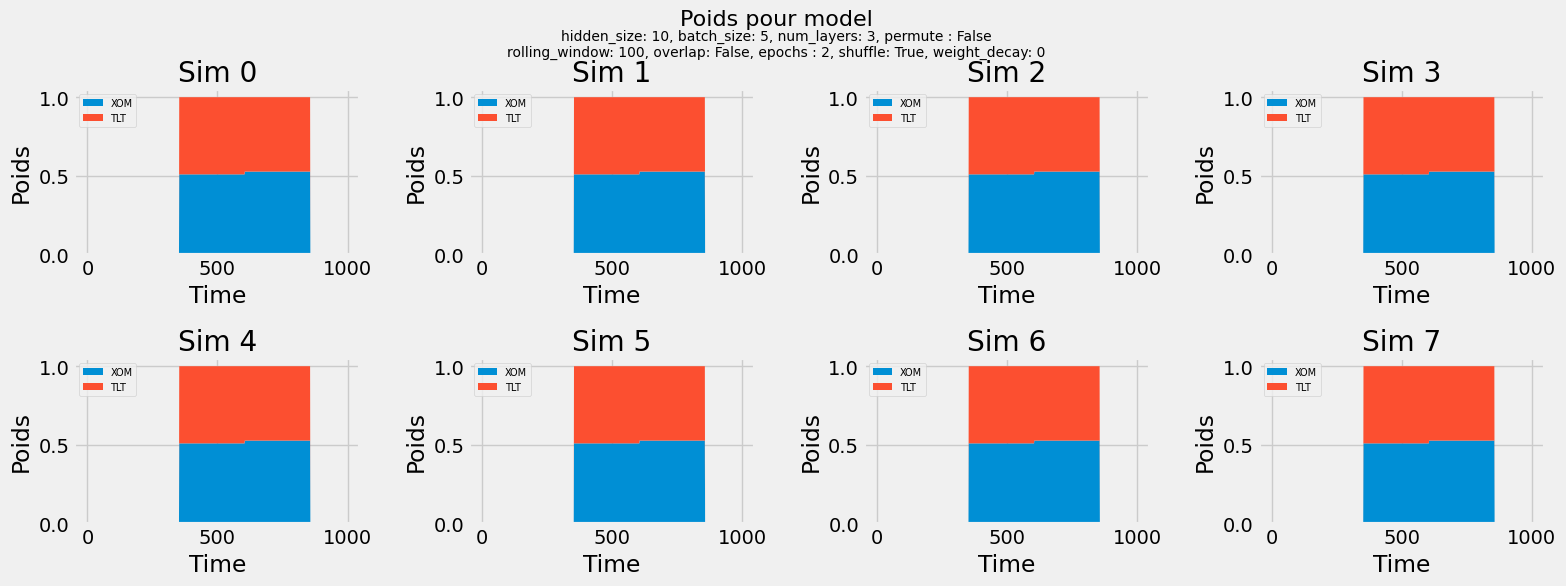

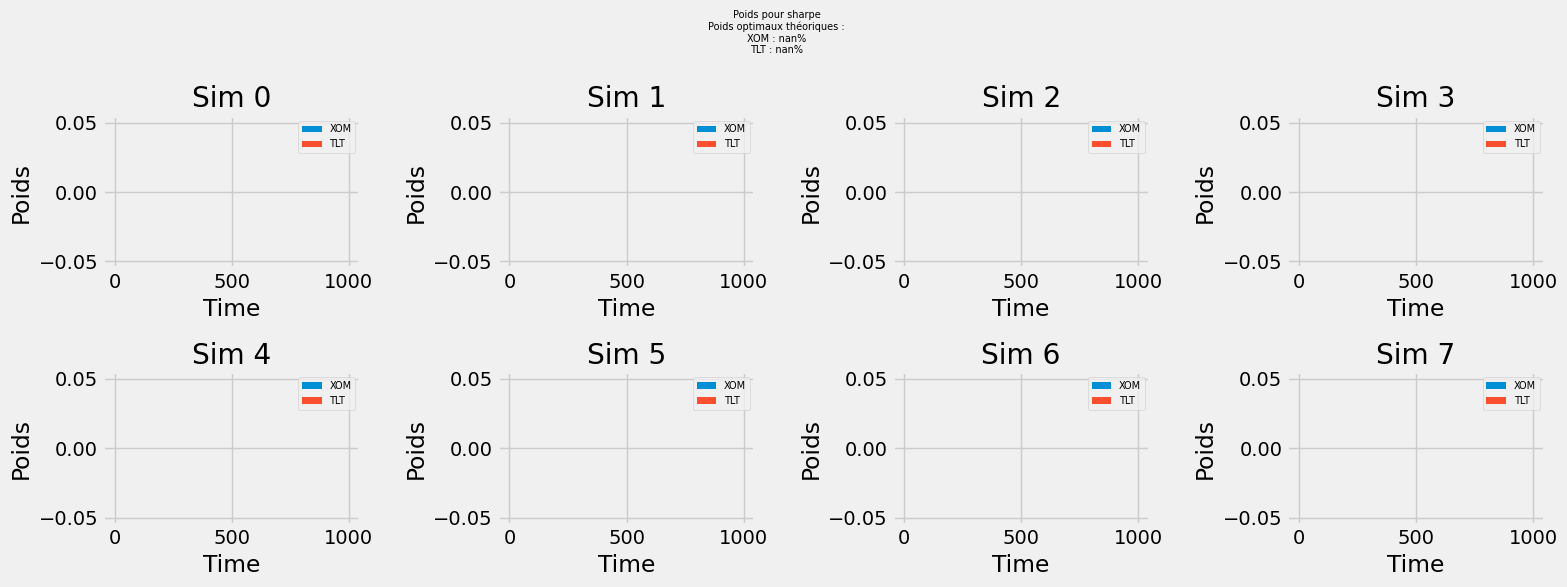

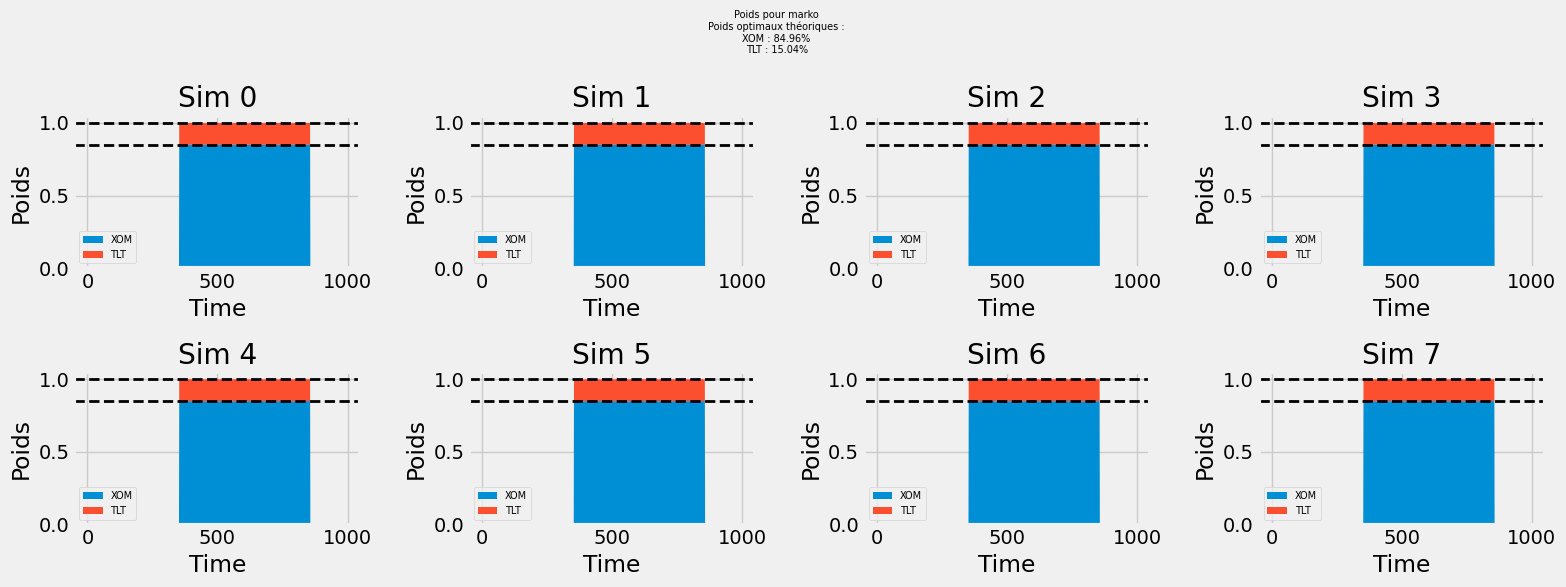

In [ ]:
trainer.plot_weights(type_w='model', th_weights='sharpe')
trainer.plot_weights(type_w='sharpe', th_weights='sharpe')
trainer.plot_weights(type_w='marko', th_weights='marko')